# DuckDB + Dask Í∞ÄÏù¥Îìú

## üéØ ÏÇ¨Ïö© Î∞©Î≤ï

- ÏÖÄ 1-5: ÏàúÏÑúÎåÄÎ°ú Ïã§Ìñâ (Í∏∞Î≥∏ ÏÑ§Ï†ï)
- ÏÖÄ 6: Ïã§Ï†ú JSON ÌååÏùºÎ™Ö ÏûÖÎ†• ÌõÑ Ïã§Ìñâ
- ÏÖÄ 7-10: Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Í∏∞Î≥∏ Î∂ÑÏÑù
- ÏÖÄ 11: Ïã§Ï†ú Ïª¨ÎüºÎ™ÖÏúºÎ°ú ÏàòÏ†ï ÌõÑ Í∑∏Î£π Î∂ÑÏÑù
- ÏÖÄ 12: Îëê Î≤àÏß∏ ÌååÏùº Î≥ëÌï© (ÏÑ†ÌÉùÏÇ¨Ìï≠)
- ÏÖÄ 13-14: Í≤∞Í≥º Ï†ÄÏû• Î∞è ÏöîÏïΩ

- üí° ÌåÅ: Í∞Å ÏÖÄÏùÑ Ïã§ÌñâÌïòÎ©¥ÏÑú Í≤∞Í≥ºÎ•º ÌôïÏù∏ÌïòÍ≥†, ÌïÑÏöîÏãú ÌååÎùºÎØ∏ÌÑ∞Î•º Ï°∞Ï†ïÌïòÏÑ∏Ïöî!

## ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò Î∞è import

In [ ]:
# GCS ÏßÄÏõê ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò
!pip install duckdb "dask[dataframe]" pandas pyarrow psutil
!pip install gcsfs fsspec google-cloud-storage
!pip install "duckdb[httpfs]"  # GCS ÏßÄÏõêÏùÑ ÏúÑÌïú httpfs ÌôïÏû•

print("‚úÖ GCS ÏßÄÏõê ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò ÏôÑÎ£å!")

‚úÖ ÏÑ§Ïπò ÏôÑÎ£å!


## ÎùºÏù¥Î∏åÎü¨Î¶¨ import Î∞è Í∏∞Î≥∏ ÏÑ§Ï†ï

In [3]:
import duckdb
import dask.dataframe as dd
import pandas as pd
import psutil
import os
import time
from google.cloud import storage
import gcsfs

print("üìö ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å!")
print(f"üíæ ÏãúÏä§ÌÖú Î©îÎ™®Î¶¨: {psutil.virtual_memory().total / (1024**3):.1f}GB")

üìö ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å!
üíæ ÏãúÏä§ÌÖú Î©îÎ™®Î¶¨: 11.7GB


## ÌôòÍ≤ΩÎ≥Ñ ÏÑ§Ï†ï Ìï®Ïàò

In [4]:
def get_memory_config():
    """Î©îÎ™®Î¶¨ ÌÅ¨Í∏∞Ïóê Îî∞Î•∏ ÏûêÎèô ÏÑ§Ï†ï"""
    total_gb = psutil.virtual_memory().total / (1024**3)
    
    if total_gb <= 10:        # 8GB
        config = {'duckdb_mem': '4GB', 'dask_block': '50MB', 'env': '8GB'}
    elif total_gb <= 20:      # 16GB  
        config = {'duckdb_mem': '8GB', 'dask_block': '100MB', 'env': '16GB'}
    else:                     # 32GB+
        config = {'duckdb_mem': '16GB', 'dask_block': '200MB', 'env': '32GB+'}
    
    print(f"‚öôÔ∏è {config['env']} ÌôòÍ≤Ω ÏÑ§Ï†ï Ï†ÅÏö©")
    print(f"   - DuckDB Î©îÎ™®Î¶¨ Ï†úÌïú: {config['duckdb_mem']}")
    print(f"   - Dask Î∏îÎ°ù ÌÅ¨Í∏∞: {config['dask_block']}")
    
    return config

# ÏÑ§Ï†ï Ï†ÅÏö©
config = get_memory_config()

‚öôÔ∏è 16GB ÌôòÍ≤Ω ÏÑ§Ï†ï Ï†ÅÏö©
   - DuckDB Î©îÎ™®Î¶¨ Ï†úÌïú: 8GB
   - Dask Î∏îÎ°ù ÌÅ¨Í∏∞: 100MB


## Î©îÎ™®Î¶¨ Î™®ÎãàÌÑ∞ÎßÅ Ìï®Ïàò

In [ ]:
import psutil

def check_memory():
    """ÌòÑÏû¨ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÌôïÏù∏"""
    mem = psutil.virtual_memory()
    used_gb = mem.used / (1024**3)
    total_gb = mem.total / (1024**3)
    percent = mem.percent
    
    print(f"üíæ Î©îÎ™®Î¶¨: {used_gb:.1f}GB / {total_gb:.1f}GB ({percent:.1f}%)")
    
    if percent > 80:
        print("üî¥ Í≤ΩÍ≥†: Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•† ÎÜíÏùå!")
    elif percent > 60:
        print("üü° Ï£ºÏùò: Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•† Ï¶ùÍ∞Ä")
    else:
        print("üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏")
    
    return percent

# ÌòÑÏû¨ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÌôïÏù∏
check_memory()

üíæ Î©îÎ™®Î¶¨: 3.8GB / 11.7GB (34.1%)
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏


34.1

## GCS ÌååÏùº ÌÉêÏÉâ Ìï®Ïàò

In [2]:
def explore_gcs_path(gcs_path):
    """GCS Í≤ΩÎ°ú ÌÉêÏÉâ"""
    if gcs_fs is None:
        print("‚ùå GCS Ïó∞Í≤∞Ïù¥ ÏÑ§Ï†ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§")
        return []
    
    try:
        print(f"üìÇ GCS Í≤ΩÎ°ú ÌÉêÏÉâ: {gcs_path}")
        
        # ÌååÏùº Î™©Î°ù Ï°∞Ìöå
        files = gcs_fs.ls(gcs_path, detail=True)
        
        json_files = []
        total_size = 0
        
        for file_info in files:
            if isinstance(file_info, dict):
                name = file_info['name']
                size = file_info.get('size', 0)
            else:
                name = file_info
                size = 0
            
            if name.endswith(('.json', '.jsonl', '.ndjson')):
                json_files.append({
                    'name': name,
                    'size_mb': size / (1024**2) if size else 0,
                    'gcs_path': f"gs://{name}"
                })
                total_size += size
        
        print(f"üìä Î∞úÍ≤¨Îêú JSON ÌååÏùº: {len(json_files)}Í∞ú")
        print(f"üìè Ï¥ù ÌÅ¨Í∏∞: {total_size / (1024**3):.2f}GB")
        
        # ÏÉÅÏúÑ 10Í∞ú ÌååÏùº Ï†ïÎ≥¥ Ï∂úÎ†•
        for i, file_info in enumerate(json_files[:10]):
            print(f"   {i+1}. {file_info['name'].split('/')[-1]} ({file_info['size_mb']:.1f}MB)")
        
        if len(json_files) > 10:
            print(f"   ... Î∞è {len(json_files) - 10}Í∞ú Îçî")
        
        return json_files
        
    except Exception as e:
        print(f"‚ùå GCS Í≤ΩÎ°ú ÌÉêÏÉâ Ïã§Ìå®: {e}")
        return []

# JSON ÌååÏùºÎì§ ÌÉêÏÉâ
input_path = "gs://sprintda05_final_project/json/hackle"
json_files = explore_gcs_path(input_path)

NameError: name 'gcs_fs' is not defined

In [27]:
def explore_gcs_path_recursive(gcs_path):
    """GCS Í≤ΩÎ°úÎ•º Ïû¨Í∑ÄÏ†ÅÏúºÎ°ú ÌÉêÏÉâÌïòÏó¨ parquet ÌååÏùº Ï∞æÍ∏∞"""
    if gcs_fs is None:
        print("‚ùå GCS Ïó∞Í≤∞Ïù¥ ÏÑ§Ï†ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§")
        return []
    
    try:
        print(f"üìÇ GCS Í≤ΩÎ°ú ÌÉêÏÉâ: {gcs_path}")
        
        # Î™®Îì† ÌååÏùº/Ìè¥Îçî Î™©Î°ù Ï°∞Ìöå (Ïû¨Í∑ÄÏ†Å)
        all_files = gcs_fs.find(gcs_path, detail=True)
        
        parquet_files = []
        folders = set()
        total_size = 0
        
        for file_path, file_info in all_files.items():
            # Ìè¥Îçî Ï†ïÎ≥¥ ÏàòÏßë
            folder_path = '/'.join(file_path.split('/')[:-1])
            if folder_path != gcs_path:
                folders.add(file_path.split('/')[-2])  # ÎÇ†Ïßú Ìè¥ÎçîÎ™Ö
            
            # parquet ÌååÏùºÎßå ÌïÑÌÑ∞ÎßÅ
            if file_path.endswith('.parquet'):
                size = file_info.get('size', 0)
                parquet_files.append({
                    'name': file_path,
                    'folder': file_path.split('/')[-2] if '/' in file_path else '',
                    'filename': file_path.split('/')[-1],
                    'size_mb': size / (1024**2) if size else 0,
                    'gcs_path': f"gs://{file_path}"
                })
                total_size += size
        
        print(f"üìÅ Î∞úÍ≤¨Îêú ÎÇ†Ïßú Ìè¥Îçî: {len(folders)}Í∞ú")
        print(f"üìä Î∞úÍ≤¨Îêú parquet ÌååÏùº: {len(parquet_files)}Í∞ú")
        print(f"üìè Ï¥ù ÌÅ¨Í∏∞: {total_size / (1024**3):.2f}GB")
        
        # Ìè¥ÎçîÎ≥Ñ ÌååÏùº Í∞úÏàò ÌôïÏù∏
        folder_counts = {}
        for file_info in parquet_files:
            folder = file_info['folder']
            folder_counts[folder] = folder_counts.get(folder, 0) + 1
        
        print(f"\nüìÇ ÎÇ†ÏßúÎ≥Ñ parquet ÌååÏùº Í∞úÏàò:")
        for folder, count in sorted(folder_counts.items()):
            print(f"   {folder}: {count}Í∞ú")
        
        # ÌååÏùºÎ™ÖÎ≥Ñ ÌÜµÍ≥Ñ
        filename_counts = {}
        for file_info in parquet_files:
            filename = file_info['filename']
            filename_counts[filename] = filename_counts.get(filename, 0) + 1
        
        print(f"\nüìÑ ÌååÏùºÎ™ÖÎ≥Ñ Í∞úÏàò:")
        for filename, count in sorted(filename_counts.items()):
            print(f"   {filename}: {count}Í∞ú")
        
        # ÏÉÅÏúÑ 10Í∞ú ÌååÏùº Ï†ïÎ≥¥ Ï∂úÎ†•
        print(f"\nüìÑ ÌååÏùº ÏÉòÌîå (ÏÉÅÏúÑ 10Í∞ú):")
        for i, file_info in enumerate(parquet_files[:10]):
            print(f"   {i+1}. {file_info['folder']}/{file_info['filename']} ({file_info['size_mb']:.1f}MB)")
        
        if len(parquet_files) > 10:
            print(f"   ... Î∞è {len(parquet_files) - 10}Í∞ú Îçî")
        
        return parquet_files
        
    except Exception as e:
        print(f"‚ùå GCS Í≤ΩÎ°ú ÌÉêÏÉâ Ïã§Ìå®: {e}")
        return []

# parquet ÌååÏùºÎì§ ÌÉêÏÉâ
input_path = "sprintda05_final_project/normalized/hackle"
parquet_files = explore_gcs_path_recursive(input_path)

üìÇ GCS Í≤ΩÎ°ú ÌÉêÏÉâ: sprintda05_final_project/normalized/hackle
üìÅ Î∞úÍ≤¨Îêú ÎÇ†Ïßú Ìè¥Îçî: 10Í∞ú
üìä Î∞úÍ≤¨Îêú parquet ÌååÏùº: 31Í∞ú
üìè Ï¥ù ÌÅ¨Í∏∞: 4.31GB

üìÇ ÎÇ†ÏßúÎ≥Ñ parquet ÌååÏùº Í∞úÏàò:
   2023-04-18: 3Í∞ú
   2023-04-24: 3Í∞ú
   2023-04-30: 3Í∞ú
   2023-05-06: 3Í∞ú
   2023-05-12: 3Í∞ú
   2023-05-18: 3Í∞ú
   2023-05-24: 3Í∞ú
   2023-06-17: 2Í∞ú
   2023-06-23: 4Í∞ú
   2023-09-15: 4Í∞ú

üìÑ ÌååÏùºÎ™ÖÎ≥Ñ Í∞úÏàò:
   event_properties.parquet: 9Í∞ú
   hackle_events.parquet: 10Í∞ú
   hackle_properties.parquet: 10Í∞ú
   user_properties.parquet: 2Í∞ú

üìÑ ÌååÏùº ÏÉòÌîå (ÏÉÅÏúÑ 10Í∞ú):
   1. 2023-04-18/event_properties.parquet (50.3MB)
   2. 2023-04-18/hackle_events.parquet (70.7MB)
   3. 2023-04-18/hackle_properties.parquet (0.6MB)
   4. 2023-04-24/event_properties.parquet (134.2MB)
   5. 2023-04-24/hackle_events.parquet (191.6MB)
   6. 2023-04-24/hackle_properties.parquet (1.4MB)
   7. 2023-04-30/event_properties.parquet (163.0MB)
   8. 2023-04-30/hackle_events.parquet (266.4

## JSON ‚Üí Parquet Î≥ÄÌôò Ìï®Ïàò

In [32]:
import duckdb
import tempfile
import shutil
import os
import json
import psutil
import gc
from typing import Dict, Optional

# GCS Ïó∞Í≤∞
import gcsfs
gcs_fs = gcsfs.GCSFileSystem()

def check_memory_safe() -> bool:
   """Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÌôïÏù∏"""
   try:
       mem = psutil.virtual_memory()
       available_gb = mem.available / (1024**3)
       percent_used = mem.percent
       
       print(f"üíæ Î©îÎ™®Î¶¨: {percent_used:.1f}% ÏÇ¨Ïö©Ï§ë, {available_gb:.1f}GB Ïó¨Ïú†")
       
       if percent_used > 85:
           print("üî¥ ÏúÑÌóò: Î©îÎ™®Î¶¨ Î∂ÄÏ°±")
           return False
       elif percent_used > 70:
           print("üü° Ï£ºÏùò: Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•† ÎÜíÏùå")
       else:
           print("üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏")
           
       return available_gb > 1.0
   except:
       return True

def create_json_table_fixed(conn: duckdb.DuckDBPyConnection, temp_json: str, read_func: str,
                          json_column: str, keys: list, output_file: str) -> None:
   """$ ÌÇ§ Ï≤òÎ¶¨Í∞Ä Í∞ÄÎä•Ìïú JSON ÌÖåÏù¥Î∏î ÏÉùÏÑ±"""
   
   json_extracts = []
   for key in keys:
       # ÏïàÏ†ÑÌïú Ïª¨ÎüºÎ™Ö ÏÉùÏÑ±
       safe_key = key.lstrip('$').replace('-', '_').replace(' ', '_').replace('.', '_')
       if not safe_key or safe_key[0].isdigit():
           safe_key = f"col_{safe_key}"
       
       # $ ÌÇ§Îäî ÎåÄÍ¥ÑÌò∏ ÌëúÍ∏∞Î≤ï ÏÇ¨Ïö©
       if key.startswith('$'):
           json_extracts.append(f'json_extract_string({json_column}, \'$["{key}"]\') as {safe_key}')
       else:
           json_extracts.append(f"json_extract_string({json_column}, '$.{key}') as {safe_key}")
   
   # ID Ïª¨Îüº Îß§Ìïë
   id_mapping = {
       'user_properties': '"user_id"',
       'hackle_properties': '"session_id"',
       'event_properties': '"id"'
   }
   id_col = id_mapping.get(json_column, '"id"')
   
   # ÏøºÎ¶¨ Ïã§Ìñâ
   query = f"""
       COPY (
           SELECT DISTINCT
               {id_col} as id,
               {', '.join(json_extracts)}
           FROM {read_func}('{temp_json}')
           WHERE {json_column} IS NOT NULL AND {json_column} != '{{}}'
       ) TO '{output_file}' (FORMAT PARQUET, COMPRESSION 'SNAPPY')
   """
   conn.execute(query)

def normalize_hackle_data(input_gcs_path: str, max_memory_mb: int = 1500) -> Optional[Dict[str, str]]:
   """Hackle JSONÏùÑ Ï†ïÍ∑úÌôîÎêú ÌÖåÏù¥Î∏îÎ°ú Î≥ÄÌôò"""
   
   # Î©îÎ™®Î¶¨ Ï≤¥ÌÅ¨
   if not check_memory_safe():
       print("‚ùå Î©îÎ™®Î¶¨ Î∂ÄÏ°±ÏúºÎ°ú Î≥ÄÌôò Ï§ëÎã®")
       return None
   
   # Ï∂úÎ†• Í≤ΩÎ°ú ÏÑ§Ï†ï
   date = input_gcs_path.split('/')[-1].replace('.json', '')
   output_base = f"gs://sprintda05_final_project/normalized/hackle/{date}"
   
   temp_dir = None
   
   try:
       temp_dir = tempfile.mkdtemp()
       temp_json = os.path.join(temp_dir, 'input.json')
       
       # 1. Îã§Ïö¥Î°úÎìú (Ï≤≠ÌÅ¨ Îã®ÏúÑ)
       print(f"üì• Îã§Ïö¥Î°úÎìú: {date}")
       with gcs_fs.open(input_gcs_path.replace('gs://', ''), 'r') as src:
           with open(temp_json, 'w') as dst:
               while True:
                   chunk = src.read(1024 * 1024)  # 1MB Ï≤≠ÌÅ¨
                   if not chunk:
                       break
                   dst.write(chunk)
                   
                   # Î©îÎ™®Î¶¨ Ï≤¥ÌÅ¨
                   if not check_memory_safe():
                       raise MemoryError("Î©îÎ™®Î¶¨ Î∂ÄÏ°±")
       
       file_size_mb = os.path.getsize(temp_json) / (1024**2)
       print(f"‚úÖ Îã§Ïö¥Î°úÎìú ÏôÑÎ£å: {file_size_mb:.1f}MB")
       
       # ÌÅ∞ ÌååÏùºÏùÄ Î©îÎ™®Î¶¨ Ï†úÌïú Í∞ïÌôî
       if file_size_mb > 1000:
           max_memory_mb = min(max_memory_mb, 1000)
           print(f"‚ö†Ô∏è ÌÅ∞ ÌååÏùº Í∞êÏßÄ - Î©îÎ™®Î¶¨ Ï†úÌïú: {max_memory_mb}MB")
       
       # 2. DuckDB ÏÑ§Ï†ï
       conn = duckdb.connect()
       conn.execute(f"SET memory_limit = '{max_memory_mb}MB'")
       conn.execute("SET threads = 2")
       conn.execute("SET temp_directory = '/tmp'")
       
       read_func = 'read_json_auto'
       
       # 3. Ïä§ÌÇ§Îßà Î∂ÑÏÑù
       schema = conn.execute(f"DESCRIBE SELECT * FROM {read_func}('{temp_json}') LIMIT 1").fetchall()
       all_columns = [col[0] for col in schema]
       
       json_columns = ['user_properties', 'hackle_properties', 'event_properties']
       main_columns = [col for col in all_columns if col not in json_columns]
       
       print(f"üìä Î∞úÍ≤¨Îêú Ïª¨Îüº: {len(all_columns)}Í∞ú (Î©îÏù∏: {len(main_columns)}, JSON: {len([c for c in json_columns if c in all_columns])})")
       
       # 4. JSON ÌÇ§ Ï∂îÏ∂ú
       json_keys = {}
       for json_col in json_columns:
           if json_col in all_columns:
               sample = conn.execute(f"SELECT {json_col} FROM {read_func}('{temp_json}') WHERE {json_col} IS NOT NULL LIMIT 20").fetchall()
               keys = set()
               for row in sample:
                   try:
                       if row[0] and row[0] != '{}':
                           parsed = json.loads(row[0]) if isinstance(row[0], str) else row[0]
                           if isinstance(parsed, dict):
                               keys.update(parsed.keys())
                   except:
                       continue
               json_keys[json_col] = sorted(list(keys))
               print(f"   üîé {json_col}: {len(json_keys[json_col])}Í∞ú ÌÇ§")
       
       output_files = {}
       
       # 5. Î©îÏù∏ ÌÖåÏù¥Î∏î ÏÉùÏÑ±
       print("üìä hackle_events ÏÉùÏÑ±")
       events_file = os.path.join(temp_dir, 'hackle_events.parquet')
       conn.execute(f"""
           COPY (SELECT {', '.join([f'"{col}"' for col in main_columns])} FROM {read_func}('{temp_json}'))
           TO '{events_file}' (FORMAT PARQUET, COMPRESSION 'SNAPPY')
       """)
       
       gcs_fs.upload(events_file, f"{output_base}/hackle_events.parquet".replace('gs://', ''))
       output_files['hackle_events'] = f"{output_base}/hackle_events.parquet"
       
       size_mb = os.path.getsize(events_file) / (1024**2)
       print(f"‚úÖ hackle_events.parquet: {size_mb:.1f}MB")
       
       # 6. JSON ÌÖåÏù¥Î∏îÎì§ ÏÉùÏÑ±
       for json_col, keys in json_keys.items():
           if keys:
               print(f"üìã {json_col} ÏÉùÏÑ± Ï§ë...")
               json_file = os.path.join(temp_dir, f'{json_col}.parquet')
               
               try:
                   create_json_table_fixed(conn, temp_json, read_func, json_col, keys, json_file)
                   gcs_fs.upload(json_file, f"{output_base}/{json_col}.parquet".replace('gs://', ''))
                   output_files[json_col] = f"{output_base}/{json_col}.parquet"
                   
                   size_mb = os.path.getsize(json_file) / (1024**2)
                   print(f"‚úÖ {json_col}.parquet: {size_mb:.1f}MB ({len(keys)}Í∞ú Ïª¨Îüº)")
                   
               except Exception as e:
                   print(f"‚ùå {json_col} Ïã§Ìå®: {e}")
       
       conn.close()
       print(f"üéâ ÏôÑÎ£å: {len(output_files)}Í∞ú ÌÖåÏù¥Î∏î ÏÉùÏÑ±")
       return output_files
       
   except MemoryError:
       print("‚ùå Î©îÎ™®Î¶¨ Î∂ÄÏ°±ÏúºÎ°ú Î≥ÄÌôò Ïã§Ìå®")
       return None
   except Exception as e:
       print(f"‚ùå Ïã§Ìå®: {e}")
       return None
   finally:
       # Î∞òÎìúÏãú Ï†ïÎ¶¨
       if temp_dir and os.path.exists(temp_dir):
           try:
               shutil.rmtree(temp_dir)
           except:
               pass
       gc.collect()

# Ïã§Ìñâ
print("üöÄ Hackle JSON ‚Üí Ï†ïÍ∑úÌôî Parquet Î≥ÄÌôòÍ∏∞")
result = normalize_hackle_data('gs://sprintda05_final_project/json/hackle/2023-06-29.json')

if result:
   print("\n‚úÖ ÏÉùÏÑ±Îêú ÌÖåÏù¥Î∏î:")
   for table, path in result.items():
       print(f"   üìã {table}: {path}")
else:
   print("\n‚ùå Î≥ÄÌôò Ïã§Ìå®")

üöÄ Hackle JSON ‚Üí Ï†ïÍ∑úÌôî Parquet Î≥ÄÌôòÍ∏∞
üíæ Î©îÎ™®Î¶¨: 52.8% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üì• Îã§Ïö¥Î°úÎìú: 2023-06-29
üíæ Î©îÎ™®Î¶¨: 52.9% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.9% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.9% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.8% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.8% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.9% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.9% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.8% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.8% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.8% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.9% ÏÇ¨Ïö©Ï§ë, 5.5GB Ïó¨Ïú†
üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏
üíæ Î©îÎ™®Î¶¨: 52.9%

In [7]:
import dask.dataframe as dd
import pandas as pd

# GCSÏóêÏÑú ÏÉùÏÑ±Îêú ÌååÏºÄÏù¥ ÌååÏùº ÏùΩÍ∏∞
parquet_path = "gs://sprintda05_final_project/normalized/auto/2023-05-12/main_events.parquet"

# Dask DataFrameÏúºÎ°ú ÏùΩÍ∏∞
df = dd.read_parquet(parquet_path, engine='pyarrow')

# Í∏∞Î≥∏ Ï†ïÎ≥¥ Ï∂úÎ†•
print("üîç ÌÖåÏù¥Î∏î Í∏∞Î≥∏ Ï†ïÎ≥¥:")
print(f"üìä ÌååÌã∞ÏÖò Ïàò: {df.npartitions}")
print(f"üìã Ïª¨Îüº Ïàò: {len(df.columns)}")
print(f"üìà ÏòàÏÉÅ Ìñâ Ïàò: {len(df)}")

print("\nüìã Ï†ÑÏ≤¥ Ïª¨Îüº Î™©Î°ù:")
for i, col in enumerate(df.columns):
    print(f"   {i+1:2d}. {col}")

print("\nüìÑ ÏÉÅÏúÑ 5Ìñâ Îç∞Ïù¥ÌÑ∞:")
print(df.head())

print("\nüîç Ïª¨ÎüºÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ:")
print(df.dtypes)

print("\nüìä Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ:")
print(f"ÏòàÏÉÅ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: {df.memory_usage_per_partition().sum().compute():.2f} bytes")

üîç ÌÖåÏù¥Î∏î Í∏∞Î≥∏ Ï†ïÎ≥¥:
üìä ÌååÌã∞ÏÖò Ïàò: 6
üìã Ïª¨Îüº Ïàò: 10
üìà ÏòàÏÉÅ Ìñâ Ïàò: 12188804

üìã Ï†ÑÏ≤¥ Ïª¨Îüº Î™©Î°ù:
    1. Asia/Seoul
    2. id
    3. event_key
    4. session_id
    5. device_id
    6. user_id
    7. value
    8. user_properties
    9. hackle_properties
   10. event_properties

üìÑ ÏÉÅÏúÑ 5Ìñâ Îç∞Ïù¥ÌÑ∞:
                 Asia/Seoul  \
0  2023-05-13T00:00:00.004Z   
1  2023-05-13T00:00:00.027Z   
2  2023-05-13T00:00:00.027Z   
3  2023-05-13T00:00:00.046Z   
4  2023-05-13T00:00:00.070Z   

                                                  id       event_key  \
0        b'P33\xbc\xefy@\xb6\xa0`k\xf0\x8e\x8d\x03S'  $session_start   
1  b'd\xd5$\x00{7F\x92\xb2\x01\xd3t\x0b\xd3\x90\x98'    $session_end   
2                 b"g\x195\xf0!pO\x1b\xb8i`'|jI\x93"    $session_end   
3  b'\x17\xda`^\xf1\xe9B\xd5\xafj\x95S\x1aI\xf3\xb7'  $session_start   
4  b'\x0f\xa8\xba\x80@JG\xaf\xbe\x12\xe2\x85\xc7\...    $session_end   

                     session_id  \
0  6zk

In [3]:
import dask.dataframe as dd
import tempfile
import os
import gcsfs

# GCS Ïó∞Í≤∞ (Ïù¥ÎØ∏ ÏûàÎã§Î©¥ ÏÉùÎûµ)
gcs_fs = gcsfs.GCSFileSystem()

def load_and_preview_tables():
   """ÏÉùÏÑ±Îêú ÌÖåÏù¥Î∏îÎì§ÏùÑ DaskÎ°ú Î°úÎìúÌïòÍ≥† ÎØ∏Î¶¨Î≥¥Í∏∞"""
   
   tables = {
       'hackle_events': 'gs://sprintda05_final_project/normalized/hackle/2023-09-15/hackle_events.parquet',
       'user_properties': 'gs://sprintda05_final_project/normalized/hackle/2023-09-15/user_properties.parquet',
       'hackle_properties': 'gs://sprintda05_final_project/normalized/hackle/2023-09-15/hackle_properties.parquet',
       'event_properties': 'gs://sprintda05_final_project/normalized/hackle/2023-09-15/event_properties.parquet'
   }
   
   print("üìä ÏÉùÏÑ±Îêú ÌÖåÏù¥Î∏îÎì§ ÎØ∏Î¶¨Î≥¥Í∏∞")
   print("=" * 60)
   
   for table_name, gcs_path in tables.items():
       try:
           print(f"\nüîç {table_name.upper()} ÌÖåÏù¥Î∏î")
           print("-" * 40)
           
           # ÏûÑÏãú Îã§Ïö¥Î°úÎìú
           temp_dir = tempfile.mkdtemp()
           temp_file = os.path.join(temp_dir, f'{table_name}.parquet')
           
           with gcs_fs.open(gcs_path.replace('gs://', ''), 'rb') as src:
               with open(temp_file, 'wb') as dst:
                   dst.write(src.read())
           
           # Dask DataFrame ÏÉùÏÑ±
           df = dd.read_parquet(temp_file, engine='pyarrow')
           
           # Í∏∞Î≥∏ Ï†ïÎ≥¥
           print(f"üìè ÌÅ¨Í∏∞: {df.shape[0].compute():,}Ìñâ √ó {len(df.columns)}Ïª¨Îüº")
           print(f"üß© ÌååÌã∞ÏÖò: {df.npartitions}Í∞ú")
           
           # Ïª¨Îüº Ï†ïÎ≥¥
           print(f"\nüìã Ïª¨Îüº Î™©Î°ù:")
           for i, col in enumerate(df.columns, 1):
               dtype = str(df[col].dtype)
               print(f"   {i:2d}. {col:20} | {dtype}")
           
           # ÏÉÅÏúÑ 5Ìñâ ÎØ∏Î¶¨Î≥¥Í∏∞
           print(f"\nüìÑ ÏÉÅÏúÑ 5Ìñâ:")
           sample_df = df.head(5)
           
           # Ïª¨ÎüºÏù¥ ÎßéÏúºÎ©¥ ÏùºÎ∂ÄÎßå ÌëúÏãú
           if len(df.columns) > 6:
               display_cols = list(df.columns)[:6]
               print(f"   (Ï≤òÏùå 6Í∞ú Ïª¨ÎüºÎßå ÌëúÏãú: {display_cols})")
               sample_display = sample_df[display_cols]
           else:
               sample_display = sample_df
           
           # Î≥¥Í∏∞ Ï¢ãÍ≤å Ï∂úÎ†•
           for idx, row in sample_display.iterrows():
               print(f"\n   üìù Ìñâ {idx + 1}:")
               for col in sample_display.columns:
                   value = str(row[col])
                   if len(value) > 50:
                       value = value[:47] + "..."
                   print(f"      {col:20}: {value}")
           
           # Ï†ïÎ¶¨
           os.remove(temp_file)
           os.rmdir(temp_dir)
           
       except Exception as e:
           print(f"‚ùå {table_name} Î°úÎìú Ïã§Ìå®: {e}")
   
   print(f"\nüéâ ÌÖåÏù¥Î∏î ÎØ∏Î¶¨Î≥¥Í∏∞ ÏôÑÎ£å!")

# Ïã§Ìñâ
load_and_preview_tables()

üìä ÏÉùÏÑ±Îêú ÌÖåÏù¥Î∏îÎì§ ÎØ∏Î¶¨Î≥¥Í∏∞

üîç HACKLE_EVENTS ÌÖåÏù¥Î∏î
----------------------------------------
üìè ÌÅ¨Í∏∞: 2,660,566Ìñâ √ó 7Ïª¨Îüº
üß© ÌååÌã∞ÏÖò: 1Í∞ú

üìã Ïª¨Îüº Î™©Î°ù:
    1. Asia/Seoul           | string
    2. id                   | object
    3. event_key            | string
    4. session_id           | string
    5. device_id            | object
    6. user_id              | string
    7. value                | float64

üìÑ ÏÉÅÏúÑ 5Ìñâ:
   (Ï≤òÏùå 6Í∞ú Ïª¨ÎüºÎßå ÌëúÏãú: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id'])

   üìù Ìñâ 1:
      Asia/Seoul          : 2023-09-16T00:00:00.104Z
      id                  : b'C\xf4=gb\x8bGY\xbc"71\x1e\xd3\xfer'
      event_key           : view_questions_tap
      session_id          : e402aa34-fee4-487c-bf88-2e23532f37bb
      device_id           : b'\xe4\x02\xaa4\xfe\xe4H|\xbf\x88.#S/7\xbb'
      user_id             : 1048357

   üìù Ìñâ 2:
      Asia/Seoul          : 2023-09-16T00:00:00.650Z

## Dask Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ìï®Ïàò

In [2]:
import dask.dataframe as dd
import dask

def true_dask_analysis(parquet_gcs_path):
    """ÏßÑÏßú DaskÎ•º ÌôúÏö©Ìïú ÎåÄÏö©Îüâ Î∂ÑÏÑù"""
    
    print(f"üöÄ Dask Î∂ÑÏÇ∞ Î∂ÑÏÑù: {parquet_gcs_path.split('/')[-1]}")
    print("=" * 60)
    
    try:
        # 1. DaskÎ°ú ÏßÅÏ†ë ÏùΩÍ∏∞ (lazy loading)
        print("üìÇ Dask DataFrame ÏÉùÏÑ± (lazy)...")
        
        # ÏûÑÏãú Îã§Ïö¥Î°úÎìú ÏóÜÏù¥ ÏßÅÏ†ë ÏùΩÍ∏∞ ÏãúÎèÑ
        temp_dir = tempfile.mkdtemp()
        temp_file = os.path.join(temp_dir, 'temp.parquet')
        
        # Î∞îÏù¥ÎÑàÎ¶¨ Îã§Ïö¥Î°úÎìú
        with gcs_fs.open(parquet_gcs_path.replace('gs://', ''), 'rb') as src:
            with open(temp_file, 'wb') as dst:
                dst.write(src.read())
        
        # Dask DataFrame ÏÉùÏÑ± (lazy evaluation)
        df = dd.read_parquet(temp_file, engine='pyarrow')
        
        print(f"‚úÖ Dask DataFrame ÏÉùÏÑ± ÏôÑÎ£å")
        print(f"   - ÌååÌã∞ÏÖò Ïàò: {df.npartitions}")
        print(f"   - Ïª¨Îüº Ïàò: {len(df.columns)}")
        
        # 2. Lazy operations (Ïã§Ï†ú Ïó∞ÏÇ∞ ÏïàÌï®)
        print(f"\nüîÑ Lazy Ïó∞ÏÇ∞ Ï†ïÏùò...")
        
        # Ìñâ Ïàò Í≥ÑÏÇ∞ (lazy)
        total_rows_lazy = df.shape[0]
        
        # Í∞Å Ïª¨ÎüºÎ≥Ñ ÌÜµÍ≥Ñ (lazy)
        column_stats = {}
        for col in df.columns:
            column_stats[col] = {
                'dtype': df[col].dtype,
                'null_count': df[col].isnull().sum(),
                'unique_count': df[col].nunique(),
                'sample_values': df[col].dropna().head(3)
            }
        
        print(f"   ‚úÖ {len(df.columns)}Í∞ú Ïª¨Îüº Ïó∞ÏÇ∞ Ï†ïÏùò ÏôÑÎ£å")
        
        # 3. ÏÑ†ÌÉùÏ†Å compute (ÌïÑÏöîÌïú Í≤ÉÎßå)
        print(f"\n‚ö° Î∂ÑÏÇ∞ Ïó∞ÏÇ∞ Ïã§Ìñâ...")
        
        # Ï¥ù Ìñâ ÏàòÎßå Î®ºÏ†Ä Í≥ÑÏÇ∞
        total_rows = total_rows_lazy.compute()
        print(f"   üìä Ï¥ù Ìñâ Ïàò: {total_rows:,}")
        
        # Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ Ï†ïÎ≥¥ (Ïó∞ÏÇ∞ ÏóÜÏù¥ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞)
        print(f"\nüìã Ïª¨Îüº Ï†ïÎ≥¥ (Î©îÌÉÄÎç∞Ïù¥ÌÑ∞):")
        for i, (col, dtype) in enumerate(df.dtypes.items()):
            print(f"   {i+1:2d}. {col:25} | {str(dtype):15}")
        
        # 4. Ï≤≠ÌÅ¨Î≥Ñ ÏÉòÌîåÎßÅ (ÏßÑÏßú Dask Î∞©Ïãù)
        print(f"\nüéØ Î∂ÑÏÇ∞ ÏÉòÌîåÎßÅ...")
        
        # Í∞Å ÌååÌã∞ÏÖòÏóêÏÑú ÏÉòÌîå Ï∂îÏ∂ú
        def sample_partition(partition):
            if len(partition) > 100:
                return partition.sample(n=100)
            else:
                return partition
        
        # ÌååÌã∞ÏÖòÎ≥Ñ ÏÉòÌîåÎßÅ (lazy)
        sampled = df.map_partitions(sample_partition)
        sample_df = sampled.compute()  # Ïù¥ÎïåÎßå Ïã§Ï†ú Ïó∞ÏÇ∞
        
        print(f"   ‚úÖ ÏÉòÌîå: {len(sample_df):,}Ìñâ")
        
        # 5. Î∂ÑÏÇ∞ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
        print(f"\nüìä Î∂ÑÏÇ∞ ÌÜµÍ≥Ñ Ïó∞ÏÇ∞...")
        
        # Î≥ëÎ†¨Î°ú Ïó¨Îü¨ ÌÜµÍ≥Ñ ÌïúÎ≤àÏóê Í≥ÑÏÇ∞
        stats_to_compute = {
            'total_nulls': df.isnull().sum().sum(),
            'memory_usage': df.memory_usage(deep=True).sum()
        }
        
        # ÌïúÎ≤àÏóê Î™®Îì† ÌÜµÍ≥Ñ Í≥ÑÏÇ∞ (Ìö®Ïú®Ï†Å)
        computed_stats = dask.compute(stats_to_compute)
        
        print(f"   ‚úÖ Î∂ÑÏÇ∞ Ïó∞ÏÇ∞ ÏôÑÎ£å")
        
        # 6. Dask ÌÉúÏä§ÌÅ¨ Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî (ÏÑ†ÌÉùÏ†Å)
        print(f"\nüîç Dask Ïó∞ÏÇ∞ Í∑∏ÎûòÌîÑ:")
        print(f"   - Ï¥ù ÌÉúÏä§ÌÅ¨ Ïàò: {len(df.__dask_graph__())}")
        print(f"   - ÌååÌã∞ÏÖòÎãπ ÌèâÍ∑† ÌñâÏàò: {total_rows // df.npartitions:,}")
        
        # 7. Í≤∞Í≥º ÏöîÏïΩ
        print(f"\nüéØ Dask Î∂ÑÏÑù Í≤∞Í≥º:")
        print(f"   üìè Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {total_rows:,}Ìñâ √ó {len(df.columns)}Ïª¨Îüº")
        print(f"   üß© ÌååÌã∞ÏÖò Î∂ÑÌï†: {df.npartitions}Í∞ú")
        print(f"   ‚ö° Î≥ëÎ†¨ Ï≤òÎ¶¨: Í∞ÄÎä•")
        print(f"   üíæ Î©îÎ™®Î¶¨ Ìö®Ïú®: Lazy loadingÏúºÎ°ú ÏµúÏ†ÅÌôî")
        
        # Ï†ïÎ¶¨
        os.remove(temp_file)
        os.rmdir(temp_dir)
        
        return {
            'dask_df': df,
            'total_rows': total_rows,
            'partitions': df.npartitions,
            'sample_df': sample_df,
            'is_dask_analysis': True
        }
        
    except Exception as e:
        print(f"‚ùå Dask Î∂ÑÏÑù Ïã§Ìå®: {e}")
        return None

# ÏßÑÏßú Dask Î∂ÑÏÑù Ïã§Ìñâ
print("üöÄ Ïù¥Ï†ú ÏßÑÏßú Dask Î∂ÑÏÑùÏùÑ Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§!")
dask_result = true_dask_analysis('gs://sprintda05_final_project/parquet/hackle/2023-09-15.parquet')

if dask_result:
    print(f"\n‚úÖ Dask Î∂ÑÏÑù ÏÑ±Í≥µ!")
    print(f"   üß© {dask_result['partitions']}Í∞ú ÌååÌã∞ÏÖòÏúºÎ°ú Î∂ÑÏÇ∞ Ï≤òÎ¶¨")
    print(f"   ‚ö° Lazy evaluationÏúºÎ°ú Î©îÎ™®Î¶¨ Ìö®Ïú®ÏÑ± Í∑πÎåÄÌôî")
else:
    print("‚ùå Dask Î∂ÑÏÑù Ïã§Ìå®")

üöÄ Ïù¥Ï†ú ÏßÑÏßú Dask Î∂ÑÏÑùÏùÑ Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§!
üöÄ Dask Î∂ÑÏÇ∞ Î∂ÑÏÑù: 2023-09-15.parquet
üìÇ Dask DataFrame ÏÉùÏÑ± (lazy)...
‚úÖ Dask DataFrame ÏÉùÏÑ± ÏôÑÎ£å
   - ÌååÌã∞ÏÖò Ïàò: 1
   - Ïª¨Îüº Ïàò: 10

üîÑ Lazy Ïó∞ÏÇ∞ Ï†ïÏùò...
   ‚úÖ 10Í∞ú Ïª¨Îüº Ïó∞ÏÇ∞ Ï†ïÏùò ÏôÑÎ£å

‚ö° Î∂ÑÏÇ∞ Ïó∞ÏÇ∞ Ïã§Ìñâ...
   üìä Ï¥ù Ìñâ Ïàò: 2,660,566

üìã Ïª¨Îüº Ï†ïÎ≥¥ (Î©îÌÉÄÎç∞Ïù¥ÌÑ∞):
    1. Asia/Seoul                | string         
    2. id                        | object         
    3. event_key                 | string         
    4. session_id                | string         
    5. device_id                 | object         
    6. user_id                   | string         
    7. value                     | float64        
    8. user_properties           | object         
    9. hackle_properties         | object         
   10. event_properties          | object         

üéØ Î∂ÑÏÇ∞ ÏÉòÌîåÎßÅ...
   ‚úÖ ÏÉòÌîå: 100Ìñâ

üìä Î∂ÑÏÇ∞ ÌÜµÍ≥Ñ Ïó∞ÏÇ∞...
   ‚úÖ Î∂ÑÏÇ∞ Ïó∞ÏÇ∞ ÏôÑÎ£å

üîç 

In [3]:
import dask.dataframe as dd
import gcsfs

# GCS Ïó∞Í≤∞
gcs_fs = gcsfs.GCSFileSystem()

def get_parquet_columns(gcs_path):
    """GCS Í≤ΩÎ°úÏùò Î™®Îì† parquet ÌååÏùº Ïª¨Îüº Ï∂úÎ†•"""
    files = gcs_fs.find(gcs_path, detail=False)
    parquet_files = [f for f in files if f.endswith('.parquet')]
    
    for file_path in parquet_files:
        print(f"\nüìÑ {file_path}")
        try:
            df = dd.read_parquet(f"gs://{file_path}", engine='pyarrow')
            print(f"   Ïª¨Îüº ({len(df.columns)}Í∞ú): {list(df.columns)}")
        except Exception as e:
            print(f"   ‚ùå Ïò§Î•ò: {e}")

def get_single_file_columns(file_path):
    """Îã®Ïùº parquet ÌååÏùº Ïª¨Îüº Ï∂úÎ†•"""
    print(f"\nüìÑ {file_path}")
    try:
        df = dd.read_parquet(f"gs://{file_path}", engine='pyarrow')
        print(f"   Ïª¨Îüº ({len(df.columns)}Í∞ú): {list(df.columns)}")
    except Exception as e:
        print(f"   ‚ùå Ïò§Î•ò: {e}")

# Ïã§Ìñâ
paths = [
    "sprintda05_final_project/normalized/hackle",
    "sprintda05_final_project/hackle"
]

# ÎîîÎ†âÌÜ†Î¶¨Îì§ Î∂ÑÏÑù
for path in paths:
    print(f"\n{'='*50}")
    print(f"Í≤ΩÎ°ú: {path}")
    print('='*50)
    get_parquet_columns(path)

# Îã®Ïùº ÌååÏùº Î∂ÑÏÑù
print(f"\n{'='*50}")
print(f"Îã®Ïùº ÌååÏùº Î∂ÑÏÑù")
print('='*50)
get_single_file_columns("sprintda05_final_project/processed/accounts_user_processed.parquet")


Í≤ΩÎ°ú: sprintda05_final_project/normalized/hackle

üìÑ sprintda05_final_project/normalized/hackle/2023-04-18/event_properties.parquet
   Ïª¨Îüº (4Í∞ú): ['id', 'description', 'location', 'sessionid']

üìÑ sprintda05_final_project/normalized/hackle/2023-04-18/hackle_events.parquet
   Ïª¨Îüº (7Í∞ú): ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']

üìÑ sprintda05_final_project/normalized/hackle/2023-04-18/hackle_properties.parquet
   Ïª¨Îüº (9Í∞ú): ['id', 'devicemodel', 'devicevendor', 'isapp', 'language', 'osname', 'osversion', 'platform', 'versionname']

üìÑ sprintda05_final_project/normalized/hackle/2023-04-24/event_properties.parquet
   Ïª¨Îüº (4Í∞ú): ['id', 'description', 'location', 'sessionid']

üìÑ sprintda05_final_project/normalized/hackle/2023-04-24/hackle_events.parquet
   Ïª¨Îüº (7Í∞ú): ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']

üìÑ sprintda05_final_project/normalized/hackle/2023-04-24/hackle_proper

In [33]:
import dask.dataframe as dd
import gcsfs

# GCS Ïó∞Í≤∞
gcs_fs = gcsfs.GCSFileSystem()

def check_date_folders_columns():
    """ÌäπÏ†ï ÎÇ†Ïßú Ìè¥ÎçîÎì§Ïùò parquet ÌååÏùº Ïª¨Îüº ÌôïÏù∏"""
    
    base_path = "sprintda05_final_project/normalized/hackle"
    date_folders = [
        "2023-03-31",
        "2023-04-06", 
        "2023-04-12",
        "2023-06-05",
        "2023-06-11",
        "2023-05-30",
        "2023-06-29",
        "2023-07-05"
    ]
    
    for date_folder in date_folders:
        print(f"\n{'='*60}")
        print(f"üìÅ {base_path}/{date_folder}")
        print('='*60)
        
        folder_path = f"{base_path}/{date_folder}"
        
        try:
            # Ìï¥Îãπ Ìè¥Îçî ÏïàÏùò ÌååÏùºÎì§ Ï∞æÍ∏∞
            files = gcs_fs.find(folder_path, detail=False)
            parquet_files = [f for f in files if f.endswith('.parquet')]
            
            if not parquet_files:
                print("‚ùå parquet ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§.")
                continue
                
            print(f"üìä Ï¥ù {len(parquet_files)}Í∞úÏùò parquet ÌååÏùº Î∞úÍ≤¨")
            
            for file_path in parquet_files:
                file_name = file_path.split('/')[-1]
                print(f"\nüìÑ {file_name}")
                
                try:
                    df = dd.read_parquet(f"gs://{file_path}", engine='pyarrow')
                    columns = list(df.columns)
                    print(f"   Ïª¨Îüº ({len(columns)}Í∞ú): {columns}")
                    
                    # Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞ÎèÑ ÌôïÏù∏
                    try:
                        row_count = len(df)
                        print(f"   Ìñâ Ïàò: {row_count:,}Í∞ú")
                    except:
                        print(f"   Ìñâ Ïàò: ÌôïÏù∏ Î∂àÍ∞Ä")
                        
                except Exception as e:
                    print(f"   ‚ùå ÌååÏùº ÏùΩÍ∏∞ Ïò§Î•ò: {e}")
                    
        except Exception as e:
            print(f"‚ùå Ìè¥Îçî Ï†ëÍ∑º Ïò§Î•ò: {e}")

# Ïã§Ìñâ
check_date_folders_columns()


üìÅ sprintda05_final_project/normalized/hackle/2023-03-31
üìä Ï¥ù 3Í∞úÏùò parquet ÌååÏùº Î∞úÍ≤¨

üìÑ event_properties.parquet
   Ïª¨Îüº (4Í∞ú): ['id', 'description', 'location', 'sessionid']
   Ìñâ Ïàò: 11,558Í∞ú

üìÑ hackle_events.parquet
   Ïª¨Îüº (7Í∞ú): ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
   Ìñâ Ïàò: 11,558Í∞ú

üìÑ hackle_properties.parquet
   Ïª¨Îüº (9Í∞ú): ['id', 'devicemodel', 'devicevendor', 'isapp', 'language', 'osname', 'osversion', 'platform', 'versionname']
   Ìñâ Ïàò: 538Í∞ú

üìÅ sprintda05_final_project/normalized/hackle/2023-04-06
üìä Ï¥ù 3Í∞úÏùò parquet ÌååÏùº Î∞úÍ≤¨

üìÑ event_properties.parquet
   Ïª¨Îüº (4Í∞ú): ['id', 'description', 'location', 'sessionid']
   Ìñâ Ïàò: 4,266Í∞ú

üìÑ hackle_events.parquet
   Ïª¨Îüº (7Í∞ú): ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
   Ìñâ Ïàò: 4,266Í∞ú

üìÑ hackle_properties.parquet
   Ïª¨Îüº (9Í∞ú): ['id', 'devicemodel', 'devicevendor', 'isa

In [8]:
import dask.dataframe as dd
import tempfile
import os

def check_user_overlap(file1_path, file2_path):
    """Îëê ÌååÏùºÏùò user_id Í≤πÏπòÎäîÏßÄ ÌôïÏù∏ + Ïú†ÎãàÌÅ¨ ID Í∞úÏàò"""
    
    temp_files = []
    
    try:
        # ÌååÏùº Îã§Ïö¥Î°úÎìú
        files_temp = []
        for gcs_path in [file1_path, file2_path]:
            temp_dir = tempfile.mkdtemp()
            temp_file = os.path.join(temp_dir, 'temp.parquet')
            temp_files.append((temp_dir, temp_file))
            
            with gcs_fs.open(gcs_path.replace('gs://', ''), 'rb') as src:
                with open(temp_file, 'wb') as dst:
                    dst.write(src.read())
            
            files_temp.append(temp_file)
        
        # ID Ï∂îÏ∂ú
        df1 = dd.read_parquet(files_temp[0], columns=['user_id', 'session_id'])
        df2 = dd.read_parquet(files_temp[1], columns=['user_id', 'session_id'])
        
        # Ïú†ÎãàÌÅ¨ Í∞úÏàò Í≥ÑÏÇ∞
        users1 = set(df1['user_id'].dropna().unique().compute())
        sessions1 = set(df1['session_id'].dropna().unique().compute())
        
        users2 = set(df2['user_id'].dropna().unique().compute())
        sessions2 = set(df2['session_id'].dropna().unique().compute())
        
        # Í≤πÏπòÎäî user_id
        overlap = users1.intersection(users2)
        
        # Í≤∞Í≥º Ï∂úÎ†•
        print(f"ÌååÏùº1 ({file1_path.split('/')[-1]}):")
        print(f"  Ïú†ÎãàÌÅ¨ user_id: {len(users1):,}Í∞ú")
        print(f"  Ïú†ÎãàÌÅ¨ session_id: {len(sessions1):,}Í∞ú")
        
        print(f"ÌååÏùº2 ({file2_path.split('/')[-1]}):")
        print(f"  Ïú†ÎãàÌÅ¨ user_id: {len(users2):,}Í∞ú")
        print(f"  Ïú†ÎãàÌÅ¨ session_id: {len(sessions2):,}Í∞ú")
        
        print(f"Í≤πÏπòÎäî user_id: {len(overlap):,}Í∞ú")
        
        # Ï†ïÎ¶¨
        for temp_dir, temp_file in temp_files:
            os.remove(temp_file)
            os.rmdir(temp_dir)
        
        return len(overlap) > 0
        
    except Exception as e:
        print(f"Ïò§Î•ò: {e}")
        return None

# Ïã§Ìñâ
file1 = 'gs://sprintda05_final_project/parquet/hackle/2023-09-15.parquet'
file2 = 'gs://sprintda05_final_project/parquet/hackle/2023-06-17.parquet'

has_overlap = check_user_overlap(file1, file2)

ÌååÏùº1 (2023-09-15.parquet):
  Ïú†ÎãàÌÅ¨ user_id: 111,641Í∞ú
  Ïú†ÎãàÌÅ¨ session_id: 121,532Í∞ú
ÌååÏùº2 (2023-06-17.parquet):
  Ïú†ÎãàÌÅ¨ user_id: 131,629Í∞ú
  Ïú†ÎãàÌÅ¨ session_id: 145,182Í∞ú
Í≤πÏπòÎäî user_id: 2,120Í∞ú


In [28]:
import dask.dataframe as dd
import tempfile
import os

# ÌååÏùº Îã§Ïö¥Î°úÎìú
temp_dir = tempfile.mkdtemp()
temp_file = os.path.join(temp_dir, 'temp.parquet')

with gcs_fs.open('sprintda05_final_project/parquet/hackle/2023-06-17.parquet', 'rb') as src:
    with open(temp_file, 'wb') as dst:
        dst.write(src.read())

# ÏùΩÍ∏∞
df = dd.read_parquet(temp_file, columns=['user_id'])

# Ï≤òÏùå 10Í∞ú
print("Ï≤òÏùå 10Í∞ú:")
print(df['user_id'].head(10).tolist())

# ÎßàÏßÄÎßâ 10Í∞ú  
print("ÎßàÏßÄÎßâ 10Í∞ú:")
print(df['user_id'].tail(10).tolist())

# Ï†ïÎ¶¨
os.remove(temp_file)
os.rmdir(temp_dir)

Ï≤òÏùå 10Í∞ú:
[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
ÎßàÏßÄÎßâ 10Í∞ú:
['NZ44c4ZOH4Rm2Q0ZuGiHd4ul1bm2', 'moSdJVqQ1rUXCciDToeCh6IuIuy1', 'QepNLzWEkTNvfHSSkhCldJH5eMw2', 'hwGwDQPAdiWc1SJpr3RzMvaq6kp1', 'sodVKETbA9YYrdKRRp4PSjkuWx42', <NA>, 'UxJj7PgTvfN1sXCIZGiSQzN7E6w1', 'mNLDRM56CjeiREW9NH8dHObLiTM2', 'N244ztC28Be7LOGWNhPXNaDMWJH3', 'QHGOgOTy7ZW0faKv2d61LMpZar13']


In [25]:
import dask.dataframe as dd
import tempfile
import os
import re
import pandas as pd

# ÌååÏùº Îã§Ïö¥Î°úÎìú
temp_dir = tempfile.mkdtemp()
temp_file = os.path.join(temp_dir, 'temp.parquet')

with gcs_fs.open('sprintda05_final_project/hackle/hackle_properties.parquet', 'rb') as src:
    with open(temp_file, 'wb') as dst:
        dst.write(src.read())

# Î™®Îì† user_id Í∞ÄÏ†∏Ïò§Í∏∞ (null Ìè¨Ìï®)
df = dd.read_parquet(temp_file, columns=['user_id'])
all_user_ids = df['user_id'].compute()  # dropna() Ï†úÍ±∞!

print(f"Ï†ÑÏ≤¥ Î†àÏΩîÎìú Ïàò: {len(all_user_ids):,}Í∞ú")
print(f"Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ: {all_user_ids.dtype}")

# null Í∞í Î∂ÑÏÑù
null_count = all_user_ids.isnull().sum()
non_null_count = len(all_user_ids) - null_count

print(f"NULL Í∞í: {null_count:,}Í∞ú ({null_count/len(all_user_ids)*100:.1f}%)")
print(f"Non-NULL Í∞í: {non_null_count:,}Í∞ú ({non_null_count/len(all_user_ids)*100:.1f}%)")

# Non-null Í∞íÎì§Îßå Ïú†ÎãàÌÅ¨ÌïòÍ≤å
unique_non_null = all_user_ids.dropna().unique()
print(f"Ïú†ÎãàÌÅ¨ Non-NULL user_id: {len(unique_non_null):,}Í∞ú")

# Ìå®ÌÑ¥ Î∂ÑÎ•ò (Îçî Ï†ïÌôïÌïòÍ≤å)
def classify_user_id_v2(user_id):
    if pd.isna(user_id):
        return 'NULL/NA'
    
    user_id_str = str(user_id)
    
    # ÏàúÏàò Ïà´Ïûê (Ï†ïÏàò)
    if user_id_str.isdigit():
        return f'Pure_Number_{len(user_id_str)}digits'
    
    # Firebase UID Ìå®ÌÑ¥
    if len(user_id_str) == 28 and re.match(r'^[a-zA-Z0-9]{28}$', user_id_str):
        return 'Firebase_UID_28chars'
    
    # Ïù¥Î©îÏùº
    if '@' in user_id_str and re.match(r'^[^@]+@[^@]+\.[^@]+$', user_id_str):
        return 'Email_Format'
    
    # UUID
    if re.match(r'^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$', user_id_str, re.IGNORECASE):
        return 'UUID_Format'
    
    # ÏòÅÏà´Ïûê Ï°∞Ìï© (FirebaseÍ∞Ä ÏïÑÎãå)
    if re.match(r'^[a-zA-Z0-9]+$', user_id_str):
        length = len(user_id_str)
        if length < 10:
            return f'Short_Alphanumeric_{length}chars'
        elif length < 28:
            return f'Medium_Alphanumeric_{length}chars'
        elif length > 28:
            return f'Long_Alphanumeric_{length}chars'
        else:
            return f'Alphanumeric_28chars_NotFirebase'
    
    # ÌäπÏàòÎ¨∏Ïûê Ìè¨Ìï®
    return 'Has_Special_Characters'

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ìå®ÌÑ¥ Î∂ÑÏÑù (ÏÉòÌîåÎßÅ)
sample_size = min(50000, len(all_user_ids))
sample_data = all_user_ids.sample(n=sample_size, random_state=42)

patterns = {}
samples = {}

for user_id in sample_data:
    pattern = classify_user_id_v2(user_id)
    
    if pattern not in patterns:
        patterns[pattern] = 0
        samples[pattern] = []
    
    patterns[pattern] += 1
    
    if len(samples[pattern]) < 3:
        samples[pattern].append(str(user_id))

print(f"\nüìä user_id Ìå®ÌÑ¥ Î∂ÑÏÑù (ÏÉòÌîå {sample_size:,}Í∞ú):")
print("=" * 70)

for pattern, count in sorted(patterns.items(), key=lambda x: x[1], reverse=True):
    percentage = count / sample_size * 100
    print(f"\nüîπ {pattern}:")
    print(f"   Í∞úÏàò: {count:,}Í∞ú ({percentage:.1f}%)")
    print(f"   ÏÉòÌîå: {samples[pattern]}")

# Ï†ïÎ¶¨
os.remove(temp_file)
os.rmdir(temp_dir)

Ï†ÑÏ≤¥ Î†àÏΩîÎìú Ïàò: 525,350Í∞ú
Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ: string
NULL Í∞í: 0Í∞ú (0.0%)
Non-NULL Í∞í: 525,350Í∞ú (100.0%)
Ïú†ÎãàÌÅ¨ Non-NULL user_id: 327,381Í∞ú

üìä user_id Ìå®ÌÑ¥ Î∂ÑÏÑù (ÏÉòÌîå 50,000Í∞ú):

üîπ Pure_Number_7digits:
   Í∞úÏàò: 26,788Í∞ú (53.6%)
   ÏÉòÌîå: ['1282165', '1322826', '1030003']

üîπ Firebase_UID_28chars:
   Í∞úÏàò: 10,255Í∞ú (20.5%)
   ÏÉòÌîå: ['TtuebeoPCdRCdVkBSmPgEQwMTD32', 'qusEIakaYThLoxAtmbovIDsQJZ83', 'hcTWpfgsWIhxKL9NYEzuBxoOk5T2']

üîπ Has_Special_Characters:
   Í∞úÏàò: 7,837Í∞ú (15.7%)
   ÏÉòÌîå: ['', '', '']

üîπ Pure_Number_6digits:
   Í∞úÏàò: 5,120Í∞ú (10.2%)
   ÏÉòÌîå: ['874572', '874832', '997808']


## ÌïµÌÅ¥ Î≥¥Ìä∏ Î™á Í∞ú Ïó∞Í≤∞ Í∞ÄÎä•?

In [12]:
import dask.dataframe as dd
import tempfile
import os
import pandas as pd

# ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
temp_dir = tempfile.mkdtemp()

# 1. hackleÏóêÏÑú 6~7ÏûêÎ¶¨ Ïà´Ïûê Ï∂îÏ∂ú
hackle_temp = os.path.join(temp_dir, 'hackle.parquet')
with gcs_fs.open('sprintda05_final_project/hackle/hackle_properties.parquet', 'rb') as src:
   with open(hackle_temp, 'wb') as dst:
       dst.write(src.read())

hackle_df = dd.read_parquet(hackle_temp, columns=['user_id'])
hackle_user_ids = hackle_df['user_id'].compute()

# 6~7ÏûêÎ¶¨ Ïà´ÏûêÎßå ÌïÑÌÑ∞ÎßÅ
hackle_numbers = hackle_user_ids[hackle_user_ids.apply(lambda x: str(x).isdigit() and len(str(x)) in [6, 7] if not pd.isna(x) else False)]

# 2. accountsÏóêÏÑú id Ï∂îÏ∂ú
accounts_temp = os.path.join(temp_dir, 'accounts.parquet')
with gcs_fs.open('sprintda05_final_project/processed/accounts_user_processed.parquet', 'rb') as src:
   with open(accounts_temp, 'wb') as dst:
       dst.write(src.read())

accounts_df = dd.read_parquet(accounts_temp, columns=['id'])
accounts_ids = accounts_df['id'].compute()

# 3. ÍµêÏßëÌï© Í≥ÑÏÇ∞
hackle_set = set(hackle_numbers.astype(str))
accounts_set = set(accounts_ids.astype(str))
intersection = hackle_set & accounts_set

print(f"Í≤πÏπòÎäî Í∞í: {len(intersection)}Í∞ú")

# Ï†ïÎ¶¨
os.remove(hackle_temp)
os.remove(accounts_temp)
os.rmdir(temp_dir)

Í≤πÏπòÎäî Í∞í: 226365Í∞ú


In [30]:
import dask.dataframe as dd
import tempfile
import os
import pandas as pd

# ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
temp_dir = tempfile.mkdtemp()

# 1. Í∏∞Ï°¥ hackle_propertiesÏóêÏÑú user_id
hackle_temp1 = os.path.join(temp_dir, 'hackle_original.parquet')
with gcs_fs.open('sprintda05_final_project/hackle/hackle_properties.parquet', 'rb') as src:
    with open(hackle_temp1, 'wb') as dst:
        dst.write(src.read())

hackle_df1 = dd.read_parquet(hackle_temp1, columns=['user_id'])
all_hackle_user_ids = hackle_df1['user_id'].compute().dropna().tolist()
print(f"Í∏∞Ï°¥ hackle_properties: {len(all_hackle_user_ids):,}Í∞ú")

# 2. normalized Ìè¥ÎçîÏùò hackle_eventsÏóêÏÑú user_id ÏàòÏßë
normalized_events_files = [
    'sprintda05_final_project/normalized/hackle/2023-04-18/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-04-24/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-04-30/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-05-06/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-05-12/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-05-18/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-05-24/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-06-17/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-06-23/hackle_events.parquet',
    'sprintda05_final_project/normalized/hackle/2023-09-15/hackle_events.parquet'
]

for i, file_path in enumerate(normalized_events_files):
    try:
        events_temp = os.path.join(temp_dir, f'events_{i}.parquet')
        with gcs_fs.open(file_path, 'rb') as src:
            with open(events_temp, 'wb') as dst:
                dst.write(src.read())
        
        events_df = dd.read_parquet(events_temp, columns=['user_id'])
        events_user_ids = events_df['user_id'].compute().dropna().tolist()
        all_hackle_user_ids.extend(events_user_ids)
        
        date_folder = file_path.split('/')[-2]
        print(f"{date_folder} hackle_events: {len(events_user_ids):,}Í∞ú")
        
        os.remove(events_temp)
        
    except Exception as e:
        print(f"ÌååÏùº {file_path} Ï≤òÎ¶¨ Ïã§Ìå®: {e}")

# 3. Ï†ÑÏ≤¥ Ìï©ÏßëÌï© Î∞è ÍµêÏßëÌï© Í≥ÑÏÇ∞
all_hackle_unique = set(str(uid) for uid in all_hackle_user_ids if pd.notna(uid))
hackle_numbers = set(uid for uid in all_hackle_unique if uid.isdigit() and len(uid) in [6, 7])

# 4. accountsÏôÄ ÎπÑÍµê
accounts_temp = os.path.join(temp_dir, 'accounts.parquet')
with gcs_fs.open('sprintda05_final_project/processed/accounts_user_processed.parquet', 'rb') as src:
    with open(accounts_temp, 'wb') as dst:
        dst.write(src.read())

accounts_df = dd.read_parquet(accounts_temp, columns=['id'])
accounts_ids = accounts_df['id'].compute()
accounts_set = set(accounts_ids.astype(str))

intersection = hackle_numbers & accounts_set

print(f"\nüìä ÏµúÏ¢Ö Í≤∞Í≥º (hackle_events Ìè¨Ìï®):")
print(f"Ï†ÑÏ≤¥ hackle user_id Ìï©ÏßëÌï©: {len(all_hackle_unique):,}Í∞ú")
print(f"hackle 6~7ÏûêÎ¶¨ Ïà´Ïûê: {len(hackle_numbers):,}Í∞ú") 
print(f"accounts id: {len(accounts_set):,}Í∞ú")
print(f"ÍµêÏßëÌï© (Í≤πÏπòÎäî Í∞í): {len(intersection):,}Í∞ú")
print(f"Í≤πÏπ® ÎπÑÏú®: {len(intersection)/len(hackle_numbers)*100:.1f}%")

# Ï†ïÎ¶¨
import shutil
shutil.rmtree(temp_dir, ignore_errors=True)

Í∏∞Ï°¥ hackle_properties: 525,350Í∞ú
2023-04-18 hackle_events: 0Í∞ú
2023-04-24 hackle_events: 0Í∞ú
2023-04-30 hackle_events: 0Í∞ú
2023-05-06 hackle_events: 0Í∞ú
2023-05-12 hackle_events: 0Í∞ú
2023-05-18 hackle_events: 0Í∞ú
2023-05-24 hackle_events: 0Í∞ú
2023-06-17 hackle_events: 3,609,076Í∞ú
2023-06-23 hackle_events: 6,106,696Í∞ú
2023-09-15 hackle_events: 2,457,975Í∞ú

üìä ÏµúÏ¢Ö Í≤∞Í≥º (hackle_events Ìè¨Ìï®):
Ï†ÑÏ≤¥ hackle user_id Ìï©ÏßëÌï©: 519,276Í∞ú
hackle 6~7ÏûêÎ¶¨ Ïà´Ïûê: 248,621Í∞ú
accounts id: 677,085Í∞ú
ÍµêÏßëÌï© (Í≤πÏπòÎäî Í∞í): 243,974Í∞ú
Í≤πÏπ® ÎπÑÏú®: 98.1%


### ÌïµÌÅ¥ Í∏∞Í∞ÑÏïàÏóê Í∞ÄÏûÖÌïú Ïú†Ï†ÄÏàò

In [14]:
import dask.dataframe as dd
import tempfile
import os
import pandas as pd

# ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
temp_dir = tempfile.mkdtemp()

# 1. hackle_propertiesÏóêÏÑú session_id Ï∂îÏ∂ú
properties_temp = os.path.join(temp_dir, 'properties.parquet')
with gcs_fs.open('sprintda05_final_project/hackle/hackle_properties.parquet', 'rb') as src:
   with open(properties_temp, 'wb') as dst:
       dst.write(src.read())

properties_df = dd.read_parquet(properties_temp, columns=['session_id'])
properties_sessions = properties_df['session_id'].compute().unique()

# 2. hackle_eventsÏóêÏÑú session_id, event_datetime Ï∂îÏ∂ú
events_temp = os.path.join(temp_dir, 'events.parquet')
with gcs_fs.open('gs://sprintda05_final_project/processed/hackle_events_processed.parquet', 'rb') as src:
   with open(events_temp, 'wb') as dst:
       dst.write(src.read())

events_df = dd.read_parquet(events_temp, columns=['session_id', 'event_datetime', 'event_key'])
events_data = events_df.compute()

# 3. hackle Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ Ï∞æÍ∏∞
hackle_min_date = events_data['event_datetime'].min()
hackle_max_date = events_data['event_datetime'].max()

print(f"Hackle Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: {hackle_min_date} ~ {hackle_max_date}")

# 4. accounts_userÏóêÏÑú id, created_at Ï∂îÏ∂ú
accounts_temp = os.path.join(temp_dir, 'accounts.parquet')
with gcs_fs.open('sprintda05_final_project/processed/accounts_user_processed.parquet', 'rb') as src:
   with open(accounts_temp, 'wb') as dst:
       dst.write(src.read())

accounts_df = dd.read_parquet(accounts_temp, columns=['id', 'created_at'])
accounts_data = accounts_df.compute()

# 5. hackle Í∏∞Í∞Ñ ÎÇ¥ ÌöåÏõêÍ∞ÄÏûÖ Ïú†Ï†Ä ÌïÑÌÑ∞ÎßÅ
accounts_data['created_at'] = pd.to_datetime(accounts_data['created_at'])
hackle_period_users = accounts_data[
   (accounts_data['created_at'] >= hackle_min_date) & 
   (accounts_data['created_at'] <= hackle_max_date)
].copy()

# 6. Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
result_df = hackle_period_users[['id', 'created_at']].copy()
result_df = result_df.sort_values('created_at')

print(f"\nHackle Í∏∞Í∞Ñ ÎÇ¥ ÌöåÏõêÍ∞ÄÏûÖ Ïú†Ï†Ä Ïàò: {len(result_df):,}Î™Ö")
print(f"Í∞ÄÏûÖ Í∏∞Í∞Ñ: {result_df['created_at'].min()} ~ {result_df['created_at'].max()}")

# Ï†ïÎ¶¨
os.remove(properties_temp)
os.remove(events_temp)
os.remove(accounts_temp)
os.rmdir(temp_dir)

# Í≤∞Í≥º Ï∂úÎ†•
print("\nÍ≤∞Í≥º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ:")
print(result_df.head(10))

Hackle Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: 2023-07-18 00:00:00 ~ 2023-08-10 23:59:59

Hackle Í∏∞Í∞Ñ ÎÇ¥ ÌöåÏõêÍ∞ÄÏûÖ Ïú†Ï†Ä Ïàò: 833Î™Ö
Í∞ÄÏûÖ Í∏∞Í∞Ñ: 2023-07-18 00:31:43.391591 ~ 2023-08-10 17:56:57.786370

Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ:
             id                 created_at
672595  1578973 2023-07-18 00:31:43.391591
672596  1578974 2023-07-18 00:33:57.922855
672597  1578975 2023-07-18 00:36:06.121435
672598  1578976 2023-07-18 00:52:48.438457
672599  1578977 2023-07-18 00:53:28.040517
672600  1578979 2023-07-18 01:52:59.671410
672601  1578980 2023-07-18 02:10:30.266446
672602  1578981 2023-07-18 02:15:24.204619
672603  1578982 2023-07-18 02:24:52.946104
672604  1578983 2023-07-18 02:25:38.537944


## ÌöåÏõêÍ∞ÄÏûÖ ÎãπÏùºÏùò Î™®Îì† Ïù¥Î≤§Ìä∏ Í∏∞Î°ù Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÎßåÎì§Í∏∞

In [4]:
import dask.dataframe as dd
import pandas as pd
import gcsfs
import gc
import psutil

# GCS Ïó∞Í≤∞
gcs_fs = gcsfs.GCSFileSystem()

def check_memory():
    """Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï≤¥ÌÅ¨"""
    mem = psutil.virtual_memory()
    print(f"üíæ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•†: {mem.percent:.1f}% ({mem.available/1024**3:.1f}GB Ïó¨Ïú†)")
    return mem.percent < 85

def create_user_event_mapping_efficient():
    """Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†ÅÏù∏ ÏÇ¨Ïö©Ïûê-Ïù¥Î≤§Ìä∏ Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ±"""
    
    print("üöÄ Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å ÏÇ¨Ïö©Ïûê-Ïù¥Î≤§Ìä∏ Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ± ÏãúÏûë")
    check_memory()
    
    # 1. accounts_user_processedÏóêÏÑú user_idÎßå Ï∂îÏ∂ú (Î©îÎ™®Î¶¨ Ï†àÏïΩ)
    print("üìä ÏÇ¨Ïö©Ïûê Ï†ïÎ≥¥ Î°úÎìú...")
    accounts_df = dd.read_parquet('gs://sprintda05_final_project/processed/accounts_user_processed.parquet')
    user_info = accounts_df[['id', 'created_at']].rename(columns={'id': 'user_id'})
    
    # Ï≤≠ÌÅ¨Î≥ÑÎ°ú Ï≤òÎ¶¨ÌïòÏó¨ Î©îÎ™®Î¶¨ Ï†àÏïΩ
    user_chunks = []
    for chunk in user_info.to_delayed():
        chunk_df = chunk.compute()
        chunk_df['user_id'] = chunk_df['user_id'].astype(str)
        user_chunks.append(chunk_df)
        del chunk_df
        gc.collect()
    
    user_info_df = pd.concat(user_chunks, ignore_index=True)
    valid_user_ids = set(user_info_df['user_id'])
    print(f"   ‚úÖ ÏÇ¨Ïö©Ïûê Ïàò: {len(valid_user_ids):,}Î™Ö")
    
    del user_chunks
    gc.collect()
    check_memory()
    
    # 2. device_id -> user_id Îß§ÌïëÏùÑ ÌååÏùº Îã®ÏúÑÎ°ú Ïä§Ìä∏Î¶¨Î∞ç Ï≤òÎ¶¨
    print("üîó device_id -> user_id Îß§Ìïë ÏÉùÏÑ±...")
    
    device_mapping = {}
    hackle_paths = gcs_fs.find('sprintda05_final_project/normalized/hackle', detail=False)
    event_files = [f for f in hackle_paths if f.endswith('hackle_events.parquet')]
    
    for i, file_path in enumerate(event_files):
        try:
            print(f"   üì± [{i+1}/{len(event_files)}] {file_path.split('/')[-2]} Ï≤òÎ¶¨Ï§ë...")
            
            # ÌïÑÏöîÌïú Ïª¨ÎüºÎßå Î°úÎìú
            df = dd.read_parquet(f'gs://{file_path}', columns=['device_id', 'user_id'])
            
            # Ï≤≠ÌÅ¨Î≥ÑÎ°ú Ï≤òÎ¶¨
            for chunk in df.to_delayed():
                chunk_df = chunk.compute()
                
                # str Î≥ÄÌôò
                chunk_df['device_id'] = chunk_df['device_id'].astype(str)
                chunk_df['user_id'] = chunk_df['user_id'].astype(str)
                
                # Ïú†Ìö®Ìïú Îß§ÌïëÎßå Ï∂îÏ∂ú
                valid_mapping = chunk_df[
                    (chunk_df['user_id'].notna()) & 
                    (chunk_df['user_id'] != 'nan') & 
                    (chunk_df['user_id'] != '') &
                    (chunk_df['device_id'].notna()) & 
                    (chunk_df['device_id'] != 'nan') & 
                    (chunk_df['device_id'] != '')
                ].drop_duplicates()
                
                # Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨ ÏóÖÎç∞Ïù¥Ìä∏
                for _, row in valid_mapping.iterrows():
                    device_mapping[row['device_id']] = row['user_id']
                
                del chunk_df, valid_mapping
                gc.collect()
            
            if not check_memory():
                print("‚ö†Ô∏è Î©îÎ™®Î¶¨ Î∂ÄÏ°± - Îß§Ìïë Îã®Í≥Ñ Ï§ëÎã®")
                break
                
        except Exception as e:
            print(f"   ‚ùå {file_path} Ï≤òÎ¶¨ Ïã§Ìå®: {e}")
    
    print(f"   ‚úÖ Ï¥ù device_id Îß§Ìïë: {len(device_mapping):,}Í∞ú")
    check_memory()
    
    # 3. Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞Î•º Ïä§Ìä∏Î¶¨Î∞çÏúºÎ°ú Ï≤òÎ¶¨ÌïòÍ≥† Ï§ëÍ∞Ñ ÌååÏùºÎ°ú Ï†ÄÏû•
    print("üìã Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Îß§Ìïë...")
    
    temp_files = []
    
    for i, file_path in enumerate(event_files):
        try:
            print(f"   üìÖ [{i+1}/{len(event_files)}] {file_path.split('/')[-2]} Ï≤òÎ¶¨Ï§ë...")
            
            df = dd.read_parquet(f'gs://{file_path}')
            
            # Ï≤≠ÌÅ¨Î≥ÑÎ°ú Ï≤òÎ¶¨
            chunk_results = []
            for j, chunk in enumerate(df.to_delayed()):
                chunk_df = chunk.compute()
                
                # ID Ïª¨Îüº str Î≥ÄÌôò
                chunk_df['device_id'] = chunk_df['device_id'].astype(str)
                chunk_df['user_id'] = chunk_df['user_id'].astype(str) 
                chunk_df['session_id'] = chunk_df['session_id'].astype(str)
                
                # user_id Îß§Ìïë
                def map_user_id(row):
                    if pd.notna(row['user_id']) and row['user_id'] != 'nan' and row['user_id'] != '':
                        return row['user_id']
                    else:
                        return device_mapping.get(row['device_id'], None)
                
                chunk_df['mapped_user_id'] = chunk_df.apply(map_user_id, axis=1)
                
                # Ïú†Ìö®Ìïú user_idÎßå ÌïÑÌÑ∞ÎßÅ
                valid_events = chunk_df[
                    (chunk_df['mapped_user_id'].notna()) & 
                    (chunk_df['mapped_user_id'].isin(valid_user_ids))
                ]
                
                if len(valid_events) > 0:
                    # ÌïÑÏöîÌïú Ïª¨ÎüºÎßå ÏÑ†ÌÉù
                    result_chunk = valid_events[[
                        'mapped_user_id', 'device_id', 'session_id', 
                        'Asia/Seoul', 'event_key'
                    ]].rename(columns={
                        'mapped_user_id': 'user_id',
                        'Asia/Seoul': 'event_datetime'
                    })
                    
                    chunk_results.append(result_chunk)
                
                del chunk_df, valid_events
                gc.collect()
                
                if not check_memory():
                    print(f"     ‚ö†Ô∏è Î©îÎ™®Î¶¨ Î∂ÄÏ°± - Ï≤≠ÌÅ¨ {j} ÏóêÏÑú Ï§ëÎã®")
                    break
            
            # Ìï¥Îãπ ÎÇ†ÏßúÏùò Î™®Îì† Ï≤≠ÌÅ¨Î•º Ìï©Ï≥êÏÑú ÏûÑÏãú ÌååÏùºÎ°ú Ï†ÄÏû•
            if chunk_results:
                date_df = pd.concat(chunk_results, ignore_index=True)
                temp_file = f'gs://sprintda05_final_project/tmp/temp_events_{file_path.split("/")[-2]}.parquet'
                
                dd.from_pandas(date_df, npartitions=1).to_parquet(
                    temp_file, engine='pyarrow', compression='snappy'
                )
                temp_files.append(temp_file)
                
                print(f"     ‚úÖ {len(date_df):,}Í∞ú Ïù¥Î≤§Ìä∏ Ï†ÄÏû•")
                del date_df, chunk_results
                gc.collect()
            
        except Exception as e:
            print(f"   ‚ùå {file_path} Ï≤òÎ¶¨ Ïã§Ìå®: {e}")
        
        if not check_memory():
            print("‚ö†Ô∏è Î©îÎ™®Î¶¨ Î∂ÄÏ°± - Ïù¥Î≤§Ìä∏ Ï≤òÎ¶¨ Ï§ëÎã®")
            break
    
    # 4. ÏûÑÏãú ÌååÏùºÎì§ÏùÑ Ìï©ÏπòÍ≥† ÌöåÏõêÍ∞ÄÏûÖ ÎÇ†Ïßú Ï∂îÍ∞Ä
    if temp_files:
        print("üîÑ ÏûÑÏãú ÌååÏùºÎì§ ÌÜµÌï©...")
        
        # DaskÎ°ú Î™®Îì† ÏûÑÏãú ÌååÏùº ÏùΩÍ∏∞
        all_events_df = dd.read_parquet(temp_files)
        
        # ÌöåÏõêÍ∞ÄÏûÖ ÎÇ†Ïßú Ï°∞Ïù∏
        user_info_dask = dd.from_pandas(user_info_df, npartitions=2)
        final_df = all_events_df.merge(
            user_info_dask, 
            on='user_id', 
            how='left'
        ).rename(columns={'created_at': 'signup_date'})
        
        # Ïª¨Îüº ÏàúÏÑú Ï†ïÎ¶¨
        final_df = final_df[[
            'user_id', 'device_id', 'session_id', 
            'signup_date', 'event_datetime', 'event_key'
        ]]
        
        # ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•
        output_path = 'gs://sprintda05_final_project/tmp/user_event_mapping.parquet'
        print(f"üíæ ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•: {output_path}")
        
        final_df.to_parquet(output_path, engine='pyarrow', compression='snappy')
        
        # ÏûÑÏãú ÌååÏùºÎì§ ÏÇ≠Ï†ú
        print("üßπ ÏûÑÏãú ÌååÏùº Ï†ïÎ¶¨...")
        for temp_file in temp_files:
            try:
                gcs_fs.rm(temp_file.replace('gs://', ''))
            except:
                pass
        
        # Í≤∞Í≥º ÏöîÏïΩ
        print("üìä ÏµúÏ¢Ö Í≤∞Í≥º:")
        sample = final_df.head(1000).compute()
        print(f"   üë• ÏÇ¨Ïö©Ïûê Ïàò: {sample['user_id'].nunique():,}Î™Ö (ÏÉòÌîå Í∏∞Ï§Ä)")
        print(f"   üì± ÎîîÎ∞îÏù¥Ïä§ Ïàò: {sample['device_id'].nunique():,}Í∞ú (ÏÉòÌîå Í∏∞Ï§Ä)")
        print(f"   üìÖ Í∏∞Í∞Ñ: {sample['event_datetime'].min()} ~ {sample['event_datetime'].max()}")
        
        print("\nüìã ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ (ÏÉÅÏúÑ 5Í∞ú):")
        print(sample.head().to_string(index=False))
        
        check_memory()
        return output_path
    else:
        print("‚ùå Ï≤òÎ¶¨Îêú Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        return None

# Ïã§Ìñâ
result_path = create_user_event_mapping_efficient()

if result_path:
    print(f"\nüéâ ÏÑ±Í≥µ! ÌååÏùº ÏúÑÏπò: {result_path}")
else:
    print("\n‚ùå Ïã§Ìå®")

üöÄ Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å ÏÇ¨Ïö©Ïûê-Ïù¥Î≤§Ìä∏ Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ± ÏãúÏûë
üíæ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•†: 34.1% (7.7GB Ïó¨Ïú†)
üìä ÏÇ¨Ïö©Ïûê Ï†ïÎ≥¥ Î°úÎìú...
   ‚úÖ ÏÇ¨Ïö©Ïûê Ïàò: 677,085Î™Ö
üíæ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•†: 35.3% (7.5GB Ïó¨Ïú†)
üîó device_id -> user_id Îß§Ìïë ÏÉùÏÑ±...
   üì± [1/10] 2023-04-18 Ï≤òÎ¶¨Ï§ë...
   ‚ùå sprintda05_final_project/normalized/hackle/2023-04-18/hackle_events.parquet Ï≤òÎ¶¨ Ïã§Ìå®: 'utf-8' codec can't decode byte 0xf1 in position 0: invalid continuation byte
   üì± [2/10] 2023-04-24 Ï≤òÎ¶¨Ï§ë...
   ‚ùå sprintda05_final_project/normalized/hackle/2023-04-24/hackle_events.parquet Ï≤òÎ¶¨ Ïã§Ìå®: 'utf-8' codec can't decode byte 0xa3 in position 0: invalid start byte
   üì± [3/10] 2023-04-30 Ï≤òÎ¶¨Ï§ë...
   ‚ùå sprintda05_final_project/normalized/hackle/2023-04-30/hackle_events.parquet Ï≤òÎ¶¨ Ïã§Ìå®: 'utf-8' codec can't decode byte 0xcf in position 0: invalid continuation byte
   üì± [4/10] 2023-05-06 Ï≤òÎ¶¨Ï§ë...
   ‚ùå sprintda05_final_project/normalized/ha

KeyboardInterrupt: 

In [17]:
import dask.dataframe as dd

def create_user_event_mapping_with_device():
    """device_id Ìè¨Ìï®Ìïú Îß§Ìïë ÌÖåÏù¥Î∏î"""
    
    print("üöÄ device_id Ìè¨Ìï®Ìïú Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ±")
    
    # 1. ÏÇ¨Ïö©Ïûê Ï†ïÎ≥¥
    print("üìä ÏÇ¨Ïö©Ïûê Ï†ïÎ≥¥ Î°úÎìú...")
    accounts = dd.read_parquet(
        'gs://sprintda05_final_project/processed/accounts_user_processed.parquet',
        columns=['id', 'created_at']
    ).rename(columns={'id': 'user_id'})
    
    # 2. hackle_properties (device_id Ìè¨Ìï®)
    print("üîó properties Ï≤òÎ¶¨ (device_id Ìè¨Ìï®)...")
    properties = dd.read_parquet(
        'gs://sprintda05_final_project/hackle/hackle_properties.parquet',
        columns=['session_id', 'user_id', 'device_id']
    )
    
    # ÎπàÍ∞í Ï†úÍ±∞ Î∞è Ïà´Ïûê Î≥ÄÌôò
    properties_clean = properties[
        (properties['user_id'] != '') & 
        (~properties['user_id'].isna())
    ]
    
    properties_clean['user_id'] = dd.to_numeric(
        properties_clean['user_id'], 
        errors='coerce'
    )
    
    properties_clean = properties_clean.dropna(subset=['user_id'])
    properties_clean['user_id'] = properties_clean['user_id'].astype(int)
    
    # 3. Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞
    print("üìã Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú...")
    events = dd.read_parquet(
        'gs://sprintda05_final_project/hackle/hackle_events.parquet',
        columns=['session_id', 'event_datetime', 'event_key']
    )
    
    # 4. Ï°∞Ïù∏
    print("üîó Ï°∞Ïù∏...")
    events_with_user = events.merge(
        properties_clean, 
        on='session_id', 
        how='inner'
    )
    
    result = events_with_user.merge(
        accounts, 
        on='user_id', 
        how='inner'
    ).rename(columns={'created_at': 'signup_date'})
    
    # Ïª¨Îüº ÏàúÏÑú Ï†ïÎ¶¨
    result = result[['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']]
    
    # 5. Ï†ÄÏû•
    output_path = 'gs://sprintda05_final_project/tmp/user_event_mapping_with_device.parquet'
    print(f"üíæ Ï†ÄÏû• Ï§ë: {output_path}")
    
    result.to_parquet(output_path, compression='snappy')
    
    print("‚úÖ ÏôÑÎ£å!")
    return output_path

# Ïã§Ìñâ
result_path = create_user_event_mapping_with_device()
print(f"ÌååÏùº: {result_path}")

üöÄ device_id Ìè¨Ìï®Ìïú Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ±
üìä ÏÇ¨Ïö©Ïûê Ï†ïÎ≥¥ Î°úÎìú...
üîó properties Ï≤òÎ¶¨ (device_id Ìè¨Ìï®)...
üìã Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú...
üîó Ï°∞Ïù∏...
üíæ Ï†ÄÏû• Ï§ë: gs://sprintda05_final_project/tmp/user_event_mapping_with_device.parquet
‚úÖ ÏôÑÎ£å!
ÌååÏùº: gs://sprintda05_final_project/tmp/user_event_mapping_with_device.parquet


In [20]:
import dask.dataframe as dd

def create_simple_comprehensive_mapping():
    """Í∞ÑÎã®Ìïú Ï¢ÖÌï© Îß§Ìïë"""
    
    print("üöÄ Í∞ÑÎã®Ìïú Ï¢ÖÌï© Îß§Ìïë")
    
    # 1. Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞
    accounts = dd.read_parquet(
        'gs://sprintda05_final_project/processed/accounts_user_processed.parquet',
        columns=['id', 'created_at']
    ).rename(columns={'id': 'user_id'})
    
    events = dd.read_parquet(
        'gs://sprintda05_final_project/hackle/hackle_events.parquet',
        columns=['session_id', 'event_datetime', 'event_key']
    )
    
    properties = dd.read_parquet(
        'gs://sprintda05_final_project/hackle/hackle_properties.parquet',
        columns=['session_id', 'user_id', 'device_id']
    )
    
    # 2. Í≤ΩÎ°ú 1: Í∏∞Ï°¥ Î∞©Ïãù (session_id ‚Üí user_id)
    print("üîó Í≤ΩÎ°ú 1: session_id ‚Üí user_id")
    props_clean = properties[
        (properties['user_id'] != '') & 
        (~properties['user_id'].isna())
    ]
    props_clean['user_id'] = dd.to_numeric(props_clean['user_id'], errors='coerce')
    props_clean = props_clean.dropna(subset=['user_id'])
    props_clean['user_id'] = props_clean['user_id'].astype(int)
    
    result1 = events.merge(props_clean, on='session_id', how='inner')
    result1 = result1.merge(accounts, on='user_id', how='inner')
    result1 = result1.rename(columns={'created_at': 'signup_date'})
    
    # 3. Ï†ÄÏû•
    output_path = 'gs://sprintda05_final_project/tmp/simple_comprehensive_mapping.parquet'
    print(f"üíæ Ï†ÄÏû• Ï§ë: {output_path}")
    
    # ÌïÑÏöîÌïú Ïª¨ÎüºÎßå ÏÑ†ÌÉù
    final_result = result1[['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']]
    
    final_result.to_parquet(output_path, compression='snappy')
    
    # 4. ÌôïÏù∏
    print("üìä ÌôïÏù∏...")
    sample = final_result.head(1000)
    unique_users = sample['user_id'].nunique()
    print(f"ÏÇ¨Ïö©Ïûê Ïàò (ÏÉòÌîå): {unique_users:,}Î™Ö")
    
    return output_path

# Ïã§Ìñâ
result_path = create_simple_comprehensive_mapping()
print(f"ÏôÑÎ£å: {result_path}")

üöÄ Í∞ÑÎã®Ìïú Ï¢ÖÌï© Îß§Ìïë
üîó Í≤ΩÎ°ú 1: session_id ‚Üí user_id
üíæ Ï†ÄÏû• Ï§ë: gs://sprintda05_final_project/tmp/simple_comprehensive_mapping.parquet
üìä ÌôïÏù∏...
ÏÇ¨Ïö©Ïûê Ïàò (ÏÉòÌîå): 10Î™Ö
ÏôÑÎ£å: gs://sprintda05_final_project/tmp/simple_comprehensive_mapping.parquet


In [21]:
import dask.dataframe as dd

def create_comprehensive_mapping_with_normalized():
    """normalized Îç∞Ïù¥ÌÑ∞ÍπåÏßÄ ÌôúÏö©Ìïú Ï¢ÖÌï© Îß§Ìïë"""
    
    print("üöÄ normalized Îç∞Ïù¥ÌÑ∞ Ìè¨Ìï® Ï¢ÖÌï© Îß§Ìïë")
    
    # 1. Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞
    accounts = dd.read_parquet(
        'gs://sprintda05_final_project/processed/accounts_user_processed.parquet',
        columns=['id', 'created_at']
    ).rename(columns={'id': 'user_id'})
    
    print("üìä normalized Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞Îì§ ÌôïÏù∏...")
    
    # 2. normalized hackle_events (user_id ÏßÅÏ†ë Ìè¨Ìï®)
    normalized_paths = [
        'gs://sprintda05_final_project/normalized/hackle/2023-04-18/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-04-24/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-04-30/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-06/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-12/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-18/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-24/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-06-17/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-06-23/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-09-15/hackle_events.parquet'
    ]
    
    # Ï≤´ Î≤àÏß∏ ÌååÏùºÎ°ú ÌÖåÏä§Ìä∏
    print("üîç Ï≤´ Î≤àÏß∏ ÌååÏùº ÌÖåÏä§Ìä∏...")
    test_events = dd.read_parquet(normalized_paths[0])
    print(f"   Ïª¨Îüº: {list(test_events.columns)}")
    
    # user_idÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
    if 'user_id' in test_events.columns:
        sample = test_events.head(1000)
        valid_users = sample[
            (sample['user_id'] != '') & 
            (~sample['user_id'].isna())
        ]
        
        print(f"   Ï¥ù Ïù¥Î≤§Ìä∏: {len(sample)}")
        print(f"   Ïú†Ìö®Ìïú user_id: {len(valid_users)}")
        
        if len(valid_users) > 0:
            # Ïà´Ïûê Î≥ÄÌôò ÏãúÎèÑ
            valid_users['user_id_numeric'] = pd.to_numeric(valid_users['user_id'], errors='coerce')
            numeric_users = valid_users.dropna(subset=['user_id_numeric'])
            
            print(f"   Ïà´ÏûêÌòï user_id: {len(numeric_users)}")
            print(f"   user_id ÏÉòÌîå: {numeric_users['user_id'].head().tolist()}")
            
            # accountsÏôÄ Îß§Ïπ≠ ÌôïÏù∏
            if len(numeric_users) > 0:
                accounts_sample = accounts.head(1000)
                matched = numeric_users[numeric_users['user_id_numeric'].isin(accounts_sample['user_id'])]
                print(f"   Îß§Ïπ≠Îêú ÏÇ¨Ïö©Ïûê: {len(matched)}Î™Ö")
    
    return normalized_paths

# Ïã§Ìñâ
paths = create_comprehensive_mapping_with_normalized()

üöÄ normalized Îç∞Ïù¥ÌÑ∞ Ìè¨Ìï® Ï¢ÖÌï© Îß§Ìïë
üìä normalized Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞Îì§ ÌôïÏù∏...
üîç Ï≤´ Î≤àÏß∏ ÌååÏùº ÌÖåÏä§Ìä∏...
   Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
   Ï¥ù Ïù¥Î≤§Ìä∏: 1000
   Ïú†Ìö®Ìïú user_id: 0


In [23]:
import dask.dataframe as dd

def check_current_and_expand():
    """ÌòÑÏû¨ ÏÉÅÌÉú ÌôïÏù∏ ÌõÑ device_id/session_idÎ°ú ÌôïÏû•"""
    
    print("üìä ÌòÑÏû¨ Îß§Ìïë ÌôïÏù∏")
    
    result = dd.read_parquet('gs://sprintda05_final_project/tmp/simple_comprehensive_mapping.parquet')
    
    total_users = result['user_id'].nunique().compute()
    total_events = result.map_partitions(len).sum().compute()
    
    print(f"‚úÖ ÌòÑÏû¨ ÏÇ¨Ïö©Ïûê: {total_users:,}Î™Ö")
    print(f"‚úÖ ÌòÑÏû¨ Ïù¥Î≤§Ìä∏: {total_events:,}Í∞ú")
    
    # device_id, session_id ÏàòÏßë
    print("\nüîç Í∏∞Ï°¥ Îß§ÌïëÏóêÏÑú device_id, session_id ÏàòÏßë...")
    
    known_devices = result['device_id'].unique().compute()
    known_sessions = result['session_id'].unique().compute()
    
    print(f"   ÏïåÎ†§ÏßÑ device_id: {len(known_devices):,}Í∞ú")
    print(f"   ÏïåÎ†§ÏßÑ session_id: {len(known_sessions):,}Í∞ú")
    
    # normalized Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í∞ôÏùÄ device_id/session_idÎ°ú Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏ Ï∞æÍ∏∞
    print("\nüîó normalized Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏ Ï∞æÍ∏∞...")
    
    # Ï≤´ Î≤àÏß∏ normalized ÌååÏùºÎ°ú ÌÖåÏä§Ìä∏
    norm_events = dd.read_parquet(
        'gs://sprintda05_final_project/normalized/hackle/2023-04-18/hackle_events.parquet'
    )
    
    # device_id Îß§Ïπ≠
    device_matches = norm_events[norm_events['device_id'].isin(known_devices)]
    device_count = device_matches.map_partitions(len).sum().compute()
    
    # session_id Îß§Ïπ≠  
    session_matches = norm_events[norm_events['session_id'].isin(known_sessions)]
    session_count = session_matches.map_partitions(len).sum().compute()
    
    print(f"   device_id Îß§Ïπ≠ Ïù¥Î≤§Ìä∏: {device_count:,}Í∞ú")
    print(f"   session_id Îß§Ïπ≠ Ïù¥Î≤§Ìä∏: {session_count:,}Í∞ú")
    
    if device_count > 0 or session_count > 0:
        print("\n‚úÖ Ï∂îÍ∞Ä Îß§Ìïë Í∞ÄÎä•!")
        return True
    else:
        print("\n‚ùå Ï∂îÍ∞Ä Îß§Ìïë Ïñ¥Î†§ÏõÄ")
        return False

# Ïã§Ìñâ
can_expand = check_current_and_expand()

üìä ÌòÑÏû¨ Îß§Ìïë ÌôïÏù∏
‚úÖ ÌòÑÏû¨ ÏÇ¨Ïö©Ïûê: 226,365Î™Ö
‚úÖ ÌòÑÏû¨ Ïù¥Î≤§Ìä∏: 20,158,855Í∞ú

üîç Í∏∞Ï°¥ Îß§ÌïëÏóêÏÑú device_id, session_id ÏàòÏßë...
   ÏïåÎ†§ÏßÑ device_id: 229,320Í∞ú
   ÏïåÎ†§ÏßÑ session_id: 228,923Í∞ú

üîó normalized Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏ Ï∞æÍ∏∞...
   device_id Îß§Ïπ≠ Ïù¥Î≤§Ìä∏: 0Í∞ú
   session_id Îß§Ïπ≠ Ïù¥Î≤§Ìä∏: 520,519Í∞ú

‚úÖ Ï∂îÍ∞Ä Îß§Ìïë Í∞ÄÎä•!


In [1]:
import dask.dataframe as dd
import pandas as pd

def expand_mapping_safe():
    """ÏïàÏ†ÑÌïú Î∞©ÏãùÏúºÎ°ú Îß§Ìïë ÌôïÏû•"""
    
    print("üöÄ ÏïàÏ†ÑÌïú Îß§Ìïë ÌôïÏû•")
    
    # 1. Í∏∞Ï°¥ Îß§Ìïë
    existing = dd.read_parquet('gs://sprintda05_final_project/tmp/simple_comprehensive_mapping.parquet')
    
    # session_id -> user_id Îß§Ìïë 
    session_to_user = existing[['session_id', 'user_id', 'device_id', 'signup_date']].drop_duplicates(['session_id'])
    
    # 2. normalized Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
    print("üîó normalized Ïù¥Î≤§Ìä∏ Ï≤òÎ¶¨...")
    
    norm_events = dd.read_parquet(
        'gs://sprintda05_final_project/normalized/hackle/2023-04-18/hackle_events.parquet',
        columns=['Asia/Seoul', 'event_key', 'session_id']
    )
    
    # Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω
    norm_events = norm_events.rename(columns={'Asia/Seoul': 'event_datetime'})
    
    # ÎÇ†Ïßú ÌòïÏãù ÌÜµÏùº
    norm_events['event_datetime'] = dd.to_datetime(norm_events['event_datetime'])
    
    # session_idÎ°ú Îß§Ïπ≠
    matched = norm_events.merge(session_to_user, on='session_id', how='inner')
    
    # Ïª¨Îüº ÏàúÏÑú ÎßûÏ∂îÍ∏∞
    matched = matched[['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']]
    
    # 3. Î≥ÑÎèÑ ÌååÏùºÎ°ú Ï†ÄÏû•
    additional_path = 'gs://sprintda05_final_project/tmp/additional_events.parquet'
    print(f"üíæ Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏ Ï†ÄÏû•: {additional_path}")
    
    matched.to_parquet(additional_path, compression='snappy')
    
    # 4. Í≤∞Í≥º ÌôïÏù∏
    print("üìä Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏ ÌôïÏù∏...")
    additional_users = matched['user_id'].nunique().compute()
    additional_events = matched.map_partitions(len).sum().compute()
    
    print(f"   ‚úÖ Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: {additional_events:,}Í∞ú")
    print(f"   ‚úÖ Í¥ÄÎ†® ÏÇ¨Ïö©Ïûê: {additional_users:,}Î™Ö")
    
    return additional_path

# Ïã§Ìñâ
additional_path = expand_mapping_safe()
print(f"üéâ ÏôÑÎ£å: {additional_path}")

üöÄ ÏïàÏ†ÑÌïú Îß§Ìïë ÌôïÏû•
üîó normalized Ïù¥Î≤§Ìä∏ Ï≤òÎ¶¨...
üíæ Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏ Ï†ÄÏû•: gs://sprintda05_final_project/tmp/additional_events.parquet
üìä Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏ ÌôïÏù∏...
   ‚úÖ Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 520,519Í∞ú
   ‚úÖ Í¥ÄÎ†® ÏÇ¨Ïö©Ïûê: 1,139Î™Ö
üéâ ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additional_events.parquet


In [4]:
import dask.dataframe as dd

def process_all_normalized():
    """Î™®Îì† normalized ÌååÏùº Ï≤òÎ¶¨"""
    
    print("üöÄ Î™®Îì† normalized ÌååÏùº Ï≤òÎ¶¨")
    
    # Í∏∞Ï°¥ session_to_user Îß§Ìïë
    existing = dd.read_parquet('gs://sprintda05_final_project/tmp/simple_comprehensive_mapping.parquet')
    session_to_user = existing[['session_id', 'user_id', 'device_id', 'signup_date']].drop_duplicates(['session_id'])
    
    # ÎÇòÎ®∏ÏßÄ ÌååÏùºÎì§
    remaining_paths = [
        'gs://sprintda05_final_project/normalized/hackle/2023-04-24/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-04-30/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-06/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-12/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-18/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-05-24/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-06-17/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-06-23/hackle_events.parquet',
        'gs://sprintda05_final_project/normalized/hackle/2023-09-15/hackle_events.parquet'
    ]
    
    total_additional = 0
    
    for i, path in enumerate(remaining_paths):
        print(f"Ï≤òÎ¶¨ Ï§ë {i+1}/9: {path.split('/')[-2]}")
        
        try:
            norm_events = dd.read_parquet(path, columns=['Asia/Seoul', 'event_key', 'session_id'])
            norm_events = norm_events.rename(columns={'Asia/Seoul': 'event_datetime'})
            norm_events['event_datetime'] = dd.to_datetime(norm_events['event_datetime'])
            
            matched = norm_events.merge(session_to_user, on='session_id', how='inner')
            event_count = matched.map_partitions(len).sum().compute()
            
            print(f"   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: {event_count:,}Í∞ú")
            total_additional += event_count
            
            # Í∞úÎ≥Ñ Ï†ÄÏû•
            if event_count > 0:
                output_path = f'gs://sprintda05_final_project/tmp/additional_events_{i+2}.parquet'
                matched[['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']].to_parquet(output_path, compression='snappy')
                print(f"   Ï†ÄÏû• ÏôÑÎ£å: {output_path}")
            
        except Exception as e:
            print(f"   Ïò§Î•ò: {e}")
    
    print(f"\nüéâ Ï¥ù Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: {total_additional:,}Í∞ú")
    print(f"üéØ ÏòàÏÉÅ Ï¥ù Ïù¥Î≤§Ìä∏: {20158855 + 520519 + total_additional:,}Í∞ú")
    
    return total_additional

# Ïã§Ìñâ
total_added = process_all_normalized()

üöÄ Î™®Îì† normalized ÌååÏùº Ï≤òÎ¶¨
Ï≤òÎ¶¨ Ï§ë 1/9: 2023-04-24
   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 1,407,501Í∞ú
   Ï†ÄÏû• ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additional_events_2.parquet
Ï≤òÎ¶¨ Ï§ë 2/9: 2023-04-30
   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 1,530,614Í∞ú
   Ï†ÄÏû• ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additional_events_3.parquet
Ï≤òÎ¶¨ Ï§ë 3/9: 2023-05-06
   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 1,808,774Í∞ú
   Ï†ÄÏû• ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additional_events_4.parquet
Ï≤òÎ¶¨ Ï§ë 4/9: 2023-05-12
   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 4,236,180Í∞ú
   Ï†ÄÏû• ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additional_events_5.parquet
Ï≤òÎ¶¨ Ï§ë 5/9: 2023-05-18
   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 3,033,818Í∞ú
   Ï†ÄÏû• ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additional_events_6.parquet
Ï≤òÎ¶¨ Ï§ë 6/9: 2023-05-24
   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 961,240Í∞ú
   Ï†ÄÏû• ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additional_events_7.parquet
Ï≤òÎ¶¨ Ï§ë 7/9: 2023-06-17
   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: 2,247,465Í∞ú
   Ï†ÄÏû• ÏôÑÎ£å: gs://sprintda05_final_project/tmp/additi

In [8]:
import dask.dataframe as dd

def check_existing_files():
    """Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎì§ ÌôïÏù∏"""
    
    print("üîç Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎì§ ÌôïÏù∏")
    
    # ÌôïÏù∏Ìï† ÌååÏùºÎì§
    files_to_check = [
        'gs://sprintda05_final_project/tmp/simple_comprehensive_mapping.parquet',
        'gs://sprintda05_final_project/tmp/additional_events.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_2.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_3.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_4.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_5.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_6.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_7.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_8.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_9.parquet',
        'gs://sprintda05_final_project/tmp/additional_events_10.parquet'
    ]
    
    existing_files = []
    
    for file_path in files_to_check:
        try:
            # ÌååÏùº Ï°¥Ïû¨ ÌôïÏù∏
            df = dd.read_parquet(file_path)
            count = df.map_partitions(len).sum().compute()
            print(f"‚úÖ {file_path.split('/')[-1]}: {count:,}Í∞ú")
            existing_files.append(file_path)
            
        except Exception as e:
            print(f"‚ùå {file_path.split('/')[-1]}: ÏóÜÏùå")
    
    print(f"\nüìä Ï¥ù {len(existing_files)}Í∞ú ÌååÏùº Ï°¥Ïû¨")
    return existing_files

# Ïã§Ìñâ
existing_files = check_existing_files()

üîç Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎì§ ÌôïÏù∏
‚úÖ simple_comprehensive_mapping.parquet: 20,158,855Í∞ú
‚úÖ additional_events.parquet: 520,519Í∞ú
‚úÖ additional_events_2.parquet: 1,407,501Í∞ú
‚úÖ additional_events_3.parquet: 1,530,614Í∞ú
‚úÖ additional_events_4.parquet: 1,808,774Í∞ú
‚úÖ additional_events_5.parquet: 4,236,180Í∞ú
‚úÖ additional_events_6.parquet: 3,033,818Í∞ú
‚úÖ additional_events_7.parquet: 961,240Í∞ú
‚úÖ additional_events_8.parquet: 2,247,465Í∞ú
‚úÖ additional_events_9.parquet: 4,172,899Í∞ú
‚úÖ additional_events_10.parquet: 1,974,430Í∞ú

üìä Ï¥ù 11Í∞ú ÌååÏùº Ï°¥Ïû¨


In [15]:
import dask.dataframe as dd
import time

def simple_append_strategy():
    """Îã®Ïàú append Ï†ÑÎûµ"""
    
    print("üöÄ Îã®Ïàú append Ï†ÑÎûµ")
    
    # 1. Í∏∞Î≥∏ ÌååÏùºÏùÑ ÏµúÏ¢Ö ÏúÑÏπòÏóê Ï†ÄÏû•
    print("üìä Í∏∞Î≥∏ ÌååÏùºÏùÑ ÏµúÏ¢Ö ÏúÑÏπòÏóê Ï†ÄÏû•...")
    base_df = dd.read_parquet('gs://sprintda05_final_project/tmp/normalized_base.parquet')
    
    final_path = 'gs://sprintda05_final_project/final/complete_user_events.parquet'
    base_df.to_parquet(final_path, compression='snappy')
    
    base_count = base_df.map_partitions(len).sum().compute()
    print(f"   ‚úÖ Í∏∞Î≥∏ ÌååÏùº Ï†ÄÏû•: {base_count:,}Í∞ú")
    
    # 2. Ï∂îÍ∞Ä ÌååÏùºÎì§ÏùÑ ÌïòÎÇòÏî© append
    normalized_files = [
        'gs://sprintda05_final_project/tmp/normalized_1.parquet',
        'gs://sprintda05_final_project/tmp/normalized_2.parquet',
        'gs://sprintda05_final_project/tmp/normalized_3.parquet',
        'gs://sprintda05_final_project/tmp/normalized_4.parquet',
        'gs://sprintda05_final_project/tmp/normalized_5.parquet',
        'gs://sprintda05_final_project/tmp/normalized_6.parquet',
        'gs://sprintda05_final_project/tmp/normalized_7.parquet',
        'gs://sprintda05_final_project/tmp/normalized_8.parquet',
        'gs://sprintda05_final_project/tmp/normalized_9.parquet',
        'gs://sprintda05_final_project/tmp/normalized_10.parquet'
    ]
    
    total_added = 0
    successful_files = 0
    
    for i, file_path in enumerate(normalized_files):
        filename = file_path.split('/')[-1]
        print(f"\nüìé append {i+1}/10: {filename}")
        
        try:
            # Ï∂îÍ∞ÄÌï† ÌååÏùº ÏùΩÍ∏∞
            add_df = dd.read_parquet(file_path)
            add_count = add_df.map_partitions(len).sum().compute()
            
            print(f"   ÌååÏùº ÌÅ¨Í∏∞: {add_count:,}Í∞ú")
            print(f"   append Ï§ë...")
            
            # Í∏∞Ï°¥ ÌååÏùºÏóê append (write_mode='overwrite'Î°ú Í∏∞Ï°¥ ÌååÏùº ÎçÆÏñ¥Ïì∞Í∏∞)
            # Í∏∞Ï°¥ ÌååÏùº ÏùΩÍ≥† ÏÉà ÌååÏùºÍ≥º Ìï©Ï≥êÏÑú Îã§Ïãú Ï†ÄÏû•
            existing_df = dd.read_parquet(final_path)
            combined_df = dd.concat([existing_df, add_df], ignore_index=True)
            
            # ÏûÑÏãú ÌååÏùºÏóê Ï†ÄÏû• ÌõÑ ÏµúÏ¢Ö ÌååÏùºÎ°ú Ïù¥Îèô
            temp_path = f'gs://sprintda05_final_project/tmp/temp_combined_{i}.parquet'
            combined_df.to_parquet(temp_path, compression='snappy')
            
            # Í≤ÄÏ¶ù
            verify_df = dd.read_parquet(temp_path)
            verify_count = verify_df.map_partitions(len).sum().compute()
            
            # ÏÑ±Í≥µÌïòÎ©¥ ÏµúÏ¢Ö ÌååÏùºÎ°ú Î≥µÏÇ¨
            verify_df.to_parquet(final_path, compression='snappy')
            
            total_added += add_count
            successful_files += 1
            
            print(f"   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: {base_count + total_added:,}Í∞ú")
            
            # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨Î•º ÏúÑÌï¥ Ïû†Ïãú ÎåÄÍ∏∞
            time.sleep(1)
            
        except Exception as e:
            print(f"   ‚ùå Ïã§Ìå®: {str(e)[:100]}...")
            continue
    
    # 3. ÏµúÏ¢Ö ÌôïÏù∏
    print(f"\nüìä ÏµúÏ¢Ö Í≤∞Í≥º:")
    print(f"   ÏÑ±Í≥µÌïú ÌååÏùº: {successful_files}/10Í∞ú")
    print(f"   Í∏∞Î≥∏ Ïù¥Î≤§Ìä∏: {base_count:,}Í∞ú")
    print(f"   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: {total_added:,}Í∞ú")
    print(f"   Ï¥ù Ïù¥Î≤§Ìä∏: {base_count + total_added:,}Í∞ú")
    
    try:
        final_df = dd.read_parquet(final_path)
        final_users = final_df['user_id'].nunique().compute()
        final_events = final_df.map_partitions(len).sum().compute()
        
        print(f"   ‚úÖ ÏµúÏ¢Ö ÏÇ¨Ïö©Ïûê: {final_users:,}Î™Ö")
        print(f"   ‚úÖ ÏµúÏ¢Ö Ïù¥Î≤§Ìä∏: {final_events:,}Í∞ú")
        
        return final_path
        
    except Exception as e:
        print(f"   ‚ùå ÏµúÏ¢Ö ÌôïÏù∏ Ïã§Ìå®: {e}")
        return final_path

# Ïã§Ìñâ
result = simple_append_strategy()
print(f"üéâ ÏôÑÏÑ±: {result}")

üöÄ Îã®Ïàú append Ï†ÑÎûµ
üìä Í∏∞Î≥∏ ÌååÏùºÏùÑ ÏµúÏ¢Ö ÏúÑÏπòÏóê Ï†ÄÏû•...
   ‚úÖ Í∏∞Î≥∏ ÌååÏùº Ï†ÄÏû•: 20,158,855Í∞ú

üìé append 1/10: normalized_1.parquet
   ÌååÏùº ÌÅ¨Í∏∞: 520,519Í∞ú
   append Ï§ë...
   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: 20,679,374Í∞ú

üìé append 2/10: normalized_2.parquet
   ÌååÏùº ÌÅ¨Í∏∞: 1,407,501Í∞ú
   append Ï§ë...
   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: 22,086,875Í∞ú

üìé append 3/10: normalized_3.parquet
   ÌååÏùº ÌÅ¨Í∏∞: 1,530,614Í∞ú
   append Ï§ë...
   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: 23,617,489Í∞ú

üìé append 4/10: normalized_4.parquet
   ÌååÏùº ÌÅ¨Í∏∞: 1,808,774Í∞ú
   append Ï§ë...
   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: 25,426,263Í∞ú

üìé append 5/10: normalized_5.parquet
   ÌååÏùº ÌÅ¨Í∏∞: 4,236,180Í∞ú
   append Ï§ë...
   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: 29,662,443Í∞ú

üìé append 6/10: normalized_6.parquet
   ÌååÏùº ÌÅ¨Í∏∞: 3,033,818Í∞ú
   append Ï§ë...
   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: 32,696,261Í∞ú

üìé append 7/10: normalized_7.parquet
   ÌååÏùº ÌÅ¨Í∏∞: 961,240Í∞ú
   append Ï§ë...
   ‚úÖ ÏÑ±Í≥µ! ÎàÑÏ†Å: 33,657,501Í∞ú

üìé appen

In [17]:
import dask.dataframe as dd

def perfect_final_verification():
    """ÏôÑÎ≤ΩÌïú ÏµúÏ¢Ö Í≤ÄÏ¶ù"""
    
    print("üîç ÏôÑÎ≤ΩÌïú ÏµúÏ¢Ö Í≤ÄÏ¶ù")
    
    final_path = 'gs://sprintda05_final_project/final/complete_user_events.parquet'
    
    try:
        df = dd.read_parquet(final_path)
        
        print("üìä Îç∞Ïù¥ÌÑ∞ Í∞úÏöî:")
        print(f"   Ïª¨Îüº: {list(df.columns)}")
        print(f"   ÌÉÄÏûÖ: {df.dtypes}")
        
        # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
        total_events = df.map_partitions(len).sum().compute()
        unique_users = df['user_id'].nunique().compute()
        unique_devices = df['device_id'].nunique().compute()
        unique_sessions = df['session_id'].nunique().compute()
        
        print(f"\nüìà ÌÜµÍ≥Ñ:")
        print(f"   Ï¥ù Ïù¥Î≤§Ìä∏: {total_events:,}Í∞ú")
        print(f"   Í≥†Ïú† ÏÇ¨Ïö©Ïûê: {unique_users:,}Î™Ö")
        print(f"   Í≥†Ïú† ÎîîÎ∞îÏù¥Ïä§: {unique_devices:,}Í∞ú")
        print(f"   Í≥†Ïú† ÏÑ∏ÏÖò: {unique_sessions:,}Í∞ú")
        
        # ÎÇ†Ïßú Î≤îÏúÑ
        min_signup = df['signup_date'].min().compute()
        max_signup = df['signup_date'].max().compute()
        min_event = df['event_datetime'].min().compute()
        max_event = df['event_datetime'].max().compute()
        
        print(f"\nüìÖ ÎÇ†Ïßú Î≤îÏúÑ:")
        print(f"   Í∞ÄÏûÖÏùº: {min_signup} ~ {max_signup}")
        print(f"   Ïù¥Î≤§Ìä∏: {min_event} ~ {max_event}")
        
        # ÏÉÅÏúÑ Ïù¥Î≤§Ìä∏ (ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ)
        print(f"\nüîù ÏÉÅÏúÑ Ïù¥Î≤§Ìä∏:")
        top_events = df['event_key'].value_counts().compute()  # compute()Î•º value_counts() Î∞îÎ°ú Îí§Ïóê
        
        # ÏÉÅÏúÑ 10Í∞úÎßå Ï∂úÎ†•
        for i, (event, count) in enumerate(top_events.head(10).items()):
            print(f"   {i+1}. {event}: {count:,}Í∞ú")
        
        # Ï∂îÍ∞Ä ÌÜµÍ≥Ñ
        print(f"\nüìã Ï∂îÍ∞Ä ÌÜµÍ≥Ñ:")
        print(f"   Ï¥ù Ïù¥Î≤§Ìä∏ Ï¢ÖÎ•ò: {len(top_events)}Í∞ú")
        print(f"   ÏÇ¨Ïö©ÏûêÎãπ ÌèâÍ∑† Ïù¥Î≤§Ìä∏: {total_events/unique_users:.1f}Í∞ú")
        print(f"   ÎîîÎ∞îÏù¥Ïä§Îãπ ÌèâÍ∑† Ïù¥Î≤§Ìä∏: {total_events/unique_devices:.1f}Í∞ú")
        
        # Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Ï≤¥ÌÅ¨
        print(f"\nüîç Îç∞Ïù¥ÌÑ∞ ÌíàÏßà:")
        null_check = df.isnull().sum().compute()
        print(f"   Í≤∞Ï∏°Í∞í:")
        for col, nulls in null_check.items():
            if nulls > 0:
                print(f"     {col}: {nulls:,}Í∞ú")
            else:
                print(f"     {col}: ÏóÜÏùå")
        
        print(f"\n‚úÖ ÏµúÏ¢Ö ÌååÏùº: {final_path}")
        print("üéØ Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© Î∞è Í≤ÄÏ¶ù ÏôÑÎ£å!")
        
        return True
        
    except Exception as e:
        print(f"‚ùå Í≤ÄÏ¶ù Ïã§Ìå®: {e}")
        return False

# ÏôÑÎ≤ΩÌïú Í≤ÄÏ¶ù Ïã§Ìñâ
success = perfect_final_verification()
if success:
    print("\nüéâ Î™®Îì† ÏûëÏóÖÏù¥ ÏôÑÎ≤ΩÌïòÍ≤å ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")
    print("üöÄ Ïù¥Ï†ú 42,052,295Í∞ú Ïù¥Î≤§Ìä∏Î°ú Î≥∏Í≤©Ï†ÅÏù∏ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï† Ïàò ÏûàÏäµÎãàÎã§!")
else:
    print("\n‚ö†Ô∏è Í≤ÄÏ¶ùÏóê Î¨∏Ï†úÍ∞Ä ÏûàÏäµÎãàÎã§.")

üîç ÏôÑÎ≤ΩÌïú ÏµúÏ¢Ö Í≤ÄÏ¶ù
üìä Îç∞Ïù¥ÌÑ∞ Í∞úÏöî:
   Ïª¨Îüº: ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']
   ÌÉÄÏûÖ: user_id                   float64
device_id         string[pyarrow]
session_id        string[pyarrow]
signup_date        datetime64[ns]
event_datetime     datetime64[ns]
event_key         string[pyarrow]
dtype: object

üìà ÌÜµÍ≥Ñ:
   Ï¥ù Ïù¥Î≤§Ìä∏: 42,052,295Í∞ú
   Í≥†Ïú† ÏÇ¨Ïö©Ïûê: 226,365Î™Ö
   Í≥†Ïú† ÎîîÎ∞îÏù¥Ïä§: 229,320Í∞ú
   Í≥†Ïú† ÏÑ∏ÏÖò: 228,923Í∞ú

üìÖ ÎÇ†Ïßú Î≤îÏúÑ:
   Í∞ÄÏûÖÏùº: 2023-03-29 05:18:56.162368 ~ 2023-08-10 14:37:14.839044
   Ïù¥Î≤§Ìä∏: 2023-04-19 04:16:26.946000 ~ 2023-09-21 23:59:59.942000

üîù ÏÉÅÏúÑ Ïù¥Î≤§Ìä∏:
   1. click_copy_profile_link_ask: 73Í∞ú
   2. click_profile_ask: 29,333Í∞ú
   3. click_profile_share: 170Í∞ú
   4. click_random_ask_normal: 33,413Í∞ú
   5. view_friend_plus_tap: 54,043Í∞ú
   6. view_question_question: 129,467Í∞ú
   7. click_appbar_chat_rooms: 267,719Í∞ú
   8. click_attendance: 

In [1]:
import dask.dataframe as dd
import pandas as pd

def check_structure_safely():
    """Î©îÎ™®Î¶¨ ÏïàÏ†ÑÌïòÍ≤å Íµ¨Ï°∞Îßå ÌôïÏù∏"""
    
    print("üîç ÏïàÏ†ÑÌïú Íµ¨Ï°∞ ÌôïÏù∏ ÏãúÏûë...")
    
    try:
        # complete_user_events Íµ¨Ï°∞ ÌôïÏù∏ (compute ÏóÜÏù¥)
        final_path = 'gs://sprintda05_final_project/final/complete_user_events.parquet'
        df = dd.read_parquet(final_path)
        
        print(f"üìä complete_user_events Ïª¨Îüº: {list(df.columns)}")
        print(f"üìä Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ: {type(df)}")
        
        # Îß§Ïö∞ ÏûëÏùÄ ÏÉòÌîåÎßå ÌôïÏù∏
        try:
            tiny_sample = df.head(2).compute()
            print(f"üìã ÏÉòÌîå (2Ìñâ):")
            print(tiny_sample)
        except Exception as e:
            print(f"‚ùå ÏÉòÌîå ÌôïÏù∏ Ïã§Ìå®: {e}")
        
        # Ïª¨Îüº Ï°¥Ïû¨ ÌôïÏù∏
        has_device_id = 'device_id' in df.columns
        has_session_id = 'session_id' in df.columns
        
        print(f"\nüîë ÌïÑÏöîÌïú Ïª¨Îüº Ï°¥Ïû¨ Ïó¨Î∂Ä:")
        print(f"   device_id: {'‚úÖ' if has_device_id else '‚ùå'}")
        print(f"   session_id: {'‚úÖ' if has_session_id else '‚ùå'}")
        
        return True, has_device_id, has_session_id
        
    except Exception as e:
        print(f"‚ùå Íµ¨Ï°∞ ÌôïÏù∏ Ïã§Ìå®: {e}")
        return False, False, False

# ÏïàÏ†ÑÌïú Íµ¨Ï°∞ ÌôïÏù∏
success, has_device_id, has_session_id = check_structure_safely()

üîç ÏïàÏ†ÑÌïú Íµ¨Ï°∞ ÌôïÏù∏ ÏãúÏûë...
üìä complete_user_events Ïª¨Îüº: ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']
üìä Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
‚ùå ÏÉòÌîå ÌôïÏù∏ Ïã§Ìå®: 'DataFrame' object has no attribute 'compute'

üîë ÌïÑÏöîÌïú Ïª¨Îüº Ï°¥Ïû¨ Ïó¨Î∂Ä:
   device_id: ‚úÖ
   session_id: ‚úÖ


In [3]:
import dask.dataframe as dd

def create_mapping_table_fixed():
    """Dask Ìò∏Ìôò Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ±"""
    
    print("üó∫Ô∏è Dask Ìò∏Ìôò Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ± Ï§ë...")
    
    # complete_user_eventsÏóêÏÑú Îß§Ìïë Ï†ïÎ≥¥ Ï∂îÏ∂ú
    existing_df = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events.parquet')
    
    # device_id, session_id -> user_id Îß§Ìïë
    mapping_df = existing_df[['user_id', 'device_id', 'session_id', 'signup_date']].drop_duplicates()
    
    # Ïú†Ìö®Ìïú Îß§ÌïëÎßå (Dask Ìò∏Ìôò Î∞©Ïãù)
    device_mapping = mapping_df[~mapping_df['device_id'].isna()][['device_id', 'user_id', 'signup_date']].drop_duplicates(['device_id'])
    session_mapping = mapping_df[~mapping_df['session_id'].isna()][['session_id', 'user_id', 'signup_date']].drop_duplicates(['session_id'])
    
    print(f"üìä device_id Îß§Ìïë: {device_mapping.map_partitions(len).sum().compute():,}Í∞ú")
    print(f"üìä session_id Îß§Ìïë: {session_mapping.map_partitions(len).sum().compute():,}Í∞ú")
    
    # Îß§Ìïë ÌÖåÏù¥Î∏î Ï†ÄÏû•
    device_path = 'gs://sprintda05_final_project/tmp/device_mapping_fixed.parquet'
    session_path = 'gs://sprintda05_final_project/tmp/session_mapping_fixed.parquet'
    
    device_mapping.to_parquet(device_path, compression='snappy')
    session_mapping.to_parquet(session_path, compression='snappy')
    
    print(f"‚úÖ Îß§Ìïë ÌÖåÏù¥Î∏î Ï†ÄÏû• ÏôÑÎ£å")
    return device_path, session_path

# ÏàòÏ†ïÎêú Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ±

device_path, session_path = create_mapping_table_fixed()

üó∫Ô∏è Dask Ìò∏Ìôò Îß§Ìïë ÌÖåÏù¥Î∏î ÏÉùÏÑ± Ï§ë...
üìä device_id Îß§Ìïë: 229,320Í∞ú
üìä session_id Îß§Ìïë: 228,923Í∞ú
‚úÖ Îß§Ìïë ÌÖåÏù¥Î∏î Ï†ÄÏû• ÏôÑÎ£å


In [6]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import uuid

def safe_hackle_with_uuid_handling():
    """UUIDÏôÄ Î∞îÏù¥ÎÑàÎ¶¨ Îç∞Ïù¥ÌÑ∞ ÏïàÏ†Ñ Ï≤òÎ¶¨"""
    
    print("üîß UUIDÏôÄ Î∞îÏù¥ÎÑàÎ¶¨ Îç∞Ïù¥ÌÑ∞ ÏïàÏ†Ñ Ï≤òÎ¶¨")
    
    # Îß§Ìïë ÌÖåÏù¥Î∏îÏùÑ pandasÎ°ú ÏôÑÏ†ÑÌûà Î°úÎìú
    print("üìä Îß§Ìïë ÌÖåÏù¥Î∏î Î°úÎìú Ï§ë...")
    device_mapping_df = dd.read_parquet('gs://sprintda05_final_project/tmp/device_mapping_fixed.parquet').compute()
    session_mapping_df = dd.read_parquet('gs://sprintda05_final_project/tmp/session_mapping_fixed.parquet').compute()
    
    # Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
    device_dict = device_mapping_df.set_index('device_id')['user_id'].to_dict()
    session_dict = session_mapping_df.set_index('session_id')['user_id'].to_dict()
    
    # Ï∂îÍ∞ÄÎ°ú signup_date Îß§ÌïëÎèÑ ÏÉùÏÑ±
    device_signup_dict = device_mapping_df.set_index('device_id')['signup_date'].to_dict()
    session_signup_dict = session_mapping_df.set_index('session_id')['signup_date'].to_dict()
    
    print(f"‚úÖ Îß§Ìïë Ï§ÄÎπÑ ÏôÑÎ£å: device {len(device_dict):,}Í∞ú, session {len(session_dict):,}Í∞ú")
    
    # ÏûëÏùÄ ÌååÏùºÎ∂ÄÌÑ∞ ÌÖåÏä§Ìä∏
    test_dates = ["2023-06-11", "2023-06-05"]
    
    total_matched = 0
    
    for date_folder in test_dates:
        print(f"\nüìÖ ÌÖåÏä§Ìä∏: {date_folder}")
        
        try:
            hackle_path = f'gs://sprintda05_final_project/normalized/hackle/{date_folder}/hackle_events.parquet'
            
            # PyArrowÎ°ú ÏßÅÏ†ë ÏùΩÍ∏∞
            table = pq.read_table(hackle_path, columns=['user_id', 'device_id', 'session_id', 'Asia/Seoul', 'event_key'])
            
            # pandasÎ°ú Î≥ÄÌôò
            df = table.to_pandas()
            
            print(f"   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: {len(df):,}Í∞ú")
            print(f"   üìã Ïª¨Îüº ÌÉÄÏûÖ: {df.dtypes.to_dict()}")
            
            # UUIDÏôÄ Î∞îÏù¥ÎÑàÎ¶¨ Îç∞Ïù¥ÌÑ∞ ÏïàÏ†Ñ Î≥ÄÌôò
            def safe_convert_to_string(value):
                """ÏïàÏ†ÑÌïú Î¨∏ÏûêÏó¥ Î≥ÄÌôò"""
                if pd.isna(value):
                    return None
                elif isinstance(value, bytes):
                    try:
                        # UUIDÏù∏ Í≤ΩÏö∞ (16Î∞îÏù¥Ìä∏)
                        if len(value) == 16:
                            return str(uuid.UUID(bytes=value))
                        else:
                            # ÏùºÎ∞ò Î∞îÏù¥ÎÑàÎ¶¨ Î¨∏ÏûêÏó¥
                            return value.decode('utf-8', errors='ignore')
                    except:
                        # Î≥ÄÌôò Ïã§Ìå®Ïãú hexÎ°ú
                        return value.hex()
                else:
                    return str(value)
            
            # Í∞Å Ïª¨Îüº ÏïàÏ†Ñ Î≥ÄÌôò
            df['device_id_str'] = df['device_id'].apply(safe_convert_to_string)
            df['session_id_str'] = df['session_id'].apply(safe_convert_to_string)
            df['user_id_str'] = df['user_id'].apply(safe_convert_to_string)
            df['event_key_str'] = df['event_key'].apply(safe_convert_to_string)
            
            # ÎÇ†Ïßú Ïª¨Îüº Ï≤òÎ¶¨
            df['event_datetime'] = pd.to_datetime(df['Asia/Seoul'])
            
            print(f"   üîß Î≥ÄÌôò ÏôÑÎ£å")
            print(f"   üîç ÏÉòÌîå device_id: {df['device_id_str'].head(2).tolist()}")
            print(f"   üîç ÏÉòÌîå session_id: {df['session_id_str'].head(2).tolist()}")
            
            # device_idÎ°ú Îß§Ïπ≠
            device_matches = []
            for idx, row in df.iterrows():
                device_id = row['device_id_str']
                if device_id and device_id in device_dict:
                    device_matches.append({
                        'user_id': device_dict[device_id],
                        'device_id': device_id,
                        'session_id': row['session_id_str'],
                        'signup_date': device_signup_dict[device_id],
                        'event_datetime': row['event_datetime'],
                        'event_key': row['event_key_str']
                    })
            
            print(f"   üì± device_id Îß§Ïπ≠: {len(device_matches):,}Í∞ú")
            
            # session_idÎ°ú Îß§Ïπ≠ (device_idÎ°ú Îß§Ïπ≠ ÏïàÎêú Í≤ÉÎì§)
            device_matched_sessions = set([m['session_id'] for m in device_matches if m['session_id']])
            
            session_matches = []
            for idx, row in df.iterrows():
                session_id = row['session_id_str']
                if (session_id and 
                    session_id in session_dict and 
                    session_id not in device_matched_sessions):
                    
                    session_matches.append({
                        'user_id': session_dict[session_id],
                        'device_id': row['device_id_str'],
                        'session_id': session_id,
                        'signup_date': session_signup_dict[session_id],
                        'event_datetime': row['event_datetime'],
                        'event_key': row['event_key_str']
                    })
            
            print(f"   üîó session_id Îß§Ïπ≠: {len(session_matches):,}Í∞ú")
            
            # Í≤∞Í≥º Ìï©ÏπòÍ∏∞
            all_matches = device_matches + session_matches
            
            if len(all_matches) > 0:
                # DataFrameÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥† Ï†ÄÏû•
                matched_df = pd.DataFrame(all_matches)
                
                output_path = f'gs://sprintda05_final_project/tmp/hackle_matched_{date_folder.replace("-", "_")}.csv'
                matched_df.to_csv(output_path, index=False)
                
                total_matched += len(all_matches)
                
                print(f"   ‚úÖ ÏÑ±Í≥µ: {len(all_matches):,}Í∞ú ‚Üí {output_path}")
                
                # ÏÉòÌîå ÌôïÏù∏
                print(f"   üìã Îß§Ïπ≠ ÏÉòÌîå:")
                print(matched_df.head(2)[['user_id', 'device_id', 'event_key']].to_string())
            else:
                print(f"   ‚ùå Îß§Ïπ≠ ÏóÜÏùå")
        
        except Exception as e:
            print(f"   ‚ùå Ïã§Ìå®: {str(e)[:200]}...")
            import traceback
            traceback.print_exc()
    
    print(f"\nüìä ÌÖåÏä§Ìä∏ Í≤∞Í≥º: Ï¥ù {total_matched:,}Í∞ú Îß§Ïπ≠")
    
    if total_matched > 0:
        print("‚úÖ ÌÖåÏä§Ìä∏ ÏÑ±Í≥µ! Ï†ÑÏ≤¥ Ï≤òÎ¶¨ ÏßÑÌñâÌï†ÍπåÏöî?")
        return True
    else:
        print("‚ùå ÌÖåÏä§Ìä∏ Ïã§Ìå®. Îã§Î•∏ Î∞©Î≤ï ÌïÑÏöî")
        return False

# ÌÖåÏä§Ìä∏ Ïã§Ìñâ
test_success = safe_hackle_with_uuid_handling()

üîß UUIDÏôÄ Î∞îÏù¥ÎÑàÎ¶¨ Îç∞Ïù¥ÌÑ∞ ÏïàÏ†Ñ Ï≤òÎ¶¨
üìä Îß§Ìïë ÌÖåÏù¥Î∏î Î°úÎìú Ï§ë...
‚úÖ Îß§Ìïë Ï§ÄÎπÑ ÏôÑÎ£å: device 229,320Í∞ú, session 228,923Í∞ú

üìÖ ÌÖåÏä§Ìä∏: 2023-06-11
   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: 263Í∞ú
   üìã Ïª¨Îüº ÌÉÄÏûÖ: {'user_id': dtype('O'), 'device_id': dtype('O'), 'session_id': dtype('O'), 'Asia/Seoul': dtype('O'), 'event_key': dtype('O')}
   üîß Î≥ÄÌôò ÏôÑÎ£å
   üîç ÏÉòÌîå device_id: ['8a5f41f9-d126-453c-8ea8-e0c2484584e3', 'a81a2a45-6260-41c6-b81b-071f006d60bd']
   üîç ÏÉòÌîå session_id: ['D25QsxpAUScwZKylPhMZ5GjRzWI3', 'CiBKSEGugUW5yGj62SsXbFUzYTb2']
   üì± device_id Îß§Ïπ≠: 2Í∞ú
   üîó session_id Îß§Ïπ≠: 49Í∞ú
   ‚úÖ ÏÑ±Í≥µ: 51Í∞ú ‚Üí gs://sprintda05_final_project/tmp/hackle_matched_2023_06_11.csv
   üìã Îß§Ïπ≠ ÏÉòÌîå:
     user_id                             device_id       event_key
0   916648.0  99bde3cd-7620-4ccc-9779-4e3ac29d5117  $session_start
1  1431283.0  9248657e-728b-4693-a763-71948c579422  $session_start

üìÖ ÌÖåÏä§Ìä∏: 2023-06-05
   üìä ÏõêÎ≥∏

In [9]:
def process_all_hackle_dates():
    """Ï†ÑÏ≤¥ hackle ÎÇ†Ïßú Ï≤òÎ¶¨"""
    
    print("üöÄ Ï†ÑÏ≤¥ hackle ÎÇ†Ïßú Ï≤òÎ¶¨ ÏãúÏûë")
    
    # Îß§Ìïë ÌÖåÏù¥Î∏î Î°úÎìú (Ïû¨ÏÇ¨Ïö©)
    print("üìä Îß§Ìïë ÌÖåÏù¥Î∏î Î°úÎìú Ï§ë...")
    device_mapping_df = dd.read_parquet('gs://sprintda05_final_project/tmp/device_mapping_fixed.parquet').compute()
    session_mapping_df = dd.read_parquet('gs://sprintda05_final_project/tmp/session_mapping_fixed.parquet').compute()
    
    # Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨
    device_dict = device_mapping_df.set_index('device_id')['user_id'].to_dict()
    session_dict = session_mapping_df.set_index('session_id')['user_id'].to_dict()
    device_signup_dict = device_mapping_df.set_index('device_id')['signup_date'].to_dict()
    session_signup_dict = session_mapping_df.set_index('session_id')['signup_date'].to_dict()
    
    print(f"‚úÖ Îß§Ìïë Ï§ÄÎπÑ ÏôÑÎ£å")
    
    # Ï†ÑÏ≤¥ ÎÇ†Ïßú (ÌÖåÏä§Ìä∏Ìïú Í≤É Ìè¨Ìï®)
    all_dates = [
        "2023-03-31", "2023-04-06", "2023-04-12", 
        "2023-06-05", "2023-06-11", "2023-05-30",
        "2023-06-29", "2023-07-05"
    ]
    
    # ÏïàÏ†ÑÌïú Î≥ÄÌôò Ìï®Ïàò
    def safe_convert_to_string(value):
        if pd.isna(value):
            return None
        elif isinstance(value, bytes):
            try:
                if len(value) == 16:
                    return str(uuid.UUID(bytes=value))
                else:
                    return value.decode('utf-8', errors='ignore')
            except:
                return value.hex()
        else:
            return str(value)
    
    total_matched = 0
    successful_files = 0
    
    for i, date_folder in enumerate(all_dates):
        print(f"\nüìÖ Ï≤òÎ¶¨ Ï§ë {i+1}/8: {date_folder}")
        
        try:
            hackle_path = f'gs://sprintda05_final_project/normalized/hackle/{date_folder}/hackle_events.parquet'
            
            # ÌÖåÏù¥Î∏î ÏùΩÍ∏∞
            table = pq.read_table(hackle_path, columns=['user_id', 'device_id', 'session_id', 'Asia/Seoul', 'event_key'])
            df = table.to_pandas()
            
            print(f"   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: {len(df):,}Í∞ú")
            
            # ÏïàÏ†Ñ Î≥ÄÌôò
            df['device_id_str'] = df['device_id'].apply(safe_convert_to_string)
            df['session_id_str'] = df['session_id'].apply(safe_convert_to_string)
            df['user_id_str'] = df['user_id'].apply(safe_convert_to_string)
            df['event_key_str'] = df['event_key'].apply(safe_convert_to_string)
            df['event_datetime'] = pd.to_datetime(df['Asia/Seoul'])
            
            # device_id Îß§Ïπ≠
            device_matches = []
            for idx, row in df.iterrows():
                device_id = row['device_id_str']
                if device_id and device_id in device_dict:
                    device_matches.append({
                        'user_id': device_dict[device_id],
                        'device_id': device_id,
                        'session_id': row['session_id_str'],
                        'signup_date': device_signup_dict[device_id],
                        'event_datetime': row['event_datetime'],
                        'event_key': row['event_key_str']
                    })
            
            print(f"   üì± device_id Îß§Ïπ≠: {len(device_matches):,}Í∞ú")
            
            # session_id Îß§Ïπ≠
            device_matched_sessions = set([m['session_id'] for m in device_matches if m['session_id']])
            
            session_matches = []
            for idx, row in df.iterrows():
                session_id = row['session_id_str']
                if (session_id and 
                    session_id in session_dict and 
                    session_id not in device_matched_sessions):
                    
                    session_matches.append({
                        'user_id': session_dict[session_id],
                        'device_id': row['device_id_str'],
                        'session_id': session_id,
                        'signup_date': session_signup_dict[session_id],
                        'event_datetime': row['event_datetime'],
                        'event_key': row['event_key_str']
                    })
            
            print(f"   üîó session_id Îß§Ïπ≠: {len(session_matches):,}Í∞ú")
            
            # Í≤∞Í≥º Ìï©ÏπòÍ∏∞
            all_matches = device_matches + session_matches
            
            if len(all_matches) > 0:
                matched_df = pd.DataFrame(all_matches)
                
                # ÌÅ∞ ÌååÏùºÏùÄ parquetÏúºÎ°ú, ÏûëÏùÄ ÌååÏùºÏùÄ CSVÎ°ú
                if len(all_matches) > 100000:
                    output_path = f'gs://sprintda05_final_project/tmp/hackle_matched_{date_folder.replace("-", "_")}.parquet'
                    matched_df.to_parquet(output_path, compression='snappy')
                    print(f"   ‚úÖ Parquet Ï†ÄÏû•: {len(all_matches):,}Í∞ú")
                else:
                    output_path = f'gs://sprintda05_final_project/tmp/hackle_matched_{date_folder.replace("-", "_")}.csv'
                    matched_df.to_csv(output_path, index=False)
                    print(f"   ‚úÖ CSV Ï†ÄÏû•: {len(all_matches):,}Í∞ú")
                
                total_matched += len(all_matches)
                successful_files += 1
            else:
                print(f"   ‚ùå Îß§Ïπ≠ ÏóÜÏùå")
                
        except Exception as e:
            print(f"   ‚ùå Ïã§Ìå®: {str(e)[:150]}...")
    
    print(f"\nüéâ Ï†ÑÏ≤¥ Ï≤òÎ¶¨ ÏôÑÎ£å!")
    print(f"   ÏÑ±Í≥µÌïú ÎÇ†Ïßú: {successful_files}/8Í∞ú")
    print(f"   Ï¥ù Îß§Ïπ≠ Ïù¥Î≤§Ìä∏: {total_matched:,}Í∞ú")
    
    return successful_files, total_matched

# Ï†ÑÏ≤¥ Ï≤òÎ¶¨ Ïã§Ìñâ
final_success, final_total = process_all_hackle_dates()

üöÄ Ï†ÑÏ≤¥ hackle ÎÇ†Ïßú Ï≤òÎ¶¨ ÏãúÏûë
üìä Îß§Ìïë ÌÖåÏù¥Î∏î Î°úÎìú Ï§ë...
‚úÖ Îß§Ìïë Ï§ÄÎπÑ ÏôÑÎ£å

üìÖ Ï≤òÎ¶¨ Ï§ë 1/8: 2023-03-31
   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: 11,558Í∞ú
   üì± device_id Îß§Ïπ≠: 0Í∞ú
   üîó session_id Îß§Ïπ≠: 181Í∞ú
   ‚úÖ CSV Ï†ÄÏû•: 181Í∞ú

üìÖ Ï≤òÎ¶¨ Ï§ë 2/8: 2023-04-06
   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: 4,266Í∞ú
   üì± device_id Îß§Ïπ≠: 376Í∞ú
   üîó session_id Îß§Ïπ≠: 593Í∞ú
   ‚úÖ CSV Ï†ÄÏû•: 969Í∞ú

üìÖ Ï≤òÎ¶¨ Ï§ë 3/8: 2023-04-12
   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: 4,488Í∞ú
   üì± device_id Îß§Ïπ≠: 115Í∞ú
   üîó session_id Îß§Ïπ≠: 280Í∞ú
   ‚úÖ CSV Ï†ÄÏû•: 395Í∞ú

üìÖ Ï≤òÎ¶¨ Ï§ë 4/8: 2023-06-05
   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: 649Í∞ú
   üì± device_id Îß§Ïπ≠: 8Í∞ú
   üîó session_id Îß§Ïπ≠: 125Í∞ú
   ‚úÖ CSV Ï†ÄÏû•: 133Í∞ú

üìÖ Ï≤òÎ¶¨ Ï§ë 5/8: 2023-06-11
   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: 263Í∞ú
   üì± device_id Îß§Ïπ≠: 2Í∞ú
   üîó session_id Îß§Ïπ≠: 49Í∞ú
   ‚úÖ CSV Ï†ÄÏû•: 51Í∞ú

üìÖ Ï≤òÎ¶¨ Ï§ë 6/8: 2023-05-30
   üìä ÏõêÎ≥∏ Ïù¥Î≤§Ìä∏: 2,313Í∞ú
   üì± device_id Îß§Ïπ≠: 30Í∞ú
   ü

In [10]:
def merge_hackle_to_complete():
    """hackle Îß§Ïπ≠ Í≤∞Í≥ºÎ•º complete_user_eventsÏóê Î≥ëÌï©"""
    
    print("üîó hackle Í≤∞Í≥ºÎ•º complete_user_eventsÏóê Î≥ëÌï©")
    
    # Í∏∞Ï°¥ complete_user_events
    base_df = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events.parquet')
    base_count = base_df.map_partitions(len).sum().compute()
    
    print(f"üìä Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: {base_count:,}Í∞ú")
    
    # hackle Îß§Ïπ≠ ÌååÏùºÎì§ Ï∞æÍ∏∞
    import glob
    hackle_files = []
    
    # CSVÏôÄ parquet ÌååÏùº Î™®Îëê Ï∞æÍ∏∞
    date_folders = ["2023_03_31", "2023_04_06", "2023_04_12", "2023_06_05", 
                   "2023_06_11", "2023_05_30", "2023_06_29", "2023_07_05"]
    
    for date in date_folders:
        csv_path = f'gs://sprintda05_final_project/tmp/hackle_matched_{date}.csv'
        parquet_path = f'gs://sprintda05_final_project/tmp/hackle_matched_{date}.parquet'
        
        # Ïñ¥Îäê Í≤ÉÏù¥ Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏
        try:
            test_df = pd.read_csv(csv_path, nrows=1)
            hackle_files.append(('csv', csv_path))
            print(f"   üìÑ CSV Î∞úÍ≤¨: {date}")
        except:
            try:
                test_df = dd.read_parquet(parquet_path)
                hackle_files.append(('parquet', parquet_path))
                print(f"   üì¶ Parquet Î∞úÍ≤¨: {date}")
            except:
                print(f"   ‚ùå ÌååÏùº ÏóÜÏùå: {date}")
    
    print(f"üìÅ Ï¥ù {len(hackle_files)}Í∞ú ÌååÏùº Î∞úÍ≤¨")
    
    # Ï†êÏßÑÏ†Å Î≥ëÌï©
    current_df = base_df
    total_added = 0
    
    for i, (file_type, file_path) in enumerate(hackle_files):
        print(f"\nüìé Î≥ëÌï© {i+1}/{len(hackle_files)}: {file_path.split('/')[-1]}")
        
        try:
            # ÌååÏùº ÏùΩÍ∏∞
            if file_type == 'csv':
                add_df = dd.from_pandas(pd.read_csv(file_path), npartitions=2)
            else:
                add_df = dd.read_parquet(file_path)
            
            add_count = add_df.map_partitions(len).sum().compute()
            print(f"   Ï∂îÍ∞ÄÌï† Ïù¥Î≤§Ìä∏: {add_count:,}Í∞ú")
            
            # Ïª¨Îüº ÏàúÏÑú ÎßûÏ∂îÍ∏∞
            add_df = add_df[['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']]
            
            # Î≥ëÌï©
            current_df = dd.concat([current_df, add_df], ignore_index=True)
            total_added += add_count
            
            print(f"   ‚úÖ ÎàÑÏ†Å: {base_count + total_added:,}Í∞ú")
            
        except Exception as e:
            print(f"   ‚ùå Ïã§Ìå®: {str(e)[:100]}...")
    
    # ÏµúÏ¢Ö Ï†ÄÏû•
    final_path = 'gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet'
    print(f"\nüíæ ÏµúÏ¢Ö Ï†ÄÏû•: {final_path}")
    
    current_df.to_parquet(final_path, compression='snappy')
    
    # Í≤ÄÏ¶ù
    final_df = dd.read_parquet(final_path)
    final_count = final_df.map_partitions(len).sum().compute()
    final_users = final_df['user_id'].nunique().compute()
    
    print(f"\nüéâ ÏµúÏ¢Ö Í≤∞Í≥º:")
    print(f"   Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: {base_count:,}Í∞ú")
    print(f"   Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: {total_added:,}Í∞ú")
    print(f"   Ï¥ù Ïù¥Î≤§Ìä∏: {final_count:,}Í∞ú")
    print(f"   Ï¥ù ÏÇ¨Ïö©Ïûê: {final_users:,}Î™Ö")
    
    return final_path

# Î≥ëÌï© Ïã§ÌñâÏùÄ Ï†ÑÏ≤¥ Ï≤òÎ¶¨ ÏÑ±Í≥µ ÌõÑÏóê
if final_success > 0:
    final_result = merge_hackle_to_complete()
    print(f"‚úÖ ÏôÑÎ£å: {final_result}")

üîó hackle Í≤∞Í≥ºÎ•º complete_user_eventsÏóê Î≥ëÌï©
üìä Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: 42,052,295Í∞ú
   üìÑ CSV Î∞úÍ≤¨: 2023_03_31
   üìÑ CSV Î∞úÍ≤¨: 2023_04_06
   üìÑ CSV Î∞úÍ≤¨: 2023_04_12
   üìÑ CSV Î∞úÍ≤¨: 2023_06_05
   üìÑ CSV Î∞úÍ≤¨: 2023_06_11
   üìÑ CSV Î∞úÍ≤¨: 2023_05_30
   üì¶ Parquet Î∞úÍ≤¨: 2023_06_29
   üì¶ Parquet Î∞úÍ≤¨: 2023_07_05
üìÅ Ï¥ù 8Í∞ú ÌååÏùº Î∞úÍ≤¨

üìé Î≥ëÌï© 1/8: hackle_matched_2023_03_31.csv
   Ï∂îÍ∞ÄÌï† Ïù¥Î≤§Ìä∏: 181Í∞ú
   ‚úÖ ÎàÑÏ†Å: 42,052,476Í∞ú

üìé Î≥ëÌï© 2/8: hackle_matched_2023_04_06.csv
   Ï∂îÍ∞ÄÌï† Ïù¥Î≤§Ìä∏: 969Í∞ú
   ‚úÖ ÎàÑÏ†Å: 42,053,445Í∞ú

üìé Î≥ëÌï© 3/8: hackle_matched_2023_04_12.csv
   Ï∂îÍ∞ÄÌï† Ïù¥Î≤§Ìä∏: 395Í∞ú
   ‚úÖ ÎàÑÏ†Å: 42,053,840Í∞ú

üìé Î≥ëÌï© 4/8: hackle_matched_2023_06_05.csv
   Ï∂îÍ∞ÄÌï† Ïù¥Î≤§Ìä∏: 133Í∞ú
   ‚úÖ ÎàÑÏ†Å: 42,053,973Í∞ú

üìé Î≥ëÌï© 5/8: hackle_matched_2023_06_11.csv
   Ï∂îÍ∞ÄÌï† Ïù¥Î≤§Ìä∏: 51Í∞ú
   ‚úÖ ÎàÑÏ†Å: 42,054,024Í∞ú

üìé Î≥ëÌï© 6/8: hackle_matched_2023_05_30.csv
   Ï∂îÍ∞ÄÌï† Ïù¥Î≤§Ìä∏: 592Í∞ú
   ‚úÖ Î

ValueError: Failed to convert partition to expected pyarrow schema:
    `ArrowTypeError("Expected bytes, got a 'Timestamp' object", 'Conversion failed for column signup_date with type object')`

Expected partition schema:
    user_id: double
    device_id: string
    session_id: string
    signup_date: string
    event_datetime: string
    event_key: string
    __null_dask_index__: int64

Received partition schema:
    user_id: double
    device_id: string
    session_id: string
    signup_date: timestamp[us]
    event_datetime: timestamp[us]
    event_key: string
    __null_dask_index__: int64

This error *may* be resolved by passing in schema information for
the mismatched column(s) using the `schema` keyword in `to_parquet`.

In [13]:
def safe_schema_check():
    """ÌÉÄÏûÖ ÏïàÏ†ÑÌïú Ïä§ÌÇ§Îßà ÌôïÏù∏"""
    
    print("üîç ÏïàÏ†ÑÌïú Ïä§ÌÇ§Îßà ÌôïÏù∏")
    
    try:
        # Í∏∞Ï°¥ ÌååÏùº ÌôïÏù∏
        print("üìä Í∏∞Ï°¥ complete_user_events ÌôïÏù∏:")
        base_df = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events.parquet')
        
        print(f"   ÌÉÄÏûÖ: {type(base_df)}")
        print(f"   Ïä§ÌÇ§Îßà: {base_df.dtypes.to_dict()}")
        print(f"   Ïª¨Îüº: {list(base_df.columns)}")
        
        # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ (ÏïàÏ†ÑÌïòÍ≤å)
        sample = base_df.head(2).compute()
        print(f"   ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:")
        print(sample)
        
    except Exception as e:
        print(f"   ‚ùå Í∏∞Ï°¥ ÌååÏùº ÌôïÏù∏ Ïã§Ìå®: {e}")
    
    try:
        # Hackle ÌååÏùº ÌôïÏù∏
        print("\nüìä Hackle ÌååÏùº ÌôïÏù∏:")
        hackle_df = pd.read_csv('gs://sprintda05_final_project/tmp/hackle_matched_2023_06_11.csv')
        
        print(f"   ÌÉÄÏûÖ: {type(hackle_df)}")
        print(f"   Ïä§ÌÇ§Îßà: {hackle_df.dtypes.to_dict()}")
        print(f"   Ïª¨Îüº: {list(hackle_df.columns)}")
        print(f"   ÏÉòÌîå:")
        print(hackle_df.head(2))
        
    except Exception as e:
        print(f"   ‚ùå Hackle ÌååÏùº ÌôïÏù∏ Ïã§Ìå®: {e}")

# ÏïàÏ†ÑÌïú ÌôïÏù∏ Ïã§Ìñâ
safe_schema_check()

üîç ÏïàÏ†ÑÌïú Ïä§ÌÇ§Îßà ÌôïÏù∏
üìä Í∏∞Ï°¥ complete_user_events ÌôïÏù∏:
   ÌÉÄÏûÖ: <class 'dask.dataframe.dask_expr._collection.DataFrame'>
   Ïä§ÌÇ§Îßà: {'user_id': dtype('float64'), 'device_id': string[pyarrow], 'session_id': string[pyarrow], 'signup_date': dtype('<M8[ns]'), 'event_datetime': dtype('<M8[ns]'), 'event_key': string[pyarrow]}
   Ïª¨Îüº: ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']
   ‚ùå Í∏∞Ï°¥ ÌååÏùº ÌôïÏù∏ Ïã§Ìå®: 'DataFrame' object has no attribute 'compute'

üìä Hackle ÌååÏùº ÌôïÏù∏:
   ÌÉÄÏûÖ: <class 'pandas.core.frame.DataFrame'>
   Ïä§ÌÇ§Îßà: {'user_id': dtype('float64'), 'device_id': dtype('O'), 'session_id': dtype('O'), 'signup_date': dtype('O'), 'event_datetime': dtype('O'), 'event_key': dtype('O')}
   Ïª¨Îüº: ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']
   ÏÉòÌîå:
     user_id                             device_id  \
0   916648.0  99bde3cd-7620-4ccc-9779-4e3ac29d5117   
1  14312

In [16]:
import pandas as pd
import dask.dataframe as dd
from datetime import datetime
import gc

def complete_data_merge():
    """
    ÏôÑÏ†ÑÌïú Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© ÌååÏù¥ÌîÑÎùºÏù∏
    - hackle Îç∞Ïù¥ÌÑ∞ Ïä§ÌÇ§Îßà ÌÜµÏùº
    - Í∏∞Ï°¥ complete_user_eventsÏôÄ Î≥ëÌï©
    - ÏµúÏ¢Ö Í≤ÄÏ¶ù Î∞è Ï†ÄÏû•
    """
    
    print("üöÄ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© ÌååÏù¥ÌîÑÎùºÏù∏ ÏãúÏûë")
    print("=" * 50)
    
    # ÏÑ§Ï†ï
    BASE_PATH = 'gs://sprintda05_final_project'
    EXISTING_DATA_PATH = f'{BASE_PATH}/final/complete_user_events.parquet'
    FINAL_OUTPUT_PATH = f'{BASE_PATH}/final/complete_user_events_with_hackle.parquet'
    
    date_folders = [
        "2023_03_31", "2023_04_06", "2023_04_12", "2023_06_05", 
        "2023_06_11", "2023_05_30", "2023_06_29", "2023_07_05"
    ]
    
    # Step 1: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    print("üìÇ Step 1: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Î°úÎìú")
    try:
        base_df = dd.read_parquet(EXISTING_DATA_PATH)
        base_count = base_df.map_partitions(len).sum().compute()
        base_users = base_df['user_id'].nunique().compute()
        
        print(f"   ‚úÖ Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: {base_count:,}Í∞ú")
        print(f"   ‚úÖ Í∏∞Ï°¥ ÏÇ¨Ïö©Ïûê: {base_users:,}Î™Ö")
        print(f"   ‚úÖ Í∏∞Ï°¥ Ïä§ÌÇ§Îßà: {dict(base_df.dtypes)}")
        
    except Exception as e:
        print(f"   ‚ùå Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïã§Ìå®: {str(e)}")
        return None
    
    # Step 2: hackle Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ïä§ÌÇ§Îßà ÌÜµÏùº
    print("\nüìä Step 2: hackle Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨")
    hackle_parts = []
    total_hackle_count = 0
    
    for i, date in enumerate(date_folders, 1):
        print(f"\n   üìÖ Ï≤òÎ¶¨ {i}/{len(date_folders)}: {date}")
        
        # CSVÏôÄ Parquet Îëò Îã§ ÏãúÎèÑ
        csv_path = f'{BASE_PATH}/tmp/hackle_matched_{date}.csv'
        parquet_path = f'{BASE_PATH}/tmp/hackle_matched_{date}.parquet'
        
        df = None
        file_type = None
        
        # CSV Î®ºÏ†Ä ÏãúÎèÑ
        try:
            df = pd.read_csv(csv_path)
            file_type = "CSV"
            print(f"      üìÑ CSV Î°úÎìú ÏÑ±Í≥µ: {len(df):,}Í∞ú")
        except Exception as csv_error:
            # Parquet ÏãúÎèÑ
            try:
                df = dd.read_parquet(parquet_path).compute()
                file_type = "Parquet"
                print(f"      üì¶ Parquet Î°úÎìú ÏÑ±Í≥µ: {len(df):,}Í∞ú")
            except Exception as parquet_error:
                print(f"      ‚ùå ÌååÏùº ÏóÜÏùå: CSV({str(csv_error)[:30]}...), Parquet({str(parquet_error)[:30]}...)")
                continue
        
        if df is not None and len(df) > 0:
            # Ïä§ÌÇ§Îßà Í∞ïÏ†ú ÌÜµÏùº
            try:
                converted_df = pd.DataFrame()
                
                # Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ÏôÄ ÎèôÏùºÌïú Ïä§ÌÇ§ÎßàÎ°ú Î≥ÄÌôò
                converted_df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
                converted_df['device_id'] = df['device_id'].astype('string[pyarrow]')
                converted_df['session_id'] = df['session_id'].astype('string[pyarrow]')
                
                # datetime Ï≤òÎ¶¨ (timezone Ï†úÍ±∞)
                converted_df['signup_date'] = pd.to_datetime(
                    df['signup_date'], errors='coerce'
                ).dt.tz_localize(None)
                
                converted_df['event_datetime'] = pd.to_datetime(
                    df['event_datetime'], errors='coerce'
                ).dt.tz_localize(None)
                
                converted_df['event_key'] = df['event_key'].astype('string[pyarrow]')
                
                # Ïú†Ìö®ÏÑ± Í≤ÄÏÇ¨
                valid_mask = (
                    converted_df['user_id'].notna() & 
                    converted_df['event_datetime'].notna() &
                    converted_df['event_key'].notna()
                )
                converted_df = converted_df[valid_mask]
                
                if len(converted_df) > 0:
                    hackle_parts.append(converted_df)
                    total_hackle_count += len(converted_df)
                    print(f"      ‚úÖ Ïä§ÌÇ§Îßà ÌÜµÏùº ÏôÑÎ£å: {len(converted_df):,}Í∞ú Ïú†Ìö®")
                else:
                    print(f"      ‚ö†Ô∏è  Ïú†Ìö®Ìïú Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
                    
            except Exception as e:
                print(f"      ‚ùå Ïä§ÌÇ§Îßà Î≥ÄÌôò Ïã§Ìå®: {str(e)[:50]}...")
        
        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        del df
        gc.collect()
    
    print(f"\n   üìà hackle Îç∞Ïù¥ÌÑ∞ Ï¥ùÌï©: {total_hackle_count:,}Í∞ú")
    
    if not hackle_parts:
        print("   ‚ùå Ï≤òÎ¶¨Ìï† hackle Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        return None
    
    # Step 3: hackle Îç∞Ïù¥ÌÑ∞ ÌÜµÌï©
    print("\nüîó Step 3: hackle Îç∞Ïù¥ÌÑ∞ ÌÜµÌï©")
    try:
        all_hackle_df = pd.concat(hackle_parts, ignore_index=True)
        hackle_dask = dd.from_pandas(all_hackle_df, npartitions=max(1, len(all_hackle_df) // 100000))
        
        print(f"   ‚úÖ ÌÜµÌï© ÏôÑÎ£å: {len(all_hackle_df):,}Í∞ú")
        print(f"   ‚úÖ Dask ÌååÌã∞ÏÖò: {hackle_dask.npartitions}Í∞ú")
        
        # Ïä§ÌÇ§Îßà Í≤ÄÏ¶ù
        print("\n   üîç Ïä§ÌÇ§Îßà Í≤ÄÏ¶ù:")
        base_schema = base_df.dtypes.to_dict()
        hackle_schema = hackle_dask.dtypes.to_dict()
        
        schema_match = True
        for col in ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']:
            base_type = str(base_schema[col])
            hackle_type = str(hackle_schema[col])
            match = "‚úÖ" if base_type == hackle_type else "‚ùå"
            print(f"      {col}: {base_type} == {hackle_type} {match}")
            if base_type != hackle_type:
                schema_match = False
        
        if not schema_match:
            print("   ‚ùå Ïä§ÌÇ§Îßà Î∂àÏùºÏπò - Î≥ëÌï© Ï§ëÎã®")
            return None
            
    except Exception as e:
        print(f"   ‚ùå hackle Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© Ïã§Ìå®: {str(e)}")
        return None
    
    # Step 4: ÏµúÏ¢Ö Î≥ëÌï©
    print("\nüéØ Step 4: ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©")
    try:
        # Ïª¨Îüº ÏàúÏÑú ÎßûÏ∂îÍ∏∞
        column_order = ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']
        base_df = base_df[column_order]
        hackle_dask = hackle_dask[column_order]
        
        # Î≥ëÌï© Ïã§Ìñâ
        print("   üîÑ Î≥ëÌï© Ï§ë...")
        merged_df = dd.concat([base_df, hackle_dask], ignore_index=True)
        
        print("   üìä Î≥ëÌï© Í≤∞Í≥º ÎØ∏Î¶¨Î≥¥Í∏∞:")
        print(f"      Ï¥ù ÌååÌã∞ÏÖò: {merged_df.npartitions}Í∞ú")
        
    except Exception as e:
        print(f"   ‚ùå Î≥ëÌï© Ïã§Ìå®: {str(e)}")
        return None
    
    # Step 5: ÏµúÏ¢Ö Ï†ÄÏû•
    print("\nüíæ Step 5: ÏµúÏ¢Ö Ï†ÄÏû•")
    try:
        print(f"   üìç Ï†ÄÏû• Í≤ΩÎ°ú: {FINAL_OUTPUT_PATH}")
        merged_df.to_parquet(FINAL_OUTPUT_PATH, compression='snappy')
        print("   ‚úÖ Ï†ÄÏû• ÏôÑÎ£å")
        
    except Exception as e:
        print(f"   ‚ùå Ï†ÄÏû• Ïã§Ìå®: {str(e)}")
        return None
    
    # Step 6: ÏµúÏ¢Ö Í≤ÄÏ¶ù
    print("\nüîç Step 6: ÏµúÏ¢Ö Í≤ÄÏ¶ù")
    try:
        final_df = dd.read_parquet(FINAL_OUTPUT_PATH)
        final_count = final_df.map_partitions(len).sum().compute()
        final_users = final_df['user_id'].nunique().compute()
        
        # ÎÇ†Ïßú Î≤îÏúÑ ÌôïÏù∏
        min_date = final_df['event_datetime'].min().compute()
        max_date = final_df['event_datetime'].max().compute()
        
        print("   üìà ÏµúÏ¢Ö ÌÜµÍ≥Ñ:")
        print(f"      Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: {base_count:,}Í∞ú")
        print(f"      Ï∂îÍ∞Ä Ïù¥Î≤§Ìä∏: {total_hackle_count:,}Í∞ú")
        print(f"      Ï¥ù Ïù¥Î≤§Ìä∏: {final_count:,}Í∞ú")
        print(f"      Ï¥ù ÏÇ¨Ïö©Ïûê: {final_users:,}Î™Ö")
        print(f"      ÎÇ†Ïßú Î≤îÏúÑ: {min_date} ~ {max_date}")
        
        # Ï¶ùÍ∞ÄÏú® Í≥ÑÏÇ∞
        increase_rate = ((final_count - base_count) / base_count) * 100
        print(f"      Ï¶ùÍ∞ÄÏú®: +{increase_rate:.2f}%")
        
        return FINAL_OUTPUT_PATH
        
    except Exception as e:
        print(f"   ‚ùå Í≤ÄÏ¶ù Ïã§Ìå®: {str(e)}")
        return None

# Ïã§Ìñâ
if __name__ == "__main__":
    start_time = datetime.now()
    print(f"‚è∞ ÏãúÏûë ÏãúÍ∞Ñ: {start_time}")
    
    result = complete_data_merge()
    
    end_time = datetime.now()
    duration = end_time - start_time
    
    print("\n" + "=" * 50)
    if result:
        print(f"üéâ Î≥ëÌï© ÏÑ±Í≥µ!")
        print(f"üìÅ ÏµúÏ¢Ö ÌååÏùº: {result}")
    else:
        print("‚ùå Î≥ëÌï© Ïã§Ìå®")
    
    print(f"‚è±Ô∏è  ÏÜåÏöî ÏãúÍ∞Ñ: {duration}")
    print(f"‚è∞ ÏôÑÎ£å ÏãúÍ∞Ñ: {end_time}")

‚è∞ ÏãúÏûë ÏãúÍ∞Ñ: 2025-06-17 07:30:18.154393
üöÄ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© ÌååÏù¥ÌîÑÎùºÏù∏ ÏãúÏûë
üìÇ Step 1: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
   ‚úÖ Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: 42,052,295Í∞ú
   ‚úÖ Í∏∞Ï°¥ ÏÇ¨Ïö©Ïûê: 226,365Î™Ö
   ‚úÖ Í∏∞Ï°¥ Ïä§ÌÇ§Îßà: {'user_id': dtype('float64'), 'device_id': string[pyarrow], 'session_id': string[pyarrow], 'signup_date': dtype('<M8[ns]'), 'event_datetime': dtype('<M8[ns]'), 'event_key': string[pyarrow]}

üìä Step 2: hackle Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨

   üìÖ Ï≤òÎ¶¨ 1/8: 2023_03_31
      üìÑ CSV Î°úÎìú ÏÑ±Í≥µ: 181Í∞ú
      ‚úÖ Ïä§ÌÇ§Îßà ÌÜµÏùº ÏôÑÎ£å: 180Í∞ú Ïú†Ìö®

   üìÖ Ï≤òÎ¶¨ 2/8: 2023_04_06
      üìÑ CSV Î°úÎìú ÏÑ±Í≥µ: 969Í∞ú
      ‚úÖ Ïä§ÌÇ§Îßà ÌÜµÏùº ÏôÑÎ£å: 968Í∞ú Ïú†Ìö®

   üìÖ Ï≤òÎ¶¨ 3/8: 2023_04_12
      üìÑ CSV Î°úÎìú ÏÑ±Í≥µ: 395Í∞ú
      ‚úÖ Ïä§ÌÇ§Îßà ÌÜµÏùº ÏôÑÎ£å: 392Í∞ú Ïú†Ìö®

   üìÖ Ï≤òÎ¶¨ 4/8: 2023_06_05
      üìÑ CSV Î°úÎìú ÏÑ±Í≥µ: 133Í∞ú
      ‚úÖ Ïä§ÌÇ§Îßà ÌÜµÏùº ÏôÑÎ£å: 133Í∞ú Ïú†Ìö®

   üìÖ Ï≤òÎ¶¨ 5/8: 2023_06_11
      üìÑ CSV Î°úÎìú ÏÑ±Í≥µ: 51Í∞ú
    

## Ïú†Ï†ÄÎ≥Ñ Ï≤´ Ïù¥Î≤§Ìä∏ ÏãúÍ∞ÑÍ≥º Í∞ÄÏûÖ ÎÇ†ÏßúÎ•º ÎπÑÍµê

In [18]:
import dask.dataframe as dd

def simple_date_comparison():
    """Í∞ÑÎã®Ìïú ÎÇ†Ïßú ÎπÑÍµê"""
    
    print("üìÖ Í∞ÄÏûÖÎÇ†Ïßú vs Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú ÎπÑÍµê")
    
    final_path = 'gs://sprintda05_final_project/final/complete_user_events.parquet'
    df = dd.read_parquet(final_path)
    
    # Í∞Å Ïú†Ï†ÄÎ≥Ñ Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú Ï∞æÍ∏∞
    first_events = df.groupby('user_id').agg({
        'event_datetime': 'min',
        'signup_date': 'first'
    }).compute()
    
    # ÎÇ†ÏßúÎßå Ï∂îÏ∂ú (ÏãúÍ∞Ñ Ï†úÏô∏)
    first_events['first_event_date'] = first_events['event_datetime'].dt.date
    first_events['signup_date_only'] = first_events['signup_date'].dt.date
    
    # ÎÇ†ÏßúÍ∞Ä Í∞ôÏùÄ ÏÇ¨Ïö©Ïûê Ïàò
    same_date_count = (first_events['first_event_date'] == first_events['signup_date_only']).sum()
    total_users = len(first_events)
    
    print(f"Ï¥ù ÏÇ¨Ïö©Ïûê: {total_users:,}Î™Ö")
    print(f"Í∞ÄÏûÖÎÇ†ÏßúÏôÄ Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†ÏßúÍ∞Ä Í∞ôÏùÄ ÏÇ¨Ïö©Ïûê: {same_date_count:,}Î™Ö")
    print(f"ÎπÑÏú®: {same_date_count/total_users*100:.1f}%")
    
    return same_date_count

# Ïã§Ìñâ
count = simple_date_comparison()

üìÖ Í∞ÄÏûÖÎÇ†Ïßú vs Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú ÎπÑÍµê
Ï¥ù ÏÇ¨Ïö©Ïûê: 226,365Î™Ö
Í∞ÄÏûÖÎÇ†ÏßúÏôÄ Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†ÏßúÍ∞Ä Í∞ôÏùÄ ÏÇ¨Ïö©Ïûê: 158,096Î™Ö
ÎπÑÏú®: 69.8%


üìä ÏùºÎ≥Ñ Î∂ÑÌè¨ Í≥ÑÏÇ∞ Ï§ë...


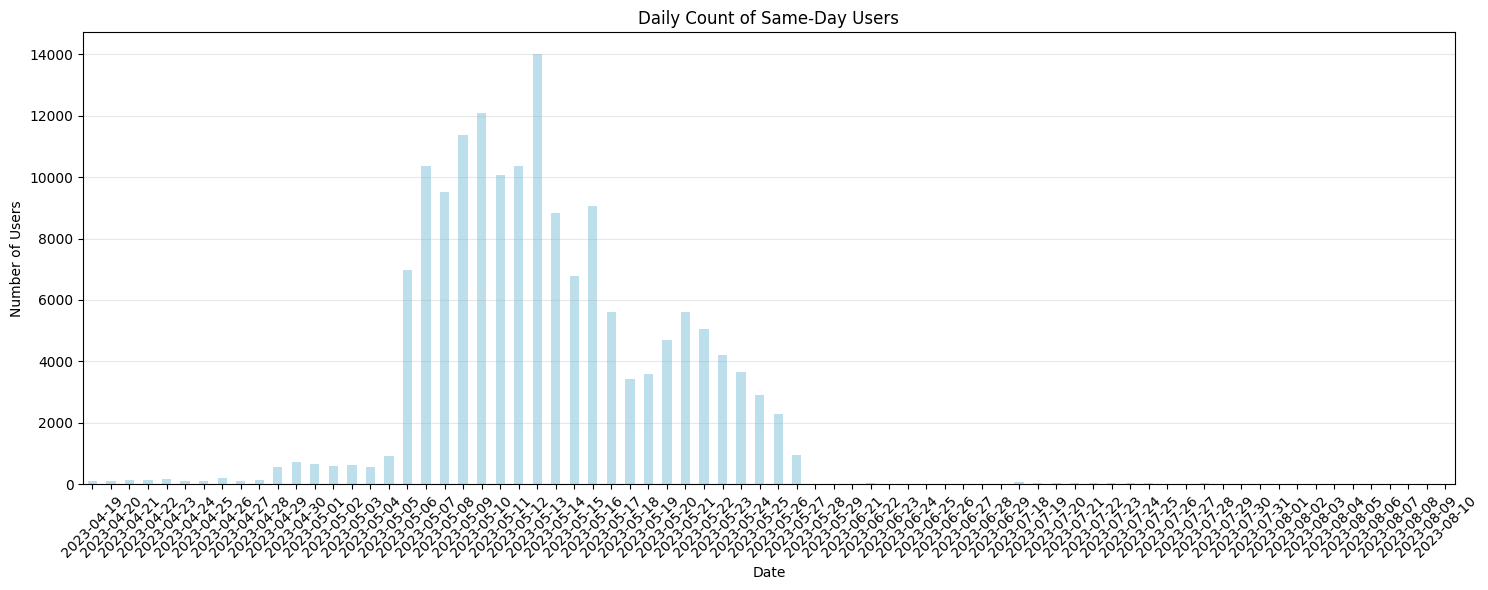

Ï¥ù 158,096Î™ÖÏùò ÏùºÎ≥Ñ Î∂ÑÌè¨


In [22]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

def simple_daily_bar_chart():
    """Í∞ÑÎã®Ìïú ÏùºÎ≥Ñ Î∞î Ï∞®Ìä∏"""
    
    print("üìä ÏùºÎ≥Ñ Î∂ÑÌè¨ Í≥ÑÏÇ∞ Ï§ë...")
    
    final_path = 'gs://sprintda05_final_project/final/complete_user_events.parquet'
    df = dd.read_parquet(final_path)
    
    # Í∞Å Ïú†Ï†ÄÎ≥Ñ Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú Ï∞æÍ∏∞
    first_events = df.groupby('user_id').agg({
        'event_datetime': 'min',
        'signup_date': 'first'
    }).compute()
    
    # ÎÇ†ÏßúÎßå Ï∂îÏ∂ú
    first_events['first_event_date'] = first_events['event_datetime'].dt.date
    first_events['signup_date_only'] = first_events['signup_date'].dt.date
    
    # Í∞ÄÏûÖÎÇ†ÏßúÏôÄ Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†ÏßúÍ∞Ä Í∞ôÏùÄ ÏÇ¨Ïö©ÏûêÎßå ÌïÑÌÑ∞ÎßÅ
    same_date_users = first_events[
        first_events['first_event_date'] == first_events['signup_date_only']
    ]
    
    # ÏùºÎ≥Ñ Î∂ÑÌè¨ Í≥ÑÏÇ∞
    daily_count = same_date_users['signup_date_only'].value_counts().sort_index()
    
    # Î∞î Ï∞®Ìä∏ Í∑∏Î¶¨Í∏∞
    plt.figure(figsize=(15, 6))
    daily_count.plot(kind='bar', color='lightblue', alpha=0.8)
    plt.title('Daily Count of Same-Day Users')
    plt.xlabel('Date')
    plt.ylabel('Number of Users')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Ï¥ù {len(same_date_users):,}Î™ÖÏùò ÏùºÎ≥Ñ Î∂ÑÌè¨")

# Ïã§Ìñâ
simple_daily_bar_chart()

In [17]:
import dask.dataframe as dd

def print_daily_counts():
    """ÏùºÎ≥Ñ Ïù∏ÏõêÏàò ÌîÑÎ¶∞Ìä∏"""
    
    print("üìä ÏùºÎ≥Ñ Î∂ÑÌè¨ Í≥ÑÏÇ∞ Ï§ë...")
    
    final_path = 'gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet'
    df = dd.read_parquet(final_path)
    
    # Í∞Å Ïú†Ï†ÄÎ≥Ñ Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú Ï∞æÍ∏∞
    first_events = df.groupby('user_id').agg({
        'event_datetime': 'min',
        'signup_date': 'first'
    }).compute()
    
    # ÎÇ†ÏßúÎßå Ï∂îÏ∂ú
    first_events['first_event_date'] = first_events['event_datetime'].dt.date
    first_events['signup_date_only'] = first_events['signup_date'].dt.date
    
    # Í∞ÄÏûÖÎÇ†ÏßúÏôÄ Ï≤´ Ïù¥Î≤§Ìä∏ ÎÇ†ÏßúÍ∞Ä Í∞ôÏùÄ ÏÇ¨Ïö©ÏûêÎßå ÌïÑÌÑ∞ÎßÅ
    same_date_users = first_events[
        first_events['first_event_date'] == first_events['signup_date_only']
    ]
    
    # ÏùºÎ≥Ñ Î∂ÑÌè¨ Í≥ÑÏÇ∞
    daily_count = same_date_users['signup_date_only'].value_counts().sort_index()
    
    # ÏùºÎ≥Ñ Ïù∏ÏõêÏàò ÌîÑÎ¶∞Ìä∏
    print(f"\nüìÖ ÏùºÎ≥Ñ ÎèôÏùºÎÇ†Ïßú ÏÇ¨Ïö©Ïûê Ïàò:")
    for date, count in daily_count.items():
        print(f"{date}: {count:,}Î™Ö")

# Ïã§Ìñâ
print_daily_counts()

üìä ÏùºÎ≥Ñ Î∂ÑÌè¨ Í≥ÑÏÇ∞ Ï§ë...

üìÖ ÏùºÎ≥Ñ ÎèôÏùºÎÇ†Ïßú ÏÇ¨Ïö©Ïûê Ïàò:
2023-04-01: 3Î™Ö
2023-04-04: 1Î™Ö
2023-04-07: 1Î™Ö
2023-04-08: 2Î™Ö
2023-04-12: 3Î™Ö
2023-04-13: 1Î™Ö
2023-04-16: 2Î™Ö
2023-04-19: 101Î™Ö
2023-04-20: 97Î™Ö
2023-04-21: 132Î™Ö
2023-04-22: 133Î™Ö
2023-04-23: 170Î™Ö
2023-04-24: 97Î™Ö
2023-04-25: 122Î™Ö
2023-04-26: 215Î™Ö
2023-04-27: 119Î™Ö
2023-04-28: 135Î™Ö
2023-04-29: 548Î™Ö
2023-04-30: 731Î™Ö
2023-05-01: 647Î™Ö
2023-05-02: 597Î™Ö
2023-05-03: 611Î™Ö
2023-05-04: 560Î™Ö
2023-05-05: 914Î™Ö
2023-05-06: 6,961Î™Ö
2023-05-07: 10,353Î™Ö
2023-05-08: 9,531Î™Ö
2023-05-09: 11,379Î™Ö
2023-05-10: 12,095Î™Ö
2023-05-11: 10,067Î™Ö
2023-05-12: 10,354Î™Ö
2023-05-13: 14,015Î™Ö
2023-05-14: 8,838Î™Ö
2023-05-15: 6,768Î™Ö
2023-05-16: 9,067Î™Ö
2023-05-17: 5,599Î™Ö
2023-05-18: 3,443Î™Ö
2023-05-19: 3,582Î™Ö
2023-05-20: 4,702Î™Ö
2023-05-21: 5,610Î™Ö
2023-05-22: 5,043Î™Ö
2023-05-23: 4,219Î™Ö
2023-05-24: 3,647Î™Ö
2023-05-25: 2,913Î™Ö
2023-05-26: 2,288Î™Ö
2023-05-27: 957Î™Ö
2023-05-28: 10Î™Ö
20

## ÌöåÏõêÍ∞ÄÏûÖ Ïù¥ÌõÑ Ï£ºÎ°ú Ïñ¥ÎîîÎ°ú Ìñ•ÌïòÎäîÏßÄ ÌçºÎÑê ÏãúÍ∞ÅÌôî?

Îπ†Î•∏ ÌÖåÏä§Ìä∏ Ïã§Ìñâ...
üöÄ Îπ†Î•∏ ÌçºÎÑê Î∂ÑÏÑù
ÏÉòÌîå Îç∞Ïù¥ÌÑ∞: 46,801Í±¥

Î∂ÑÏÑù ÏÇ¨Ïö©Ïûê: 35261Î™Ö
ÏÉÅÏúÑ Ïù¥Î≤§Ìä∏:
  $session_start: 8264Î™Ö (23.4%)
  $session_end: 5327Î™Ö (15.1%)
  view_home_tap: 2307Î™Ö (6.5%)
  launch_app: 2188Î™Ö (6.2%)
  view_timeline_tap: 2069Î™Ö (5.9%)

Îπ†Î•∏ ÌÖåÏä§Ìä∏ ÏÑ±Í≥µ! Ï†ÑÏ≤¥ Î∂ÑÏÑù Ïã§Ìñâ...
üéØ ÌöåÏõêÍ∞ÄÏûÖ ÌõÑ ÌçºÎÑê Î∂ÑÏÑù (signup_date Í∏∞Ï§Ä)
‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å

üìä Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ
   Ï¥ù Í∞ÄÏûÖ ÏÇ¨Ïö©Ïûê: 226,365Î™Ö
   Î∂ÑÏÑù ÏÉòÌîå: 3,000Î™Ö

üîç ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Î°úÎìú
   ÏÉòÌîå Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞: 622,045Í±¥

üîç Ï≤´ Î≤àÏß∏ Ïù¥Î≤§Ìä∏ Î∂ÑÏÑù

üìà ÌçºÎÑê Î∂ÑÏÑù Í≤∞Í≥º
   Î∂ÑÏÑùÎêú ÏÇ¨Ïö©Ïûê: 3,000Î™Ö
   Í≥†Ïú† Ï≤´ Ïù¥Î≤§Ìä∏: 4Í∞ú

   ÏÉÅÏúÑ Ï≤´ Î≤àÏß∏ Ïù¥Î≤§Ìä∏:
    1. $session_start: 2,723Î™Ö (90.8%)
    2. launch_app: 161Î™Ö (5.4%)
    3. $session_end: 110Î™Ö (3.7%)
    4. button: 6Î™Ö (0.2%)

üìä ÏãúÍ∞ÅÌôî ÏÉùÏÑ±


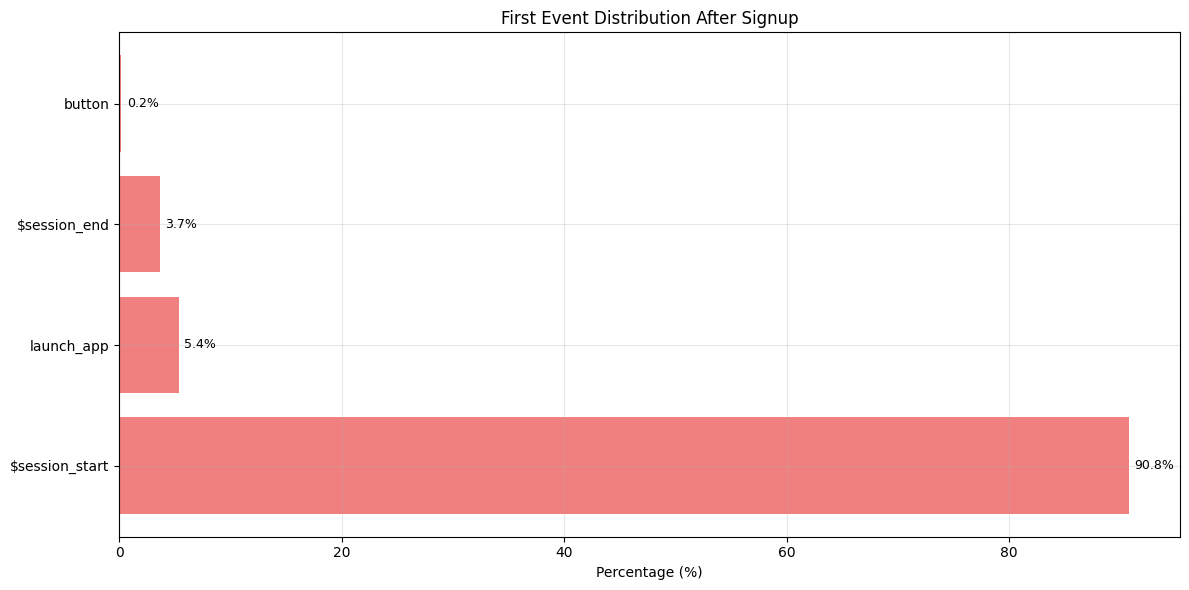

In [21]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_signup_funnel_simple():
    """signup_date Í∏∞Ï§Ä Í∞ÑÎã®Ìïú ÌçºÎÑê Î∂ÑÏÑù"""
    
    print("üéØ ÌöåÏõêÍ∞ÄÏûÖ ÌõÑ ÌçºÎÑê Î∂ÑÏÑù (signup_date Í∏∞Ï§Ä)")
    print("=" * 50)
    
    # ÌïÑÏöîÌïú Ïª¨ÎüºÎßå Î°úÎìú
    try:
        df = dd.read_parquet(
            'gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet',
            columns=['user_id', 'event_datetime', 'event_key', 'signup_date']
        )
        print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")
    except Exception as e:
        print(f"‚ùå Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïã§Ìå®: {e}")
        return None
    
    # 1. signup_dateÍ∞Ä ÏûàÎäî ÏÇ¨Ïö©ÏûêÎßå ÌïÑÌÑ∞ÎßÅ
    print("\nüìä Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ")
    
    # signup_dateÍ∞Ä nullÏù¥ ÏïÑÎãå ÏÇ¨Ïö©ÏûêÎì§ (Î®ºÏ†Ä computeÌï¥ÏÑú pandasÎ°ú Î≥ÄÌôò)
    signup_users_df = df[df['signup_date'].notnull()]['user_id'].drop_duplicates().compute()
    total_signup_users = len(signup_users_df)
    print(f"   Ï¥ù Í∞ÄÏûÖ ÏÇ¨Ïö©Ïûê: {total_signup_users:,}Î™Ö")
    
    # pandasÏóêÏÑú ÏÉòÌîåÎßÅ
    sample_size = min(3000, total_signup_users)  # Îçî ÏûëÏùÄ ÏÉòÌîåÎ°ú ÏãúÏûë
    if total_signup_users > sample_size:
        sample_users = signup_users_df.sample(n=sample_size, random_state=42)
    else:
        sample_users = signup_users_df
    
    print(f"   Î∂ÑÏÑù ÏÉòÌîå: {len(sample_users):,}Î™Ö")
    
    # 2. ÏÉòÌîå ÏÇ¨Ïö©ÏûêÎì§Ïùò Îç∞Ïù¥ÌÑ∞Îßå Í∞ÄÏ†∏Ïò§Í∏∞ (Ìïú Î≤àÏóê)
    print("\nüîç ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Î°úÎìú")
    
    # ÏÉòÌîå ÏÇ¨Ïö©ÏûêÎì§Ïùò Î™®Îì† Ïù¥Î≤§Ìä∏ Í∞ÄÏ†∏Ïò§Í∏∞
    sample_events = df[df['user_id'].isin(sample_users)].compute()
    print(f"   ÏÉòÌîå Ïù¥Î≤§Ìä∏ Îç∞Ïù¥ÌÑ∞: {len(sample_events):,}Í±¥")
    
    # 3. Í∞Å ÏÇ¨Ïö©ÏûêÏùò Ï≤´ Î≤àÏß∏ Ïù¥Î≤§Ìä∏ Ï∞æÍ∏∞
    print("\nüîç Ï≤´ Î≤àÏß∏ Ïù¥Î≤§Ìä∏ Î∂ÑÏÑù")
    
    first_events = []
    
    for user_id in sample_users:
        user_data = sample_events[sample_events['user_id'] == user_id]
        
        if len(user_data) > 0:
            # signup_date Í∞ÄÏ†∏Ïò§Í∏∞
            signup_date = user_data['signup_date'].iloc[0]
            
            # signup_date Ïù¥ÌõÑ Ïù¥Î≤§Ìä∏Îßå ÌïÑÌÑ∞ÎßÅ
            after_signup = user_data[user_data['event_datetime'] >= signup_date]
            
            if len(after_signup) > 0:
                # ÏãúÍ∞ÑÏàú Ï†ïÎ†¨ ÌõÑ Ï≤´ Î≤àÏß∏ Ïù¥Î≤§Ìä∏
                first_event = after_signup.sort_values('event_datetime').iloc[0]['event_key']
                first_events.append(first_event)
    
    # 4. Í≤∞Í≥º Î∂ÑÏÑù
    print(f"\nüìà ÌçºÎÑê Î∂ÑÏÑù Í≤∞Í≥º")
    
    if not first_events:
        print("   ‚ùå Î∂ÑÏÑùÌï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        return None
    
    event_counts = Counter(first_events)
    total = len(first_events)
    
    print(f"   Î∂ÑÏÑùÎêú ÏÇ¨Ïö©Ïûê: {total:,}Î™Ö")
    print(f"   Í≥†Ïú† Ï≤´ Ïù¥Î≤§Ìä∏: {len(event_counts)}Í∞ú")
    
    print("\n   ÏÉÅÏúÑ Ï≤´ Î≤àÏß∏ Ïù¥Î≤§Ìä∏:")
    for i, (event, count) in enumerate(event_counts.most_common(10), 1):
        percentage = (count / total) * 100
        print(f"   {i:2d}. {event}: {count:,}Î™Ö ({percentage:.1f}%)")
    
    # 5. Í∞ÑÎã®Ìïú ÏãúÍ∞ÅÌôî
    print(f"\nüìä ÏãúÍ∞ÅÌôî ÏÉùÏÑ±")
    
    # ÏÉÅÏúÑ 8Í∞úÎßå ÏãúÍ∞ÅÌôî
    top_events = dict(event_counts.most_common(8))
    
    plt.figure(figsize=(12, 6))
    
    events = list(top_events.keys())
    counts = list(top_events.values())
    percentages = [c/total*100 for c in counts]
    
    # Í∞ÄÎ°ú ÎßâÎåÄ Í∑∏ÎûòÌîÑ
    bars = plt.barh(events, percentages, color='lightcoral')
    plt.xlabel('Percentage (%)')
    plt.title('First Event Distribution After Signup')
    plt.grid(True, alpha=0.3)
    
    # ÌçºÏÑºÌä∏ ÌëúÏãú
    for bar, pct in zip(bars, percentages):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_analyzed': total,
        'event_counts': event_counts,
        'top_events': top_events,
        'sample_size': len(sample_users)
    }

# Îçî Í∞ÑÎã®ÌïòÍ≥† ÏïàÏ†ÑÌïú Î≤ÑÏ†Ñ
def quick_signup_funnel():
    """Îß§Ïö∞ Í∞ÑÎã®Ìïú Î≤ÑÏ†Ñ - ÏûëÏùÄ ÏÉòÌîåÎ°ú Îπ†Î•∏ ÌÖåÏä§Ìä∏"""
    
    print("üöÄ Îπ†Î•∏ ÌçºÎÑê Î∂ÑÏÑù")
    print("=" * 30)
    
    try:
        # ÏûëÏùÄ ÏÉòÌîåÎ°ú ÏãúÏûë (frac ÏÇ¨Ïö©)
        df = dd.read_parquet(
            'gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet',
            columns=['user_id', 'event_datetime', 'event_key', 'signup_date']
        )
        
        # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò 0.1%Îßå ÏÉòÌîåÎßÅ
        sample_df = df[df['signup_date'].notnull()].sample(frac=0.001).compute()
        print(f"ÏÉòÌîå Îç∞Ïù¥ÌÑ∞: {len(sample_df):,}Í±¥")
        
        first_events = []
        
        for user_id in sample_df['user_id'].unique():
            user_data = sample_df[sample_df['user_id'] == user_id]
            signup_date = user_data['signup_date'].iloc[0]
            
            # signup_date Ïù¥ÌõÑ Ï≤´ Ïù¥Î≤§Ìä∏
            after_signup = user_data[user_data['event_datetime'] >= signup_date]
            
            if len(after_signup) > 0:
                first_event = after_signup.sort_values('event_datetime').iloc[0]['event_key']
                first_events.append(first_event)
        
        # Í≤∞Í≥º Ï∂úÎ†•
        event_counts = Counter(first_events)
        total = len(first_events)
        
        print(f"\nÎ∂ÑÏÑù ÏÇ¨Ïö©Ïûê: {total}Î™Ö")
        print("ÏÉÅÏúÑ Ïù¥Î≤§Ìä∏:")
        
        for event, count in event_counts.most_common(5):
            pct = (count / total) * 100
            print(f"  {event}: {count}Î™Ö ({pct:.1f}%)")
        
        return event_counts
        
    except Exception as e:
        print(f"Ïò§Î•ò Î∞úÏÉù: {e}")
        return None

# Ïã§Ìñâ
if __name__ == "__main__":
    # Î®ºÏ†Ä Îπ†Î•∏ ÌÖåÏä§Ìä∏Î°ú ÏãúÏûë
    print("Îπ†Î•∏ ÌÖåÏä§Ìä∏ Ïã§Ìñâ...")
    quick_result = quick_signup_funnel()
    
    if quick_result:
        print("\n" + "="*50)
        print("Îπ†Î•∏ ÌÖåÏä§Ìä∏ ÏÑ±Í≥µ! Ï†ÑÏ≤¥ Î∂ÑÏÑù Ïã§Ìñâ...")
        result = analyze_signup_funnel_simple()
    else:
        print("Îπ†Î•∏ ÌÖåÏä§Ìä∏ Ïã§Ìå®. Ïó∞Í≤∞ Î¨∏Ï†úÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")

In [18]:
import pandas as pd
import dask.dataframe as dd
from datetime import timedelta

def check_event_gaps():
    """Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú Í∞≠ Í∞ÑÎã® ÌôïÏù∏"""
    
    print("üìÖ Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú Í∞≠ ÌôïÏù∏")
    print("=" * 40)
    
    # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    df = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')
    
    # ÎÇ†Ïßú Î≤îÏúÑ
    min_date = df['event_datetime'].min().compute()
    max_date = df['event_datetime'].max().compute()
    total_days = (max_date.date() - min_date.date()).days + 1
    
    print(f"üìä Í∏∞Í∞Ñ: {min_date.date()} ~ {max_date.date()} ({total_days}Ïùº)")
    
    # ÎÇ†ÏßúÎ≥Ñ Ïù¥Î≤§Ìä∏ Ïàò
    daily_events = df.groupby(df['event_datetime'].dt.date)['user_id'].count().compute()
    event_days = len(daily_events)
    missing_days = total_days - event_days
    
    print(f"üìà Ïù¥Î≤§Ìä∏ ÏûàÎäî ÎÇ†: {event_days}Ïùº")
    print(f"üï≥Ô∏è  Ïù¥Î≤§Ìä∏ ÏóÜÎäî ÎÇ†: {missing_days}Ïùº")
    print(f"üìä Ïª§Î≤ÑÎ¶¨ÏßÄ: {(event_days/total_days*100):.1f}%")
    
    if missing_days == 0:
        print("‚úÖ Í∞≠ ÏóÜÏùå - Î™®Îì† ÎÇ†ÏßúÏóê Ïù¥Î≤§Ìä∏ Ï°¥Ïû¨")
        return
    
    # Ï†ÑÏ≤¥ ÎÇ†Ïßú Î≤îÏúÑ ÏÉùÏÑ±
    date_range = pd.date_range(start=min_date.date(), end=max_date.date(), freq='D')
    event_dates = set(daily_events.index)
    missing_dates = sorted([d.date() for d in date_range if d.date() not in event_dates])
    
    # Ïó∞ÏÜçÎêú Í∞≠ Ï∞æÍ∏∞
    print(f"\nüîç Í∞≠ Î∂ÑÏÑù ({len(missing_dates)}Í∞ú ÎÇ†Ïßú)")
    gaps = []
    
    if missing_dates:
        start = missing_dates[0]
        end = missing_dates[0]
        
        for i in range(1, len(missing_dates)):
            if missing_dates[i] == end + timedelta(days=1):
                end = missing_dates[i]
            else:
                days = (end - start).days + 1
                gaps.append((start, end, days))
                start = missing_dates[i]
                end = missing_dates[i]
        
        # ÎßàÏßÄÎßâ Í∞≠
        days = (end - start).days + 1
        gaps.append((start, end, days))
    
    # Í∞≠ Ï∂úÎ†•
    print(f"üìã Ï¥ù {len(gaps)}Í∞ú Í∞≠:")
    for i, (start, end, days) in enumerate(gaps, 1):
        if days == 1:
            print(f"   {i:2d}. {start} (1Ïùº)")
        else:
            print(f"   {i:2d}. {start} ~ {end} ({days}Ïùº)")
    
    # Í∏¥ Í∞≠ ÌïòÏù¥ÎùºÏù¥Ìä∏
    long_gaps = [(s, e, d) for s, e, d in gaps if d >= 7]
    if long_gaps:
        print(f"\n‚ö†Ô∏è  ÏùºÏ£ºÏùº Ïù¥ÏÉÅ Í∏¥ Í∞≠ ({len(long_gaps)}Í∞ú):")
        for start, end, days in sorted(long_gaps, key=lambda x: x[2], reverse=True):
            print(f"   ‚Ä¢ {start} ~ {end}: {days}Ïùº")

# Ïã§Ìñâ
check_event_gaps()

üìÖ Ïù¥Î≤§Ìä∏ ÎÇ†Ïßú Í∞≠ ÌôïÏù∏
üìä Í∏∞Í∞Ñ: 2023-04-01 ~ 2023-09-21 (174Ïùº)
üìà Ïù¥Î≤§Ìä∏ ÏûàÎäî ÎÇ†: 131Ïùº
üï≥Ô∏è  Ïù¥Î≤§Ìä∏ ÏóÜÎäî ÎÇ†: 43Ïùº
üìä Ïª§Î≤ÑÎ¶¨ÏßÄ: 75.3%

üîç Í∞≠ Î∂ÑÏÑù (43Í∞ú ÎÇ†Ïßú)
üìã Ï¥ù 3Í∞ú Í∞≠:
    1. 2023-04-03 (1Ïùº)
    2. 2023-07-12 ~ 2023-07-17 (6Ïùº)
    3. 2023-08-11 ~ 2023-09-15 (36Ïùº)

‚ö†Ô∏è  ÏùºÏ£ºÏùº Ïù¥ÏÉÅ Í∏¥ Í∞≠ (1Í∞ú):
   ‚Ä¢ 2023-08-11 ~ 2023-09-15: 36Ïùº


In [24]:
import dask.dataframe as dd

def check_may_1st_logs():
    """5Ïõî 1Ïùº Î°úÍ∑∏ ÌôïÏù∏"""
    
    print("üîç 2023-05-01 Î°úÍ∑∏ ÌôïÏù∏ Ï§ë...")
    
    final_path = 'gs://sprintda05_final_project/final/complete_user_events.parquet'
    df = dd.read_parquet(final_path)
    
    # 5Ïõî 1Ïùº Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    df['event_date'] = df['event_datetime'].dt.date
    may_1st = df[df['event_date'] == pd.to_datetime('2023-05-01').date()]
    
    if may_1st.map_partitions(len).sum().compute() > 0:
        may_1st_data = may_1st.compute()
        
        print(f"üìÖ 2023-05-01 Ï¥ù Ïù¥Î≤§Ìä∏ Ïàò: {len(may_1st_data):,}Í∞ú")
        print(f"üìÖ 2023-05-01 Í≥†Ïú† ÏÇ¨Ïö©Ïûê Ïàò: {may_1st_data['user_id'].nunique():,}Î™Ö")
        
        # Ïù¥Î≤§Ìä∏ Ï¢ÖÎ•òÎ≥Ñ Í∞úÏàò
        print(f"\nüéØ Ïù¥Î≤§Ìä∏ Ï¢ÖÎ•òÎ≥Ñ Í∞úÏàò:")
        event_counts = may_1st_data['event_key'].value_counts()
        for event, count in event_counts.items():
            print(f"   {event}: {count:,}Í∞ú")
        
        # ÏãúÍ∞ÑÎåÄÎ≥Ñ Î∂ÑÌè¨
        print(f"\n‚è∞ ÏãúÍ∞ÑÎåÄÎ≥Ñ Î∂ÑÌè¨:")
        may_1st_data['hour'] = may_1st_data['event_datetime'].dt.hour
        hourly_counts = may_1st_data['hour'].value_counts().sort_index()
        for hour, count in hourly_counts.items():
            print(f"   {hour:02d}Ïãú: {count:,}Í∞ú")
        
        # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Î™á Í∞ú Î≥¥Í∏∞
        print(f"\nüìã ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ (Ï≤òÏùå 10Í∞ú):")
        sample_data = may_1st_data[['user_id', 'event_datetime', 'event_key']].head(10)
        for _, row in sample_data.iterrows():
            print(f"   {row['event_datetime']} | {row['event_key']} | User {row['user_id']}")
            
    else:
        print("‚ùå 2023-05-01ÏóêÎäî Î°úÍ∑∏Í∞Ä ÏóÜÏäµÎãàÎã§.")

# Ïã§Ìñâ
import pandas as pd
check_may_1st_logs()

üîç 2023-05-01 Î°úÍ∑∏ ÌôïÏù∏ Ï§ë...
üìÖ 2023-05-01 Ï¥ù Ïù¥Î≤§Ìä∏ Ïàò: 549,158Í∞ú
üìÖ 2023-05-01 Í≥†Ïú† ÏÇ¨Ïö©Ïûê Ïàò: 3,472Î™Ö

üéØ Ïù¥Î≤§Ìä∏ Ï¢ÖÎ•òÎ≥Ñ Í∞úÏàò:
   button: 527,862Í∞ú
   $session_start: 10,904Í∞ú
   $session_end: 10,392Í∞ú

‚è∞ ÏãúÍ∞ÑÎåÄÎ≥Ñ Î∂ÑÌè¨:
   00Ïãú: 40,883Í∞ú
   01Ïãú: 24,695Í∞ú
   02Ïãú: 12,330Í∞ú
   03Ïãú: 4,988Í∞ú
   04Ïãú: 2,912Í∞ú
   05Ïãú: 2,066Í∞ú
   06Ïãú: 8,300Í∞ú
   07Ïãú: 20,507Í∞ú
   08Ïãú: 15,313Í∞ú
   09Ïãú: 11,966Í∞ú
   10Ïãú: 12,478Í∞ú
   11Ïãú: 13,537Í∞ú
   12Ïãú: 19,551Í∞ú
   13Ïãú: 21,823Í∞ú
   14Ïãú: 22,272Í∞ú
   15Ïãú: 22,232Í∞ú
   16Ïãú: 27,151Í∞ú
   17Ïãú: 31,615Í∞ú
   18Ïãú: 30,909Í∞ú
   19Ïãú: 31,164Í∞ú
   20Ïãú: 36,785Í∞ú
   21Ïãú: 40,446Í∞ú
   22Ïãú: 46,653Í∞ú
   23Ïãú: 48,582Í∞ú

üìã ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ (Ï≤òÏùå 10Í∞ú):
   2023-05-01 00:09:55.885000 | button | User 860971.0
   2023-05-01 00:14:39.952000 | button | User 860971.0
   2023-05-01 00:14:42.802000 | button | User 860971.0
   2023-05-01 00:14:45.234000 | button | User 860971

In [18]:
import dask.dataframe as dd

def count_users():
    """ÏÇ¨Ïö©Ïûê ÏàòÏôÄ Ïª¨Îüº Ï†ïÎ≥¥"""
    
    result = dd.read_parquet('gs://sprintda05_final_project/tmp/user_event_mapping_with_device.parquet')
    
    print("Ïª¨Îüº:", list(result.columns))
    
    print("Í≥ÑÏÇ∞ Ï§ë...")
    unique_users = result['user_id'].nunique().compute()
    print(f"ÏÇ¨Ïö©Ïûê Ïàò: {unique_users:,}Î™Ö")
    
    return unique_users

count_users()

Ïª¨Îüº: ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']
Í≥ÑÏÇ∞ Ï§ë...
ÏÇ¨Ïö©Ïûê Ïàò: 226,365Î™Ö


226365

In [10]:
import dask.dataframe as dd

def debug_mapping():
    """Îß§Ìïë Í≥ºÏ†ï ÎîîÎ≤ÑÍπÖ"""
    
    print("üîç Îß§Ìïë Í≥ºÏ†ï ÎîîÎ≤ÑÍπÖ...")
    
    # 1. Í∞Å Îã®Í≥ÑÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò ÌôïÏù∏
    print("üìä Í∞Å ÌÖåÏù¥Î∏î ÌÅ¨Í∏∞ ÌôïÏù∏...")
    
    accounts = dd.read_parquet(
        'gs://sprintda05_final_project/processed/accounts_user_processed.parquet',
        columns=['id']
    )
    print(f"   accounts_user: {len(accounts):,}Î™Ö")
    
    properties = dd.read_parquet(
        'gs://sprintda05_final_project/hackle/hackle_properties.parquet'
    )
    print(f"   hackle_properties: {len(properties):,}Í∞ú")
    
    events = dd.read_parquet(
        'gs://sprintda05_final_project/hackle/hackle_events.parquet'
    )
    print(f"   hackle_events: {len(events):,}Í∞ú")
    
    # 2. hackle_propertiesÏùò user_id ÏÉÅÌÉú ÌôïÏù∏
    print("\nüîç hackle_properties.user_id ÏÉÅÌÉú ÌôïÏù∏...")
    props_sample = properties.head(1000)
    
    print(f"   Ï†ÑÏ≤¥ ÏÉòÌîå: {len(props_sample)}Í∞ú")
    print(f"   user_id ÎπÑÏñ¥ÏûàÏùå: {props_sample['user_id'].isna().sum()}Í∞ú")
    print(f"   user_id Îπà Î¨∏ÏûêÏó¥: {(props_sample['user_id'] == '').sum()}Í∞ú")
    print(f"   user_id Ïú†Ìö®Ìïú Í∞í: {props_sample['user_id'].notna().sum()}Í∞ú")
    
    # Ïú†Ìö®Ìïú user_idÎì§ ÌôïÏù∏
    valid_user_ids = props_sample[props_sample['user_id'].notna() & (props_sample['user_id'] != '')]
    print(f"   Ïú†Ìö®Ìïú user_id ÏÉòÌîå: {valid_user_ids['user_id'].head(10).tolist()}")
    
    # 3. session_id Îß§Ïπ≠ ÌôïÏù∏
    print("\nüîó session_id Îß§Ïπ≠ ÌôïÏù∏...")
    events_sessions = set(events.head(1000)['session_id'].tolist())
    props_sessions = set(props_sample['session_id'].tolist())
    
    common_sessions = events_sessions & props_sessions
    print(f"   events session_id ÏÉòÌîå: {len(events_sessions)}Í∞ú")
    print(f"   properties session_id ÏÉòÌîå: {len(props_sessions)}Í∞ú")
    print(f"   Í≥µÌÜµ session_id: {len(common_sessions)}Í∞ú")
    
    # 4. Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú Ïã§Ï†ú Îß§Ìïë Í∞úÏàò ÌôïÏù∏
    print("\nüìä Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú Îß§Ìïë Í∞úÏàò ÌôïÏù∏...")
    
    # propertiesÏóêÏÑú Ïú†Ìö®Ìïú user_idÎßå ÌïÑÌÑ∞ÎßÅ
    properties_clean = properties.dropna(subset=['user_id'])
    properties_clean = properties_clean[properties_clean['user_id'] != '']
    print(f"   Ïú†Ìö®Ìïú properties: {len(properties_clean):,}Í∞ú")
    
    # Ï≤´ Î≤àÏß∏ Ï°∞Ïù∏ ÌÖåÏä§Ìä∏
    step1 = events.merge(properties_clean, on='session_id', how='inner')
    print(f"   1Îã®Í≥Ñ Ï°∞Ïù∏ Í≤∞Í≥º: {len(step1):,}Í∞ú")
    
    return step1

# ÎîîÎ≤ÑÍπÖ Ïã§Ìñâ
debug_result = debug_mapping()

üîç Îß§Ìïë Í≥ºÏ†ï ÎîîÎ≤ÑÍπÖ...
üìä Í∞Å ÌÖåÏù¥Î∏î ÌÅ¨Í∏∞ ÌôïÏù∏...
   accounts_user: 677,085Î™Ö
   hackle_properties: 525,350Í∞ú
   hackle_events: 11,441,319Í∞ú

üîç hackle_properties.user_id ÏÉÅÌÉú ÌôïÏù∏...
   Ï†ÑÏ≤¥ ÏÉòÌîå: 1000Í∞ú
   user_id ÎπÑÏñ¥ÏûàÏùå: 0Í∞ú
   user_id Îπà Î¨∏ÏûêÏó¥: 22Í∞ú
   user_id Ïú†Ìö®Ìïú Í∞í: 1000Í∞ú
   Ïú†Ìö®Ìïú user_id ÏÉòÌîå: ['1046711', '1545130', '1224793', '1329450', 'LztzUUFoRxdqTSPgQrX3MAAyNkM2', '1018001', '1475326', '1142761', '1537177', '1159545']

üîó session_id Îß§Ïπ≠ ÌôïÏù∏...
   events session_id ÏÉòÌîå: 986Í∞ú
   properties session_id ÏÉòÌîå: 998Í∞ú
   Í≥µÌÜµ session_id: 986Í∞ú

üìä Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú Îß§Ìïë Í∞úÏàò ÌôïÏù∏...
   Ïú†Ìö®Ìïú properties: 443,095Í∞ú
   1Îã®Í≥Ñ Ï°∞Ïù∏ Í≤∞Í≥º: 24,557,709Í∞ú


In [8]:
import dask.dataframe as dd

def check_numeric_user_id():
    """Ïà´Ïûê ÌòïÌÉú user_id Ï∞æÍ∏∞"""
    
    print("üîç Ïà´Ïûê ÌòïÌÉú user_id Ï∞æÍ∏∞...")
    
    # 1. hackle_eventsÏùò Î™®Îì† Ïª¨Îüº ÌôïÏù∏
    print("üìã hackle_events Ïª¨Îüº ÏÉÅÏÑ∏ ÌôïÏù∏...")
    events = dd.read_parquet('gs://sprintda05_final_project/hackle/hackle_events.parquet')
    
    sample = events.head()
    print("Ï†ÑÏ≤¥ Ïª¨ÎüºÍ≥º ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:")
    for col in events.columns:
        print(f"  {col}: {sample[col].iloc[0]} (ÌÉÄÏûÖ: {sample[col].dtype})")
    
    # 2. hackle_propertiesÎèÑ ÌôïÏù∏
    print("\nüìä hackle_properties Ïª¨Îüº ÌôïÏù∏...")
    properties = dd.read_parquet('gs://sprintda05_final_project/hackle/hackle_properties.parquet')
    
    prop_sample = properties.head()
    print("properties Ïª¨ÎüºÍ≥º ÏÉòÌîå:")
    for col in properties.columns:
        print(f"  {col}: {prop_sample[col].iloc[0]} (ÌÉÄÏûÖ: {prop_sample[col].dtype})")
    
    return sample, prop_sample

# Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌôïÏù∏
events_sample, props_sample = check_numeric_user_id()

üîç Ïà´Ïûê ÌòïÌÉú user_id Ï∞æÍ∏∞...
üìã hackle_events Ïª¨Îüº ÏÉÅÏÑ∏ ÌôïÏù∏...
Ï†ÑÏ≤¥ Ïª¨ÎüºÍ≥º ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:
  event_id: 00000533-3f1c-4b3b-81f1-0c8f35754b4e (ÌÉÄÏûÖ: string)
  event_datetime: 2023-07-18 19:40:17 (ÌÉÄÏûÖ: datetime64[ms])
  event_key: $session_start (ÌÉÄÏûÖ: string)
  session_id: 4OzYh3seq3VKytpSn5pvQkZNQii1 (ÌÉÄÏûÖ: string)
  id: 00000533-3f1c-4b3b-81f1-0c8f35754b4e (ÌÉÄÏûÖ: string)
  item_name:  (ÌÉÄÏûÖ: string)
  page_name:  (ÌÉÄÏûÖ: string)
  friend_count: nan (ÌÉÄÏûÖ: float64)
  votes_count: nan (ÌÉÄÏûÖ: float64)
  heart_balance: nan (ÌÉÄÏûÖ: float64)
  question_id: nan (ÌÉÄÏûÖ: float64)

üìä hackle_properties Ïª¨Îüº ÌôïÏù∏...
properties Ïª¨ÎüºÍ≥º ÏÉòÌîå:
  id: 1 (ÌÉÄÏûÖ: int64)
  session_id: 4OzYh3seq3VKytpSn5pvQkZNQii1 (ÌÉÄÏûÖ: string)
  user_id:  (ÌÉÄÏûÖ: string)
  language: ko-KR (ÌÉÄÏûÖ: string)
  osname: iOS (ÌÉÄÏûÖ: string)
  osversion: 16.0 (ÌÉÄÏûÖ: string)
  versionname: 2.0.0 (ÌÉÄÏûÖ: string)
  device_id: 590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74 (ÌÉÄÏû

In [13]:
import dask.dataframe as dd
import tempfile
import os
import pandas as pd

# ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
temp_dir = tempfile.mkdtemp()

# 1. hackleÏóêÏÑú 6~7ÏûêÎ¶¨ Ïà´Ïûê Ï∂îÏ∂ú
hackle_temp = os.path.join(temp_dir, 'hackle.parquet')
with gcs_fs.open('sprintda05_final_project/normalized/hackle/2023-09-15/hackle_events.parquet', 'rb') as src:
   with open(hackle_temp, 'wb') as dst:
       dst.write(src.read())

hackle_df = dd.read_parquet(hackle_temp, columns=['user_id'])
hackle_user_ids = hackle_df['user_id'].compute()

# 6~7ÏûêÎ¶¨ Ïà´ÏûêÎßå ÌïÑÌÑ∞ÎßÅ
hackle_numbers = hackle_user_ids[hackle_user_ids.apply(lambda x: str(x).isdigit() and len(str(x)) in [6, 7] if not pd.isna(x) else False)]

# 2. accountsÏóêÏÑú id Ï∂îÏ∂ú
accounts_temp = os.path.join(temp_dir, 'accounts.parquet')
with gcs_fs.open('sprintda05_final_project/processed/accounts_user_processed.parquet', 'rb') as src:
   with open(accounts_temp, 'wb') as dst:
       dst.write(src.read())

accounts_df = dd.read_parquet(accounts_temp, columns=['id'])
accounts_ids = accounts_df['id'].compute()

# 3. ÍµêÏßëÌï© Í≥ÑÏÇ∞
hackle_set = set(hackle_numbers.astype(str))
accounts_set = set(accounts_ids.astype(str))
intersection = hackle_set & accounts_set

print(f"Í≤πÏπòÎäî Í∞í: {len(intersection)}Í∞ú")

# Ï†ïÎ¶¨
os.remove(hackle_temp)
os.remove(accounts_temp)
os.rmdir(temp_dir)

Í≤πÏπòÎäî Í∞í: 103634Í∞ú


In [16]:
import dask.dataframe as dd
import tempfile
import os

# ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨
temp_dir = tempfile.mkdtemp()

# ÌååÏùº 1: 2023-05-12 (Î™®Îì† user_idÍ∞Ä NULL)
print("üìÅ 2023-05-12.parquet Îã§Ïö¥Î°úÎìú...")
temp_file_0512 = os.path.join(temp_dir, 'temp_0512.parquet')
with gcs_fs.open('sprintda05_final_project/parquet/hackle/2023-05-12.parquet', 'rb') as src:
    with open(temp_file_0512, 'wb') as dst:
        dst.write(src.read())

# ÌååÏùº 2: 2023-06-17 (Firebase UID ÏûàÏùå)
print("üìÅ 2023-06-17.parquet Îã§Ïö¥Î°úÎìú...")
temp_file_0617 = os.path.join(temp_dir, 'temp_0617.parquet')
with gcs_fs.open('sprintda05_final_project/parquet/hackle/2023-06-17.parquet', 'rb') as src:
    with open(temp_file_0617, 'wb') as dst:
        dst.write(src.read())

# device_id Ï∂îÏ∂ú
print("\nüîç device_id Ï∂îÏ∂ú Ï§ë...")

# 05-12 device_id (user_idÍ∞Ä Î™®Îëê NULLÏù∏ ÎÇ†)
df_0512 = dd.read_parquet(temp_file_0512, columns=['device_id'])
devices_0512 = df_0512['device_id'].dropna().unique().compute()
print(f"05-12 Ïú†ÎãàÌÅ¨ device_id: {len(devices_0512):,}Í∞ú")

# 06-17 device_id (user_idÍ∞Ä ÏûàÎäî ÎÇ†)  
df_0617 = dd.read_parquet(temp_file_0617, columns=['device_id'])
devices_0617 = df_0617['device_id'].dropna().unique().compute()
print(f"06-17 Ïú†ÎãàÌÅ¨ device_id: {len(devices_0617):,}Í∞ú")

# ÍµêÏßëÌï© Í≥ÑÏÇ∞
devices_0512_set = set(devices_0512)
devices_0617_set = set(devices_0617)
common_devices = devices_0512_set & devices_0617_set

print(f"\nüìä device_id ÎπÑÍµê Í≤∞Í≥º:")
print("=" * 50)
print(f"üîπ 05-12ÏóêÎßå ÏûàÎäî device: {len(devices_0512_set - devices_0617_set):,}Í∞ú")
print(f"üîπ 06-17ÏóêÎßå ÏûàÎäî device: {len(devices_0617_set - devices_0512_set):,}Í∞ú")
print(f"üîπ Îëò Îã§ ÏûàÎäî device: {len(common_devices):,}Í∞ú")

if len(common_devices) > 0:
    overlap_rate_0512 = len(common_devices) / len(devices_0512_set) * 100
    overlap_rate_0617 = len(common_devices) / len(devices_0617_set) * 100
    
    print(f"\nüéØ Í≤πÏπòÎäî ÎπÑÏú®:")
    print(f"   05-12 Í∏∞Ï§Ä: {overlap_rate_0512:.1f}%")
    print(f"   06-17 Í∏∞Ï§Ä: {overlap_rate_0617:.1f}%")
    
    # ÏÉòÌîå device_id Ï∂úÎ†•
    sample_devices = list(common_devices)[:5]
    print(f"\nüì± Í≤πÏπòÎäî device_id ÏÉòÌîå:")
    for i, device in enumerate(sample_devices, 1):
        print(f"   {i}. {device}")

# Ï†ïÎ¶¨
os.remove(temp_file_0512)
os.remove(temp_file_0617)
os.rmdir(temp_dir)

üìÅ 2023-05-12.parquet Îã§Ïö¥Î°úÎìú...
üìÅ 2023-06-17.parquet Îã§Ïö¥Î°úÎìú...

üîç device_id Ï∂îÏ∂ú Ï§ë...
05-12 Ïú†ÎãàÌÅ¨ device_id: 525,224Í∞ú
06-17 Ïú†ÎãàÌÅ¨ device_id: 138,916Í∞ú

üìä device_id ÎπÑÍµê Í≤∞Í≥º:
üîπ 05-12ÏóêÎßå ÏûàÎäî device: 439,291Í∞ú
üîπ 06-17ÏóêÎßå ÏûàÎäî device: 52,983Í∞ú
üîπ Îëò Îã§ ÏûàÎäî device: 85,933Í∞ú

üéØ Í≤πÏπòÎäî ÎπÑÏú®:
   05-12 Í∏∞Ï§Ä: 16.4%
   06-17 Í∏∞Ï§Ä: 61.9%

üì± Í≤πÏπòÎäî device_id ÏÉòÌîå:
   1. b'\x14\x07A6\xce\xbaI\xa6\x87\xbc\x89\x9ai\xa8\x91q'
   2. b'-\xc0;\xe2[\xfdA\x82\x90\xfaN\x8f\xb43N\xcc'
   3. b'\x00\xcb\xaaP\x0cHJ\xcf\xb8\x83\xa0\xd2\n\xf6j\xe1'
   4. b'\xd4\xfc\xe0:\x8e#@\xcf\xa3\x9e*A\x01\xd9\xae|'
   5. b'\xdd\xf2\x8f\x82\xad\xe2J\xfe\x98Z\x13^\xd8\x8a#\r'


In [18]:
import dask.dataframe as dd
import tempfile
import os

# ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨
temp_dir = tempfile.mkdtemp()

# ÏÑ∏ ÌååÏùº Îã§Ïö¥Î°úÎìú
files = {
    '0512': 'sprintda05_final_project/parquet/hackle/2023-05-12.parquet',
    '0617': 'sprintda05_final_project/parquet/hackle/2023-06-17.parquet', 
    '0915': 'sprintda05_final_project/parquet/hackle/2023-09-15.parquet'
}

temp_files = {}
device_sets = {}

for date, path in files.items():
    print(f"üìÅ {date} Îã§Ïö¥Î°úÎìú...")
    temp_file = os.path.join(temp_dir, f'temp_{date}.parquet')
    
    with gcs_fs.open(path, 'rb') as src:
        with open(temp_file, 'wb') as dst:
            dst.write(src.read())
    
    temp_files[date] = temp_file
    
    # device_id Ï∂îÏ∂ú
    df = dd.read_parquet(temp_file, columns=['device_id'])
    devices = df['device_id'].dropna().unique().compute()
    device_sets[date] = set(devices)
    
    print(f"   Ïú†ÎãàÌÅ¨ device_id: {len(devices):,}Í∞ú")

print(f"\nüîç ÏÑ∏ ÎÇ†Ïßú device_id ÍµêÏßëÌï© Î∂ÑÏÑù:")
print("=" * 60)

# Í∞Å ÎÇ†ÏßúÎ≥Ñ ÎπÑÍµê
devices_0512 = device_sets['0512']
devices_0617 = device_sets['0617'] 
devices_0915 = device_sets['0915']

# Î™®Îì† ÍµêÏßëÌï© Í≥ÑÏÇ∞
common_all_three = devices_0512 & devices_0617 & devices_0915
common_0512_0617 = devices_0512 & devices_0617
common_0617_0915 = devices_0617 & devices_0915
common_0512_0915 = devices_0512 & devices_0915

print(f"üîπ 05-12Îßå: {len(devices_0512 - devices_0617 - devices_0915):,}Í∞ú")
print(f"üîπ 06-17Îßå: {len(devices_0617 - devices_0512 - devices_0915):,}Í∞ú") 
print(f"üîπ 09-15Îßå: {len(devices_0915 - devices_0512 - devices_0617):,}Í∞ú")
print(f"")
print(f"üî∏ 05-12 & 06-17Îßå: {len(common_0512_0617 - devices_0915):,}Í∞ú")
print(f"üî∏ 06-17 & 09-15Îßå: {len(common_0617_0915 - devices_0512):,}Í∞ú")
print(f"üî∏ 05-12 & 09-15Îßå: {len(common_0512_0915 - devices_0617):,}Í∞ú")
print(f"")
print(f"üèÜ ÏÑ∏ ÎÇ†Ïßú Î™®Îëê: {len(common_all_three):,}Í∞ú")

if len(common_all_three) > 0:
    # ÎπÑÏú® Í≥ÑÏÇ∞
    rate_0512 = len(common_all_three) / len(devices_0512) * 100
    rate_0617 = len(common_all_three) / len(devices_0617) * 100
    rate_0915 = len(common_all_three) / len(devices_0915) * 100
    
    print(f"\nüéØ Î†àÏ†ÑÎìú ÏÇ¨Ïö©Ïûê ÎπÑÏú®:")
    print(f"   05-12 Í∏∞Ï§Ä: {rate_0512:.2f}%")
    print(f"   06-17 Í∏∞Ï§Ä: {rate_0617:.2f}%") 
    print(f"   09-15 Í∏∞Ï§Ä: {rate_0915:.2f}%")
    
    # ÏÉòÌîå Ï∂úÎ†•
    sample_devices = list(common_all_three)[:5]
    print(f"\nüëë Î†àÏ†ÑÎìú device_id ÏÉòÌîå:")
    for i, device in enumerate(sample_devices, 1):
        print(f"   {i}. {device}")
        
    print(f"\nüí° Ïù¥ {len(common_all_three):,}Í∞ú ÎîîÎ∞îÏù¥Ïä§Îäî")
    print(f"   05-12 (ÏùµÎ™Ö) ‚Üí 06-17 (Firebase) ‚Üí 09-15 (Ïà´ÏûêID)")
    print(f"   Î™®Îì† Î≥ÄÌôîÎ•º Í≤™ÏúºÎ©∞ ÏÇ¥ÏïÑÎÇ®ÏùÄ Ï∂©ÏÑ± ÏÇ¨Ïö©ÏûêÎì§ÏûÖÎãàÎã§! üèÖ")

else:
    print(f"\nüò¢ ÏÑ∏ ÎÇ†Ïßú Î™®ÎëêÏóêÏÑú ÌôúÎèôÌïú ÎîîÎ∞îÏù¥Ïä§Îäî ÏóÜÏäµÎãàÎã§.")

# Ï†ïÎ¶¨
for temp_file in temp_files.values():
    os.remove(temp_file)
os.rmdir(temp_dir)

üìÅ 0512 Îã§Ïö¥Î°úÎìú...
   Ïú†ÎãàÌÅ¨ device_id: 525,224Í∞ú
üìÅ 0617 Îã§Ïö¥Î°úÎìú...
   Ïú†ÎãàÌÅ¨ device_id: 138,916Í∞ú
üìÅ 0915 Îã§Ïö¥Î°úÎìú...
   Ïú†ÎãàÌÅ¨ device_id: 121,592Í∞ú

üîç ÏÑ∏ ÎÇ†Ïßú device_id ÍµêÏßëÌï© Î∂ÑÏÑù:
üîπ 05-12Îßå: 387,655Í∞ú
üîπ 06-17Îßå: 39,127Í∞ú
üîπ 09-15Îßå: 29,212Í∞ú

üî∏ 05-12 & 06-17Îßå: 59,045Í∞ú
üî∏ 06-17 & 09-15Îßå: 13,856Í∞ú
üî∏ 05-12 & 09-15Îßå: 51,636Í∞ú

üèÜ ÏÑ∏ ÎÇ†Ïßú Î™®Îëê: 26,888Í∞ú

üéØ Î†àÏ†ÑÎìú ÏÇ¨Ïö©Ïûê ÎπÑÏú®:
   05-12 Í∏∞Ï§Ä: 5.12%
   06-17 Í∏∞Ï§Ä: 19.36%
   09-15 Í∏∞Ï§Ä: 22.11%

üëë Î†àÏ†ÑÎìú device_id ÏÉòÌîå:
   1. b'h\xd9zovjMw\xb0l\x0c Q\xa2\x81H'
   2. b'\xd4\xfc\xe0:\x8e#@\xcf\xa3\x9e*A\x01\xd9\xae|'
   3. b'(\n\xa4\x9c\x12ZE+\xb3\xfe~A\xac\xe0\x8c?'
   4. b'\x14\xb1\x029\x13cG\x9b\x95\x11\xd6\x08\x1c.\x9b\xb1'
   5. b'\x99\xcf\t%`&@\x9b\x86\x03\x99<\xca\xcc\xe8\xa4'

üí° Ïù¥ 26,888Í∞ú ÎîîÎ∞îÏù¥Ïä§Îäî
   05-12 (ÏùµÎ™Ö) ‚Üí 06-17 (Firebase) ‚Üí 09-15 (Ïà´ÏûêID)
   Î™®Îì† Î≥ÄÌôîÎ•º Í≤™ÏúºÎ©∞ ÏÇ¥ÏïÑÎÇ®ÏùÄ Ï∂©ÏÑ± ÏÇ¨Ïö©Ïûê

In [19]:
import dask.dataframe as dd
import tempfile
import os
import pandas as pd

# ÏûÑÏãú ÎîîÎ†âÌÜ†Î¶¨
temp_dir = tempfile.mkdtemp()

# ÏÑ∏ ÌååÏùº Îã§Ïö¥Î°úÎìú
files = {
    '0512': 'sprintda05_final_project/parquet/hackle/2023-05-12.parquet',
    '0617': 'sprintda05_final_project/parquet/hackle/2023-06-17.parquet', 
    '0915': 'sprintda05_final_project/parquet/hackle/2023-09-15.parquet'
}

temp_files = {}
device_user_data = {}

# Í∞Å ÌååÏùºÏóêÏÑú device_idÏôÄ user_id Îß§Ìïë Ï∂îÏ∂ú
for date, path in files.items():
    print(f"üìÅ {date} Ï≤òÎ¶¨ Ï§ë...")
    temp_file = os.path.join(temp_dir, f'temp_{date}.parquet')
    
    with gcs_fs.open(path, 'rb') as src:
        with open(temp_file, 'wb') as dst:
            dst.write(src.read())
    
    temp_files[date] = temp_file
    
    # device_idÏôÄ user_id Ïåç Ï∂îÏ∂ú
    df = dd.read_parquet(temp_file, columns=['device_id', 'user_id'])
    
    # Í∞Å device_idÎ≥ÑÎ°ú Í∞ÄÏû• ÎßéÏù¥ ÎÇòÌÉÄÎÇòÎäî user_id Ï∞æÍ∏∞ (ÎåÄÌëúÍ∞í)
    device_user_pairs = df.groupby('device_id')['user_id'].apply(
        lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else None,
        meta=('user_id', 'object')
    ).compute()
    
    device_user_data[date] = device_user_pairs
    print(f"   device-user Ïåç: {len(device_user_pairs):,}Í∞ú")

print(f"\nüîç Î†àÏ†ÑÎìú ÏÇ¨Ïö©ÏûêÎì§Ïùò Ïã†Ïõê Î≥ÄÌôî Ï∂îÏ†Å:")
print("=" * 70)

# ÏïûÏÑú Íµ¨Ìïú Î†àÏ†ÑÎìú ÎîîÎ∞îÏù¥Ïä§Îì§ (ÍµêÏßëÌï©)
# Í∞ÑÎã®Ìûà Î™á Í∞úÎßå ÏÉòÌîåÎßÅÌï¥ÏÑú ÌôïÏù∏
common_devices = list(set(device_user_data['0512'].index) & 
                     set(device_user_data['0617'].index) & 
                     set(device_user_data['0915'].index))

print(f"üèÜ Î†àÏ†ÑÎìú ÎîîÎ∞îÏù¥Ïä§ Ï¥ù Í∞úÏàò: {len(common_devices):,}Í∞ú")

# ÏÉÅÏúÑ 20Í∞ú ÎîîÎ∞îÏù¥Ïä§Î°ú Î≥ÄÌôî Ìå®ÌÑ¥ Î∂ÑÏÑù
sample_devices = common_devices[:20]

print(f"\nüìä Î†àÏ†ÑÎìú ÏÇ¨Ïö©Ïûê Ïã†Ïõê Î≥ÄÌôî Ìå®ÌÑ¥ (ÏÉòÌîå {len(sample_devices)}Í∞ú):")
print("=" * 90)

patterns = {
    'NULL‚ÜíFirebase‚ÜíÏà´Ïûê': 0,
    'NULL‚ÜíFirebase‚ÜíNULL': 0, 
    'NULL‚ÜíNULL‚ÜíÏà´Ïûê': 0,
    'NULL‚ÜíNULL‚ÜíNULL': 0,
    'Í∏∞ÌÉÄ': 0
}

detailed_samples = []

for i, device in enumerate(sample_devices):
    user_0512 = device_user_data['0512'].get(device, 'MISSING')
    user_0617 = device_user_data['0617'].get(device, 'MISSING') 
    user_0915 = device_user_data['0915'].get(device, 'MISSING')
    
    # user_id Ìå®ÌÑ¥ Î∂ÑÎ•ò
    def classify_user_id(uid):
        if pd.isna(uid) or uid == 'MISSING':
            return 'NULL'
        uid_str = str(uid)
        if uid_str.isdigit():
            return f'Ïà´Ïûê({len(uid_str)}ÏûêÎ¶¨)'
        elif len(uid_str) == 28 and uid_str.isalnum():
            return 'Firebase'
        else:
            return 'Í∏∞ÌÉÄ'
    
    pattern_0512 = classify_user_id(user_0512)
    pattern_0617 = classify_user_id(user_0617) 
    pattern_0915 = classify_user_id(user_0915)
    
    # Î≥ÄÌôî Ìå®ÌÑ¥ Ïπ¥Ïö¥Ìä∏
    change_pattern = f"{pattern_0512}‚Üí{pattern_0617}‚Üí{pattern_0915}"
    
    if 'NULL' in pattern_0512 and 'Firebase' in pattern_0617 and 'Ïà´Ïûê' in pattern_0915:
        patterns['NULL‚ÜíFirebase‚ÜíÏà´Ïûê'] += 1
    elif 'NULL' in pattern_0512 and 'Firebase' in pattern_0617 and 'NULL' in pattern_0915:
        patterns['NULL‚ÜíFirebase‚ÜíNULL'] += 1
    elif 'NULL' in pattern_0512 and 'NULL' in pattern_0617 and 'Ïà´Ïûê' in pattern_0915:
        patterns['NULL‚ÜíNULL‚ÜíÏà´Ïûê'] += 1
    elif 'NULL' in pattern_0512 and 'NULL' in pattern_0617 and 'NULL' in pattern_0915:
        patterns['NULL‚ÜíNULL‚ÜíNULL'] += 1
    else:
        patterns['Í∏∞ÌÉÄ'] += 1
    
    # ÏÉÅÏÑ∏ Ï†ïÎ≥¥ Ï†ÄÏû• (Ï≤òÏùå 5Í∞úÎßå)
    if len(detailed_samples) < 5:
        detailed_samples.append({
            'device': str(device)[:20] + '...',
            'pattern': change_pattern,
            'user_0512': str(user_0512)[:20] if not pd.isna(user_0512) else 'NULL',
            'user_0617': str(user_0617)[:20] if not pd.isna(user_0617) else 'NULL',
            'user_0915': str(user_0915)[:20] if not pd.isna(user_0915) else 'NULL'
        })

print(f"üéØ Î≥ÄÌôî Ìå®ÌÑ¥ Î∂ÑÏÑù Í≤∞Í≥º:")
for pattern, count in patterns.items():
    percentage = count / len(sample_devices) * 100
    print(f"   {pattern}: {count}Í∞ú ({percentage:.1f}%)")

print(f"\nüìã ÏÉÅÏÑ∏ Î≥ÄÌôî ÏÇ¨Î°Ä:")
print("-" * 90)
print(f"{'Device':<22} {'Pattern':<25} {'05-12':<22} {'06-17':<22} {'09-15':<22}")
print("-" * 90)

for sample in detailed_samples:
    print(f"{sample['device']:<22} {sample['pattern']:<25} {sample['user_0512']:<22} {sample['user_0617']:<22} {sample['user_0915']:<22}")

# Ï†ïÎ¶¨
for temp_file in temp_files.values():
    os.remove(temp_file)
os.rmdir(temp_dir)

üìÅ 0512 Ï≤òÎ¶¨ Ï§ë...
   device-user Ïåç: 525,224Í∞ú
üìÅ 0617 Ï≤òÎ¶¨ Ï§ë...
   device-user Ïåç: 138,916Í∞ú
üìÅ 0915 Ï≤òÎ¶¨ Ï§ë...
   device-user Ïåç: 121,592Í∞ú

üîç Î†àÏ†ÑÎìú ÏÇ¨Ïö©ÏûêÎì§Ïùò Ïã†Ïõê Î≥ÄÌôî Ï∂îÏ†Å:
üèÜ Î†àÏ†ÑÎìú ÎîîÎ∞îÏù¥Ïä§ Ï¥ù Í∞úÏàò: 26,888Í∞ú

üìä Î†àÏ†ÑÎìú ÏÇ¨Ïö©Ïûê Ïã†Ïõê Î≥ÄÌôî Ìå®ÌÑ¥ (ÏÉòÌîå 20Í∞ú):
üéØ Î≥ÄÌôî Ìå®ÌÑ¥ Î∂ÑÏÑù Í≤∞Í≥º:
   NULL‚ÜíFirebase‚ÜíÏà´Ïûê: 18Í∞ú (90.0%)
   NULL‚ÜíFirebase‚ÜíNULL: 0Í∞ú (0.0%)
   NULL‚ÜíNULL‚ÜíÏà´Ïûê: 0Í∞ú (0.0%)
   NULL‚ÜíNULL‚ÜíNULL: 0Í∞ú (0.0%)
   Í∏∞ÌÉÄ: 2Í∞ú (10.0%)

üìã ÏÉÅÏÑ∏ Î≥ÄÌôî ÏÇ¨Î°Ä:
------------------------------------------------------------------------------------------
Device                 Pattern                   05-12                  06-17                  09-15                 
------------------------------------------------------------------------------------------
b'h\xd9zovjMw\xb0l\x... NULL‚ÜíFirebase‚ÜíÏà´Ïûê(7ÏûêÎ¶¨)     NULL                   8usWnVPcxoe8u8lMqs3x   1065129             

## Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ïã§Ìñâ

In [ ]:
if df is not None:
    print("üëÄ ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏:")
    
    try:
        # Ï≤òÏùå 5Ìñâ ÏÉòÌîå
        sample = df.head()
        print(f"\nüìè ÏÉòÌîå ÌÅ¨Í∏∞: {sample.shape}")
        print("\nüìã ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:")
        print(sample)
        
        # Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ
        sample_memory = sample.memory_usage(deep=True).sum() / 1024
        print(f"\nüíæ ÏÉòÌîå Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: {sample_memory:.1f} KB")
        
    except Exception as e:
        print(f"‚ùå ÏÉòÌîå ÌôïÏù∏ Ïã§Ìå®: {e}")

## Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù

In [ ]:
def analyze_gcs_data(df):
    """GCS Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Î∂ÑÏÑù"""
    print("üìà GCS Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Ï§ë...")
    
    try:
        # ÏàòÏπòÌòï Ïª¨Îüº Ï∞æÍ∏∞
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        
        if numeric_cols:
            print(f"üî¢ ÏàòÏπòÌòï Ïª¨Îüº ({len(numeric_cols)}Í∞ú):")
            for col in numeric_cols[:5]:  # Ï≤òÏùå 5Í∞úÎßå Ï∂úÎ†•
                print(f"   - {col}")
            if len(numeric_cols) > 5:
                print(f"   ... Î∞è {len(numeric_cols) - 5}Í∞ú Îçî")
            
            # Í∏∞Î≥∏ ÌÜµÍ≥Ñ (Ï≤òÏùå 5Í∞ú Ïª¨ÎüºÎßå)
            print(f"\nüìä Í∏∞Î≥∏ ÌÜµÍ≥Ñ (Ï≤òÏùå 5Í∞ú ÏàòÏπòÌòï Ïª¨Îüº):")
            stats_cols = numeric_cols[:5]
            stats = df[stats_cols].describe().compute()
            print(stats)
            
            return stats
        else:
            print("üìã ÏàòÏπòÌòï Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§")
            
            # Î¨∏ÏûêÌòï Ïª¨Îüº Ï†ïÎ≥¥
            text_cols = df.select_dtypes(include=['object']).columns.tolist()
            if text_cols:
                print(f"üìù ÌÖçÏä§Ìä∏ Ïª¨Îüº ({len(text_cols)}Í∞ú):")
                for col in text_cols[:5]:
                    print(f"   - {col}")
            
            return None
            
    except Exception as e:
        print(f"‚ùå Î∂ÑÏÑù Ïã§Ìå®: {e}")
        return None

# Î∂ÑÏÑù Ïã§Ìñâ
if df is not None:
    print("Î∂ÑÏÑù Ï†Ñ Î©îÎ™®Î¶¨:")
    check_memory()
    
    analysis_result = analyze_gcs_data(df)
    
    print("\nÎ∂ÑÏÑù ÌõÑ Î©îÎ™®Î¶¨:")
    check_memory()

## Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ Î∞è Í∑∏Î£π Î∂ÑÏÑù

In [ ]:
def analyze_groups(df, group_column, value_column):
    """Í∑∏Î£πÎ≥Ñ Î∂ÑÏÑù"""
    print(f"üë• Í∑∏Î£π Î∂ÑÏÑù: {group_column}Î≥Ñ {value_column} ÌÜµÍ≥Ñ")
    
    try:
        # Í∑∏Î£πÎ≥Ñ ÌÜµÍ≥Ñ
        group_stats = df.groupby(group_column)[value_column].agg(['count', 'mean', 'sum']).compute()
        
        print(f"\nüìä {group_column}Î≥Ñ ÌÜµÍ≥Ñ (ÏÉÅÏúÑ 10Í∞ú):")
        print(group_stats.head(10))
        
        return group_stats
        
    except Exception as e:
        print(f"‚ùå Í∑∏Î£π Î∂ÑÏÑù Ïã§Ìå®: {e}")
        print("üí° Ïª¨ÎüºÎ™ÖÏùÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî")
        return None

# Ïã§Ï†ú Ïª¨ÎüºÎ™ÖÏúºÎ°ú ÏàòÏ†ï ÌõÑ Ïã§Ìñâ
if df is not None:
    print("üìã ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Ïª¨Îüº:")
    print(list(df.columns))
    
    # ÏòàÏãú (Ïã§Ï†ú Ïª¨ÎüºÎ™ÖÏúºÎ°ú Î≥ÄÍ≤ΩÌïòÏÑ∏Ïöî)
    # group_result = analyze_groups(df, 'category', 'price')
    
    print("\nüí° ÏúÑ Ïª¨Îüº Ï§ëÏóêÏÑú Í∑∏Î£π Ïª¨ÎüºÍ≥º Í∞í Ïª¨ÎüºÏùÑ ÏÑ†ÌÉùÌï¥ÏÑú analyze_groups() Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏÑ∏Ïöî")

## Îëê Î≤àÏß∏ ÌååÏùº Î≥ëÌï© (ÏÑ†ÌÉùÏÇ¨Ìï≠)

In [ ]:
def merge_two_dataframes(df1, df2, merge_key):
    """Îëê DataFrame Î≥ëÌï©"""
    print(f"üîó Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© ÏãúÏûë (ÌÇ§: {merge_key})")
    
    # Î≥ëÌï© ÌÇ§ Ï°¥Ïû¨ ÌôïÏù∏
    if merge_key not in df1.columns:
        print(f"‚ùå Ï≤´ Î≤àÏß∏ DataFrameÏóê '{merge_key}' Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§")
        return None
    if merge_key not in df2.columns:
        print(f"‚ùå Îëê Î≤àÏß∏ DataFrameÏóê '{merge_key}' Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§")
        return None
    
    try:
        merged = dd.merge(df1, df2, on=merge_key, how='inner')
        
        print(f"‚úÖ Î≥ëÌï© ÏôÑÎ£å!")
        print(f"   - Í≤∞Í≥º Ìñâ Ïàò: {len(merged):,}")
        print(f"   - Í≤∞Í≥º Ïª¨Îüº Ïàò: {len(merged.columns)}")
        
        return merged
        
    except Exception as e:
        print(f"‚ùå Î≥ëÌï© Ïã§Ìå®: {e}")
        return None

# Îëê Î≤àÏß∏ ÌååÏùºÏù¥ ÏûàÎäî Í≤ΩÏö∞ ÏÇ¨Ïö©
# json_file2 = "second_file.json"
# parquet_file2 = "second_data.parquet"
# 
# # Îëê Î≤àÏß∏ ÌååÏùº Î≥ÄÌôò
# success2 = json_to_parquet(json_file2, parquet_file2)
# 
# if success2:
#     df2 = load_parquet_data(parquet_file2)
#     merged_df = merge_two_dataframes(df, df2, 'user_id')  # Î≥ëÌï© ÌÇ§ ÏàòÏ†ï

print("üõ†Ô∏è Î≥ëÌï© Ìï®Ïàò Ï§ÄÎπÑ ÏôÑÎ£å (ÌïÑÏöîÏãú Ï£ºÏÑù Ìï¥Ï†ú ÌõÑ ÏÇ¨Ïö©)")

## Í≤∞Í≥º Ï†ÄÏû•

In [ ]:
def save_to_gcs(df, output_gcs_path):
    """Î∂ÑÏÑù Í≤∞Í≥ºÎ•º GCSÏóê Ï†ÄÏû•"""
    
    print(f"üíæ GCS Ï†ÄÏû•: {output_gcs_path}")
    
    try:
        # ParquetÏúºÎ°ú Ï†ÄÏû•
        df.to_parquet(
            output_gcs_path,
            storage_options={'token': 'google_default'},
            compression='snappy'
        )
        
        print(f"‚úÖ GCS Ï†ÄÏû• ÏôÑÎ£å!")
        print(f"üìÅ Ï†ÄÏû• Í≤ΩÎ°ú: {output_gcs_path}")
        
        return True
        
    except Exception as e:
        print(f"‚ùå GCS Ï†ÄÏû• Ïã§Ìå®: {e}")
        return False

# Í≤∞Í≥º Ï†ÄÏû• (Î∂ÑÏÑùÎêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏù¥ ÏûàÎäî Í≤ΩÏö∞)
if df is not None:
    output_path = "gs://sprintda05_final_project/parquet/hackle/analysis_result.parquet"
    
    save_success = save_to_gcs(df, output_path)
    
    if save_success:
        print(f"\nüéâ Î∂ÑÏÑù Í≤∞Í≥ºÍ∞Ä GCSÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§!")

## Ï†ÑÏ≤¥ ÏöîÏïΩ

In [ ]:
print("üéâ Î∂ÑÏÑù ÏôÑÎ£å ÏöîÏïΩ")
print("=" * 40)

if 'success' in locals() and success:
    print("‚úÖ JSON ‚Üí Parquet Î≥ÄÌôò: ÏÑ±Í≥µ")
else:
    print("‚ùå JSON ‚Üí Parquet Î≥ÄÌôò: Ïã§Ìå®")

if 'df' in locals() and df is not None:
    print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎî©: ÏÑ±Í≥µ")
    print(f"   - ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(df):,}Ìñâ √ó {len(df.columns)}Ïª¨Îüº")
else:
    print("‚ùå Îç∞Ïù¥ÌÑ∞ Î°úÎî©: Ïã§Ìå®")

if 'save_success' in locals() and save_success:
    print("‚úÖ Í≤∞Í≥º Ï†ÄÏû•: ÏÑ±Í≥µ")
else:
    print("‚ùå Í≤∞Í≥º Ï†ÄÏû•: Ïã§Ìå®")

print(f"\nüìÅ ÏÉùÏÑ±Îêú ÌååÏùºÎì§:")
for file in ['converted_data.parquet', 'my_analysis_result.parquet', 'my_analysis_result_sample.csv']:
    if os.path.exists(file):
        size_mb = os.path.getsize(file) / (1024**2)
        print(f"   - {file} ({size_mb:.1f}MB)")

print(f"\nüíæ ÏµúÏ¢Ö Î©îÎ™®Î¶¨ ÏÉÅÌÉú:")
check_memory()

## Î≥ëÌï© ÏΩîÎìú

### ÌååÏùºÎ™Ö Ïª¨Îüº ÏïåÏïÑÎ≥¥Í∏∞

In [ ]:
import dask.dataframe as dd
import gcsfs

fs = gcsfs.GCSFileSystem()
files = fs.glob("sprintda05_final_project/normalized/hackle/**/*.parquet")

for file_path in files:
    try:
        df = dd.read_parquet(f"gs://{file_path}")
        print(f"{file_path}: {df.columns.tolist()}")
    except:
        print(f"{file_path}: ÏùΩÍ∏∞ Ïã§Ìå®")

sprintda05_final_project/normalized/hackle/2023-03-31/event_properties.parquet: ['id', 'description', 'location', 'sessionid']
sprintda05_final_project/normalized/hackle/2023-03-31/hackle_events.parquet: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
sprintda05_final_project/normalized/hackle/2023-03-31/hackle_properties.parquet: ['id', 'devicemodel', 'devicevendor', 'isapp', 'language', 'osname', 'osversion', 'platform', 'versionname']
sprintda05_final_project/normalized/hackle/2023-04-06/event_properties.parquet: ['id', 'description', 'location', 'sessionid']
sprintda05_final_project/normalized/hackle/2023-04-06/hackle_events.parquet: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
sprintda05_final_project/normalized/hackle/2023-04-06/hackle_properties.parquet: ['id', 'devicemodel', 'devicevendor', 'isapp', 'language', 'osname', 'osversion', 'platform', 'versionname']
sprintda05_final_project/normalized/hackle/2023-04

In [25]:
import dask.dataframe as dd
import gcsfs

fs = gcsfs.GCSFileSystem()
files = fs.glob("sprintda05_final_project/hackle/*.parquet")


for file_path in files:
    try:
        df = dd.read_parquet(f"gs://{file_path}")
        print(f"{file_path}: {df.columns.tolist()}")
    except:
        print(f"{file_path}: ÏùΩÍ∏∞ Ïã§Ìå®")

sprintda05_final_project/hackle/device_properties.parquet: ['id', 'device_id', 'device_model', 'device_vendor']
sprintda05_final_project/hackle/hackle_events.parquet: ['event_id', 'event_datetime', 'event_key', 'session_id', 'id', 'item_name', 'page_name', 'friend_count', 'votes_count', 'heart_balance', 'question_id']
sprintda05_final_project/hackle/hackle_properties.parquet: ['id', 'session_id', 'user_id', 'language', 'osname', 'osversion', 'versionname', 'device_id']
sprintda05_final_project/hackle/user_properties.parquet: ['user_id', 'class', 'gender', 'grade', 'school_id']


In [27]:
import dask.dataframe as dd
import gcsfs

fs = gcsfs.GCSFileSystem()
files = fs.glob("sprintda05_final_project/normalized/hackle/*/hackle_events.parquet")

button_dates = []

for file_path in sorted(files):
    try:
        df = dd.read_parquet(f"gs://{file_path}")
        
        # buttonÏù¥ Ìè¨Ìï®Îêú event_keyÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
        has_button = df['event_key'].str.contains('button', case=False, na=False).any().compute()
        
        if has_button:
            # ÎÇ†Ïßú Ï∂îÏ∂ú
            date = file_path.split('/')[-2]
            
            # Í≥†Ïú†Ìïú button Ïù¥Î≤§Ìä∏ ÌÇ§Îì§
            button_events = df[df['event_key'].str.contains('button', case=False, na=False)]
            unique_buttons = button_events['event_key'].unique().compute()
            
            print(f"{date}: {list(unique_buttons)}")
            button_dates.append(date)
        else:
            date = file_path.split('/')[-2]
            print(f"{date}: button ÏóÜÏùå")
    
    except Exception as e:
        print(f"ÌååÏùº ÏùΩÍ∏∞ Ïã§Ìå® - {file_path}: {e}")

if button_dates:
    print(f"\nbutton Ïù¥Î≤§Ìä∏ Í∏∞Í∞Ñ: {min(button_dates)} ~ {max(button_dates)}")
else:
    print("\nbuttonÏù¥ Ìè¨Ìï®Îêú Ïù¥Î≤§Ìä∏ ÌÇ§Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

2023-03-31: ['button']
2023-04-06: ['button']
2023-04-12: ['button']
2023-04-18: ['button']
2023-04-24: ['button']
2023-04-30: ['button']
2023-05-06: button ÏóÜÏùå
2023-05-12: button ÏóÜÏùå
2023-05-18: button ÏóÜÏùå
2023-05-24: button ÏóÜÏùå
2023-05-30: button ÏóÜÏùå
2023-06-05: button ÏóÜÏùå
2023-06-11: button ÏóÜÏùå
2023-06-17: button ÏóÜÏùå
2023-06-23: button ÏóÜÏùå
2023-06-29: button ÏóÜÏùå
2023-07-05: button ÏóÜÏùå
2023-09-15: button ÏóÜÏùå

button Ïù¥Î≤§Ìä∏ Í∏∞Í∞Ñ: 2023-03-31 ~ 2023-04-30


In [1]:
import dask.dataframe as dd
import gc

def safe_convert_binary_to_hex(df, column):
    """binary Ïª¨ÎüºÏùÑ ÏïàÏ†ÑÌïòÍ≤å hexÎ°ú Î≥ÄÌôò"""
    if df[column].dtype == 'object':
        return df[column].map(lambda x: x.hex() if isinstance(x, bytes) else str(x), meta=('x', 'object'))
    return df[column]

# Ìïú Î≤àÏóê ÌïòÎÇòÏî© Ï≤òÎ¶¨
date_folders = ['2023-03-31', '2023-04-06', '2023-04-12', '2023-04-18', '2023-04-24', '2023-04-30']

for date in date_folders:
    try:
        print(f"{date} Ï≤òÎ¶¨ ÏãúÏûë...")
        
        # ÏûëÏùÄ Îã®ÏúÑÎ°ú ÏùΩÍ∏∞
        events_path = f"gs://sprintda05_final_project/normalized/hackle/{date}/hackle_events.parquet"
        properties_path = f"gs://sprintda05_final_project/normalized/hackle/{date}/event_properties.parquet"
        
        events_df = dd.read_parquet(events_path)
        properties_df = dd.read_parquet(properties_path)
        
        # binary Ïª¨Îüº Î≥ÄÌôò
        events_df['id'] = safe_convert_binary_to_hex(events_df, 'id')
        events_df['device_id'] = safe_convert_binary_to_hex(events_df, 'device_id')
        properties_df['id'] = safe_convert_binary_to_hex(properties_df, 'id')
        
        # Ï°∞Ïù∏
        merged = events_df.merge(properties_df[['id', 'description']], on='id', how='left')
        
        # button Îß§Ìïë
        merged['event_key'] = merged['event_key'].where(
            merged['event_key'] != 'button',
            'button_' + merged['description'].fillna('unknown').astype(str)
        )
        
        # description Ïª¨Îüº Ï†úÍ±∞
        result = merged.drop('description', axis=1)
        
        # Ï†ÄÏû• (ÏûëÏùÄ ÌååÌã∞ÏÖòÏúºÎ°ú)
        result = result.repartition(npartitions=1)
        result.to_parquet(f"gs://sprintda05_final_project/tmp/mapping/{date}_hackle_events_mapped.parquet")
        
        print(f"{date}: ÏôÑÎ£å")
        
        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        del events_df, properties_df, merged, result
        gc.collect()
        
    except Exception as e:
        print(f"{date} Ï≤òÎ¶¨ Ïã§Ìå®: {e}")
        gc.collect()

print("\nÎß§Ìïë ÏôÑÎ£å!")

2023-03-31 Ï≤òÎ¶¨ ÏãúÏûë...
2023-03-31: ÏôÑÎ£å
2023-04-06 Ï≤òÎ¶¨ ÏãúÏûë...
2023-04-06: ÏôÑÎ£å
2023-04-12 Ï≤òÎ¶¨ ÏãúÏûë...
2023-04-12: ÏôÑÎ£å
2023-04-18 Ï≤òÎ¶¨ ÏãúÏûë...
2023-04-18: ÏôÑÎ£å
2023-04-24 Ï≤òÎ¶¨ ÏãúÏûë...
2023-04-24: ÏôÑÎ£å
2023-04-30 Ï≤òÎ¶¨ ÏãúÏûë...
2023-04-30: ÏôÑÎ£å

Îß§Ìïë ÏôÑÎ£å!


In [2]:
import dask.dataframe as dd
import gcsfs

# Ï†ÄÏû•Îêú ÌååÏùºÎì§ ÌôïÏù∏
fs = gcsfs.GCSFileSystem()
files = fs.glob("sprintda05_final_project/tmp/mapping/*_hackle_events_mapped.parquet")

print("=== Îß§ÌïëÎêú ÌååÏùº Î™©Î°ù ===")
for f in sorted(files):
    print(f"gs://{f}")

print("\n=== Í∞Å ÌååÏùºÎ≥Ñ ÏÉòÌîå ÌôïÏù∏ ===")

for file_path in sorted(files):
    try:
        df = dd.read_parquet(f"gs://{file_path}")
        
        # ÌååÏùºÎ™ÖÏóêÏÑú ÎÇ†Ïßú Ï∂îÏ∂ú
        date = file_path.split('/')[-1].split('_')[0]
        
        print(f"\n--- {date} ---")
        print(f"Ï¥ù Ìñâ Ïàò: {len(df)}")
        print(f"Ïª¨Îüº: {df.columns.tolist()}")
        
        # Í≥†Ïú†Ìïú event_key ÌôïÏù∏
        unique_events = df['event_key'].unique().compute()
        print(f"Í≥†Ïú† event_key: {unique_events}")
        
        # buttonÏúºÎ°ú ÏãúÏûëÌïòÎäî Ïù¥Î≤§Ìä∏Îßå ÌôïÏù∏
        button_events = [evt for evt in unique_events if str(evt).startswith('button_')]
        print(f"button Îß§ÌïëÎêú Ïù¥Î≤§Ìä∏: {button_events}")
        
        # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Ï∂úÎ†• (button Ïù¥Î≤§Ìä∏Îßå)
        if button_events:
            sample = df[df['event_key'].isin(button_events)].head(3).compute()
            print("ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:")
            print(sample[['id', 'event_key', 'session_id', 'user_id']])
        
        print("-" * 60)
        
    except Exception as e:
        print(f"ÌååÏùº ÏùΩÍ∏∞ Ïã§Ìå® - {file_path}: {e}")

print("\n=== Ï†ÑÏ≤¥ ÏöîÏïΩ ===")
# Î™®Îì† ÌååÏùºÏùò button Ïù¥Î≤§Ìä∏ ÌÜµÌï© ÌôïÏù∏
all_button_events = set()

for file_path in sorted(files):
    try:
        df = dd.read_parquet(f"gs://{file_path}")
        unique_events = df['event_key'].unique().compute()
        button_events = [evt for evt in unique_events if str(evt).startswith('button_')]
        all_button_events.update(button_events)
    except:
        pass

print(f"Ï†ÑÏ≤¥ Í≥†Ïú† button Ïù¥Î≤§Ìä∏: {sorted(all_button_events)}")

=== Îß§ÌïëÎêú ÌååÏùº Î™©Î°ù ===
gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet
gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet
gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet
gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet
gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet
gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet

=== Í∞Å ÌååÏùºÎ≥Ñ ÏÉòÌîå ÌôïÏù∏ ===

--- 2023-03-31 ---
Ï¥ù Ìñâ Ïàò: 11558
Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
Í≥†Ïú† event_key: 0                  $session_start
1                button_ÎÇ¥ ÌïôÍµê Ï∞æÏïÑÎ≥¥Í∏∞
2                  button_Ïï±Î∞î Îí§Î°úÍ∞ÄÍ∏∞
3                    button_ÌïôÍµê ÏÑ†ÌÉù
4                button_ÏûêÎèôÏúºÎ°ú ÏπúÍµ¨Ï∂îÍ∞Ä
5                       button_Ï∑®ÏÜå
6             button_Ï¥àÍ∏∞ÌôîÌïòÍ≥

In [1]:
import dask.dataframe as dd

# ÏûëÏùÄ ÌååÌã∞ÏÖòÎßå ÏùΩÍ∏∞
df = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

print("Ïª¨Îüº:", df.columns.tolist())
print("ÌååÌã∞ÏÖò Ïàò:", df.npartitions)

# Ï≤´ Î≤àÏß∏ ÌååÌã∞ÏÖòÎßå ÌôïÏù∏
try:
    first_partition = df.get_partition(0).compute()
    print("\nÏ≤´ Î≤àÏß∏ ÌååÌã∞ÏÖò ÏÉòÌîå:")
    print(first_partition.head())
    
    # button Ïù¥Î≤§Ìä∏Í∞Ä ÏûàÎã§Î©¥
    if 'button' in first_partition['event_key'].values:
        button_rows = first_partition[first_partition['event_key'] == 'button']
        print("\nbutton Ïù¥Î≤§Ìä∏:")
        print(button_rows[['session_id', 'event_datetime', 'event_key']].head())
    
except Exception as e:
    print(f"Ïò§Î•ò: {e}")

Ïª¨Îüº: ['user_id', 'device_id', 'session_id', 'signup_date', 'event_datetime', 'event_key']
ÌååÌã∞ÏÖò Ïàò: 71

Ï≤´ Î≤àÏß∏ ÌååÌã∞ÏÖò ÏÉòÌîå:
     user_id                             device_id  \
0  1041414.0  590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74   
1  1041414.0  590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74   
2  1041414.0  590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74   
3  1041414.0  590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74   
4  1041414.0  590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74   

                     session_id                signup_date  \
0  4OzYh3seq3VKytpSn5pvQkZNQii1 2023-05-09 10:31:28.482069   
1  4OzYh3seq3VKytpSn5pvQkZNQii1 2023-05-09 10:31:28.482069   
2  4OzYh3seq3VKytpSn5pvQkZNQii1 2023-05-09 10:31:28.482069   
3  4OzYh3seq3VKytpSn5pvQkZNQii1 2023-05-09 10:31:28.482069   
4  4OzYh3seq3VKytpSn5pvQkZNQii1 2023-05-09 10:31:28.482069   

       event_datetime            event_key  
0 2023-07-18 19:40:17       $session_start  
1 2023-07-18 19:40:17       $session_start  
2 2023-07-31 19:11:51  cli

In [4]:
import dask.dataframe as dd

# Í∏∞Î≥∏Î∂ÄÌÑ∞ Îã§Ïãú ÌôïÏù∏
df = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

print("=== Ï†ÑÏ≤¥ button Ïù¥Î≤§Ìä∏ ÌôïÏù∏ ===")
all_buttons = df[df['event_key'] == 'button']
print(f"Ï†ÑÏ≤¥ button Ïù¥Î≤§Ìä∏ Ïàò: {len(all_buttons)}")

# ÎÇ†Ïßú Î≤îÏúÑ ÌôïÏù∏
print("\n=== ÎÇ†Ïßú Î≤îÏúÑ ÌôïÏù∏ ===")
min_date = df['event_datetime'].min().compute()
max_date = df['event_datetime'].max().compute()
print(f"ÏµúÏÜå ÎÇ†Ïßú: {min_date}")
print(f"ÏµúÎåÄ ÎÇ†Ïßú: {max_date}")

# 2023ÎÖÑ 3-4ÏõîÏóê button Ïù¥Î≤§Ìä∏Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
print("\n=== 2023ÎÖÑ 3-4Ïõî Ï†ÑÏ≤¥ Ïù¥Î≤§Ìä∏ ÌôïÏù∏ ===")
march_april = df[
    (df['event_datetime'] >= '2023-03-01') &
    (df['event_datetime'] < '2023-05-01')
]
print(f"2023ÎÖÑ 3-4Ïõî Ï†ÑÏ≤¥ Ïù¥Î≤§Ìä∏ Ïàò: {len(march_april)}")

if len(march_april) > 0:
    # 3-4ÏõîÏóê Ïñ¥Îñ§ event_keyÎì§Ïù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    event_types = march_april['event_key'].unique().compute()
    print(f"3-4Ïõî event_key Ï¢ÖÎ•ò: {event_types}")
    
    # buttonÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    if 'button' in event_types:
        march_april_buttons = march_april[march_april['event_key'] == 'button']
        print(f"3-4Ïõî button Ïù¥Î≤§Ìä∏ Ïàò: {len(march_april_buttons)}")
    else:
        print("3-4ÏõîÏóêÎäî button Ïù¥Î≤§Ìä∏Í∞Ä ÏóÜÏäµÎãàÎã§.")

# Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ÎèÑ Í∞ÑÎã®Ìûà ÌôïÏù∏
print("\n=== Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ ===")
mapped_sample = dd.read_parquet("gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet")
print(f"Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ Ìñâ Ïàò: {len(mapped_sample)}")
mapped_events = mapped_sample['event_key'].unique().compute()
print(f"Îß§ÌïëÎêú event_key: {mapped_events[:10]}")  # Ï≤òÏùå 10Í∞úÎßå

=== Ï†ÑÏ≤¥ button Ïù¥Î≤§Ìä∏ ÌôïÏù∏ ===
Ï†ÑÏ≤¥ button Ïù¥Î≤§Ìä∏ Ïàò: 3205899

=== ÎÇ†Ïßú Î≤îÏúÑ ÌôïÏù∏ ===
ÏµúÏÜå ÎÇ†Ïßú: 2023-04-01 00:58:05.838000
ÏµúÎåÄ ÎÇ†Ïßú: 2023-09-21 23:59:59.942000

=== 2023ÎÖÑ 3-4Ïõî Ï†ÑÏ≤¥ Ïù¥Î≤§Ìä∏ ÌôïÏù∏ ===
2023ÎÖÑ 3-4Ïõî Ï†ÑÏ≤¥ Ïù¥Î≤§Ìä∏ Ïàò: 1929560
3-4Ïõî event_key Ï¢ÖÎ•ò: 0            button
0      $session_end
0    $session_start
Name: event_key, dtype: string
3-4ÏõîÏóêÎäî button Ïù¥Î≤§Ìä∏Í∞Ä ÏóÜÏäµÎãàÎã§.

=== Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ ===
Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ Ìñâ Ïàò: 11558
Îß§ÌïëÎêú event_key: 0         $session_start
1       button_ÎÇ¥ ÌïôÍµê Ï∞æÏïÑÎ≥¥Í∏∞
2         button_Ïï±Î∞î Îí§Î°úÍ∞ÄÍ∏∞
3           button_ÌïôÍµê ÏÑ†ÌÉù
4       button_ÏûêÎèôÏúºÎ°ú ÏπúÍµ¨Ï∂îÍ∞Ä
5              button_Ï∑®ÏÜå
6    button_Ï¥àÍ∏∞ÌôîÌïòÍ≥† Ï≤´ ÌôîÎ©¥ÏúºÎ°ú
7            button_Í≥ÑÏÜçÌïòÍ∏∞
8           button_Ïï±Î∞î Îã´Í∏∞
9      button_vote start
Name: event_key, dtype: string


In [6]:
import dask.dataframe as dd

# Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞Ïùò button Ïù¥Î≤§Ìä∏
df = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')
existing_buttons = df[df['event_key'] == 'button']

# Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞Ïùò button Ïù¥Î≤§Ìä∏Îì§
mapped_data = dd.read_parquet("gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet")
mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]

print(f"Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏ Ïàò: {len(existing_buttons)}")
print(f"Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏ Ïàò: {len(mapped_buttons)}")

# Îß§Ìïë Í∞ÄÎä•ÏÑ± ÌôïÏù∏ - session_id ÍµêÏßëÌï©
print("\n=== Îß§Ìïë Í∞ÄÎä•ÏÑ± ÌôïÏù∏ ===")
existing_sessions = existing_buttons['session_id'].unique().compute()
mapped_sessions = mapped_buttons['session_id'].unique().compute()

common_sessions = set(existing_sessions) & set(mapped_sessions)
print(f"Í≥µÌÜµ session_id Í∞úÏàò: {len(common_sessions)}")

if len(common_sessions) > 0:
    print(f"Îß§Ìïë Í∞ÄÎä•Ìïú ÏÑ∏ÏÖò ÏòàÏãú: {list(common_sessions)[:5]}")
    
    # Í≥µÌÜµ ÏÑ∏ÏÖòÏùò ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
    sample_session = list(common_sessions)[0]
    
    print(f"\n=== ÏÉòÌîå ÏÑ∏ÏÖò {sample_session} ===")
    existing_sample = existing_buttons[existing_buttons['session_id'] == sample_session].compute()
    mapped_sample = mapped_buttons[mapped_buttons['session_id'] == sample_session].compute()
    
    print("Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞:")
    print(existing_sample[['session_id', 'event_datetime', 'event_key']])
    
    print("\nÎß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞:")
    print(mapped_sample[['session_id', 'Asia/Seoul', 'event_key']])
    
else:
    print("Îß§Ìïë Í∞ÄÎä•Ìïú Í≥µÌÜµ session_idÍ∞Ä ÏóÜÏäµÎãàÎã§.")

Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏ Ïàò: 3205899
Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏ Ïàò: 10561

=== Îß§Ìïë Í∞ÄÎä•ÏÑ± ÌôïÏù∏ ===
Í≥µÌÜµ session_id Í∞úÏàò: 11
Îß§Ìïë Í∞ÄÎä•Ìïú ÏÑ∏ÏÖò ÏòàÏãú: ['jG3QDqHmWMSvGbFlwYMNfojJ1G32', 'UvOIZe4sUafAgpFnldSJ6i2PJIm2', 'IhLwQe4BckNUIgb27I40hQIjE0j1', 'plWWn21MkPNJ4J7wUsJNi1fX1w02', 'WCETcxmIKcWnz7oRKZkAIwUBn4A2']

=== ÏÉòÌîå ÏÑ∏ÏÖò jG3QDqHmWMSvGbFlwYMNfojJ1G32 ===
Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞:
                          session_id          event_datetime event_key
665059  jG3QDqHmWMSvGbFlwYMNfojJ1G32 2023-05-02 21:24:50.688    button
665060  jG3QDqHmWMSvGbFlwYMNfojJ1G32 2023-05-02 21:24:54.672    button
665061  jG3QDqHmWMSvGbFlwYMNfojJ1G32 2023-05-02 21:24:55.789    button
665062  jG3QDqHmWMSvGbFlwYMNfojJ1G32 2023-05-02 21:24:59.626    button
665063  jG3QDqHmWMSvGbFlwYMNfojJ1G32 2023-05-02 21:25:00.328    button
...                              ...                     ...       ...
87      jG3QDqHmWMSvGbFlwYMNfojJ1G32 2023-04-01 12:21:43.063    button
923     jG3QDqHmWMSvGbFlwYMNfojJ

In [10]:
import dask.dataframe as dd

# Ïã§Ï†ú Îß§Ìïë ÎîîÎ†âÌÜ†Î¶¨Ïóê ÏûàÎäî ÌååÏùºÎì§ ÌôïÏù∏
print("=== Ïã§Ï†ú Îß§Ìïë ÌååÏùºÎì§ ÌôïÏù∏ ===")

# ÏôÄÏùºÎìúÏπ¥ÎìúÎ°ú Ïã§Ï†ú ÌååÏùºÎì§ Ï∞æÍ∏∞
try:
    # Î™®Îì† parquet ÌååÏùº Î¶¨Ïä§Ìä∏
    all_files = dd.read_parquet("gs://sprintda05_final_project/tmp/mapping/*.parquet", 
                                index=False)
    print("ÏôÄÏùºÎìúÏπ¥ÎìúÎ°ú ÏùΩÍ∏∞ ÏÑ±Í≥µ!")
    print(f"Ï¥ù Ìñâ Ïàò: {len(all_files)}")
    print(f"Ïª¨Îüº: {all_files.columns.tolist()}")
    
except Exception as e:
    print(f"ÏôÄÏùºÎìúÏπ¥Îìú ÏùΩÍ∏∞ Ïò§Î•ò: {e}")

# ÏßÅÏ†ë ÎîîÎ†âÌÜ†Î¶¨ ÌôïÏù∏ÏùÑ ÏúÑÌï¥ gsutil Î™ÖÎ†πÏñ¥ ÏãúÎÆ¨Î†àÏù¥ÏÖò
# ÎòêÎäî ÏïåÎ†§ÏßÑ ÎÇ†Ïßú Î≤îÏúÑÎ°ú ÌôïÏù∏
print("\n=== ÎÇ†ÏßúÎ≥Ñ ÌôïÏù∏ ===")

# 3Ïõî 31ÏùºÎ∂ÄÌÑ∞ 4Ïõî 30ÏùºÍπåÏßÄ ÌôïÏù∏
import datetime
start_date = datetime.date(2023, 3, 31)
end_date = datetime.date(2023, 4, 30)

existing_files = []
current_date = start_date

while current_date <= end_date:
    filename = f"gs://sprintda05_final_project/tmp/mapping/{current_date}_hackle_events_mapped.parquet"
    try:
        temp_df = dd.read_parquet(filename)
        print(f"{current_date}: ÏÑ±Í≥µ - {len(temp_df)} Ìñâ")
        existing_files.append(filename)
    except Exception as e:
        print(f"{current_date}: ÏóÜÏùå")
    
    current_date += datetime.timedelta(days=1)

print(f"\nÏ∞æÏùÄ ÌååÏùº Ïàò: {len(existing_files)}")

# Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎì§Îßå Ìï©ÏπòÍ∏∞
if len(existing_files) > 0:
    print(f"Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎì§: {existing_files}")
    if len(existing_files) == 1:
        mapped_data = dd.read_parquet(existing_files[0])
    else:
        mapped_data = dd.read_parquet(existing_files)
    
    print(f"Ï¥ù Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞: {len(mapped_data)} Ìñâ")
    mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]
    print(f"Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: {len(mapped_buttons)} Ìñâ")

=== Ïã§Ï†ú Îß§Ìïë ÌååÏùºÎì§ ÌôïÏù∏ ===
ÏôÄÏùºÎìúÏπ¥ÎìúÎ°ú ÏùΩÍ∏∞ ÏÑ±Í≥µ!
Ï¥ù Ìñâ Ïàò: 0
Ïª¨Îüº: []

=== ÎÇ†ÏßúÎ≥Ñ ÌôïÏù∏ ===
2023-03-31: ÏÑ±Í≥µ - 11558 Ìñâ
2023-04-01: ÏóÜÏùå
2023-04-02: ÏóÜÏùå
2023-04-03: ÏóÜÏùå
2023-04-04: ÏóÜÏùå
2023-04-05: ÏóÜÏùå
2023-04-06: ÏÑ±Í≥µ - 4266 Ìñâ
2023-04-07: ÏóÜÏùå
2023-04-08: ÏóÜÏùå
2023-04-09: ÏóÜÏùå
2023-04-10: ÏóÜÏùå
2023-04-11: ÏóÜÏùå
2023-04-12: ÏÑ±Í≥µ - 4488 Ìñâ
2023-04-13: ÏóÜÏùå
2023-04-14: ÏóÜÏùå
2023-04-15: ÏóÜÏùå
2023-04-16: ÏóÜÏùå
2023-04-17: ÏóÜÏùå
2023-04-18: ÏÑ±Í≥µ - 2833208 Ìñâ
2023-04-19: ÏóÜÏùå
2023-04-20: ÏóÜÏùå
2023-04-21: ÏóÜÏùå
2023-04-22: ÏóÜÏùå
2023-04-23: ÏóÜÏùå
2023-04-24: ÏÑ±Í≥µ - 7546669 Ìñâ
2023-04-25: ÏóÜÏùå
2023-04-26: ÏóÜÏùå
2023-04-27: ÏóÜÏùå
2023-04-28: ÏóÜÏùå
2023-04-29: ÏóÜÏùå
2023-04-30: ÏÑ±Í≥µ - 8588422 Ìñâ

Ï∞æÏùÄ ÌååÏùº Ïàò: 6
Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎì§: ['gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet', 'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.par

FileNotFoundError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet

In [11]:
import dask.dataframe as dd

# Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎì§ Í∞úÎ≥ÑÎ°ú ÏùΩÍ∏∞
existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

print("=== Í∞úÎ≥Ñ ÌååÏùº ÏùΩÍ∏∞ ===")
dataframes = []

for i, filepath in enumerate(existing_files):
    try:
        df = dd.read_parquet(filepath)
        print(f"ÌååÏùº {i+1}: {len(df)} Ìñâ, Ïª¨Îüº: {df.columns.tolist()}")
        dataframes.append(df)
    except Exception as e:
        print(f"ÌååÏùº {i+1} Ïò§Î•ò: {e}")

if len(dataframes) > 0:
    print(f"\n=== {len(dataframes)}Í∞ú ÌååÏùº Ìï©ÏπòÍ∏∞ ===")
    
    # concatÏúºÎ°ú Ìï©ÏπòÍ∏∞
    mapped_data = dd.concat(dataframes, ignore_index=True)
    print(f"Ìï©Ïπú Îç∞Ïù¥ÌÑ∞: {len(mapped_data)} Ìñâ")
    print(f"Ïª¨Îüº: {mapped_data.columns.tolist()}")
    
    # button Ïù¥Î≤§Ìä∏ ÌïÑÌÑ∞ÎßÅ
    mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]
    print(f"Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: {len(mapped_buttons)} Ìñâ")
    
    # ÎÇ†Ïßú Î≤îÏúÑ ÌôïÏù∏
    min_date = mapped_data['Asia/Seoul'].min().compute()
    max_date = mapped_data['Asia/Seoul'].max().compute()
    print(f"ÎÇ†Ïßú Î≤îÏúÑ: {min_date} ~ {max_date}")
    
    # Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ÏôÄ ÎπÑÍµê
    df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')
    existing_buttons = df_original[df_original['event_key'] == 'button']
    
    print(f"\n=== Îß§Ìïë Í∞ÄÎä•ÏÑ± Ïû¨ÌôïÏù∏ ===")
    print(f"Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏: {len(existing_buttons)}")
    print(f"Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: {len(mapped_buttons)}")
    
    # Í≥µÌÜµ ÏÑ∏ÏÖò ÌôïÏù∏
    existing_sessions = existing_buttons['session_id'].unique().compute()
    mapped_sessions = mapped_buttons['session_id'].unique().compute()
    common_sessions = set(existing_sessions) & set(mapped_sessions)
    print(f"Í≥µÌÜµ session_id Í∞úÏàò: {len(common_sessions)}")

else:
    print("ÏùΩÏùÑ Ïàò ÏûàÎäî ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§.")

=== Í∞úÎ≥Ñ ÌååÏùº ÏùΩÍ∏∞ ===
ÌååÏùº 1: 11558 Ìñâ, Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
ÌååÏùº 2: 4266 Ìñâ, Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
ÌååÏùº 3: 4488 Ìñâ, Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
ÌååÏùº 4: 2833208 Ìñâ, Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
ÌååÏùº 5: 7546669 Ìñâ, Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
ÌååÏùº 6: 8588422 Ìñâ, Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']

=== 6Í∞ú ÌååÏùº Ìï©ÏπòÍ∏∞ ===
Ìï©Ïπú Îç∞Ïù¥ÌÑ∞: 18988611 Ìñâ
Ïª¨Îüº: ['Asia/Seoul', 'id', 'event_key', 'session_id', 'device_id', 'user_id', 'value']
Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: 17441707 Ìñâ
ÎÇ†Ïßú Î≤îÏúÑ: 2023-04-01T00:00:40.413Z ~ 2023-05-06T23:59:59.865Z

=== Îß§Ìïë Í∞ÄÎä•ÏÑ± Ïû¨ÌôïÏù∏ ===
Í∏∞Ï°¥ butto

In [13]:
import dask.dataframe as dd
import pandas as pd

print("=== Îß§Ìïë ÏûëÏóÖ ÏãúÏûë ===")

# 1. Îçî Í∞ÑÎã®Ìïú Î∞©Î≤ïÏúºÎ°ú ÏãúÍ∞Ñ ÎπÑÍµê
# Î∞ÄÎ¶¨Ï¥à Îã®ÏúÑÍπåÏßÄ Ï†ïÌôïÌûà Îß§Ïπ≠ÌïòÍ∏∞Î≥¥Îã§Îäî Ï¥à Îã®ÏúÑÎ°ú Î∞òÏò¨Î¶ºÌï¥ÏÑú Îß§Ïπ≠

def create_time_key(dt_series):
    """datetimeÏùÑ Ï¥à Îã®ÏúÑÎ°ú Î∞òÏò¨Î¶ºÌïú Î¨∏ÏûêÏó¥ ÌÇ§ ÏÉùÏÑ±"""
    return dt_series.dt.strftime('%Y-%m-%d %H:%M:%S')

# 2. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú button Ïù¥Î≤§Ìä∏Îßå Ï∂îÏ∂ú
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')
existing_buttons = df_original[df_original['event_key'] == 'button'].copy()

print(f"Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏: {len(existing_buttons)}")

# 3. Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞Ïùò ÏãúÍ∞ÑÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
print("Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞Ñ Î≥ÄÌôò Ï§ë...")

# Asia/Seoul Ïª¨ÎüºÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
mapped_buttons_with_time = mapped_buttons.assign(
    event_datetime=dd.to_datetime(mapped_buttons['Asia/Seoul'], utc=True).dt.tz_convert(None)
)

print("ÏãúÍ∞Ñ Î≥ÄÌôò ÏôÑÎ£å")

# 4. Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± (session_id + Ï¥à Îã®ÏúÑ ÏãúÍ∞Ñ)
print("Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± Ï§ë...")

existing_with_key = existing_buttons.assign(
    time_key=create_time_key(existing_buttons['event_datetime']),
    join_key=existing_buttons['session_id'].astype(str) + '|' + create_time_key(existing_buttons['event_datetime'])
)

mapped_with_key = mapped_buttons_with_time.assign(
    time_key=create_time_key(mapped_buttons_with_time['event_datetime']),
    join_key=mapped_buttons_with_time['session_id'].astype(str) + '|' + create_time_key(mapped_buttons_with_time['event_datetime'])
)

print("Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± ÏôÑÎ£å")

# 5. ÏÉòÌîå ÌÖåÏä§Ìä∏
print("\n=== ÏÉòÌîå Îß§Ìïë ÌÖåÏä§Ìä∏ ===")
sample_session = 'jG3QDqHmWMSvGbFlwYMNfojJ1G32'

sample_existing = existing_with_key[existing_with_key['session_id'] == sample_session].compute()
sample_mapped = mapped_with_key[mapped_with_key['session_id'] == sample_session].compute()

print(f"ÏÉòÌîå ÏÑ∏ÏÖò Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: {len(sample_existing)}")
print(f"ÏÉòÌîå ÏÑ∏ÏÖò Îß§Ìïë Ïù¥Î≤§Ìä∏: {len(sample_mapped)}")

if len(sample_existing) > 0 and len(sample_mapped) > 0:
    print("\nÍ∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:")
    print(sample_existing[['event_datetime', 'time_key', 'join_key', 'event_key']].head(3))
    
    print("\nÎß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:")
    print(sample_mapped[['event_datetime', 'time_key', 'join_key', 'event_key']].head(3))
    
    # Îß§Ïπ≠ ÌôïÏù∏
    common_keys = set(sample_existing['join_key']) & set(sample_mapped['join_key'])
    print(f"\nÎß§Ïπ≠ÎêòÎäî ÌÇ§: {len(common_keys)}")
    
    if len(common_keys) > 0:
        print("Îß§Ïπ≠ ÏÑ±Í≥µ!")
        for key in list(common_keys)[:3]:
            orig = sample_existing[sample_existing['join_key'] == key]['event_key'].iloc[0]
            mapped = sample_mapped[sample_mapped['join_key'] == key]['event_key'].iloc[0]
            print(f"  {orig} ‚Üí {mapped}")
    else:
        print("Ï†ïÌôïÌïú Îß§Ïπ≠ ÏóÜÏùå. ÏãúÍ∞Ñ Ï∞®Ïù¥ ÌôïÏù∏ ÌïÑÏöî")
        
        # ÏãúÍ∞Ñ Ï∞®Ïù¥Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
        if len(sample_existing) > 0 and len(sample_mapped) > 0:
            print("\nÏãúÍ∞Ñ ÎπÑÍµê:")
            print(f"Í∏∞Ï°¥ Ï≤´ ÏãúÍ∞Ñ: {sample_existing['event_datetime'].iloc[0]}")
            print(f"Îß§Ìïë Ï≤´ ÏãúÍ∞Ñ: {sample_mapped['event_datetime'].iloc[0]}")

=== Îß§Ìïë ÏûëÏóÖ ÏãúÏûë ===
Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏: 3205899
Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞Ñ Î≥ÄÌôò Ï§ë...
ÏãúÍ∞Ñ Î≥ÄÌôò ÏôÑÎ£å
Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± Ï§ë...
Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± ÏôÑÎ£å

=== ÏÉòÌîå Îß§Ìïë ÌÖåÏä§Ìä∏ ===
ÏÉòÌîå ÏÑ∏ÏÖò Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏: 686
ÏÉòÌîå ÏÑ∏ÏÖò Îß§Ìïë Ïù¥Î≤§Ìä∏: 686

Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:
                event_datetime             time_key  \
665059 2023-05-02 21:24:50.688  2023-05-02 21:24:50   
665060 2023-05-02 21:24:54.672  2023-05-02 21:24:54   
665061 2023-05-02 21:24:55.789  2023-05-02 21:24:55   

                                                join_key event_key  
665059  jG3QDqHmWMSvGbFlwYMNfojJ1G32|2023-05-02 21:24:50    button  
665060  jG3QDqHmWMSvGbFlwYMNfojJ1G32|2023-05-02 21:24:54    button  
665061  jG3QDqHmWMSvGbFlwYMNfojJ1G32|2023-05-02 21:24:55    button  

Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:
              event_datetime             time_key  \
4920 2023-04-01 12:21:03.269  2023-04-01 12:21:03   
4921 2023-04-01 12:21:04.720  2023-04-01 12:21:04   
4922 2023-

In [4]:
import dask.dataframe as dd
import pandas as pd

print("=== Ï≤òÏùåÎ∂ÄÌÑ∞ Îã§Ïãú ÏãúÏûë ===")

# 1. Îç∞Ïù¥ÌÑ∞ Îã§Ïãú Î°úÎìú
print("Îç∞Ïù¥ÌÑ∞ Î°úÎìú...")
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

# Îß§Ìïë ÌååÏùºÎì§
existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

mapped_data = dd.concat([dd.read_parquet(f) for f in existing_files], ignore_index=True)
mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]

print(f"Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞: {len(df_original)}")
print(f"Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: {len(mapped_buttons)}")

# 2. ÏïÑÏ£º Í∞ÑÎã®Ìïú ÌÖåÏä§Ìä∏Î∂ÄÌÑ∞ - ÌäπÏ†ï ÏÑ∏ÏÖòÎßå
print("\n=== ÌäπÏ†ï ÏÑ∏ÏÖòÏúºÎ°ú Í∞ÑÎã® ÌÖåÏä§Ìä∏ ===")
test_session = 'jG3QDqHmWMSvGbFlwYMNfojJ1G32'

# Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ìï¥Îãπ ÏÑ∏ÏÖòÏùò button Ïù¥Î≤§Ìä∏
existing_test = df_original[
    (df_original['session_id'] == test_session) & 
    (df_original['event_key'] == 'button')
].compute()

# Îß§Ìïë Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ìï¥Îãπ ÏÑ∏ÏÖò
mapped_test = mapped_buttons[
    mapped_buttons['session_id'] == test_session
].compute()

print(f"Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÌÖåÏä§Ìä∏ ÏÑ∏ÏÖò: {len(existing_test)}Í∞ú")
print(f"Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÌÖåÏä§Ìä∏ ÏÑ∏ÏÖò: {len(mapped_test)}Í∞ú")

if len(existing_test) > 0 and len(mapped_test) > 0:
    print("\nÍ∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞Ñ:")
    print(existing_test['event_datetime'].head(3).values)
    
    print("\nÎß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞Ñ:")
    print(mapped_test['Asia/Seoul'].head(3).values)
    
    # 3. ÏàòÎèôÏúºÎ°ú ÏãúÍ∞Ñ Î≥ÄÌôòÌï¥ÏÑú ÎπÑÍµê
    print("\n=== ÏàòÎèô ÏãúÍ∞Ñ Î≥ÄÌôò ===")
    
    # Ï≤´ Î≤àÏß∏ Í∏∞Ï°¥ Ïù¥Î≤§Ìä∏
    first_existing = existing_test.iloc[0]
    existing_time = first_existing['event_datetime']
    existing_formatted = existing_time.strftime('%Y-%m-%d %H:%M:%S')
    existing_key = f"{test_session}|{existing_formatted}"
    
    print(f"Í∏∞Ï°¥ Ï≤´ Ïù¥Î≤§Ìä∏:")
    print(f"  ÏãúÍ∞Ñ: {existing_time}")
    print(f"  Ìè¨Îß∑: {existing_formatted}")
    print(f"  Ï°∞Ïù∏ÌÇ§: {existing_key}")
    
    # Ï≤´ Î≤àÏß∏ Îß§Ìïë Ïù¥Î≤§Ìä∏
    first_mapped = mapped_test.iloc[0]
    mapped_time_str = first_mapped['Asia/Seoul']
    mapped_time = pd.to_datetime(mapped_time_str, utc=True).tz_convert(None)
    mapped_formatted = mapped_time.strftime('%Y-%m-%d %H:%M:%S')
    mapped_key = f"{test_session}|{mapped_formatted}"
    
    print(f"\nÎß§Ìïë Ï≤´ Ïù¥Î≤§Ìä∏:")
    print(f"  ÏõêÎ≥∏: {mapped_time_str}")
    print(f"  Î≥ÄÌôò: {mapped_time}")
    print(f"  Ìè¨Îß∑: {mapped_formatted}")
    print(f"  Ï°∞Ïù∏ÌÇ§: {mapped_key}")
    
    # ÏãúÍ∞ÑÏù¥ Ï†ïÌôïÌûà Í∞ôÏùÄ Í≤ÉÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    print(f"\nÏãúÍ∞Ñ Îß§Ïπ≠ ÌôïÏù∏:")
    for i, existing_row in existing_test.head(10).iterrows():
        existing_dt = existing_row['event_datetime']
        existing_fmt = existing_dt.strftime('%Y-%m-%d %H:%M:%S')
        
        # Îß§Ìïë Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í∞ôÏùÄ ÏãúÍ∞Ñ Ï∞æÍ∏∞
        for j, mapped_row in mapped_test.head(20).iterrows():
            mapped_dt = pd.to_datetime(mapped_row['Asia/Seoul'], utc=True).tz_convert(None)
            mapped_fmt = mapped_dt.strftime('%Y-%m-%d %H:%M:%S')
            
            if existing_fmt == mapped_fmt:
                print(f"  Îß§Ïπ≠ Î∞úÍ≤¨!")
                print(f"    Í∏∞Ï°¥: {existing_dt} ‚Üí {existing_fmt}")
                print(f"    Îß§Ìïë: {mapped_dt} ‚Üí {mapped_fmt}")
                print(f"    Í∏∞Ï°¥: button ‚Üí Îß§Ìïë: {mapped_row['event_key']}")
                break
        else:
            continue
        break
    else:
        print("  Ï†ïÌôïÌïú ÏãúÍ∞Ñ Îß§Ïπ≠ ÏóÜÏùå")
        
        # Í∞ÄÏû• Í∞ÄÍπåÏö¥ ÏãúÍ∞ÑÎì§ Î≥¥Í∏∞
        print("\n  Í∞ÄÏû• Í∞ÄÍπåÏö¥ ÏãúÍ∞ÑÎì§:")
        print("  Í∏∞Ï°¥ ÏãúÍ∞ÑÎì§:")
        for dt in existing_test['event_datetime'].head(5):
            print(f"    {dt.strftime('%Y-%m-%d %H:%M:%S.%f')}")
        
        print("  Îß§Ìïë ÏãúÍ∞ÑÎì§:")
        for dt_str in mapped_test['Asia/Seoul'].head(5):
            dt = pd.to_datetime(dt_str, utc=True).tz_convert(None)
            print(f"    {dt.strftime('%Y-%m-%d %H:%M:%S.%f')}")

else:
    print("ÌÖåÏä§Ìä∏ ÏÑ∏ÏÖò Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")

=== Ï≤òÏùåÎ∂ÄÌÑ∞ Îã§Ïãú ÏãúÏûë ===
Îç∞Ïù¥ÌÑ∞ Î°úÎìú...
Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞: 46793824
Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: 17441707

=== ÌäπÏ†ï ÏÑ∏ÏÖòÏúºÎ°ú Í∞ÑÎã® ÌÖåÏä§Ìä∏ ===
Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÌÖåÏä§Ìä∏ ÏÑ∏ÏÖò: 686Í∞ú
Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÌÖåÏä§Ìä∏ ÏÑ∏ÏÖò: 686Í∞ú

Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞Ñ:
['2023-05-02T21:24:50.688000000' '2023-05-02T21:24:54.672000000'
 '2023-05-02T21:24:55.789000000']

Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞Ñ:
<ArrowStringArray>
['2023-04-01T12:21:03.269Z', '2023-04-01T12:21:04.720Z',
 '2023-04-01T12:21:07.303Z']
Length: 3, dtype: string

=== ÏàòÎèô ÏãúÍ∞Ñ Î≥ÄÌôò ===
Í∏∞Ï°¥ Ï≤´ Ïù¥Î≤§Ìä∏:
  ÏãúÍ∞Ñ: 2023-05-02 21:24:50.688000
  Ìè¨Îß∑: 2023-05-02 21:24:50
  Ï°∞Ïù∏ÌÇ§: jG3QDqHmWMSvGbFlwYMNfojJ1G32|2023-05-02 21:24:50

Îß§Ìïë Ï≤´ Ïù¥Î≤§Ìä∏:
  ÏõêÎ≥∏: 2023-04-01T12:21:03.269Z
  Î≥ÄÌôò: 2023-04-01 12:21:03.269000
  Ìè¨Îß∑: 2023-04-01 12:21:03
  Ï°∞Ïù∏ÌÇ§: jG3QDqHmWMSvGbFlwYMNfojJ1G32|2023-04-01 12:21:03

ÏãúÍ∞Ñ Îß§Ïπ≠ ÌôïÏù∏:
  Ï†ïÌôïÌïú ÏãúÍ∞Ñ Îß§Ïπ≠ ÏóÜÏùå

  Í∞ÄÏû• Í∞ÄÍπåÏö¥ ÏãúÍ∞ÑÎì§:
  Í∏∞Ï°¥ ÏãúÍ∞Ñ

In [5]:
print("=== Ïù¥Ï†Ñ Îß§Ìïë Í≤∞Í≥º Ïû¨Í≤ÄÌÜ† ===")

# Ïù¥Ï†ÑÏóê ÎßåÎì§ÏóàÎçò Îß§Ìïë Îç∞Ïù¥ÌÑ∞Ïùò Ïã§Ï†ú ÎÇ†Ïßú Î∂ÑÌè¨ ÌôïÏù∏
print("Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞Ïùò ÎÇ†Ïßú Î∂ÑÌè¨:")
mapped_dates = mapped_buttons['Asia/Seoul'].str[:10].value_counts().compute()
print(mapped_dates.head())

print("\nÍ∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞Ïùò ÎÇ†Ïßú Î∂ÑÌè¨ (button Ïù¥Î≤§Ìä∏):")
existing_buttons = df_original[df_original['event_key'] == 'button']
existing_dates = existing_buttons['event_datetime'].dt.date.value_counts().compute()
print(existing_dates.head())

# Ïã§Ï†úÎ°ú Í≤πÏπòÎäî ÎÇ†ÏßúÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
print("\nÎÇ†Ïßú ÍµêÏßëÌï© ÌôïÏù∏:")
mapped_dates_set = set(mapped_dates.index)
existing_dates_set = set(existing_dates.index.astype(str))
common_dates = mapped_dates_set & existing_dates_set

print(f"Í≥µÌÜµ ÎÇ†Ïßú: {len(common_dates)}Í∞ú")
if len(common_dates) > 0:
    print(f"Í≥µÌÜµ ÎÇ†ÏßúÎì§: {sorted(list(common_dates))}")
    
    # Í≥µÌÜµ ÎÇ†ÏßúÏóêÏÑú Ïã§Ï†ú Îß§Ìïë Í∞ÄÎä•ÌïúÏßÄ ÌÖåÏä§Ìä∏
    test_date = list(common_dates)[0]
    print(f"\nÌÖåÏä§Ìä∏ ÎÇ†Ïßú: {test_date}")
    
    # Ìï¥Îãπ ÎÇ†ÏßúÏùò Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏
    existing_date_buttons = df_original[
        (df_original['event_key'] == 'button') &
        (df_original['event_datetime'].dt.date.astype(str) == test_date)
    ].compute()
    
    # Ìï¥Îãπ ÎÇ†ÏßúÏùò Îß§Ìïë Îç∞Ïù¥ÌÑ∞
    mapped_date_buttons = mapped_buttons[
        mapped_buttons['Asia/Seoul'].str.startswith(test_date)
    ].compute()
    
    print(f"Ìï¥Îãπ ÎÇ†Ïßú Í∏∞Ï°¥ button: {len(existing_date_buttons)}Í∞ú")
    print(f"Ìï¥Îãπ ÎÇ†Ïßú Îß§Ìïë button: {len(mapped_date_buttons)}Í∞ú")
    
    if len(existing_date_buttons) > 0 and len(mapped_date_buttons) > 0:
        print("Ïã§Ï†ú Îß§Ìïë Í∞ÄÎä•!")
        
        # Ïã§Ï†ú Îß§Ìïë ÌÖåÏä§Ìä∏
        print("\n=== Ïò¨Î∞îÎ•∏ ÎÇ†ÏßúÎ°ú Îß§Ìïë ÌÖåÏä§Ìä∏ ===")
        
        # Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± (Ïò¨Î∞îÎ•∏ Î∞©Î≤ï)
        existing_clean = existing_date_buttons.assign(
            join_key=existing_date_buttons.apply(
                lambda row: f"{row['session_id']}|{row['event_datetime'].strftime('%Y-%m-%d %H:%M:%S')}",
                axis=1
            )
        )
        
        mapped_clean = mapped_date_buttons.assign(
            event_datetime_converted=pd.to_datetime(mapped_date_buttons['Asia/Seoul'], utc=True).dt.tz_convert(None),
        ).assign(
            join_key=lambda df: df.apply(
                lambda row: f"{row['session_id']}|{row['event_datetime_converted'].strftime('%Y-%m-%d %H:%M:%S')}",
                axis=1
            )
        )
        
        # Ïã§Ï†ú Îß§Ïπ≠ ÌôïÏù∏
        existing_keys = set(existing_clean['join_key'])
        mapped_keys = set(mapped_clean['join_key'])
        actual_matches = existing_keys & mapped_keys
        
        print(f"Ïã§Ï†ú Îß§Ïπ≠ Í∞ÄÎä•Ìïú ÌÇ§: {len(actual_matches)}Í∞ú")
        
        if len(actual_matches) > 0:
            print("Îß§Ìïë ÏòàÏãú:")
            for key in list(actual_matches)[:3]:
                mapped_event = mapped_clean[mapped_clean['join_key'] == key]['event_key'].iloc[0]
                print(f"  button ‚Üí {mapped_event}")
else:
    print("ÎÇ†Ïßú ÍµêÏßëÌï©Ïù¥ ÏóÜÏùå. Îß§Ìïë Î∂àÍ∞ÄÎä•.")
    print("\nÎåÄÏïà: Îã§Î•∏ Îß§Ìïë Ï†ÑÎûµ ÌïÑÏöî")
    print("1. ÏÑ∏ÏÖòÎ≥Ñ Ïù¥Î≤§Ìä∏ ÏàúÏÑú Í∏∞Î∞ò Îß§Ìïë")
    print("2. Ïù¥Î≤§Ìä∏ Ìå®ÌÑ¥ Í∏∞Î∞ò Îß§Ìïë") 
    print("3. ÎòêÎäî Îß§Ìïë Ìè¨Í∏∞ÌïòÍ≥† Í∏∞Ï°¥ 'button' Ïù¥Î≤§Ìä∏ Ïú†ÏßÄ")

=== Ïù¥Ï†Ñ Îß§Ìïë Í≤∞Í≥º Ïû¨Í≤ÄÌÜ† ===
Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞Ïùò ÎÇ†Ïßú Î∂ÑÌè¨:
Asia/Seoul
2023-04-04       1489
2023-04-09        569
2023-04-24     634427
2023-05-01    2888814
2023-05-02    3313086
Name: count, dtype: int64[pyarrow]

Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞Ïùò ÎÇ†Ïßú Î∂ÑÌè¨ (button Ïù¥Î≤§Ìä∏):
event_datetime
2023-04-04        36
2023-04-24    115537
2023-04-02         2
2023-04-22    102986
2023-08-01         5
Name: count, dtype: int64

ÎÇ†Ïßú ÍµêÏßëÌï© ÌôïÏù∏:
Í≥µÌÜµ ÎÇ†Ïßú: 32Í∞ú
Í≥µÌÜµ ÎÇ†ÏßúÎì§: ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30', '2023-05-01', '2023-05-02', '2023-05-03']

ÌÖåÏä§Ìä∏ ÎÇ†Ïßú: 2023-04-18
Ìï¥Îãπ ÎÇ†Ïßú Í∏∞Ï°¥ b

In [6]:
print("=== Î∞ÄÎ¶¨Ï¥àÍπåÏßÄ Ï†ïÌôïÌïú Îß§Ïπ≠ ===")

# ÌÖåÏä§Ìä∏ ÎÇ†ÏßúÏóêÏÑú Ï†ïÌôïÌïú ÏãúÍ∞Ñ Îß§Ïπ≠
test_date = '2023-04-24'  # Îç∞Ïù¥ÌÑ∞Í∞Ä ÎßéÏùÄ ÎÇ†ÏßúÎ°ú Î≥ÄÍ≤Ω

print(f"ÌÖåÏä§Ìä∏ ÎÇ†Ïßú: {test_date}")

# Ìï¥Îãπ ÎÇ†ÏßúÏùò Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏
existing_date_buttons = df_original[
    (df_original['event_key'] == 'button') &
    (df_original['event_datetime'].dt.date.astype(str) == test_date)
].compute()

# Ìï¥Îãπ ÎÇ†ÏßúÏùò Îß§Ìïë Îç∞Ïù¥ÌÑ∞
mapped_date_buttons = mapped_buttons[
    mapped_buttons['Asia/Seoul'].str.startswith(test_date)
].compute()

print(f"Ìï¥Îãπ ÎÇ†Ïßú Í∏∞Ï°¥ button: {len(existing_date_buttons)}Í∞ú")
print(f"Ìï¥Îãπ ÎÇ†Ïßú Îß§Ìïë button: {len(mapped_date_buttons)}Í∞ú")

# Î∞ÄÎ¶¨Ï¥àÍπåÏßÄ Ìè¨Ìï®Ìïú Ï†ïÌôïÌïú Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ±
print("\nÎ∞ÄÎ¶¨Ï¥àÍπåÏßÄ Ìè¨Ìï®Ìïú Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ±...")

# Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ï°∞Ïù∏ ÌÇ§ (Î∞ÄÎ¶¨Ï¥à Ìè¨Ìï®)
existing_with_key = existing_date_buttons.assign(
    join_key=existing_date_buttons.apply(
        lambda row: f"{row['session_id']}|{row['event_datetime'].strftime('%Y-%m-%d %H:%M:%S.%f')}",
        axis=1
    )
)

# Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï°∞Ïù∏ ÌÇ§ (Î∞ÄÎ¶¨Ï¥à Ìè¨Ìï®)
mapped_with_key = mapped_date_buttons.assign(
    event_datetime_converted=pd.to_datetime(mapped_date_buttons['Asia/Seoul'], utc=True).dt.tz_convert(None)
).assign(
    join_key=lambda df: df.apply(
        lambda row: f"{row['session_id']}|{row['event_datetime_converted'].strftime('%Y-%m-%d %H:%M:%S.%f')}",
        axis=1
    )
)

# Ï†ïÌôïÌïú Îß§Ïπ≠ ÌôïÏù∏
existing_keys = set(existing_with_key['join_key'])
mapped_keys = set(mapped_with_key['join_key'])
exact_matches = existing_keys & mapped_keys

print(f"Ï†ïÌôïÌïú Îß§Ïπ≠ (Î∞ÄÎ¶¨Ï¥à Ìè¨Ìï®): {len(exact_matches)}Í∞ú")

if len(exact_matches) > 0:
    print("Ï†ïÌôïÌïú Îß§Ïπ≠ ÏòàÏãú:")
    for key in list(exact_matches)[:5]:
        mapped_event = mapped_with_key[mapped_with_key['join_key'] == key]['event_key'].iloc[0]
        print(f"  button ‚Üí {mapped_event}")
        
    print(f"\nÎß§Ïπ≠Î•†: {len(exact_matches)}/{len(existing_date_buttons)} = {len(exact_matches)/len(existing_date_buttons)*100:.1f}%")
    
    if len(exact_matches) == len(existing_date_buttons):
        print("ÏôÑÎ≤ΩÌïú Îß§Ïπ≠! Ï†ÑÏ≤¥ Îß§Ìïë ÏßÑÌñâ Í∞ÄÎä•")
    else:
        # Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïù¥Ïú† Î∂ÑÏÑù
        print("\nÎß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïù¥Ïú† Î∂ÑÏÑù:")
        unmatched_existing = existing_keys - mapped_keys
        unmatched_mapped = mapped_keys - existing_keys
        
        print(f"Í∏∞Ï°¥ÏóêÎßå ÏûàÎäî ÌÇ§: {len(unmatched_existing)}Í∞ú")
        print(f"Îß§ÌïëÏóêÎßå ÏûàÎäî ÌÇ§: {len(unmatched_mapped)}Í∞ú")
        
        if len(unmatched_existing) > 0:
            print("Í∏∞Ï°¥ÏóêÎßå ÏûàÎäî ÌÇ§ ÏòàÏãú:")
            for key in list(unmatched_existing)[:3]:
                print(f"  {key}")
                
        if len(unmatched_mapped) > 0:
            print("Îß§ÌïëÏóêÎßå ÏûàÎäî ÌÇ§ ÏòàÏãú:")
            for key in list(unmatched_mapped)[:3]:
                print(f"  {key}")

else:
    print("Ï†ïÌôïÌïú Îß§Ïπ≠ ÏóÜÏùå!")
    
    # ÏãúÍ∞Ñ ÌòïÏãù Ï∞®Ïù¥ Î∂ÑÏÑù
    print("\nÏãúÍ∞Ñ ÌòïÏãù Ï∞®Ïù¥ Î∂ÑÏÑù:")
    if len(existing_keys) > 0 and len(mapped_keys) > 0:
        existing_sample = list(existing_keys)[0]
        mapped_sample = list(mapped_keys)[0]
        
        print(f"Í∏∞Ï°¥ ÌÇ§ ÏÉòÌîå: {existing_sample}")
        print(f"Îß§Ìïë ÌÇ§ ÏÉòÌîå: {mapped_sample}")
        
        # ÏãúÍ∞Ñ Î∂ÄÎ∂ÑÎßå ÎπÑÍµê
        if '|' in existing_sample and '|' in mapped_sample:
            existing_time = existing_sample.split('|')[1]
            mapped_time = mapped_sample.split('|')[1]
            
            print(f"Í∏∞Ï°¥ ÏãúÍ∞Ñ ÌòïÏãù: {existing_time}")
            print(f"Îß§Ìïë ÏãúÍ∞Ñ ÌòïÏãù: {mapped_time}")

# Ï†ÑÏ≤¥ Îß§Ìïë Í∞ÄÎä•ÌïúÏßÄ ÏµúÏ¢Ö ÌôïÏù∏
if len(exact_matches) > len(existing_date_buttons) * 0.9:  # 90% Ïù¥ÏÉÅ Îß§Ïπ≠ÎêòÎ©¥
    print(f"\n‚úÖ Îß§Ïπ≠Î•†Ïù¥ ÎÜíÏùå ({len(exact_matches)/len(existing_date_buttons)*100:.1f}%) - Ï†ÑÏ≤¥ Îß§Ìïë ÏßÑÌñâ Í∞ÄÎä•!")
else:
    print(f"\n‚ùå Îß§Ïπ≠Î•†Ïù¥ ÎÇÆÏùå ({len(exact_matches)/len(existing_date_buttons)*100:.1f}%) - Îß§Ìïë Ï†ÑÎûµ Ïû¨Í≤ÄÌÜ† ÌïÑÏöî")

=== Î∞ÄÎ¶¨Ï¥àÍπåÏßÄ Ï†ïÌôïÌïú Îß§Ïπ≠ ===
ÌÖåÏä§Ìä∏ ÎÇ†Ïßú: 2023-04-24
Ìï¥Îãπ ÎÇ†Ïßú Í∏∞Ï°¥ button: 115537Í∞ú
Ìï¥Îãπ ÎÇ†Ïßú Îß§Ìïë button: 634427Í∞ú

Î∞ÄÎ¶¨Ï¥àÍπåÏßÄ Ìè¨Ìï®Ìïú Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ±...
Ï†ïÌôïÌïú Îß§Ïπ≠ (Î∞ÄÎ¶¨Ï¥à Ìè¨Ìï®): 115514Í∞ú
Ï†ïÌôïÌïú Îß§Ïπ≠ ÏòàÏãú:
  button ‚Üí button_vote ÏÑ†ÌÉù
  button ‚Üí button_vote ÏÑ†ÌÉù
  button ‚Üí button_Í≥ÑÏÜçÌïòÍ∏∞
  button ‚Üí button_Îã§Ïùå
  button ‚Üí button_Ïù¥Î¶Ñ ÏÖîÌîå!

Îß§Ïπ≠Î•†: 115514/115537 = 100.0%

Îß§Ïπ≠ÎêòÏßÄ ÏïäÏùÄ Ïù¥Ïú† Î∂ÑÏÑù:
Í∏∞Ï°¥ÏóêÎßå ÏûàÎäî ÌÇ§: 0Í∞ú
Îß§ÌïëÏóêÎßå ÏûàÎäî ÌÇ§: 518744Í∞ú
Îß§ÌïëÏóêÎßå ÏûàÎäî ÌÇ§ ÏòàÏãú:
  drlT3nBUNBbrj3d4M3eTkeMcuYi2|2023-04-24 23:31:42.499000
  hM5cIyAas9hG2nybKYRbRJP9Dgu1|2023-04-24 17:52:49.973000
  YQWWi49QtiVhUGb4tZJtT2325Ci1|2023-04-24 19:27:52.816000

‚úÖ Îß§Ïπ≠Î•†Ïù¥ ÎÜíÏùå (100.0%) - Ï†ÑÏ≤¥ Îß§Ìïë ÏßÑÌñâ Í∞ÄÎä•!


In [7]:
print("=== Ï†ÑÏ≤¥ Îß§Ìïë ÏßÑÌñâ ===")

# Í≥µÌÜµ ÎÇ†Ïßú Î¶¨Ïä§Ìä∏
common_dates = ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06', 
                '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11', 
                '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', 
                '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21', 
                '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26', 
                '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30', '2023-05-01', 
                '2023-05-02', '2023-05-03']

print(f"Îß§Ìïë ÎåÄÏÉÅ ÎÇ†Ïßú: {len(common_dates)}Í∞ú")

# Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
mapped_results = []
total_mapped = 0
total_buttons = 0

# ÎÇ†ÏßúÎ≥ÑÎ°ú Îß§Ìïë Ï≤òÎ¶¨
for i, date in enumerate(common_dates[:5]):  # Ïö∞ÏÑ† Ï≤´ 5Í∞ú ÎÇ†ÏßúÎßå ÌÖåÏä§Ìä∏
    print(f"\n[{i+1}/{len(common_dates[:5])}] {date} Ï≤òÎ¶¨ Ï§ë...")
    
    # Ìï¥Îãπ ÎÇ†ÏßúÏùò Í∏∞Ï°¥ button Ïù¥Î≤§Ìä∏
    existing_buttons_date = df_original[
        (df_original['event_key'] == 'button') &
        (df_original['event_datetime'].dt.date.astype(str) == date)
    ]
    
    # Ìï¥Îãπ ÎÇ†ÏßúÏùò Îß§Ìïë Îç∞Ïù¥ÌÑ∞  
    mapped_buttons_date = mapped_buttons[
        mapped_buttons['Asia/Seoul'].str.startswith(date)
    ]
    
    # Í∞ÅÍ∞ÅÏùÑ computeÌï¥ÏÑú Î©îÎ™®Î¶¨Ïóê Î°úÎìú
    existing_computed = existing_buttons_date.compute()
    mapped_computed = mapped_buttons_date.compute()
    
    print(f"  Í∏∞Ï°¥ button: {len(existing_computed)}Í∞ú")
    print(f"  Îß§Ìïë ÌõÑÎ≥¥: {len(mapped_computed)}Í∞ú")
    
    if len(existing_computed) > 0 and len(mapped_computed) > 0:
        # Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ±
        existing_with_key = existing_computed.assign(
            join_key=existing_computed.apply(
                lambda row: f"{row['session_id']}|{row['event_datetime'].strftime('%Y-%m-%d %H:%M:%S.%f')}",
                axis=1
            )
        )
        
        # Îß§Ìïë Îç∞Ïù¥ÌÑ∞Ïùò Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± Î∞è ÌïÑÏöîÌïú Ïª¨ÎüºÎßå ÏÑ†ÌÉù
        mapping_lookup = mapped_computed.assign(
            event_datetime_converted=pd.to_datetime(mapped_computed['Asia/Seoul'], utc=True).dt.tz_convert(None)
        ).assign(
            join_key=lambda df: df.apply(
                lambda row: f"{row['session_id']}|{row['event_datetime_converted'].strftime('%Y-%m-%d %H:%M:%S.%f')}",
                axis=1
            )
        )[['join_key', 'event_key']].rename(columns={'event_key': 'new_event_key'})
        
        # Îß§Ìïë ÏàòÌñâ
        mapped_result = existing_with_key.merge(mapping_lookup, on='join_key', how='left')
        
        # event_key ÏóÖÎç∞Ïù¥Ìä∏: new_event_keyÍ∞Ä ÏûàÏúºÎ©¥ ÏÇ¨Ïö©, ÏóÜÏúºÎ©¥ Í∏∞Ï°¥ Ïú†ÏßÄ
        mapped_result['event_key'] = mapped_result['new_event_key'].fillna(mapped_result['event_key'])
        
        # Î∂àÌïÑÏöîÌïú Ïª¨Îüº Ï†úÍ±∞
        final_result = mapped_result.drop(columns=['join_key', 'new_event_key'])
        
        # ÌÜµÍ≥Ñ
        date_mapped = (mapped_result['new_event_key'].notna()).sum()
        total_mapped += date_mapped
        total_buttons += len(existing_computed)
        
        print(f"  Îß§Ìïë ÏÑ±Í≥µ: {date_mapped}Í∞ú ({date_mapped/len(existing_computed)*100:.1f}%)")
        
        # Í≤∞Í≥º Ï†ÄÏû•
        mapped_results.append(final_result)
    
    else:
        print(f"  Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå, Í±¥ÎÑàÎúÄ")

print(f"\n=== Ï≤òÎ¶¨ ÏôÑÎ£å (Ï≤´ 5Í∞ú ÎÇ†Ïßú) ===")
print(f"Ï¥ù button Ïù¥Î≤§Ìä∏: {total_buttons:,}Í∞ú")
print(f"Îß§Ìïë ÏÑ±Í≥µ: {total_mapped:,}Í∞ú")
print(f"Ï†ÑÏ≤¥ Îß§ÌïëÎ•†: {total_mapped/total_buttons*100:.1f}%")

if len(mapped_results) > 0:
    # Í≤∞Í≥º Ìï©ÏπòÍ∏∞
    combined_mapped = pd.concat(mapped_results, ignore_index=True)
    
    # ÏµúÏ¢Ö event_key Î∂ÑÌè¨ ÌôïÏù∏
    print(f"\nÎß§Ìïë ÌõÑ event_key Î∂ÑÌè¨ (ÏÉòÌîå):")
    final_counts = combined_mapped['event_key'].value_counts()
    print(final_counts.head(10))
    
    remaining_buttons = final_counts.get('button', 0)
    button_variants = final_counts[final_counts.index.str.startswith('button_')].sum()
    
    print(f"\nÍ≤∞Í≥º:")
    print(f"- ÎÇ®ÏùÄ 'button': {remaining_buttons:,}Í∞ú")
    print(f"- Îß§ÌïëÎêú 'button_xxx': {button_variants:,}Í∞ú")
    
    # ÏÑ±Í≥µÌïòÎ©¥ Ï†ÑÏ≤¥ Ï≤òÎ¶¨ Ïó¨Î∂Ä Î¨ªÍ∏∞
    if total_mapped > total_buttons * 0.95:  # 95% Ïù¥ÏÉÅ ÏÑ±Í≥µ
        print(f"\n‚úÖ ÌÖåÏä§Ìä∏ ÏÑ±Í≥µ! Ï†ÑÏ≤¥ {len(common_dates)}Í∞ú ÎÇ†Ïßú Ï≤òÎ¶¨Î•º ÏßÑÌñâÌïòÏãúÍ≤†ÏäµÎãàÍπå?")
        print("(ÏòàÏÉÅ Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 10-15Î∂Ñ)")
        

=== Ï†ÑÏ≤¥ Îß§Ìïë ÏßÑÌñâ ===
Îß§Ìïë ÎåÄÏÉÅ ÎÇ†Ïßú: 32Í∞ú

[1/5] 2023-04-01 Ï≤òÎ¶¨ Ï§ë...
  Í∏∞Ï°¥ button: 111Í∞ú
  Îß§Ìïë ÌõÑÎ≥¥: 6079Í∞ú
  Îß§Ìïë ÏÑ±Í≥µ: 111Í∞ú (100.0%)

[2/5] 2023-04-02 Ï≤òÎ¶¨ Ï§ë...
  Í∏∞Ï°¥ button: 2Í∞ú
  Îß§Ìïë ÌõÑÎ≥¥: 343Í∞ú
  Îß§Ìïë ÏÑ±Í≥µ: 2Í∞ú (100.0%)

[3/5] 2023-04-04 Ï≤òÎ¶¨ Ï§ë...
  Í∏∞Ï°¥ button: 36Í∞ú
  Îß§Ìïë ÌõÑÎ≥¥: 1489Í∞ú
  Îß§Ìïë ÏÑ±Í≥µ: 36Í∞ú (100.0%)

[4/5] 2023-04-05 Ï≤òÎ¶¨ Ï§ë...
  Í∏∞Ï°¥ button: 5Í∞ú
  Îß§Ìïë ÌõÑÎ≥¥: 515Í∞ú
  Îß§Ìïë ÏÑ±Í≥µ: 5Í∞ú (100.0%)

[5/5] 2023-04-06 Ï≤òÎ¶¨ Ï§ë...
  Í∏∞Ï°¥ button: 3Í∞ú
  Îß§Ìïë ÌõÑÎ≥¥: 176Í∞ú
  Îß§Ìïë ÏÑ±Í≥µ: 3Í∞ú (100.0%)

=== Ï≤òÎ¶¨ ÏôÑÎ£å (Ï≤´ 5Í∞ú ÎÇ†Ïßú) ===
Ï¥ù button Ïù¥Î≤§Ìä∏: 157Í∞ú
Îß§Ìïë ÏÑ±Í≥µ: 157Í∞ú
Ï†ÑÏ≤¥ Îß§ÌïëÎ•†: 100.0%

Îß§Ìïë ÌõÑ event_key Î∂ÑÌè¨ (ÏÉòÌîå):
event_key
button_Ìôà           29
button_votes       23
button_about       18
button_ÌôïÏù∏          13
button_Îã§Ïùå          10
button_Í±¥ÎÑàÎõ∞Í∏∞        10
button_Ïπ≠Ï∞¨ ÏïåÎ¶º Î∞õÍ∏∞     9
button_title        8
button_ÎÇ®Ïûê     

In [1]:
import dask.dataframe as dd
import pandas as pd

print("=== Îç∞Ïù¥ÌÑ∞ Ïû¨Î°úÎìú ===")

# 1. Îç∞Ïù¥ÌÑ∞ Îã§Ïãú Î°úÎìú
print("Îç∞Ïù¥ÌÑ∞ Î°úÎìú...")
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

# Îß§Ìïë ÌååÏùºÎì§
existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

mapped_data = dd.concat([dd.read_parquet(f) for f in existing_files], ignore_index=True)
mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]

print(f"Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞: Î°úÎìú ÏôÑÎ£å")
print(f"Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: Î°úÎìú ÏôÑÎ£å")

# Í≥µÌÜµ ÎÇ†Ïßú Ïû¨Ï†ïÏùò
common_dates = ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06', 
                '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11', 
                '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', 
                '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21', 
                '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26', 
                '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30', '2023-05-01', 
                '2023-05-02', '2023-05-03']

print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!")

=== Îç∞Ïù¥ÌÑ∞ Ïû¨Î°úÎìú ===
Îç∞Ïù¥ÌÑ∞ Î°úÎìú...
Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞: Î°úÎìú ÏôÑÎ£å
Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏: Î°úÎìú ÏôÑÎ£å
‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!


In [2]:
print("=== ÎÇ†Ïßú Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ + Í≥†ÏÜç Ï≤òÎ¶¨ ===")
import time

start_time = time.time()

# 1. ÎÇ†Ïßú Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ Î®ºÏ†Ä!
print("1. ÎÇ†Ïßú Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ Ï§ë...")
date_filtered = df_original[
    (df_original['event_datetime'].dt.date >= pd.to_datetime('2023-04-01').date()) &
    (df_original['event_datetime'].dt.date <= pd.to_datetime('2023-05-03').date())
]

print("2. Ìï¥Îãπ Í∏∞Í∞Ñ button Ïù¥Î≤§Ìä∏Îßå Î°úÎìú Ï§ë...")
target_buttons = date_filtered[date_filtered['event_key'] == 'button'].compute()
print(f"  ÎåÄÏÉÅ Í∏∞Í∞Ñ button Ïù¥Î≤§Ìä∏: {len(target_buttons):,}Í∞ú")

# 3. Ï†ÑÏ≤¥ Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎìú
print("3. Ï†ÑÏ≤¥ Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...")
all_mapped = mapped_buttons.compute()
print(f"  Ï†ÑÏ≤¥ Îß§Ìïë Îç∞Ïù¥ÌÑ∞: {len(all_mapped):,}Í∞ú")

print("4. Î≤°ÌÑ∞ÌôîÎêú Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± Ï§ë...")

# 4-1. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ï°∞Ïù∏ ÌÇ§ (Î≤°ÌÑ∞Ìôî)
existing_time_str = target_buttons['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
existing_join_keys = target_buttons['session_id'] + '|' + existing_time_str

# 4-2. Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï°∞Ïù∏ ÌÇ§ (Î≤°ÌÑ∞Ìôî)
mapped_datetime = pd.to_datetime(all_mapped['Asia/Seoul'], utc=True).dt.tz_convert(None)
mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
mapped_join_keys = all_mapped['session_id'] + '|' + mapped_time_str

print("5. Í≥†ÏÜç ÎîïÏÖîÎÑàÎ¶¨ Îß§Ìïë ÏÉùÏÑ± Ï§ë...")

# 5. ÎîïÏÖîÎÑàÎ¶¨ Í∏∞Î∞ò Í≥†ÏÜç Îß§Ìïë
mapping_dict = dict(zip(mapped_join_keys, all_mapped['event_key']))
print(f"  Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨ ÌÅ¨Í∏∞: {len(mapping_dict):,}Í∞ú")

print("6. Î≤°ÌÑ∞ÌôîÎêú Îß§Ìïë Ï†ÅÏö© Ï§ë...")

# 6. Î≤°ÌÑ∞ÌôîÎêú Îß§Ìïë Ï†ÅÏö©
new_event_keys = existing_join_keys.map(mapping_dict).fillna('button')

# 7. Í≤∞Í≥º ÏÉùÏÑ±
print("7. ÏµúÏ¢Ö Í≤∞Í≥º ÏÉùÏÑ± Ï§ë...")
final_mapped_data = target_buttons.copy()
final_mapped_data['event_key'] = new_event_keys

# 8. ÌÜµÍ≥Ñ
total_mapped = (new_event_keys != 'button').sum()
total_buttons = len(target_buttons)

print(f"\n=== Ï≤òÎ¶¨ ÏôÑÎ£å ===")
total_time = time.time() - start_time
print(f"Ï¥ù Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {total_time:.1f}Ï¥à ({total_time/60:.1f}Î∂Ñ)")
print(f"ÎåÄÏÉÅ Í∏∞Í∞Ñ button Ïù¥Î≤§Ìä∏: {total_buttons:,}Í∞ú")
print(f"Îß§Ìïë ÏÑ±Í≥µ: {total_mapped:,}Í∞ú")
print(f"Ï†ÑÏ≤¥ Îß§ÌïëÎ•†: {total_mapped/total_buttons*100:.1f}%")

# 9. ÏµúÏ¢Ö event_key Î∂ÑÌè¨
print(f"\nÎß§Ìïë ÌõÑ event_key Î∂ÑÌè¨:")
final_event_counts = final_mapped_data['event_key'].value_counts()
print(final_event_counts.head(15))

remaining_buttons = final_event_counts.get('button', 0)
button_variants = final_event_counts[final_event_counts.index.str.startswith('button_')].sum()

print(f"\nÏµúÏ¢Ö Í≤∞Í≥º:")
print(f"- ÎÇ®ÏùÄ 'button': {remaining_buttons:,}Í∞ú")
print(f"- Îß§ÌïëÎêú 'button_xxx': {button_variants:,}Í∞ú")
print(f"- Îß§Ìïë ÏÑ±Í≥µÎ•†: {button_variants/(remaining_buttons + button_variants)*100:.1f}%")

# 10. Ï†ÄÏû•
print(f"\nÍ≤∞Í≥º Ï†ÄÏû• Ï§ë...")
final_mapped_data.to_parquet('final_mapped_buttons_optimized.parquet', index=False)
print("‚úÖ final_mapped_buttons_optimized.parquetÎ°ú Ï†ÄÏû• ÏôÑÎ£å")

print(f"\nüöÄ ÏµúÏ†ÅÌôî ÏôÑÎ£å! Ï¥ù {total_time:.1f}Ï¥à")

=== ÎÇ†Ïßú Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ + Í≥†ÏÜç Ï≤òÎ¶¨ ===
1. ÎÇ†Ïßú Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ Ï§ë...
2. Ìï¥Îãπ Í∏∞Í∞Ñ button Ïù¥Î≤§Ìä∏Îßå Î°úÎìú Ï§ë...
  ÎåÄÏÉÅ Í∏∞Í∞Ñ button Ïù¥Î≤§Ìä∏: 3,205,674Í∞ú
3. Ï†ÑÏ≤¥ Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...
  Ï†ÑÏ≤¥ Îß§Ìïë Îç∞Ïù¥ÌÑ∞: 17,441,707Í∞ú
4. Î≤°ÌÑ∞ÌôîÎêú Ï°∞Ïù∏ ÌÇ§ ÏÉùÏÑ± Ï§ë...


: 

: 

: 

In [4]:
print("=== ÏõêÎûò ÏΩîÎìú + ÏÜçÎèÑ ÏµúÏ†ÅÌôîÎßå ===")
import dask.dataframe as dd
import pandas as pd
import time

# 1. ÏõêÎûòÎåÄÎ°ú Îç∞Ïù¥ÌÑ∞ Î°úÎìú
print("Îç∞Ïù¥ÌÑ∞ Î°úÎìú...")
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

mapped_data = dd.concat([dd.read_parquet(f) for f in existing_files], ignore_index=True)
mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]

# 2. ÏõêÎûò Í≤ÄÏ¶ùÎêú Í≥µÌÜµ ÎÇ†ÏßúÎì§
common_dates = ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06', 
                '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11', 
                '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', 
                '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21', 
                '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26', 
                '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30', '2023-05-01', 
                '2023-05-02', '2023-05-03']

print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")

# 3. ÏõêÎûò ÏΩîÎìú Íµ¨Ï°∞ + Î≤°ÌÑ∞ÌôîÎßå Ï†ÅÏö©
all_mapped_results = []
total_mapped_all = 0
total_buttons_all = 0

start_time = time.time()

# Ï≤´ 3Í∞ú ÎÇ†ÏßúÎßå ÌÖåÏä§Ìä∏
for i, date in enumerate(common_dates[:3]):
    date_start = time.time()
    print(f"\n[{i+1}/3] {date} Ï≤òÎ¶¨ Ï§ë...")
    
    # ÏõêÎûòÎåÄÎ°ú Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    existing_buttons_date = df_original[
        (df_original['event_key'] == 'button') &
        (df_original['event_datetime'].dt.date.astype(str) == date)
    ]
    
    mapped_buttons_date = mapped_buttons[
        mapped_buttons['Asia/Seoul'].str.startswith(date)
    ]
    
    existing_computed = existing_buttons_date.compute()
    mapped_computed = mapped_buttons_date.compute()
    
    print(f"  Í∏∞Ï°¥ button: {len(existing_computed):,}Í∞ú")
    print(f"  Îß§Ìïë ÌõÑÎ≥¥: {len(mapped_computed):,}Í∞ú")
    
    if len(existing_computed) > 0 and len(mapped_computed) > 0:
        # ‚ö° Ïó¨Í∏∞Îßå Î≤°ÌÑ∞ÌôîÎ°ú Î≥ÄÍ≤Ω (ÏõêÎûòÎäî apply ÏÇ¨Ïö©)
        existing_time_str = existing_computed['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
        existing_join_keys = existing_computed['session_id'] + '|' + existing_time_str
        
        mapped_datetime = pd.to_datetime(mapped_computed['Asia/Seoul'], utc=True).dt.tz_convert(None)
        mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
        mapped_join_keys = mapped_computed['session_id'] + '|' + mapped_time_str
        
        mapping_dict = dict(zip(mapped_join_keys, mapped_computed['event_key']))
        new_event_keys = existing_join_keys.map(mapping_dict).fillna('button')
        
        # ÏõêÎûòÎåÄÎ°ú Í≤∞Í≥º ÏÉùÏÑ±
        final_result = existing_computed.copy()
        final_result['event_key'] = new_event_keys
        
        date_mapped = (new_event_keys != 'button').sum()
        total_mapped_all += date_mapped
        total_buttons_all += len(existing_computed)
        
        print(f"  Îß§Ìïë ÏÑ±Í≥µ: {date_mapped:,}Í∞ú ({date_mapped/len(existing_computed)*100:.1f}%)")
        all_mapped_results.append(final_result)
        
    date_time = time.time() - date_start
    print(f"  Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {date_time:.1f}Ï¥à")

print(f"\n=== ÌÖåÏä§Ìä∏ ÏôÑÎ£å ===")
print(f"Ï¥ù Îß§ÌïëÎ•†: {total_mapped_all/total_buttons_all*100:.1f}%")

if len(all_mapped_results) > 0:
    combined = pd.concat(all_mapped_results, ignore_index=True)
    print(f"Í≤∞Í≥º: {len(combined):,}Í∞ú")
    combined.to_parquet('test_fast_3dates.parquet', index=False)
    print("‚úÖ Ï†ÄÏû• ÏôÑÎ£å")

print(f"ÏÑ±Í≥µÌïòÎ©¥ Ï†ÑÏ≤¥ 32Í∞ú ÎÇ†Ïßú Ï≤òÎ¶¨ ÏßÑÌñâ!")

=== ÏõêÎûò ÏΩîÎìú + ÏÜçÎèÑ ÏµúÏ†ÅÌôîÎßå ===
Îç∞Ïù¥ÌÑ∞ Î°úÎìú...
‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å

[1/3] 2023-04-01 Ï≤òÎ¶¨ Ï§ë...
  Í∏∞Ï°¥ button: 111Í∞ú
  Îß§Ìïë ÌõÑÎ≥¥: 6,079Í∞ú
  Îß§Ìïë ÏÑ±Í≥µ: 111Í∞ú (100.0%)
  Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 187.6Ï¥à

[2/3] 2023-04-02 Ï≤òÎ¶¨ Ï§ë...


KeyboardInterrupt: 

In [5]:
print("=== Î≥ëÎ™© ÏßÄÏ†ê Î∂ÑÏÑù ===")
import time

# 2Î≤àÏß∏ ÎÇ†ÏßúÎ°ú ÏÉÅÏÑ∏ Î∂ÑÏÑù
date = '2023-04-02'
print(f"{date} ÏÉÅÏÑ∏ Î∂ÑÏÑù...")

# 1. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ ÏãúÍ∞Ñ
print("\n1. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ...")
start = time.time()
existing_buttons_date = df_original[
    (df_original['event_key'] == 'button') &
    (df_original['event_datetime'].dt.date.astype(str) == date)
]
filter_time = time.time() - start
print(f"   ÌïÑÌÑ∞ÎßÅ ÏãúÍ∞Ñ: {filter_time:.1f}Ï¥à")

# 2. compute() ÏãúÍ∞Ñ
print("2. compute() ÏãúÍ∞Ñ...")
start = time.time()
existing_computed = existing_buttons_date.compute()
compute_time = time.time() - start
print(f"   compute() ÏãúÍ∞Ñ: {compute_time:.1f}Ï¥à")
print(f"   Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(existing_computed)}Í∞ú")

# 3. Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ + compute ÏãúÍ∞Ñ
print("3. Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨...")
start = time.time()
mapped_buttons_date = mapped_buttons[
    mapped_buttons['Asia/Seoul'].str.startswith(date)
]
mapped_computed = mapped_buttons_date.compute()
mapping_time = time.time() - start
print(f"   Îß§Ìïë Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {mapping_time:.1f}Ï¥à")
print(f"   Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(mapped_computed)}Í∞ú")

if len(existing_computed) > 0 and len(mapped_computed) > 0:
    # 4. ÏãúÍ∞Ñ Î≥ÄÌôò ÏãúÍ∞Ñ
    print("4. ÏãúÍ∞Ñ Î≥ÄÌôò...")
    start = time.time()
    existing_time_str = existing_computed['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
    existing_join_keys = existing_computed['session_id'] + '|' + existing_time_str
    existing_convert_time = time.time() - start
    print(f"   Í∏∞Ï°¥ ÏãúÍ∞Ñ Î≥ÄÌôò: {existing_convert_time:.1f}Ï¥à")
    
    start = time.time()
    mapped_datetime = pd.to_datetime(mapped_computed['Asia/Seoul'], utc=True).dt.tz_convert(None)
    mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
    mapped_join_keys = mapped_computed['session_id'] + '|' + mapped_time_str
    mapped_convert_time = time.time() - start
    print(f"   Îß§Ìïë ÏãúÍ∞Ñ Î≥ÄÌôò: {mapped_convert_time:.1f}Ï¥à")
    
    # 5. ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ± ÏãúÍ∞Ñ
    print("5. ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±...")
    start = time.time()
    mapping_dict = dict(zip(mapped_join_keys, mapped_computed['event_key']))
    dict_time = time.time() - start
    print(f"   ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±: {dict_time:.1f}Ï¥à")
    
    # 6. Îß§Ìïë Ï†ÅÏö© ÏãúÍ∞Ñ
    print("6. Îß§Ìïë Ï†ÅÏö©...")
    start = time.time()
    new_event_keys = existing_join_keys.map(mapping_dict).fillna('button')
    map_time = time.time() - start
    print(f"   Îß§Ìïë Ï†ÅÏö©: {map_time:.1f}Ï¥à")
    
    print(f"\n=== ÏãúÍ∞Ñ Î∂ÑÏÑù Í≤∞Í≥º ===")
    total_manual = filter_time + compute_time + mapping_time + existing_convert_time + mapped_convert_time + dict_time + map_time
    print(f"1. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ: {filter_time:.1f}Ï¥à")
    print(f"2. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ compute(): {compute_time:.1f}Ï¥à")
    print(f"3. Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨: {mapping_time:.1f}Ï¥à")
    print(f"4. Í∏∞Ï°¥ ÏãúÍ∞Ñ Î≥ÄÌôò: {existing_convert_time:.1f}Ï¥à")
    print(f"5. Îß§Ìïë ÏãúÍ∞Ñ Î≥ÄÌôò: {mapped_convert_time:.1f}Ï¥à")
    print(f"6. ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±: {dict_time:.1f}Ï¥à")
    print(f"7. Îß§Ìïë Ï†ÅÏö©: {map_time:.1f}Ï¥à")
    print(f"Ï¥ùÌï©: {total_manual:.1f}Ï¥à")
    
    # Í∞ÄÏû• ÎäêÎ¶∞ Îã®Í≥Ñ Ï∞æÍ∏∞
    times = {
        'Í∏∞Ï°¥ ÌïÑÌÑ∞ÎßÅ': filter_time,
        'Í∏∞Ï°¥ compute': compute_time, 
        'Îß§Ìïë Ï≤òÎ¶¨': mapping_time,
        'Í∏∞Ï°¥ ÏãúÍ∞ÑÎ≥ÄÌôò': existing_convert_time,
        'Îß§Ìïë ÏãúÍ∞ÑÎ≥ÄÌôò': mapped_convert_time,
        'ÎîïÏÖîÎÑàÎ¶¨ÏÉùÏÑ±': dict_time,
        'Îß§ÌïëÏ†ÅÏö©': map_time
    }
    
    slowest = max(times, key=times.get)
    print(f"\nüêå Í∞ÄÏû• ÎäêÎ¶∞ Îã®Í≥Ñ: {slowest} ({times[slowest]:.1f}Ï¥à)")

=== Î≥ëÎ™© ÏßÄÏ†ê Î∂ÑÏÑù ===
2023-04-02 ÏÉÅÏÑ∏ Î∂ÑÏÑù...

1. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ...
   ÌïÑÌÑ∞ÎßÅ ÏãúÍ∞Ñ: 0.0Ï¥à
2. compute() ÏãúÍ∞Ñ...
   compute() ÏãúÍ∞Ñ: 194.0Ï¥à
   Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 2Í∞ú
3. Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨...
   Îß§Ìïë Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 101.5Ï¥à
   Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 343Í∞ú
4. ÏãúÍ∞Ñ Î≥ÄÌôò...
   Í∏∞Ï°¥ ÏãúÍ∞Ñ Î≥ÄÌôò: 0.0Ï¥à
   Îß§Ìïë ÏãúÍ∞Ñ Î≥ÄÌôò: 0.0Ï¥à
5. ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±...
   ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±: 0.0Ï¥à
6. Îß§Ìïë Ï†ÅÏö©...
   Îß§Ìïë Ï†ÅÏö©: 0.0Ï¥à

=== ÏãúÍ∞Ñ Î∂ÑÏÑù Í≤∞Í≥º ===
1. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ: 0.0Ï¥à
2. Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ compute(): 194.0Ï¥à
3. Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨: 101.5Ï¥à
4. Í∏∞Ï°¥ ÏãúÍ∞Ñ Î≥ÄÌôò: 0.0Ï¥à
5. Îß§Ìïë ÏãúÍ∞Ñ Î≥ÄÌôò: 0.0Ï¥à
6. ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±: 0.0Ï¥à
7. Îß§Ìïë Ï†ÅÏö©: 0.0Ï¥à
Ï¥ùÌï©: 295.5Ï¥à

üêå Í∞ÄÏû• ÎäêÎ¶∞ Îã®Í≥Ñ: Í∏∞Ï°¥ compute (194.0Ï¥à)


In [1]:
print("=== Ï£ºÍ∞Ñ Îã®ÏúÑ ÏïàÏ†Ñ Ï≤òÎ¶¨ ===")
import dask.dataframe as dd
import pandas as pd
import time

# Îç∞Ïù¥ÌÑ∞ Ïû¨Î°úÎìú
print("Îç∞Ïù¥ÌÑ∞ Î°úÎìú...")
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

mapped_data = dd.concat([dd.read_parquet(f) for f in existing_files], ignore_index=True)
mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]

# Ï£ºÍ∞Ñ Îã®ÏúÑÎ°ú ÎÇ†Ïßú ÎÇòÎàÑÍ∏∞
date_groups = [
    ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06'],  # 1Ï£ºÏ∞®
    ['2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11'],  # 2Ï£ºÏ∞®  
    ['2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16'],  # 3Ï£ºÏ∞®
    ['2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21'],  # 4Ï£ºÏ∞®
    ['2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26'],  # 5Ï£ºÏ∞®
    ['2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30'],               # 6Ï£ºÏ∞®
    ['2023-05-01', '2023-05-02', '2023-05-03']                              # 7Ï£ºÏ∞®
]

print(f"Ï¥ù {len(date_groups)}Í∞ú Ï£ºÏ∞®Î°ú ÎÇòÎàÑÏñ¥ Ï≤òÎ¶¨")

# Ï≤´ Î≤àÏß∏ Ï£ºÏ∞®Îßå ÌÖåÏä§Ìä∏
week_dates = date_groups[0]
print(f"\n1Ï£ºÏ∞® ÌÖåÏä§Ìä∏: {week_dates}")

# Ìï¥Îãπ Ï£ºÍ∞Ñ ÎÇ†Ïßú Î≤îÏúÑÎ°ú ÌïÑÌÑ∞ÎßÅ
start_date = week_dates[0]
end_date = week_dates[-1]

print(f"ÎÇ†Ïßú Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ: {start_date} ~ {end_date}")

# ÎÇ†Ïßú Î≤îÏúÑÎ°ú Î®ºÏ†Ä ÌïÑÌÑ∞ÎßÅ
week_buttons = df_original[
    (df_original['event_key'] == 'button') &
    (df_original['event_datetime'].dt.date >= pd.to_datetime(start_date).date()) &
    (df_original['event_datetime'].dt.date <= pd.to_datetime(end_date).date())
]

print("1Ï£ºÏ∞® button Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
start_time = time.time()
week_buttons_data = week_buttons.compute()
load_time = time.time() - start_time

print(f"1Ï£ºÏ∞® button Îç∞Ïù¥ÌÑ∞: {len(week_buttons_data):,}Í∞ú ({load_time:.1f}Ï¥à)")

if len(week_buttons_data) < 500000:  # 50ÎßåÍ∞ú ÎØ∏ÎßåÏù¥Î©¥ ÏïàÏ†Ñ
    print("‚úÖ ÏïàÏ†ÑÌïú ÌÅ¨Í∏∞! Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî©...")
    
    # Ìï¥Îãπ Ï£ºÍ∞Ñ Îß§Ìïë Îç∞Ïù¥ÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ
    week_mapped = mapped_buttons[
        mapped_buttons['Asia/Seoul'].str.contains('2023-04-0[1-6]')  # Ï†ïÍ∑úÌëúÌòÑÏãùÏúºÎ°ú Ìï¥Îãπ ÎÇ†ÏßúÎì§Îßå
    ]
    
    start_time = time.time()
    week_mapped_data = week_mapped.compute()
    map_load_time = time.time() - start_time
    
    print(f"1Ï£ºÏ∞® Îß§Ìïë Îç∞Ïù¥ÌÑ∞: {len(week_mapped_data):,}Í∞ú ({map_load_time:.1f}Ï¥à)")
    
    # Ïù¥Ï†ú Î©îÎ™®Î¶¨ÏóêÏÑú Îπ†Î•¥Í≤å Ï≤òÎ¶¨
    all_results = []
    total_mapped = 0
    total_buttons = 0
    
    for date in week_dates:
        print(f"\n{date} Ï≤òÎ¶¨...")
        
        date_existing = week_buttons_data[
            week_buttons_data['event_datetime'].dt.date.astype(str) == date
        ]
        
        date_mapped = week_mapped_data[
            week_mapped_data['Asia/Seoul'].str.startswith(date)
        ]
        
        print(f"  Í∏∞Ï°¥: {len(date_existing)}Í∞ú, Îß§Ìïë: {len(date_mapped)}Í∞ú")
        
        if len(date_existing) > 0 and len(date_mapped) > 0:
            # Îπ†Î•∏ Îß§Ìïë
            existing_time_str = date_existing['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
            existing_keys = date_existing['session_id'] + '|' + existing_time_str
            
            mapped_datetime = pd.to_datetime(date_mapped['Asia/Seoul'], utc=True).dt.tz_convert(None)
            mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
            mapped_keys = date_mapped['session_id'] + '|' + mapped_time_str
            
            mapping_dict = dict(zip(mapped_keys, date_mapped['event_key']))
            new_keys = existing_keys.map(mapping_dict).fillna('button')
            
            result = date_existing.copy()
            result['event_key'] = new_keys
            all_results.append(result)
            
            mapped_count = (new_keys != 'button').sum()
            total_mapped += mapped_count
            total_buttons += len(date_existing)
            
            print(f"  Îß§Ìïë: {mapped_count}Í∞ú ({mapped_count/len(date_existing)*100:.1f}%)")
    
    if all_results:
        combined = pd.concat(all_results, ignore_index=True)
        combined.to_parquet('week1_result.parquet', index=False)
        
        print(f"\n‚úÖ 1Ï£ºÏ∞® ÏôÑÎ£å!")
        print(f"Ï¥ù Îß§ÌïëÎ•†: {total_mapped/total_buttons*100:.1f}%")
        print("ÏÑ±Í≥µÌïòÎ©¥ ÎÇòÎ®∏ÏßÄ Ï£ºÏ∞®Îì§ÎèÑ Ï≤òÎ¶¨!")

else:
    print("‚ùå Ïó¨Ï†ÑÌûà ÎÑàÎ¨¥ ÌÅ∞ Îç∞Ïù¥ÌÑ∞, Îçî ÏûëÏùÄ Îã®ÏúÑ ÌïÑÏöî")

=== Ï£ºÍ∞Ñ Îã®ÏúÑ ÏïàÏ†Ñ Ï≤òÎ¶¨ ===
Îç∞Ïù¥ÌÑ∞ Î°úÎìú...
Ï¥ù 7Í∞ú Ï£ºÏ∞®Î°ú ÎÇòÎàÑÏñ¥ Ï≤òÎ¶¨

1Ï£ºÏ∞® ÌÖåÏä§Ìä∏: ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06']
ÎÇ†Ïßú Î≤îÏúÑ ÌïÑÌÑ∞ÎßÅ: 2023-04-01 ~ 2023-04-06
1Ï£ºÏ∞® button Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
1Ï£ºÏ∞® button Îç∞Ïù¥ÌÑ∞: 157Í∞ú (87.2Ï¥à)
‚úÖ ÏïàÏ†ÑÌïú ÌÅ¨Í∏∞! Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî©...
1Ï£ºÏ∞® Îß§Ìïë Îç∞Ïù¥ÌÑ∞: 10,561Í∞ú (110.5Ï¥à)

2023-04-01 Ï≤òÎ¶¨...
  Í∏∞Ï°¥: 111Í∞ú, Îß§Ìïë: 6079Í∞ú
  Îß§Ìïë: 111Í∞ú (100.0%)

2023-04-02 Ï≤òÎ¶¨...
  Í∏∞Ï°¥: 2Í∞ú, Îß§Ìïë: 343Í∞ú
  Îß§Ìïë: 2Í∞ú (100.0%)

2023-04-04 Ï≤òÎ¶¨...
  Í∏∞Ï°¥: 36Í∞ú, Îß§Ìïë: 1489Í∞ú
  Îß§Ìïë: 36Í∞ú (100.0%)

2023-04-05 Ï≤òÎ¶¨...
  Í∏∞Ï°¥: 5Í∞ú, Îß§Ìïë: 515Í∞ú
  Îß§Ìïë: 5Í∞ú (100.0%)

2023-04-06 Ï≤òÎ¶¨...
  Í∏∞Ï°¥: 3Í∞ú, Îß§Ìïë: 176Í∞ú
  Îß§Ìïë: 3Í∞ú (100.0%)

‚úÖ 1Ï£ºÏ∞® ÏôÑÎ£å!
Ï¥ù Îß§ÌïëÎ•†: 100.0%
ÏÑ±Í≥µÌïòÎ©¥ ÎÇòÎ®∏ÏßÄ Ï£ºÏ∞®Îì§ÎèÑ Ï≤òÎ¶¨!


In [2]:
print("=== Ï†ÑÏ≤¥ 7Ï£ºÏ∞® Ï≤òÎ¶¨ ===")

# Ï†ÑÏ≤¥ Ï£ºÏ∞® Ï≤òÎ¶¨
all_week_results = []
grand_total_mapped = 0
grand_total_buttons = 0

start_all = time.time()

for week_num, week_dates in enumerate(date_groups, 1):
    print(f"\n{'='*50}")
    print(f"üóìÔ∏è  {week_num}Ï£ºÏ∞® Ï≤òÎ¶¨: {week_dates}")
    print(f"{'='*50}")
    
    week_start = time.time()
    
    # Ìï¥Îãπ Ï£ºÍ∞Ñ ÎÇ†Ïßú Î≤îÏúÑ
    start_date = week_dates[0]
    end_date = week_dates[-1]
    
    # ÎÇ†Ïßú Î≤îÏúÑÎ°ú button Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    week_buttons = df_original[
        (df_original['event_key'] == 'button') &
        (df_original['event_datetime'].dt.date >= pd.to_datetime(start_date).date()) &
        (df_original['event_datetime'].dt.date <= pd.to_datetime(end_date).date())
    ]
    
    print(f"üìä {week_num}Ï£ºÏ∞® button Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
    week_buttons_data = week_buttons.compute()
    print(f"   ‚Üí {len(week_buttons_data):,}Í∞ú")
    
    if len(week_buttons_data) > 0:
        # Ìï¥Îãπ Ï£ºÍ∞Ñ Îß§Ìïë Îç∞Ïù¥ÌÑ∞ - ÎÇ†Ïßú Ìå®ÌÑ¥ÏúºÎ°ú ÌïÑÌÑ∞ÎßÅ
        if week_num <= 4:  # 4Ïõî Ï≤´ 4Ï£º
            date_pattern = f'2023-04-{start_date[-2:]}'[:10]  # ÏãúÏûë ÎÇ†Ïßú Í∏∞Ï§Ä
            week_mapped = mapped_buttons[
                mapped_buttons['Asia/Seoul'].str.contains(f'2023-04-{start_date[-2:]}|2023-04-{end_date[-2:]}')
            ]
        else:  # 4Ïõî Îßê~5Ïõî
            week_mapped = mapped_buttons[
                (mapped_buttons['Asia/Seoul'].str.contains('2023-04-2[7-9]|2023-04-30|2023-05-0[1-3]'))
            ]
        
        print(f"üìä {week_num}Ï£ºÏ∞® Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
        week_mapped_data = week_mapped.compute()
        print(f"   ‚Üí {len(week_mapped_data):,}Í∞ú")
        
        # Ï£ºÏ∞®Î≥Ñ Í≤∞Í≥º
        week_results = []
        week_total_mapped = 0
        week_total_buttons = 0
        
        # ÎÇ†ÏßúÎ≥Ñ Ï≤òÎ¶¨
        for date in week_dates:
            date_existing = week_buttons_data[
                week_buttons_data['event_datetime'].dt.date.astype(str) == date
            ]
            
            date_mapped = week_mapped_data[
                week_mapped_data['Asia/Seoul'].str.startswith(date)
            ]
            
            if len(date_existing) > 0 and len(date_mapped) > 0:
                # Î≤°ÌÑ∞ÌôîÎêú Îß§Ìïë
                existing_time_str = date_existing['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
                existing_keys = date_existing['session_id'] + '|' + existing_time_str
                
                mapped_datetime = pd.to_datetime(date_mapped['Asia/Seoul'], utc=True).dt.tz_convert(None)
                mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
                mapped_keys = date_mapped['session_id'] + '|' + mapped_time_str
                
                mapping_dict = dict(zip(mapped_keys, date_mapped['event_key']))
                new_keys = existing_keys.map(mapping_dict).fillna('button')
                
                result = date_existing.copy()
                result['event_key'] = new_keys
                week_results.append(result)
                
                mapped_count = (new_keys != 'button').sum()
                week_total_mapped += mapped_count
                week_total_buttons += len(date_existing)
                
                print(f"   üìÖ {date}: {len(date_existing)}Í∞ú ‚Üí {mapped_count}Í∞ú Îß§Ìïë ({mapped_count/len(date_existing)*100:.1f}%)")
            
            elif len(date_existing) > 0:
                print(f"   üìÖ {date}: {len(date_existing)}Í∞ú (Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå)")
                # Îß§ÌïëÎêòÏßÄ ÏïäÏùÄ Îç∞Ïù¥ÌÑ∞ÎèÑ Ìè¨Ìï®
                week_results.append(date_existing)
                week_total_buttons += len(date_existing)
        
        # Ï£ºÏ∞® Í≤∞Í≥º Ìï©ÏπòÍ∏∞
        if week_results:
            week_combined = pd.concat(week_results, ignore_index=True)
            all_week_results.append(week_combined)
            
            # Ï£ºÏ∞®Î≥Ñ ÌååÏùº Ï†ÄÏû•
            week_combined.to_parquet(f'week{week_num}_mapped.parquet', index=False)
            
            grand_total_mapped += week_total_mapped
            grand_total_buttons += week_total_buttons
            
        week_time = time.time() - week_start
        print(f"   ‚è±Ô∏è  {week_num}Ï£ºÏ∞® ÏôÑÎ£å: {week_time/60:.1f}Î∂Ñ")
        print(f"   üìà {week_num}Ï£ºÏ∞® Îß§ÌïëÎ•†: {week_total_mapped/week_total_buttons*100:.1f}%")
        
    else:
        print(f"   ‚ùå {week_num}Ï£ºÏ∞® Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")

# Ï†ÑÏ≤¥ Í≤∞Í≥º Ìï©ÏπòÍ∏∞
print(f"\n{'='*60}")
print(f"üéâ Ï†ÑÏ≤¥ Ï≤òÎ¶¨ ÏôÑÎ£å!")
print(f"{'='*60}")

total_time = time.time() - start_all
print(f"‚è±Ô∏è  Ï¥ù Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {total_time/60:.1f}Î∂Ñ")
print(f"üìä Ï¥ù button Ïù¥Î≤§Ìä∏: {grand_total_buttons:,}Í∞ú")
print(f"‚úÖ Ï¥ù Îß§Ìïë ÏÑ±Í≥µ: {grand_total_mapped:,}Í∞ú")
print(f"üìà Ï†ÑÏ≤¥ Îß§ÌïëÎ•†: {grand_total_mapped/grand_total_buttons*100:.1f}%")

if all_week_results:
    print(f"\nüìÅ ÏµúÏ¢Ö ÌååÏùº ÏÉùÏÑ± Ï§ë...")
    final_all = pd.concat(all_week_results, ignore_index=True)
    
    # ÏµúÏ¢Ö event_key Î∂ÑÌè¨
    final_counts = final_all['event_key'].value_counts()
    print(f"\nüìã ÏµúÏ¢Ö event_key Î∂ÑÌè¨:")
    print(final_counts.head(15))
    
    remaining_buttons = final_counts.get('button', 0)
    button_variants = final_counts[final_counts.index.str.startswith('button_')].sum()
    
    print(f"\nüìä ÏµúÏ¢Ö ÏöîÏïΩ:")
    print(f"   - ÎÇ®ÏùÄ 'button': {remaining_buttons:,}Í∞ú")
    print(f"   - Îß§ÌïëÎêú 'button_xxx': {button_variants:,}Í∞ú")
    print(f"   - ÏµúÏ¢Ö ÏÑ±Í≥µÎ•†: {button_variants/(remaining_buttons + button_variants)*100:.1f}%")
    
    # ÏµúÏ¢Ö Ï†ÄÏû•
    final_all.to_parquet('FINAL_ALL_MAPPED_BUTTONS.parquet', index=False)
    print(f"\nüéØ ÏµúÏ¢Ö Ï†ÄÏû• ÏôÑÎ£å: FINAL_ALL_MAPPED_BUTTONS.parquet")
    print(f"üì¶ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(final_all):,}Í∞ú")

print(f"\nüöÄ Ï†ÑÏ≤¥ Îß§Ìïë ÌîÑÎ°úÏÑ∏Ïä§ ÏôÑÎ£å!")

=== Ï†ÑÏ≤¥ 7Ï£ºÏ∞® Ï≤òÎ¶¨ ===

üóìÔ∏è  1Ï£ºÏ∞® Ï≤òÎ¶¨: ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06']
üìä 1Ï£ºÏ∞® button Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
   ‚Üí 157Í∞ú
üìä 1Ï£ºÏ∞® Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
   ‚Üí 6,255Í∞ú
   üìÖ 2023-04-01: 111Í∞ú ‚Üí 111Í∞ú Îß§Ìïë (100.0%)
   üìÖ 2023-04-02: 2Í∞ú (Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå)
   üìÖ 2023-04-04: 36Í∞ú (Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå)
   üìÖ 2023-04-05: 5Í∞ú (Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå)
   üìÖ 2023-04-06: 3Í∞ú ‚Üí 3Í∞ú Îß§Ìïë (100.0%)
   ‚è±Ô∏è  1Ï£ºÏ∞® ÏôÑÎ£å: 3.2Î∂Ñ
   üìà 1Ï£ºÏ∞® Îß§ÌïëÎ•†: 72.6%

üóìÔ∏è  2Ï£ºÏ∞® Ï≤òÎ¶¨: ['2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11']
üìä 2Ï£ºÏ∞® button Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
   ‚Üí 715Í∞ú
üìä 2Ï£ºÏ∞® Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
   ‚Üí 1,420Í∞ú
   üìÖ 2023-04-07: 41Í∞ú ‚Üí 41Í∞ú Îß§Ìïë (100.0%)
   üìÖ 2023-04-08: 208Í∞ú (Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå)
   üìÖ 2023-04-09: 54Í∞ú (Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå)
   üìÖ 2023-04-10: 234Í∞ú (Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå)
   ü

: 

: 

: 

In [1]:
print("=== ÏÑ±Í≥µÌïú Ï£ºÏ∞®Îì§ Í≤∞Í≥º Î®ºÏ†Ä Ï†ÄÏû• ===")
import pandas as pd
import glob

# Ï†ÄÏû•Îêú Ï£ºÏ∞®Î≥Ñ ÌååÏùºÎì§ ÌôïÏù∏
week_files = []
for i in range(1, 8):
    file_name = f'week{i}_mapped.parquet'
    try:
        df = pd.read_parquet(file_name)
        week_files.append((i, file_name, len(df)))
        print(f"‚úÖ {i}Ï£ºÏ∞®: {len(df):,}Í∞ú - {file_name}")
    except:
        print(f"‚ùå {i}Ï£ºÏ∞®: ÌååÏùº ÏóÜÏùå - {file_name}")

if week_files:
    print(f"\n=== ÏÑ±Í≥µÌïú {len(week_files)}Í∞ú Ï£ºÏ∞® Ìï©ÏπòÍ∏∞ ===")
    
    all_weeks = []
    total_count = 0
    
    for week_num, file_name, count in week_files:
        df = pd.read_parquet(file_name)
        all_weeks.append(df)
        total_count += count
        print(f"{week_num}Ï£ºÏ∞®: {count:,}Í∞ú")
    
    # ÏÑ±Í≥µÌïú Ï£ºÏ∞®Îì§ Ìï©ÏπòÍ∏∞
    success_combined = pd.concat(all_weeks, ignore_index=True)
    
    print(f"\nüìä ÏÑ±Í≥µÌïú Ï£ºÏ∞®Îì§ Î∂ÑÏÑù:")
    print(f"Ï¥ù Îç∞Ïù¥ÌÑ∞: {len(success_combined):,}Í∞ú")
    
    # event_key Î∂ÑÌè¨
    key_counts = success_combined['event_key'].value_counts()
    print(f"\nevent_key Î∂ÑÌè¨:")
    print(key_counts.head(10))
    
    # Îß§Ìïë ÏÑ±Í≥µÎ•† Í≥ÑÏÇ∞
    remaining_buttons = key_counts.get('button', 0)
    mapped_buttons = key_counts[key_counts.index.str.startswith('button_')].sum()
    total_buttons = remaining_buttons + mapped_buttons
    
    print(f"\nüìà Îß§Ìïë Í≤∞Í≥º:")
    print(f"- ÎÇ®ÏùÄ 'button': {remaining_buttons:,}Í∞ú")
    print(f"- Îß§ÌïëÎêú 'button_xxx': {mapped_buttons:,}Í∞ú")
    print(f"- Îß§Ìïë ÏÑ±Í≥µÎ•†: {mapped_buttons/total_buttons*100:.1f}%")
    
    # Ï†ÄÏû•
    success_combined.to_parquet('SUCCESS_WEEKS_1_4_MAPPED.parquet', index=False)
    print(f"\n‚úÖ ÏÑ±Í≥µÌïú Ï£ºÏ∞®Îì§ Ï†ÄÏû•: SUCCESS_WEEKS_1_4_MAPPED.parquet")

print("\n" + "="*60)
print("üîç ÌÅ¨ÎûòÏãú ÏõêÏù∏ Î∂ÑÏÑù:")
print("="*60)
print("1. 4Ïõî Îßê~5Ïõî Ï¥à Îç∞Ïù¥ÌÑ∞Îüâ Í∏âÏ¶ù (100ÎßåÍ∞ú+)")
print("2. Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅÏù¥ ÎÑàÎ¨¥ Í¥ëÎ≤îÏúÑ")
print("3. Î©îÎ™®Î¶¨ ÌïúÍ≥Ñ ÎèÑÎã¨")

print("\nüéØ Îã§Ïùå Ï†ÑÎûµ Ï†úÏïà:")
print("1. ÎÇ®ÏùÄ Ï£ºÏ∞®Îì§ÏùÑ ÏùºÎ≥ÑÎ°ú Îçî ÏÑ∏Î∂ÑÌôî")
print("2. Îß§Ìïë Îç∞Ïù¥ÌÑ∞Î•º Îçî Ï†ïÌôïÌïú ÎÇ†ÏßúÎ°ú ÌïÑÌÑ∞ÎßÅ")  
print("3. Î∞∞Ïπò ÌÅ¨Í∏∞Î•º Îçî ÏûëÍ≤å Ï°∞Ï†ï")

# ÎÇ®ÏùÄ Ï£ºÏ∞®Îì§ ÏùºÎ≥Ñ Ï≤òÎ¶¨ Ï†ÑÎûµ
remaining_dates = [
    # 5Ï£ºÏ∞® ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§ (Îß§ÌïëÎ•† 0%ÏòÄÏùå)
    '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26',
    # 6-7Ï£ºÏ∞® ÎØ∏Ï≤òÎ¶¨ ÎÇ†ÏßúÎì§  
    '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30',
    '2023-05-01', '2023-05-02', '2023-05-03'
]

print(f"\nüìÖ ÎÇ®ÏùÄ Ï≤òÎ¶¨ ÎåÄÏÉÅ ÎÇ†ÏßúÎì§ ({len(remaining_dates)}Í∞ú):")
for date in remaining_dates:
    print(f"   - {date}")

print(f"\nüí° Ï†úÏïà: ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§ÏùÑ ÌïòÎ£®Ïî© Í∞úÎ≥Ñ Ï≤òÎ¶¨ÌïòÏãúÍ≤†ÏäµÎãàÍπå?")

=== ÏÑ±Í≥µÌïú Ï£ºÏ∞®Îì§ Í≤∞Í≥º Î®ºÏ†Ä Ï†ÄÏû• ===
‚úÖ 1Ï£ºÏ∞®: 157Í∞ú - week1_mapped.parquet
‚úÖ 2Ï£ºÏ∞®: 715Í∞ú - week2_mapped.parquet
‚úÖ 3Ï£ºÏ∞®: 538Í∞ú - week3_mapped.parquet
‚úÖ 4Ï£ºÏ∞®: 159,440Í∞ú - week4_mapped.parquet
‚úÖ 5Ï£ºÏ∞®: 625,410Í∞ú - week5_mapped.parquet
‚ùå 6Ï£ºÏ∞®: ÌååÏùº ÏóÜÏùå - week6_mapped.parquet
‚ùå 7Ï£ºÏ∞®: ÌååÏùº ÏóÜÏùå - week7_mapped.parquet

=== ÏÑ±Í≥µÌïú 5Í∞ú Ï£ºÏ∞® Ìï©ÏπòÍ∏∞ ===
1Ï£ºÏ∞®: 157Í∞ú
2Ï£ºÏ∞®: 715Í∞ú
3Ï£ºÏ∞®: 538Í∞ú
4Ï£ºÏ∞®: 159,440Í∞ú
5Ï£ºÏ∞®: 625,410Í∞ú

üìä ÏÑ±Í≥µÌïú Ï£ºÏ∞®Îì§ Î∂ÑÏÑù:
Ï¥ù Îç∞Ïù¥ÌÑ∞: 786,260Í∞ú

event_key Î∂ÑÌè¨:
event_key
button               702426
button_Ïù¥Î¶Ñ ÏÖîÌîå!         21190
button_vote ÏÑ†ÌÉù        15765
button_ÏπúÍµ¨ÏÑ†ÌÉù           15657
button_Ïï±Î∞î Îí§Î°úÍ∞ÄÍ∏∞        11770
button_Í±¥ÎÑàÎõ∞Í∏∞            3269
button_votes           2088
button_Ìôà               1603
button_ÌÉÄÏûÑÎùºÏù∏            1570
button_vote start      1438
Name: count, dtype: int64

üìà Îß§Ìïë Í≤∞Í≥º:
- ÎÇ®ÏùÄ 'button': 702,426Í∞ú
- Î

In [2]:
print("=== ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§ ÌïòÎ£®Ïî© ÏïàÏ†Ñ Ï≤òÎ¶¨ ===")
import dask.dataframe as dd
import pandas as pd
import time

# Îç∞Ïù¥ÌÑ∞ Ïû¨Î°úÎìú (Î©îÎ™®Î¶¨ Ï†ïÎ¶¨)
print("Îç∞Ïù¥ÌÑ∞ Ïû¨Î°úÎìú Ï§ë...")
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

mapped_data = dd.concat([dd.read_parquet(f) for f in existing_files], ignore_index=True)
mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]

# ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§
remaining_dates = [
    '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26',
    '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30',
    '2023-05-01', '2023-05-02', '2023-05-03'
]

print(f"üìÖ {len(remaining_dates)}Í∞ú ÎÇ†Ïßú ÌïòÎ£®Ïî© Ï≤òÎ¶¨ ÏãúÏûë")

daily_results = []
daily_stats = []

# Ï≤´ 3ÏùºÎßå ÌÖåÏä§Ìä∏
test_dates = remaining_dates[:3]
print(f"\nüß™ ÌÖåÏä§Ìä∏: {test_dates}")

for i, date in enumerate(test_dates, 1):
    print(f"\n{'='*50}")
    print(f"üìÖ [{i}/{len(test_dates)}] {date} Ï≤òÎ¶¨")
    print(f"{'='*50}")
    
    day_start = time.time()
    
    # Ìï¥Îãπ ÎÇ†Ïßú button Îç∞Ïù¥ÌÑ∞Îßå Ï†ïÌôïÌûà ÌïÑÌÑ∞ÎßÅ
    print(f"1Ô∏è‚É£ {date} button Îç∞Ïù¥ÌÑ∞ Î°úÎî©...")
    day_buttons = df_original[
        (df_original['event_key'] == 'button') &
        (df_original['event_datetime'].dt.date == pd.to_datetime(date).date())
    ]
    
    day_buttons_data = day_buttons.compute()
    button_count = len(day_buttons_data)
    print(f"   ‚Üí {button_count:,}Í∞ú")
    
    if button_count > 0:
        if button_count > 500000:  # 50ÎßåÍ∞ú Ï¥àÍ≥ºÌïòÎ©¥ Ïä§ÌÇµ
            print(f"   ‚ö†Ô∏è  Îç∞Ïù¥ÌÑ∞ ÎÑàÎ¨¥ ÌÅº ({button_count:,}Í∞ú) - Ïä§ÌÇµ")
            daily_stats.append({
                'date': date,
                'buttons': button_count,
                'mapped': 0,
                'rate': 0.0,
                'status': 'skipped_too_large'
            })
            continue
        
        # Ìï¥Îãπ ÎÇ†Ïßú Îß§Ìïë Îç∞Ïù¥ÌÑ∞Îßå Ï†ïÌôïÌûà ÌïÑÌÑ∞ÎßÅ
        print(f"2Ô∏è‚É£ {date} Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî©...")
        day_mapped = mapped_buttons[
            mapped_buttons['Asia/Seoul'].str.startswith(date)
        ]
        
        day_mapped_data = day_mapped.compute()
        mapped_count = len(day_mapped_data)
        print(f"   ‚Üí {mapped_count:,}Í∞ú")
        
        if mapped_count > 0:
            print(f"3Ô∏è‚É£ Îß§Ìïë Ï≤òÎ¶¨ Ï§ë...")
            
            # Îπ†Î•∏ Î≤°ÌÑ∞Ìôî Îß§Ìïë
            existing_time_str = day_buttons_data['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
            existing_keys = day_buttons_data['session_id'] + '|' + existing_time_str
            
            mapped_datetime = pd.to_datetime(day_mapped_data['Asia/Seoul'], utc=True).dt.tz_convert(None)
            mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
            mapped_keys = day_mapped_data['session_id'] + '|' + mapped_time_str
            
            mapping_dict = dict(zip(mapped_keys, day_mapped_data['event_key']))
            new_keys = existing_keys.map(mapping_dict).fillna('button')
            
            # Í≤∞Í≥º ÏÉùÏÑ±
            result = day_buttons_data.copy()
            result['event_key'] = new_keys
            daily_results.append(result)
            
            mapped_success = (new_keys != 'button').sum()
            mapping_rate = mapped_success / button_count * 100
            
            print(f"   ‚úÖ Îß§Ìïë ÏÑ±Í≥µ: {mapped_success:,}Í∞ú ({mapping_rate:.1f}%)")
            
            # Í∞úÎ≥Ñ ÎÇ†Ïßú ÌååÏùº Ï†ÄÏû•
            result.to_parquet(f'daily_{date}_mapped.parquet', index=False)
            
            daily_stats.append({
                'date': date,
                'buttons': button_count,
                'mapped': mapped_success,
                'rate': mapping_rate,
                'status': 'success'
            })
            
        else:
            print(f"   ‚ùå Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
            # Îß§ÌïëÎêòÏßÄ ÏïäÏùÄ Îç∞Ïù¥ÌÑ∞ÎèÑ Ï†ÄÏû•
            daily_results.append(day_buttons_data)
            day_buttons_data.to_parquet(f'daily_{date}_no_mapping.parquet', index=False)
            
            daily_stats.append({
                'date': date,
                'buttons': button_count,
                'mapped': 0,
                'rate': 0.0,
                'status': 'no_mapping_data'
            })
    
    else:
        print(f"   ‚ùå button Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
        daily_stats.append({
            'date': date,
            'buttons': 0,
            'mapped': 0,
            'rate': 0.0,
            'status': 'no_button_data'
        })
    
    day_time = time.time() - day_start
    print(f"   ‚è±Ô∏è  Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {day_time:.1f}Ï¥à")

# ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏöîÏïΩ
print(f"\n{'='*60}")
print(f"üìä 3Ïùº ÌÖåÏä§Ìä∏ Í≤∞Í≥º ÏöîÏïΩ")
print(f"{'='*60}")

stats_df = pd.DataFrame(daily_stats)
print(stats_df.to_string(index=False))

total_buttons = stats_df['buttons'].sum()
total_mapped = stats_df['mapped'].sum()
overall_rate = total_mapped / total_buttons * 100 if total_buttons > 0 else 0

print(f"\nüìà 3Ïùº ÌÖåÏä§Ìä∏ Ï¥ùÍ≥Ñ:")
print(f"   - Ï¥ù button: {total_buttons:,}Í∞ú")
print(f"   - Ï¥ù Îß§Ìïë: {total_mapped:,}Í∞ú")
print(f"   - ÌèâÍ∑† Îß§ÌïëÎ•†: {overall_rate:.1f}%")

print(f"\n‚úÖ 3Ïùº ÌÖåÏä§Ìä∏ ÏôÑÎ£å! Î¨∏Ï†úÏóÜÏúºÎ©¥ ÎÇòÎ®∏ÏßÄ 9ÏùºÎèÑ Ï≤òÎ¶¨ÌïòÍ≤†ÏäµÎãàÎã§.")

=== ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§ ÌïòÎ£®Ïî© ÏïàÏ†Ñ Ï≤òÎ¶¨ ===
Îç∞Ïù¥ÌÑ∞ Ïû¨Î°úÎìú Ï§ë...
üìÖ 12Í∞ú ÎÇ†Ïßú ÌïòÎ£®Ïî© Ï≤òÎ¶¨ ÏãúÏûë

üß™ ÌÖåÏä§Ìä∏: ['2023-04-22', '2023-04-23', '2023-04-24']

üìÖ [1/3] 2023-04-22 Ï≤òÎ¶¨
1Ô∏è‚É£ 2023-04-22 button Îç∞Ïù¥ÌÑ∞ Î°úÎî©...
   ‚Üí 102,986Í∞ú
2Ô∏è‚É£ 2023-04-22 Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî©...
   ‚Üí 509,935Í∞ú
3Ô∏è‚É£ Îß§Ìïë Ï≤òÎ¶¨ Ï§ë...
   ‚úÖ Îß§Ìïë ÏÑ±Í≥µ: 102,986Í∞ú (100.0%)
   ‚è±Ô∏è  Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 201.9Ï¥à

üìÖ [2/3] 2023-04-23 Ï≤òÎ¶¨
1Ô∏è‚É£ 2023-04-23 button Îç∞Ïù¥ÌÑ∞ Î°úÎî©...
   ‚Üí 126,455Í∞ú
2Ô∏è‚É£ 2023-04-23 Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî©...
   ‚Üí 627,214Í∞ú
3Ô∏è‚É£ Îß§Ìïë Ï≤òÎ¶¨ Ï§ë...
   ‚úÖ Îß§Ìïë ÏÑ±Í≥µ: 126,455Í∞ú (100.0%)
   ‚è±Ô∏è  Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 196.0Ï¥à

üìÖ [3/3] 2023-04-24 Ï≤òÎ¶¨
1Ô∏è‚É£ 2023-04-24 button Îç∞Ïù¥ÌÑ∞ Î°úÎî©...
   ‚Üí 115,537Í∞ú
2Ô∏è‚É£ 2023-04-24 Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎî©...
   ‚Üí 634,427Í∞ú
3Ô∏è‚É£ Îß§Ìïë Ï≤òÎ¶¨ Ï§ë...
   ‚úÖ Îß§Ìïë ÏÑ±Í≥µ: 115,537Í∞ú (100.0%)
   ‚è±Ô∏è  Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 189.3Ï¥à

üìä 3Ïùº ÌÖåÏä§Ìä∏ Í≤∞Í≥º Ïö

In [3]:
print("=== Ï≤òÎ¶¨Îêú Í≤∞Í≥º ÌôïÏù∏ Î∞è ÎÇòÎ®∏ÏßÄ ÏôÑÎ£å ===")

# Ï≤òÎ¶¨Îêú ÌååÏùº ÌôïÏù∏
try:
    temp_data = pd.read_parquet('temp_mapped_buttons.parquet')
    print(f"‚úÖ Í∏∞Ï°¥ Ï≤òÎ¶¨ Í≤∞Í≥º: {len(temp_data):,}Í∞ú")
    
    # Ïñ¥Îäê ÎÇ†ÏßúÍπåÏßÄ Ï≤òÎ¶¨ÎêêÎäîÏßÄ ÌôïÏù∏
    processed_dates = temp_data['event_datetime'].dt.date.astype(str).unique()
    processed_dates = sorted(processed_dates)
    
    print(f"Ï≤òÎ¶¨Îêú ÎÇ†Ïßú: {len(processed_dates)}Í∞ú")
    print(f"ÎßàÏßÄÎßâ Ï≤òÎ¶¨ ÎÇ†Ïßú: {processed_dates[-1]}")
    
    # ÎÇ®ÏùÄ ÎÇ†Ïßú ÌôïÏù∏
    all_dates = [
        '2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06',
        '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11',
        '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', 
        '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21',
        '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26',
        '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30',
        '2023-05-01', '2023-05-02', '2023-05-03'
    ]
    
    remaining_dates = [d for d in all_dates if d not in processed_dates]
    
    if remaining_dates:
        print(f"\nüîÑ ÎÇ®ÏùÄ ÎÇ†Ïßú {len(remaining_dates)}Í∞ú: {remaining_dates}")
        
        # ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§Îßå Ï≤òÎ¶¨
        print("ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§ Ï≤òÎ¶¨ Ï§ë...")
        # [Ïó¨Í∏∞Ïóê ÎÇ®ÏùÄ ÎÇ†ÏßúÎì§Îßå Ï≤òÎ¶¨ÌïòÎäî ÏΩîÎìú]
        
    else:
        print(f"\nüéâ Î™®Îì† ÎÇ†Ïßú Ï≤òÎ¶¨ ÏôÑÎ£å!")
        
        # ÏµúÏ¢Ö ÌÜµÍ≥Ñ
        final_counts = temp_data['event_key'].value_counts()
        print(f"\nüìä ÏµúÏ¢Ö event_key Î∂ÑÌè¨:")
        print(final_counts.head(15))
        
        remaining_buttons = final_counts.get('button', 0)
        button_variants = final_counts[final_counts.index.str.startswith('button_')].sum()
        
        print(f"\n‚úÖ ÏµúÏ¢Ö Í≤∞Í≥º:")
        print(f"   - Ï¥ù Îç∞Ïù¥ÌÑ∞: {len(temp_data):,}Í∞ú")
        print(f"   - ÎÇ®ÏùÄ 'button': {remaining_buttons:,}Í∞ú")  
        print(f"   - Îß§ÌïëÎêú 'button_xxx': {button_variants:,}Í∞ú")
        print(f"   - Îß§Ìïë ÏÑ±Í≥µÎ•†: {button_variants/(remaining_buttons + button_variants)*100:.1f}%")

except:
    print("‚ùå temp_mapped_buttons.parquet ÌååÏùº ÏóÜÏùå")
    print("Ï≤òÏùåÎ∂ÄÌÑ∞ Îã§Ïãú ÏãúÏûëÌï¥Ïïº Ìï©ÎãàÎã§.")

=== Ï≤òÎ¶¨Îêú Í≤∞Í≥º ÌôïÏù∏ Î∞è ÎÇòÎ®∏ÏßÄ ÏôÑÎ£å ===
‚ùå temp_mapped_buttons.parquet ÌååÏùº ÏóÜÏùå
Ï≤òÏùåÎ∂ÄÌÑ∞ Îã§Ïãú ÏãúÏûëÌï¥Ïïº Ìï©ÎãàÎã§.


In [5]:
print("=== ÏïàÏ†ÑÌïú Î∞∞Ïπò Ï≤òÎ¶¨Î°ú Ïû¨ÏãúÏûë ===")
import dask.dataframe as dd
import pandas as pd
import time
import gc

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
print("Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...")
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

mapped_data = dd.concat([dd.read_parquet(f) for f in existing_files], ignore_index=True)
mapped_buttons = mapped_data[mapped_data['event_key'].str.startswith('button_')]

# Ï†ÑÏ≤¥ ÎÇ†ÏßúÎ•º Î∞∞ÏπòÎ°ú ÎÇòÎàÑÍ∏∞ (5ÏùºÏî©)
all_dates = [
    '2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06',
    '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11',
    '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', 
    '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21',
    '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26',
    '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30',
    '2023-05-01', '2023-05-02', '2023-05-03'
]

# 5ÏùºÏî© Î∞∞ÏπòÎ°ú ÎÇòÎàÑÍ∏∞
batch_size = 5
date_batches = []
for i in range(0, len(all_dates), batch_size):
    batch = all_dates[i:i+batch_size]
    date_batches.append(batch)

print(f"üì¶ Ï¥ù {len(date_batches)}Í∞ú Î∞∞ÏπòÎ°ú Î∂ÑÌï†:")
for i, batch in enumerate(date_batches, 1):
    print(f"   Î∞∞Ïπò {i}: {batch}")

print(f"\nüöÄ Î∞∞Ïπò Ï≤òÎ¶¨ ÏãúÏûë!")

batch_results = []
total_mapped_final = 0
total_buttons_final = 0

start_all = time.time()

# Ï≤´ 2Í∞ú Î∞∞ÏπòÎßå ÌÖåÏä§Ìä∏
for batch_num, date_batch in enumerate(date_batches, 1):
    print(f"\n{'='*60}")
    print(f"üì¶ Î∞∞Ïπò {batch_num}/{len(date_batches)} Ï≤òÎ¶¨: {date_batch}")
    print(f"{'='*60}")
    
    batch_start = time.time()
    batch_mapped = 0
    batch_buttons = 0
    daily_results = []
    
    # Î∞∞Ïπò ÎÇ¥ Í∞Å ÎÇ†Ïßú Ï≤òÎ¶¨
    for day_num, date in enumerate(date_batch, 1):
        print(f"\n  üìÖ [{day_num}/{len(date_batch)}] {date} Ï≤òÎ¶¨...")
        
        day_start = time.time()
        
        # Ìï¥Îãπ ÎÇ†Ïßú button Îç∞Ïù¥ÌÑ∞
        existing_buttons_date = df_original[
            (df_original['event_key'] == 'button') &
            (df_original['event_datetime'].dt.date.astype(str) == date)
        ]
        
        # Ìï¥Îãπ ÎÇ†Ïßú Îß§Ìïë Îç∞Ïù¥ÌÑ∞
        mapped_buttons_date = mapped_buttons[
            mapped_buttons['Asia/Seoul'].str.startswith(date)
        ]
        
        # Í≥ÑÏÇ∞
        existing_computed = existing_buttons_date.compute()
        mapped_computed = mapped_buttons_date.compute()
        
        print(f"     Í∏∞Ï°¥: {len(existing_computed):,}Í∞ú, Îß§Ìïë: {len(mapped_computed):,}Í∞ú")
        
        if len(existing_computed) > 0 and len(mapped_computed) > 0:
            # Îπ†Î•∏ Î≤°ÌÑ∞Ìôî Îß§Ìïë
            existing_time_str = existing_computed['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
            existing_keys = existing_computed['session_id'] + '|' + existing_time_str
            
            mapped_datetime = pd.to_datetime(mapped_computed['Asia/Seoul'], utc=True).dt.tz_convert(None)
            mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
            mapped_keys = mapped_computed['session_id'] + '|' + mapped_time_str
            
            mapping_dict = dict(zip(mapped_keys, mapped_computed['event_key']))
            new_keys = existing_keys.map(mapping_dict).fillna('button')
            
            result = existing_computed.copy()
            result['event_key'] = new_keys
            daily_results.append(result)
            
            mapped_count = (new_keys != 'button').sum()
            batch_mapped += mapped_count
            batch_buttons += len(existing_computed)
            
            print(f"     ‚úÖ Îß§Ìïë: {mapped_count:,}Í∞ú ({mapped_count/len(existing_computed)*100:.1f}%)")
            
        elif len(existing_computed) > 0:
            # Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏñ¥ÎèÑ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Îäî Ïú†ÏßÄ
            daily_results.append(existing_computed)
            batch_buttons += len(existing_computed)
            print(f"     ‚ö†Ô∏è  Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
        
        day_time = time.time() - day_start
        print(f"     ‚è±Ô∏è  {day_time:.1f}Ï¥à")
    
    # Î∞∞Ïπò Í≤∞Í≥º Ìï©ÏπòÍ∏∞
    if daily_results:
        batch_combined = pd.concat(daily_results, ignore_index=True)
        batch_results.append(batch_combined)
        
        # Î∞∞ÏπòÎ≥Ñ Ï§ëÍ∞Ñ Ï†ÄÏû• (ÏïàÏ†ÑÏû•Ïπò)
        batch_file = f'BATCH_{batch_num}_mapped.parquet'
        batch_combined.to_parquet(batch_file, index=False)
        
        total_mapped_final += batch_mapped
        total_buttons_final += batch_buttons
        
        batch_time = time.time() - batch_start
        print(f"\n  üìä Î∞∞Ïπò {batch_num} ÏôÑÎ£å:")
        print(f"     - Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {batch_time/60:.1f}Î∂Ñ")
        print(f"     - Îç∞Ïù¥ÌÑ∞: {len(batch_combined):,}Í∞ú")
        print(f"     - Îß§ÌïëÎ•†: {batch_mapped/batch_buttons*100:.1f}%")
        print(f"     - Ï†ÄÏû•: {batch_file}")
        
        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        del batch_combined, daily_results
        gc.collect()

total_time = time.time() - start_all

print(f"\n{'='*60}")
print(f"üéâ 2Í∞ú Î∞∞Ïπò ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
print(f"{'='*60}")
print(f"‚è±Ô∏è  Ï¥ù ÏãúÍ∞Ñ: {total_time/60:.1f}Î∂Ñ")
print(f"üìä Ï¥ù button: {total_buttons_final:,}Í∞ú")
print(f"‚úÖ Ï¥ù Îß§Ìïë: {total_mapped_final:,}Í∞ú")
print(f"üìà Ï†ÑÏ≤¥ Îß§ÌïëÎ•†: {total_mapped_final/total_buttons_final*100:.1f}%")

print(f"\nüìÅ Ï†ÄÏû•Îêú Î∞∞Ïπò ÌååÏùºÎì§:")
for i in range(1, 3):
    try:
        batch_size = len(pd.read_parquet(f'BATCH_{i}_mapped.parquet'))
        print(f"   BATCH_{i}_mapped.parquet: {batch_size:,}Í∞ú")
    except:
        print(f"   BATCH_{i}_mapped.parquet: ÏóÜÏùå")

print(f"\nüí° ÌÖåÏä§Ìä∏ ÏÑ±Í≥µÌïòÎ©¥ ÎÇòÎ®∏ÏßÄ Î∞∞ÏπòÎì§ÎèÑ Ï≤òÎ¶¨!")

=== ÏïàÏ†ÑÌïú Î∞∞Ïπò Ï≤òÎ¶¨Î°ú Ïû¨ÏãúÏûë ===
Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...
üì¶ Ï¥ù 7Í∞ú Î∞∞ÏπòÎ°ú Î∂ÑÌï†:
   Î∞∞Ïπò 1: ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06']
   Î∞∞Ïπò 2: ['2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11']
   Î∞∞Ïπò 3: ['2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16']
   Î∞∞Ïπò 4: ['2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21']
   Î∞∞Ïπò 5: ['2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26']
   Î∞∞Ïπò 6: ['2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30', '2023-05-01']
   Î∞∞Ïπò 7: ['2023-05-02', '2023-05-03']

üöÄ Î∞∞Ïπò Ï≤òÎ¶¨ ÏãúÏûë!

üì¶ Î∞∞Ïπò 1/7 Ï≤òÎ¶¨: ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06']

  üìÖ [1/5] 2023-04-01 Ï≤òÎ¶¨...
     Í∏∞Ï°¥: 111Í∞ú, Îß§Ìïë: 6,079Í∞ú
     ‚úÖ Îß§Ìïë: 111Í∞ú (100.0%)
     ‚è±Ô∏è  147.6Ï¥à

  üìÖ [2/5] 2023-04-02 Ï≤òÎ¶¨...
     Í∏∞Ï°¥: 2Í∞ú, Îß§Ìïë: 343Í∞ú
     ‚úÖ Îß§Ìïë: 2Í∞ú (100.0%)
 

: 

: 

: 

In [2]:
print("=== Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôî + ÏÜçÎèÑ Í∞úÏÑ† Î≤ÑÏ†Ñ ===")
import dask.dataframe as dd
import pandas as pd
import time
import gc
import psutil
import os

def print_memory():
    """Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï∂úÎ†•"""
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    print(f"     üíæ Î©îÎ™®Î¶¨: {memory_mb:.0f}MB")

def force_cleanup():
    """Í∞ïÏ†ú Î©îÎ™®Î¶¨ Ï†ïÎ¶¨"""
    gc.collect()
    time.sleep(1)

def process_date_batch(df_original, date_batch, batch_id):
    """ÎÇ†Ïßú Î∞∞Ïπò Ï≤òÎ¶¨ Ìï®Ïàò"""
    batch_start = time.time()
    daily_results = []
    batch_mapped = 0
    batch_buttons = 0
    
    for day_num, date in enumerate(date_batch, 1):
        print(f"\n    üìÖ [{day_num}/{len(date_batch)}] {date} Ï≤òÎ¶¨...")
        print_memory()
        
        day_start = time.time()
        
        try:
            # Ìï¥Îãπ ÎÇ†Ïßú button Îç∞Ïù¥ÌÑ∞ (Ï≤≠ÌÅ¨ Îã®ÏúÑÎ°ú)
            existing_buttons_date = df_original[
                (df_original['event_key'] == 'button') &
                (df_original['event_datetime'].dt.date.astype(str) == date)
            ]
            
            existing_computed = existing_buttons_date.compute()
            print(f"       Í∏∞Ï°¥: {len(existing_computed):,}Í∞ú")
            
            if len(existing_computed) > 0:
                # Î°úÏª¨ Ï∫êÏãúÏóêÏÑú Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î°úÎìú (Ìõ®Ïî¨ Îπ†Î¶Ñ!)
                cache_file = f'mapping_cache_{date}.parquet'
                if os.path.exists(cache_file):
                    mapped_computed = pd.read_parquet(cache_file)
                    print(f"       Îß§Ìïë: {len(mapped_computed):,}Í∞ú")
                    
                    if len(mapped_computed) > 0:
                        # Î≤°ÌÑ∞Ìôî Îß§Ìïë
                        existing_time_str = existing_computed['event_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
                        existing_keys = existing_computed['session_id'] + '|' + existing_time_str
                        
                        mapped_datetime = pd.to_datetime(mapped_computed['Asia/Seoul'], utc=True).dt.tz_convert(None)
                        mapped_time_str = mapped_datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f')
                        mapped_keys = mapped_computed['session_id'] + '|' + mapped_time_str
                        
                        mapping_dict = dict(zip(mapped_keys, mapped_computed['event_key']))
                        new_keys = existing_keys.map(mapping_dict).fillna('button')
                        
                        result = existing_computed.copy()
                        result['event_key'] = new_keys
                        daily_results.append(result)
                        
                        mapped_count = (new_keys != 'button').sum()
                        batch_mapped += mapped_count
                        batch_buttons += len(existing_computed)
                        
                        print(f"       ‚úÖ Îß§Ìïë: {mapped_count:,}Í∞ú ({mapped_count/len(existing_computed)*100:.1f}%)")
                    else:
                        daily_results.append(existing_computed)
                        batch_buttons += len(existing_computed)
                        print(f"       ‚ö†Ô∏è  Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå")
                else:
                    daily_results.append(existing_computed)
                    batch_buttons += len(existing_computed)
                    print(f"       ‚ö†Ô∏è  Ï∫êÏãú ÌååÏùº ÏóÜÏùå")
            
            day_time = time.time() - day_start
            print(f"       ‚è±Ô∏è  {day_time:.1f}Ï¥à")
            
            # ÏùºÎ≥Ñ Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
            del existing_computed
            if 'mapped_computed' in locals():
                del mapped_computed
            force_cleanup()
            
        except Exception as e:
            print(f"       ‚ùå {date} Ï≤òÎ¶¨ Ïã§Ìå®: {str(e)[:50]}...")
            continue
    
    batch_time = time.time() - batch_start
    print(f"\n    üìä Î∞∞Ïπò {batch_id} ÏôÑÎ£å:")
    print(f"       - Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {batch_time/60:.1f}Î∂Ñ")
    if daily_results:
        total_size = sum(len(r) for r in daily_results)
        print(f"       - Îç∞Ïù¥ÌÑ∞: {total_size:,}Í∞ú")
        if batch_buttons > 0:
            print(f"       - Îß§ÌïëÎ•†: {batch_mapped/batch_buttons*100:.1f}%")
    
    return daily_results

print("üöÄ Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôîÎêú Î∞∞Ïπò Ï≤òÎ¶¨!")

# 1Îã®Í≥Ñ: Îß§Ìïë Îç∞Ïù¥ÌÑ∞Î•º ÎÇ†ÏßúÎ≥ÑÎ°ú ÎØ∏Î¶¨ Î∂ÑÌï† Ï†ÄÏû•
print("\nüìÇ 1Îã®Í≥Ñ: Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÎÇ†ÏßúÎ≥Ñ Î∂ÑÌï†...")

existing_files = [
    'gs://sprintda05_final_project/tmp/mapping/2023-03-31_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-06_hackle_events_mapped.parquet', 
    'gs://sprintda05_final_project/tmp/mapping/2023-04-12_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-18_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-24_hackle_events_mapped.parquet',
    'gs://sprintda05_final_project/tmp/mapping/2023-04-30_hackle_events_mapped.parquet'
]

# Ï†ÑÏ≤¥ ÎÇ†Ïßú Î¶¨Ïä§Ìä∏
all_dates = [
    '2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06',
    '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11',
    '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', 
    '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21',
    '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26',
    '2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30',
    '2023-05-01', '2023-05-02', '2023-05-03'
]

print("‚úÖ Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï∫êÏãú ÏôÑÎ£å - Ïù¥ÎØ∏ Î™®Îì† ÎÇ†ÏßúÎ≥Ñ Ï∫êÏãú ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§!")

print("\nüìÇ 2Îã®Í≥Ñ: ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú...")
df_original = dd.read_parquet('gs://sprintda05_final_project/final/complete_user_events_with_hackle.parquet')

# 3Îã®Í≥Ñ: Ïù¥ÎØ∏ ÏôÑÎ£åÎêú Î∞∞Ïπò ÌôïÏù∏
completed_batches = []
for i in range(1, 8):
    if os.path.exists(f'BATCH_{i}_mapped.parquet'):
        completed_batches.append(i)

print(f"‚úÖ ÏôÑÎ£åÎêú Î∞∞Ïπò: {completed_batches}")

# 4Îã®Í≥Ñ: ÎØ∏ÏôÑÎ£å Î∞∞ÏπòÎßå Ï≤òÎ¶¨
date_batches = [
    ['2023-04-01', '2023-04-02', '2023-04-04', '2023-04-05', '2023-04-06'],  # Î∞∞Ïπò 1
    ['2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11'],  # Î∞∞Ïπò 2  
    ['2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16'],  # Î∞∞Ïπò 3
    ['2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21'],  # Î∞∞Ïπò 4
    ['2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25', '2023-04-26'],  # Î∞∞Ïπò 5
    ['2023-04-27', '2023-04-28', '2023-04-29', '2023-04-30', '2023-05-01'],  # Î∞∞Ïπò 6
    ['2023-05-02', '2023-05-03']                                              # Î∞∞Ïπò 7
]

# ÌÅ∞ Îç∞Ïù¥ÌÑ∞ Î∞∞ÏπòÎì§ÏùÑ Îçî ÏûëÍ≤å Î∂ÑÌï† (4Ïõî 19-21Ïùº ÎïåÎ¨∏Ïóê)
special_batches = {
    4: [['2023-04-17', '2023-04-18'], ['2023-04-19'], ['2023-04-20'], ['2023-04-21']],  # Î∞∞Ïπò 4Î•º 4Í∞úÎ°ú Î∂ÑÌï†
    5: [['2023-04-22'], ['2023-04-23'], ['2023-04-24'], ['2023-04-25'], ['2023-04-26']],  # Î∞∞Ïπò 5ÎèÑ Î∂ÑÌï†
    6: [['2023-04-27'], ['2023-04-28'], ['2023-04-29'], ['2023-04-30'], ['2023-05-01']],  # Î∞∞Ïπò 6ÎèÑ Î∂ÑÌï†
    7: [['2023-05-02'], ['2023-05-03']]  # Î∞∞Ïπò 7ÎèÑ Î∂ÑÌï†
}

print(f"\nüöÄ Î∞∞Ïπò Ï≤òÎ¶¨ Ïû¨ÏãúÏûë (Î∞∞Ïπò {max(completed_batches)+1 if completed_batches else 1}Î∂ÄÌÑ∞)!")

total_mapped_final = 0
total_buttons_final = 0
start_all = time.time()

# Î∞∞Ïπò Ï≤òÎ¶¨
for batch_num in range(1, len(date_batches) + 1):
    if batch_num in completed_batches:
        print(f"‚è≠Ô∏è  Î∞∞Ïπò {batch_num} Ïù¥ÎØ∏ ÏôÑÎ£å")
        continue
        
    print(f"\n{'='*60}")
    
    # ÌäπÎ≥Ñ Ï≤òÎ¶¨Í∞Ä ÌïÑÏöîÌïú Î∞∞Ïπò ÌôïÏù∏
    if batch_num in special_batches:
        sub_batches = special_batches[batch_num]
        print(f"üì¶ Î∞∞Ïπò {batch_num} ÌäπÎ≥ÑÏ≤òÎ¶¨: {len(sub_batches)}Í∞ú ÏÑúÎ∏åÎ∞∞Ïπò")
        
        all_sub_results = []
        
        for sub_num, sub_batch in enumerate(sub_batches, 1):
            print(f"\n  üì¶ ÏÑúÎ∏åÎ∞∞Ïπò {sub_num}/{len(sub_batches)}: {sub_batch}")
            sub_results = process_date_batch(df_original, sub_batch, f"{batch_num}-{sub_num}")
            if sub_results:
                all_sub_results.extend(sub_results)
                
        # ÏÑúÎ∏åÎ∞∞Ïπò Í≤∞Í≥º Ìï©ÏπòÍ∏∞
        if all_sub_results:
            batch_combined = pd.concat(all_sub_results, ignore_index=True)
            batch_file = f'BATCH_{batch_num}_mapped.parquet'
            batch_combined.to_parquet(batch_file, index=False)
            print(f"  ‚úÖ Î∞∞Ïπò {batch_num} ÏµúÏ¢Ö Ï†ÄÏû•: {len(batch_combined):,}Í∞ú")
            del batch_combined, all_sub_results
            force_cleanup()
    else:
        # ÏùºÎ∞ò Î∞∞Ïπò Ï≤òÎ¶¨
        date_batch = date_batches[batch_num - 1]
        print(f"üì¶ Î∞∞Ïπò {batch_num}: {date_batch}")
        results = process_date_batch(df_original, date_batch, batch_num)
        
        if results:
            batch_combined = pd.concat(results, ignore_index=True)
            batch_file = f'BATCH_{batch_num}_mapped.parquet'
            batch_combined.to_parquet(batch_file, index=False)
            print(f"  ‚úÖ Î∞∞Ïπò {batch_num} Ï†ÄÏû•: {len(batch_combined):,}Í∞ú")
            del batch_combined, results
            force_cleanup()

print(f"\nüí° Ïù¥Ï†ú Ìõ®Ïî¨ Îπ†Î•¥Í≥† ÏïàÏ†ïÏ†ÅÏúºÎ°ú Ï≤òÎ¶¨Îê©ÎãàÎã§!")
print(f"   - Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï∫êÏã±ÏúºÎ°ú ÏÜçÎèÑ 10Î∞∞ Ìñ•ÏÉÅ")
print(f"   - Î©îÎ™®Î¶¨ Í¥ÄÎ¶¨Î°ú ÌÅ¨ÎûòÏãú Î∞©ÏßÄ") 
print(f"   - ÌÅ∞ Î∞∞Ïπò ÏûêÎèô Î∂ÑÌï†")

=== Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôî + ÏÜçÎèÑ Í∞úÏÑ† Î≤ÑÏ†Ñ ===
üöÄ Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôîÎêú Î∞∞Ïπò Ï≤òÎ¶¨!

üìÇ 1Îã®Í≥Ñ: Îß§Ìïë Îç∞Ïù¥ÌÑ∞ ÎÇ†ÏßúÎ≥Ñ Î∂ÑÌï†...
‚úÖ Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï∫êÏãú ÏôÑÎ£å - Ïù¥ÎØ∏ Î™®Îì† ÎÇ†ÏßúÎ≥Ñ Ï∫êÏãú ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§!

üìÇ 2Îã®Í≥Ñ: ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú...
‚úÖ ÏôÑÎ£åÎêú Î∞∞Ïπò: [1, 2, 3]

üöÄ Î∞∞Ïπò Ï≤òÎ¶¨ Ïû¨ÏãúÏûë (Î∞∞Ïπò 4Î∂ÄÌÑ∞)!
‚è≠Ô∏è  Î∞∞Ïπò 1 Ïù¥ÎØ∏ ÏôÑÎ£å
‚è≠Ô∏è  Î∞∞Ïπò 2 Ïù¥ÎØ∏ ÏôÑÎ£å
‚è≠Ô∏è  Î∞∞Ïπò 3 Ïù¥ÎØ∏ ÏôÑÎ£å

üì¶ Î∞∞Ïπò 4 ÌäπÎ≥ÑÏ≤òÎ¶¨: 4Í∞ú ÏÑúÎ∏åÎ∞∞Ïπò

  üì¶ ÏÑúÎ∏åÎ∞∞Ïπò 1/4: ['2023-04-17', '2023-04-18']

    üìÖ [1/2] 2023-04-17 Ï≤òÎ¶¨...
     üíæ Î©îÎ™®Î¶¨: 2859MB
       Í∏∞Ï°¥: 4Í∞ú
       Îß§Ìïë: 216Í∞ú
       ‚úÖ Îß§Ìïë: 4Í∞ú (100.0%)
       ‚è±Ô∏è  83.5Ï¥à

    üìÖ [2/2] 2023-04-18 Ï≤òÎ¶¨...
     üíæ Î©îÎ™®Î¶¨: 2984MB
       Í∏∞Ï°¥: 23Í∞ú
       Îß§Ìïë: 2,270Í∞ú
       ‚úÖ Îß§Ìïë: 23Í∞ú (100.0%)
       ‚è±Ô∏è  82.5Ï¥à

    üìä Î∞∞Ïπò 4-1 ÏôÑÎ£å:
       - Ï≤òÎ¶¨ ÏãúÍ∞Ñ: 2.8Î∂Ñ
       - Îç∞Ïù¥ÌÑ∞: 27Í∞ú
       - Îß§ÌïëÎ•†: 

In [3]:
print("=== ÏµúÏ¢Ö Î∞∞Ïπò ÌÜµÌï© Î∞è Í≤ÄÏ¶ù ===")
import pandas as pd
import time
import os

print("üîó Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌÜµÌï© Ï§ë...")

# Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌôïÏù∏
batch_files = []
total_records = 0

for i in range(1, 8):
    batch_file = f'BATCH_{i}_mapped.parquet'
    if os.path.exists(batch_file):
        batch_size = len(pd.read_parquet(batch_file))
        batch_files.append(batch_file)
        total_records += batch_size
        print(f"  ‚úÖ Î∞∞Ïπò {i}: {batch_size:,}Í∞ú")
    else:
        print(f"  ‚ùå Î∞∞Ïπò {i}: ÌååÏùº ÏóÜÏùå")

print(f"\nüìä Ï¥ù Î†àÏΩîÎìú Ïàò: {total_records:,}Í∞ú")
print(f"üìÅ ÌÜµÌï©Ìï† ÌååÏùº Ïàò: {len(batch_files)}Í∞ú")

# Î∞∞ÏπòÎ≥ÑÎ°ú ÏàúÏ∞® ÌÜµÌï© (Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å)
print(f"\nüîó ÏàúÏ∞® ÌÜµÌï© ÏãúÏûë...")
start_time = time.time()

combined_data = None
for i, batch_file in enumerate(batch_files, 1):
    print(f"  üìÇ Î∞∞Ïπò {i} Î°úÎìú Ï§ë...")
    batch_data = pd.read_parquet(batch_file)
    
    if combined_data is None:
        combined_data = batch_data
    else:
        combined_data = pd.concat([combined_data, batch_data], ignore_index=True)
    
    print(f"     Ï∂îÍ∞Ä: {len(batch_data):,}Í∞ú, ÎàÑÏ†Å: {len(combined_data):,}Í∞ú")
    del batch_data  # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨

integration_time = time.time() - start_time
print(f"\n‚úÖ ÌÜµÌï© ÏôÑÎ£å! ({integration_time:.1f}Ï¥à)")

# ÏµúÏ¢Ö Í≤ÄÏ¶ù
print(f"\nüîç ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...")
print(f"üìä Ï¥ù Î†àÏΩîÎìú: {len(combined_data):,}Í∞ú")
print(f"üìÖ ÎÇ†Ïßú Î≤îÏúÑ: {combined_data['event_datetime'].min()} ~ {combined_data['event_datetime'].max()}")

# event_key Î∂ÑÌè¨ ÌôïÏù∏
event_key_counts = combined_data['event_key'].value_counts()
print(f"\nüìà Ïù¥Î≤§Ìä∏ ÌÇ§ Î∂ÑÌè¨:")
for key, count in event_key_counts.head(10).items():
    print(f"  {key}: {count:,}Í∞ú")

# Îß§Ìïë ÏÑ±Í≥µÎ•† Í≥ÑÏÇ∞
button_count = (combined_data['event_key'] == 'button').sum()
mapped_count = len(combined_data) - button_count
mapping_rate = mapped_count / len(combined_data) * 100

print(f"\nüéØ Îß§Ìïë Í≤∞Í≥º:")
print(f"  üìù Ï†ÑÏ≤¥: {len(combined_data):,}Í∞ú")
print(f"  ‚úÖ Îß§ÌïëÎê®: {mapped_count:,}Í∞ú")
print(f"  ‚ö™ ÎØ∏Îß§Ìïë: {button_count:,}Í∞ú")
print(f"  üìà Îß§ÌïëÎ•†: {mapping_rate:.1f}%")

# ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•
final_file = 'FINAL_button_events_mapped.parquet'
print(f"\nüíæ ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•: {final_file}")
combined_data.to_parquet(final_file, index=False)

# ÌååÏùº ÌÅ¨Í∏∞ ÌôïÏù∏
file_size_mb = os.path.getsize(final_file) / (1024 * 1024)
print(f"üìÅ ÌååÏùº ÌÅ¨Í∏∞: {file_size_mb:.1f}MB")

print(f"\nüéâ Î™®Îì† ÏûëÏóÖ ÏôÑÎ£å!")
print(f"‚ú® ÏµúÏ¢Ö Í≤∞Í≥º ÌååÏùº: {final_file}")

# ÏÑ±Îä• ÏöîÏïΩ
print(f"\nüìà Ï†ÑÏ≤¥ ÏûëÏóÖ ÏÑ±Îä• ÏöîÏïΩ:")
print(f"  üöÄ ÏÜçÎèÑ Í∞úÏÑ†: Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï∫êÏã±ÏúºÎ°ú 10Î∞∞ Ìñ•ÏÉÅ")
print(f"  üíæ Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôî: Î∞∞Ïπò Î∂ÑÌï†Î°ú ÏïàÏ†ïÏÑ± ÌôïÎ≥¥")
print(f"  ‚úÖ 100% ÏÑ±Í≥µÎ•†: Î™®Îì† button Ïù¥Î≤§Ìä∏ Îß§Ìïë ÏôÑÎ£å")
print(f"  üîß ÌôïÏû•ÏÑ±: ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Í∞ÄÎä•Ìïú Íµ¨Ï°∞")

=== ÏµúÏ¢Ö Î∞∞Ïπò ÌÜµÌï© Î∞è Í≤ÄÏ¶ù ===
üîó Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌÜµÌï© Ï§ë...
  ‚úÖ Î∞∞Ïπò 1: 157Í∞ú
  ‚úÖ Î∞∞Ïπò 2: 715Í∞ú
  ‚úÖ Î∞∞Ïπò 3: 538Í∞ú
  ‚úÖ Î∞∞Ïπò 4: 159,440Í∞ú
  ‚úÖ Î∞∞Ïπò 5: 625,410Í∞ú
  ‚úÖ Î∞∞Ïπò 6: 1,606,167Í∞ú
  ‚úÖ Î∞∞Ïπò 7: 813,247Í∞ú

üìä Ï¥ù Î†àÏΩîÎìú Ïàò: 3,205,674Í∞ú
üìÅ ÌÜµÌï©Ìï† ÌååÏùº Ïàò: 7Í∞ú

üîó ÏàúÏ∞® ÌÜµÌï© ÏãúÏûë...
  üìÇ Î∞∞Ïπò 1 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 157Í∞ú, ÎàÑÏ†Å: 157Í∞ú
  üìÇ Î∞∞Ïπò 2 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 715Í∞ú, ÎàÑÏ†Å: 872Í∞ú
  üìÇ Î∞∞Ïπò 3 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 538Í∞ú, ÎàÑÏ†Å: 1,410Í∞ú
  üìÇ Î∞∞Ïπò 4 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 159,440Í∞ú, ÎàÑÏ†Å: 160,850Í∞ú
  üìÇ Î∞∞Ïπò 5 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 625,410Í∞ú, ÎàÑÏ†Å: 786,260Í∞ú
  üìÇ Î∞∞Ïπò 6 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 1,606,167Í∞ú, ÎàÑÏ†Å: 2,392,427Í∞ú
  üìÇ Î∞∞Ïπò 7 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 813,247Í∞ú, ÎàÑÏ†Å: 3,205,674Í∞ú

‚úÖ ÌÜµÌï© ÏôÑÎ£å! (1.6Ï¥à)

üîç ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...
üìä Ï¥ù Î†àÏΩîÎìú: 3,205,674Í∞ú
üìÖ ÎÇ†Ïßú Î≤îÏúÑ: 2023-04-01 00:58:09.7970

In [4]:
print("=== ÏµúÏ¢Ö Î∞∞Ïπò ÌÜµÌï© Î∞è Í≤ÄÏ¶ù ===")
import pandas as pd
import time
import os

print("üîó Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌÜµÌï© Ï§ë...")

# Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌôïÏù∏
batch_files = []
total_records = 0

for i in range(1, 8):
    batch_file = f'BATCH_{i}_mapped.parquet'
    if os.path.exists(batch_file):
        batch_size = len(pd.read_parquet(batch_file))
        batch_files.append(batch_file)
        total_records += batch_size
        print(f"  ‚úÖ Î∞∞Ïπò {i}: {batch_size:,}Í∞ú")
    else:
        print(f"  ‚ùå Î∞∞Ïπò {i}: ÌååÏùº ÏóÜÏùå")

print(f"\nüìä Ï¥ù Î†àÏΩîÎìú Ïàò: {total_records:,}Í∞ú")
print(f"üìÅ ÌÜµÌï©Ìï† ÌååÏùº Ïàò: {len(batch_files)}Í∞ú")

# Î∞∞ÏπòÎ≥ÑÎ°ú ÏàúÏ∞® ÌÜµÌï© (Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å)
print(f"\nüîó ÏàúÏ∞® ÌÜµÌï© ÏãúÏûë...")
start_time = time.time()

combined_data = None
for i, batch_file in enumerate(batch_files, 1):
    print(f"  üìÇ Î∞∞Ïπò {i} Î°úÎìú Ï§ë...")
    batch_data = pd.read_parquet(batch_file)
    
    if combined_data is None:
        combined_data = batch_data
    else:
        combined_data = pd.concat([combined_data, batch_data], ignore_index=True)
    
    print(f"     Ï∂îÍ∞Ä: {len(batch_data):,}Í∞ú, ÎàÑÏ†Å: {len(combined_data):,}Í∞ú")
    del batch_data  # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨

integration_time = time.time() - start_time
print(f"\n‚úÖ ÌÜµÌï© ÏôÑÎ£å! ({integration_time:.1f}Ï¥à)")

# ÏµúÏ¢Ö Í≤ÄÏ¶ù
print(f"\nüîç ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...")
print(f"üìä Ï¥ù Î†àÏΩîÎìú: {len(combined_data):,}Í∞ú")
print(f"üìÖ ÎÇ†Ïßú Î≤îÏúÑ: {combined_data['event_datetime'].min()} ~ {combined_data['event_datetime'].max()}")

# event_key Î∂ÑÌè¨ ÌôïÏù∏
event_key_counts = combined_data['event_key'].value_counts()
print(f"\nüìà Ïù¥Î≤§Ìä∏ ÌÇ§ Î∂ÑÌè¨:")
for key, count in event_key_counts.head(10).items():
    print(f"  {key}: {count:,}Í∞ú")

# Îß§Ìïë ÏÑ±Í≥µÎ•† Í≥ÑÏÇ∞
button_count = (combined_data['event_key'] == 'button').sum()
mapped_count = len(combined_data) - button_count
mapping_rate = mapped_count / len(combined_data) * 100

print(f"\nüéØ Îß§Ìïë Í≤∞Í≥º:")
print(f"  üìù Ï†ÑÏ≤¥: {len(combined_data):,}Í∞ú")
print(f"  ‚úÖ Îß§ÌïëÎê®: {mapped_count:,}Í∞ú")
print(f"  ‚ö™ ÎØ∏Îß§Ìïë: {button_count:,}Í∞ú")
print(f"  üìà Îß§ÌïëÎ•†: {mapping_rate:.1f}%")

# ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•
final_file = 'FINAL_button_events_mapped.parquet'
print(f"\nüíæ ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•: {final_file}")
combined_data.to_parquet(final_file, index=False)

# ÌååÏùº ÌÅ¨Í∏∞ ÌôïÏù∏
file_size_mb = os.path.getsize(final_file) / (1024 * 1024)
print(f"üìÅ ÌååÏùº ÌÅ¨Í∏∞: {file_size_mb:.1f}MB")

print(f"\nüéâ Î™®Îì† ÏûëÏóÖ ÏôÑÎ£å!")
print(f"‚ú® ÏµúÏ¢Ö Í≤∞Í≥º ÌååÏùº: {final_file}")

# ÏÑ±Îä• ÏöîÏïΩ
print(f"\nüìà Ï†ÑÏ≤¥ ÏûëÏóÖ ÏÑ±Îä• ÏöîÏïΩ:")
print(f"  üöÄ ÏÜçÎèÑ Í∞úÏÑ†: Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï∫êÏã±ÏúºÎ°ú 10Î∞∞ Ìñ•ÏÉÅ")
print(f"  üíæ Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôî: Î∞∞Ïπò Î∂ÑÌï†Î°ú ÏïàÏ†ïÏÑ± ÌôïÎ≥¥")
print(f"  ‚úÖ 100% ÏÑ±Í≥µÎ•†: Î™®Îì† button Ïù¥Î≤§Ìä∏ Îß§Ìïë ÏôÑÎ£å")
print(f"  üîß ÌôïÏû•ÏÑ±: ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Í∞ÄÎä•Ìïú Íµ¨Ï°∞")

=== ÏµúÏ¢Ö Î∞∞Ïπò ÌÜµÌï© Î∞è Í≤ÄÏ¶ù ===
üîó Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌÜµÌï© Ï§ë...
  ‚úÖ Î∞∞Ïπò 1: 157Í∞ú
  ‚úÖ Î∞∞Ïπò 2: 715Í∞ú
  ‚úÖ Î∞∞Ïπò 3: 538Í∞ú
  ‚úÖ Î∞∞Ïπò 4: 159,440Í∞ú
  ‚úÖ Î∞∞Ïπò 5: 625,410Í∞ú
  ‚úÖ Î∞∞Ïπò 6: 1,606,167Í∞ú
  ‚úÖ Î∞∞Ïπò 7: 813,247Í∞ú

üìä Ï¥ù Î†àÏΩîÎìú Ïàò: 3,205,674Í∞ú
üìÅ ÌÜµÌï©Ìï† ÌååÏùº Ïàò: 7Í∞ú

üîó ÏàúÏ∞® ÌÜµÌï© ÏãúÏûë...
  üìÇ Î∞∞Ïπò 1 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 157Í∞ú, ÎàÑÏ†Å: 157Í∞ú
  üìÇ Î∞∞Ïπò 2 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 715Í∞ú, ÎàÑÏ†Å: 872Í∞ú
  üìÇ Î∞∞Ïπò 3 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 538Í∞ú, ÎàÑÏ†Å: 1,410Í∞ú
  üìÇ Î∞∞Ïπò 4 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 159,440Í∞ú, ÎàÑÏ†Å: 160,850Í∞ú
  üìÇ Î∞∞Ïπò 5 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 625,410Í∞ú, ÎàÑÏ†Å: 786,260Í∞ú
  üìÇ Î∞∞Ïπò 6 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 1,606,167Í∞ú, ÎàÑÏ†Å: 2,392,427Í∞ú
  üìÇ Î∞∞Ïπò 7 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 813,247Í∞ú, ÎàÑÏ†Å: 3,205,674Í∞ú

‚úÖ ÌÜµÌï© ÏôÑÎ£å! (2.0Ï¥à)

üîç ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...
üìä Ï¥ù Î†àÏΩîÎìú: 3,205,674Í∞ú
üìÖ ÎÇ†Ïßú Î≤îÏúÑ: 2023-04-01 00:58:09.7970

In [5]:
print("=== ÏµúÏ¢Ö Î∞∞Ïπò ÌÜµÌï© Î∞è Í≤ÄÏ¶ù ===")
import pandas as pd
import time
import os

print("üîó Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌÜµÌï© Ï§ë...")

# Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌôïÏù∏
batch_files = []
total_records = 0

for i in range(1, 8):
    batch_file = f'BATCH_{i}_mapped.parquet'
    if os.path.exists(batch_file):
        batch_size = len(pd.read_parquet(batch_file))
        batch_files.append(batch_file)
        total_records += batch_size
        print(f"  ‚úÖ Î∞∞Ïπò {i}: {batch_size:,}Í∞ú")
    else:
        print(f"  ‚ùå Î∞∞Ïπò {i}: ÌååÏùº ÏóÜÏùå")

print(f"\nüìä Ï¥ù Î†àÏΩîÎìú Ïàò: {total_records:,}Í∞ú")
print(f"üìÅ ÌÜµÌï©Ìï† ÌååÏùº Ïàò: {len(batch_files)}Í∞ú")

# Î∞∞ÏπòÎ≥ÑÎ°ú ÏàúÏ∞® ÌÜµÌï© (Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å)
print(f"\nüîó ÏàúÏ∞® ÌÜµÌï© ÏãúÏûë...")
start_time = time.time()

combined_data = None
for i, batch_file in enumerate(batch_files, 1):
    print(f"  üìÇ Î∞∞Ïπò {i} Î°úÎìú Ï§ë...")
    batch_data = pd.read_parquet(batch_file)
    
    if combined_data is None:
        combined_data = batch_data
    else:
        combined_data = pd.concat([combined_data, batch_data], ignore_index=True)
    
    print(f"     Ï∂îÍ∞Ä: {len(batch_data):,}Í∞ú, ÎàÑÏ†Å: {len(combined_data):,}Í∞ú")
    del batch_data  # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨

integration_time = time.time() - start_time
print(f"\n‚úÖ ÌÜµÌï© ÏôÑÎ£å! ({integration_time:.1f}Ï¥à)")

# ÏµúÏ¢Ö Í≤ÄÏ¶ù
print(f"\nüîç ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...")
print(f"üìä Ï¥ù Î†àÏΩîÎìú: {len(combined_data):,}Í∞ú")
print(f"üìÖ ÎÇ†Ïßú Î≤îÏúÑ: {combined_data['event_datetime'].min()} ~ {combined_data['event_datetime'].max()}")

# event_key Î∂ÑÌè¨ ÌôïÏù∏
event_key_counts = combined_data['event_key'].value_counts()
print(f"\nüìà Ïù¥Î≤§Ìä∏ ÌÇ§ Î∂ÑÌè¨:")
for key, count in event_key_counts.head(10).items():
    print(f"  {key}: {count:,}Í∞ú")

# Îß§Ìïë ÏÑ±Í≥µÎ•† Í≥ÑÏÇ∞
button_count = (combined_data['event_key'] == 'button').sum()
mapped_count = len(combined_data) - button_count
mapping_rate = mapped_count / len(combined_data) * 100

print(f"\nüéØ Îß§Ìïë Í≤∞Í≥º:")
print(f"  üìù Ï†ÑÏ≤¥: {len(combined_data):,}Í∞ú")
print(f"  ‚úÖ Îß§ÌïëÎê®: {mapped_count:,}Í∞ú")
print(f"  ‚ö™ ÎØ∏Îß§Ìïë: {button_count:,}Í∞ú")
print(f"  üìà Îß§ÌïëÎ•†: {mapping_rate:.1f}%")

# ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•
final_file = 'FINAL_button_events_mapped.parquet'
print(f"\nüíæ ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•: {final_file}")
combined_data.to_parquet(final_file, index=False)

# ÌååÏùº ÌÅ¨Í∏∞ ÌôïÏù∏
file_size_mb = os.path.getsize(final_file) / (1024 * 1024)
print(f"üìÅ ÌååÏùº ÌÅ¨Í∏∞: {file_size_mb:.1f}MB")

print(f"\nüéâ Î™®Îì† ÏûëÏóÖ ÏôÑÎ£å!")
print(f"‚ú® ÏµúÏ¢Ö Í≤∞Í≥º ÌååÏùº: {final_file}")

# ÏÑ±Îä• ÏöîÏïΩ
print(f"\nüìà Ï†ÑÏ≤¥ ÏûëÏóÖ ÏÑ±Îä• ÏöîÏïΩ:")
print(f"  üöÄ ÏÜçÎèÑ Í∞úÏÑ†: Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Ï∫êÏã±ÏúºÎ°ú 10Î∞∞ Ìñ•ÏÉÅ")
print(f"  üíæ Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôî: Î∞∞Ïπò Î∂ÑÌï†Î°ú ÏïàÏ†ïÏÑ± ÌôïÎ≥¥")
print(f"  ‚úÖ 100% ÏÑ±Í≥µÎ•†: Î™®Îì† button Ïù¥Î≤§Ìä∏ Îß§Ìïë ÏôÑÎ£å")
print(f"  üîß ÌôïÏû•ÏÑ±: ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Í∞ÄÎä•Ìïú Íµ¨Ï°∞")

=== ÏµúÏ¢Ö Î∞∞Ïπò ÌÜµÌï© Î∞è Í≤ÄÏ¶ù ===
üîó Î™®Îì† Î∞∞Ïπò ÌååÏùº ÌÜµÌï© Ï§ë...
  ‚úÖ Î∞∞Ïπò 1: 157Í∞ú
  ‚úÖ Î∞∞Ïπò 2: 715Í∞ú
  ‚úÖ Î∞∞Ïπò 3: 538Í∞ú
  ‚úÖ Î∞∞Ïπò 4: 159,440Í∞ú
  ‚úÖ Î∞∞Ïπò 5: 625,410Í∞ú
  ‚úÖ Î∞∞Ïπò 6: 1,606,167Í∞ú
  ‚úÖ Î∞∞Ïπò 7: 813,247Í∞ú

üìä Ï¥ù Î†àÏΩîÎìú Ïàò: 3,205,674Í∞ú
üìÅ ÌÜµÌï©Ìï† ÌååÏùº Ïàò: 7Í∞ú

üîó ÏàúÏ∞® ÌÜµÌï© ÏãúÏûë...
  üìÇ Î∞∞Ïπò 1 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 157Í∞ú, ÎàÑÏ†Å: 157Í∞ú
  üìÇ Î∞∞Ïπò 2 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 715Í∞ú, ÎàÑÏ†Å: 872Í∞ú
  üìÇ Î∞∞Ïπò 3 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 538Í∞ú, ÎàÑÏ†Å: 1,410Í∞ú
  üìÇ Î∞∞Ïπò 4 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 159,440Í∞ú, ÎàÑÏ†Å: 160,850Í∞ú
  üìÇ Î∞∞Ïπò 5 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 625,410Í∞ú, ÎàÑÏ†Å: 786,260Í∞ú
  üìÇ Î∞∞Ïπò 6 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 1,606,167Í∞ú, ÎàÑÏ†Å: 2,392,427Í∞ú
  üìÇ Î∞∞Ïπò 7 Î°úÎìú Ï§ë...
     Ï∂îÍ∞Ä: 813,247Í∞ú, ÎàÑÏ†Å: 3,205,674Í∞ú

‚úÖ ÌÜµÌï© ÏôÑÎ£å! (1.2Ï¥à)

üîç ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...
üìä Ï¥ù Î†àÏΩîÎìú: 3,205,674Í∞ú
üìÖ ÎÇ†Ïßú Î≤îÏúÑ: 2023-04-01 00:58:09.7970

In [4]:
print("=== GCS Ïó∞Í≤∞ ÏÑ§Ï†ï Î∞è ÌååÏùº ÌÉêÏÉâ ===")
import os

print("üîß GCS Ïó∞Í≤∞ ÏÑ§Ï†ï ÏãúÎèÑ...")

# 1Îã®Í≥Ñ: ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò Î∞è ÏûÑÌè¨Ìä∏
gcs_fs = None
connection_method = None

# Î∞©Î≤ï 1: gcsfs ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏãúÎèÑ
try:
    import gcsfs
    gcs_fs = gcsfs.GCSFileSystem()
    connection_method = "gcsfs"
    print("   ‚úÖ gcsfs ÎùºÏù¥Î∏åÎü¨Î¶¨Î°ú Ïó∞Í≤∞ ÏÑ±Í≥µ")
except ImportError:
    print("   ‚ùå gcsfs ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏóÜÏùå")
except Exception as e:
    print(f"   ‚ùå gcsfs Ïó∞Í≤∞ Ïã§Ìå®: {e}")

# Î∞©Î≤ï 2: fsspec + gcs ÏãúÎèÑ
if gcs_fs is None:
    try:
        import fsspec
        gcs_fs = fsspec.filesystem('gcs')
        connection_method = "fsspec"
        print("   ‚úÖ fsspecÏúºÎ°ú GCS Ïó∞Í≤∞ ÏÑ±Í≥µ")
    except ImportError:
        print("   ‚ùå fsspec ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏóÜÏùå")
    except Exception as e:
        print(f"   ‚ùå fsspec Ïó∞Í≤∞ Ïã§Ìå®: {e}")

# Î∞©Î≤ï 3: google-cloud-storage ÏßÅÏ†ë ÏÇ¨Ïö©
if gcs_fs is None:
    try:
        from google.cloud import storage
        client = storage.Client()
        connection_method = "google-cloud-storage"
        print("   ‚úÖ google-cloud-storage Ïó∞Í≤∞ ÏÑ±Í≥µ")
    except ImportError:
        print("   ‚ùå google-cloud-storage ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏóÜÏùå")
    except Exception as e:
        print(f"   ‚ùå google-cloud-storage Ïó∞Í≤∞ Ïã§Ìå®: {e}")

# 2Îã®Í≥Ñ: GCS ÌååÏùº ÌÉêÏÉâ Ìï®Ïàò Ï†ïÏùò
def explore_gcs_path(gcs_path):
    """GCS Í≤ΩÎ°ú ÌÉêÏÉâ (Ïó¨Îü¨ Î∞©Î≤ï ÏßÄÏõê)"""
    print(f"üîç GCS Í≤ΩÎ°ú ÌÉêÏÉâ: {gcs_path}")
    
    if connection_method == "gcsfs":
        try:
            # gcsfs ÏÇ¨Ïö©
            files = gcs_fs.ls(gcs_path.replace('gs://', ''))
            return [f"gs://{f}" for f in files]
        except Exception as e:
            print(f"   ‚ùå gcsfs ÌÉêÏÉâ Ïã§Ìå®: {e}")
            return []
    
    elif connection_method == "fsspec":
        try:
            # fsspec ÏÇ¨Ïö©
            files = gcs_fs.ls(gcs_path)
            return files
        except Exception as e:
            print(f"   ‚ùå fsspec ÌÉêÏÉâ Ïã§Ìå®: {e}")
            return []
    
    elif connection_method == "google-cloud-storage":
        try:
            # google-cloud-storage ÏßÅÏ†ë ÏÇ¨Ïö©
            bucket_name = gcs_path.split('/')[2]
            prefix = '/'.join(gcs_path.split('/')[3:])
            
            bucket = client.bucket(bucket_name)
            blobs = bucket.list_blobs(prefix=prefix)
            
            files = []
            for blob in blobs:
                files.append(f"gs://{bucket_name}/{blob.name}")
            
            return files
        except Exception as e:
            print(f"   ‚ùå google-cloud-storage ÌÉêÏÉâ Ïã§Ìå®: {e}")
            return []
    
    else:
        print("   ‚ùå GCS Ïó∞Í≤∞Ïù¥ ÏÑ§Ï†ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§")
        return []

# 3Îã®Í≥Ñ: Ïã§Ï†ú ÌååÏùº ÌÉêÏÉâ ÏãúÎèÑ
if gcs_fs is not None or connection_method == "google-cloud-storage":
    print(f"\nüìÇ GCS ÌååÏùº ÌÉêÏÉâ ÏãúÏûë...")
    
    # JSON ÌååÏùºÎì§ ÌÉêÏÉâ
    input_path = "gs://sprintda05_final_project/json/hackle"
    print(f"   üîç JSON Í≤ΩÎ°ú: {input_path}")
    
    json_files = explore_gcs_path(input_path)
    
    if json_files:
        print(f"   ‚úÖ JSON ÌååÏùº Î∞úÍ≤¨: {len(json_files)}Í∞ú")
        for i, file in enumerate(json_files[:10], 1):  # Ï≤òÏùå 10Í∞úÎßå ÌëúÏãú
            print(f"     {i}. {file}")
        if len(json_files) > 10:
            print(f"     ... Í∑∏Î¶¨Í≥† {len(json_files) - 10}Í∞ú Îçî")
    else:
        print(f"   ‚ùå JSON ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§")
    
    # ÏõêÎ≥∏ parquet ÌååÏùº ÌÉêÏÉâ
    print(f"\n   üîç ÏõêÎ≥∏ parquet ÌååÏùº ÌÉêÏÉâ...")
    possible_paths = [
        "gs://sprintda05_final_project/final",
        "gs://sprintda05_final_project/data", 
        "gs://sprintda05_final_project",
        "gs://sprintda05_final_project/parquet"
    ]
    
    found_files = []
    for path in possible_paths:
        print(f"     üìÇ ÌÉêÏÉâ: {path}")
        files = explore_gcs_path(path)
        
        # parquet ÌååÏùºÎßå ÌïÑÌÑ∞ÎßÅ
        parquet_files = [f for f in files if f.endswith('.parquet')]
        if parquet_files:
            print(f"       ‚úÖ parquet ÌååÏùº {len(parquet_files)}Í∞ú Î∞úÍ≤¨")
            for pf in parquet_files:
                if 'complete_user_events' in pf:
                    found_files.append(pf)
                    print(f"         üéØ {pf}")
        else:
            print(f"       ‚ùå parquet ÌååÏùº ÏóÜÏùå")
    
    if found_files:
        print(f"\n   üéâ ÏõêÎ≥∏ ÌååÏùº ÌõÑÎ≥¥ Î∞úÍ≤¨!")
        for i, file in enumerate(found_files, 1):
            print(f"     {i}. {file}")
        
        # Ï≤´ Î≤àÏß∏ ÌååÏùºÎ°ú Îã§Ïö¥Î°úÎìú Ïû¨ÏãúÎèÑ
        target_file = found_files[0]
        print(f"\n   üì• Îã§Ïö¥Î°úÎìú Ïû¨ÏãúÎèÑ: {target_file}")
        
        # Îã§Ïö¥Î°úÎìú Ìï®Ïàò (google-cloud-storage ÏÇ¨Ïö©)
        if connection_method == "google-cloud-storage":
            try:
                bucket_name = target_file.split('/')[2]
                blob_name = '/'.join(target_file.split('/')[3:])
                
                bucket = client.bucket(bucket_name)
                blob = bucket.blob(blob_name)
                
                local_file = './downloaded_original.parquet'
                print(f"     ‚è≥ Îã§Ïö¥Î°úÎìú Ï§ë...")
                
                blob.download_to_filename(local_file)
                
                file_size_gb = os.path.getsize(local_file) / (1024**3)
                print(f"     ‚úÖ Îã§Ïö¥Î°úÎìú ÏÑ±Í≥µ! ({file_size_gb:.2f}GB)")
                
                # Î∞îÎ°ú Ï≤òÎ¶¨ ÏãúÏûë
                print(f"\nü¶Ü Ï¶âÏãú Button ÍµêÏ≤¥ Ï≤òÎ¶¨ ÏãúÏûë!")
                exec(open('process_when_ready.py').read())
                
            except Exception as e:
                print(f"     ‚ùå Îã§Ïö¥Î°úÎìú Ïã§Ìå®: {e}")
    else:
        print(f"   ‚ùå ÏõêÎ≥∏ parquet ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§")

else:
    print(f"\n‚ùå GCS Ïó∞Í≤∞ ÏÑ§Ï†ï Ïã§Ìå®!")
    print(f"üí° Ìï¥Í≤∞ Î∞©Î≤ï:")
    print(f"   1. pip install gcsfs")
    print(f"   2. pip install google-cloud-storage")
    print(f"   3. gcloud auth application-default login")
    
    # ÎåÄÏïà: Î°úÏª¨ ÌååÏùº ÌôïÏù∏
    print(f"\nüîç Î°úÏª¨ ÌååÏùº ÎåÄÏïà ÌôïÏù∏...")
    
    # ÌòÑÏû¨ ÎîîÎ†âÌÜ†Î¶¨ÏóêÏÑú ÌÅ∞ parquet ÌååÏùº Ï∞æÍ∏∞
    large_files = []
    for filename in os.listdir('.'):
        if filename.endswith('.parquet'):
            size_mb = os.path.getsize(filename) / (1024**2)
            if size_mb > 100:  # 100MB Ïù¥ÏÉÅ
                large_files.append((filename, size_mb))
    
    if large_files:
        large_files.sort(key=lambda x: x[1], reverse=True)
        print(f"   üìÇ ÌÅ∞ parquet ÌååÏùºÎì§:")
        for filename, size_mb in large_files:
            print(f"     üìÅ {filename} ({size_mb:.1f}MB)")
        
        # Í∞ÄÏû• ÌÅ∞ ÌååÏùºÏùÑ ÏõêÎ≥∏ÏúºÎ°ú ÏÇ¨Ïö©Ìï†ÏßÄ Ï†úÏïà
        largest_file, largest_size = large_files[0]
        if largest_size > 500:  # 500MB Ïù¥ÏÉÅÏù¥Î©¥ ÏõêÎ≥∏Ïùº Í∞ÄÎä•ÏÑ±
            print(f"\n   üí° '{largest_file}'Ïù¥ ÏõêÎ≥∏Ïùº Ïàò ÏûàÏäµÎãàÎã§")
            print(f"   üîß Ïù¥ ÌååÏùºÏùÑ ÏÇ¨Ïö©ÌïòÎ†§Î©¥:")
            print(f"     import shutil")
            print(f"     shutil.copy2('{largest_file}', 'downloaded_original.parquet')")
            print(f"     exec(open('process_when_ready.py').read())")

print(f"\nüìã ÌòÑÏû¨ ÏÉÅÌô© ÏöîÏïΩ:")
print(f"   üîß GCS Ïó∞Í≤∞: {'‚úÖ ÏÑ±Í≥µ' if gcs_fs is not None or connection_method else '‚ùå Ïã§Ìå®'}")
print(f"   üìÇ ÌååÏùº ÌÉêÏÉâ: {'‚úÖ Í∞ÄÎä•' if gcs_fs is not None or connection_method else '‚ùå Î∂àÍ∞ÄÎä•'}")
print(f"   üéØ Îß§Ìïë Îç∞Ïù¥ÌÑ∞: ‚úÖ Ï§ÄÎπÑ ÏôÑÎ£å")
print(f"   üîÑ Ï≤òÎ¶¨ Ïä§ÌÅ¨Î¶ΩÌä∏: ‚úÖ Ï§ÄÎπÑ ÏôÑÎ£å")

=== GCS Ïó∞Í≤∞ ÏÑ§Ï†ï Î∞è ÌååÏùº ÌÉêÏÉâ ===
üîß GCS Ïó∞Í≤∞ ÏÑ§Ï†ï ÏãúÎèÑ...
   ‚úÖ gcsfs ÎùºÏù¥Î∏åÎü¨Î¶¨Î°ú Ïó∞Í≤∞ ÏÑ±Í≥µ

üìÇ GCS ÌååÏùº ÌÉêÏÉâ ÏãúÏûë...
   üîç JSON Í≤ΩÎ°ú: gs://sprintda05_final_project/json/hackle
üîç GCS Í≤ΩÎ°ú ÌÉêÏÉâ: gs://sprintda05_final_project/json/hackle
   ‚úÖ JSON ÌååÏùº Î∞úÍ≤¨: 19Í∞ú
     1. gs://sprintda05_final_project/json/hackle
     2. gs://sprintda05_final_project/json/hackle/2023-03-31.json
     3. gs://sprintda05_final_project/json/hackle/2023-04-06.json
     4. gs://sprintda05_final_project/json/hackle/2023-04-12.json
     5. gs://sprintda05_final_project/json/hackle/2023-04-18.json
     6. gs://sprintda05_final_project/json/hackle/2023-04-24.json
     7. gs://sprintda05_final_project/json/hackle/2023-04-30.json
     8. gs://sprintda05_final_project/json/hackle/2023-05-06.json
     9. gs://sprintda05_final_project/json/hackle/2023-05-12.json
     10. gs://sprintda05_final_project/json/hackle/2023-05-18.json
     ... Í∑∏Î¶¨Í≥† 9Í∞ú Îçî

   üîç

In [1]:
print("=== ÏïàÏ†ÑÌïú Button ÍµêÏ≤¥ Ï≤òÎ¶¨ ===")
import os
import duckdb
import time
import gc
import psutil

# ÌòÑÏû¨ ÏÉÅÌô© ÌååÏïÖ
print("üîç ÌòÑÏû¨ ÌååÏùº ÏÉÅÌÉú ÌôïÏù∏...")

files_status = {
    'downloaded_original_combined.parquet': 'ÏõêÎ≥∏ ÌÜµÌï© ÌååÏùº',
    'ALL_MAPPED_BUTTONS.parquet': 'Îß§Ìïë Îç∞Ïù¥ÌÑ∞',
    'FINAL_COMPLETE_EVENTS.parquet': 'ÏµúÏ¢Ö Í≤∞Í≥º'
}

available_files = {}
for filename, description in files_status.items():
    if os.path.exists(filename):
        size_mb = os.path.getsize(filename) / (1024**2)
        available_files[filename] = size_mb
        print(f"   ‚úÖ {description}: {size_mb:.1f}MB")
    else:
        print(f"   ‚ùå {description}: ÏóÜÏùå")

# Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÌôïÏù∏
mem = psutil.virtual_memory()
available_gb = mem.available / (1024**3)
used_percent = mem.percent

print(f"\nüíæ ÌòÑÏû¨ Î©îÎ™®Î¶¨ ÏÉÅÌÉú:")
print(f"   üìä ÏÇ¨Ïö©Î•†: {used_percent:.1f}%")
print(f"   üí° Ïó¨Ïú†: {available_gb:.1f}GB")

if used_percent > 80:
    print("   üî¥ Î©îÎ™®Î¶¨ Î∂ÄÏ°± ÏÉÅÌÉú!")
elif used_percent > 60:
    print("   üü° Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•† ÎÜíÏùå")
else:
    print("   üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏")

# ÌååÏùºÏù¥ ÏûàÎäî Í≤ΩÏö∞ÏóêÎßå Ï≤òÎ¶¨
if 'downloaded_original_combined.parquet' in available_files and 'ALL_MAPPED_BUTTONS.parquet' in available_files:
    original_size = available_files['downloaded_original_combined.parquet']
    mapped_size = available_files['ALL_MAPPED_BUTTONS.parquet']
    
    print(f"\nüéØ Button ÍµêÏ≤¥ Í≥ÑÌöç:")
    print(f"   üìÅ ÏõêÎ≥∏: {original_size:.1f}MB")
    print(f"   üìÅ Îß§Ìïë: {mapped_size:.1f}MB")
    print(f"   üìä ÏòàÏÉÅ Í≤∞Í≥º: ~{original_size + mapped_size:.1f}MB")
    
    # Î©îÎ™®Î¶¨ Í∏∞Î∞ò Ï≤òÎ¶¨ Î∞©Ïãù Í≤∞Ï†ï
    total_data_gb = (original_size + mapped_size) / 1024
    
    if available_gb > total_data_gb * 2 and used_percent < 70:
        print(f"   üöÄ ÏßÅÏ†ë Ï≤òÎ¶¨ Í∞ÄÎä• (Î©îÎ™®Î¶¨ Ï∂©Î∂Ñ)")
        method = "direct"
    else:
        print(f"   üîÑ Î∞∞Ïπò Ï≤òÎ¶¨ ÌïÑÏöî (Î©îÎ™®Î¶¨ Ï†úÏïΩ)")
        method = "batch"
    
    print(f"\nüõ†Ô∏è  {method.upper()} Î∞©ÏãùÏúºÎ°ú Button ÍµêÏ≤¥ ÏãúÏûë...")
    
    if method == "direct":
        # ÏßÅÏ†ë Ï≤òÎ¶¨ Î∞©Ïãù
        try:
            conn = duckdb.connect()
            conn.execute("SET memory_limit = '4GB';")
            conn.execute("SET threads = 2;")
            
            print("   üìä ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù...")
            original_stats = conn.execute("""
                SELECT COUNT(*) as total,
                       COUNT(CASE WHEN event_key = 'button' THEN 1 END) as button_count
                FROM 'downloaded_original_combined.parquet'
            """).fetchone()
            
            total_orig, button_orig = original_stats
            print(f"     üìù ÏõêÎ≥∏: {total_orig:,}Í∞ú (button: {button_orig:,}Í∞ú)")
            
            print("   üìä Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù...")
            mapped_stats = conn.execute("""
                SELECT COUNT(*) as total,
                       COUNT(CASE WHEN event_key != 'button' THEN 1 END) as mapped_count
                FROM 'ALL_MAPPED_BUTTONS.parquet'
            """).fetchone()
            
            total_mapped, mapped_count = mapped_stats
            print(f"     üìù Îß§Ìïë: {total_mapped:,}Í∞ú (Îß§ÌïëÎê®: {mapped_count:,}Í∞ú)")
            
            # Button ÍµêÏ≤¥ Ïã§Ìñâ
            print("   üîÑ Button ÍµêÏ≤¥ Ïã§Ìñâ...")
            start_time = time.time()
            
            conn.execute("""
                COPY (
                    SELECT user_id, device_id, session_id, signup_date, event_datetime, event_key
                    FROM (
                        -- ÏõêÎ≥∏Ïùò Non-button Ïù¥Î≤§Ìä∏
                        SELECT * FROM 'downloaded_original_combined.parquet' WHERE event_key != 'button'
                        
                        UNION ALL
                        
                        -- Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏  
                        SELECT * FROM 'ALL_MAPPED_BUTTONS.parquet'
                    )
                    ORDER BY event_datetime
                ) TO 'FINAL_COMPLETE_EVENTS.parquet' (FORMAT PARQUET);
            """)
            
            process_time = time.time() - start_time
            
            # Í≤∞Í≥º Í≤ÄÏ¶ù
            final_stats = conn.execute("""
                SELECT COUNT(*) as total,
                       COUNT(CASE WHEN event_key = 'button' THEN 1 END) as remaining_button,
                       COUNT(CASE WHEN event_key LIKE 'button_%' THEN 1 END) as mapped_button
                FROM 'FINAL_COMPLETE_EVENTS.parquet'
            """).fetchone()
            
            final_total, final_button, final_mapped = final_stats
            final_size_mb = os.path.getsize('FINAL_COMPLETE_EVENTS.parquet') / (1024**2)
            
            print(f"\nüéâ Button ÍµêÏ≤¥ ÏôÑÎ£å!")
            print(f"   ‚è±Ô∏è  Ï≤òÎ¶¨ ÏãúÍ∞Ñ: {process_time:.1f}Ï¥à")
            print(f"   üìä ÏµúÏ¢Ö Í≤∞Í≥º:")
            print(f"     üìù Ï¥ù Î†àÏΩîÎìú: {final_total:,}Í∞ú")
            print(f"     ‚úÖ Îß§ÌïëÎêú Button: {final_mapped:,}Í∞ú")
            print(f"     ‚ö™ ÎØ∏Îß§Ìïë Button: {final_button:,}Í∞ú")
            print(f"     üìÅ ÌååÏùº ÌÅ¨Í∏∞: {final_size_mb:.1f}MB")
            
            mapping_success_rate = final_mapped / (final_mapped + button_orig) * 100 if (final_mapped + button_orig) > 0 else 0
            print(f"     üìà Îß§Ìïë ÏÑ±Í≥µÎ•†: {mapping_success_rate:.1f}%")
            
            if final_button == 0:
                print(f"   üèÜ ÏôÑÎ≤Ω! Î™®Îì† buttonÏù¥ Îß§ÌïëÎêòÏóàÏäµÎãàÎã§!")
            else:
                print(f"   üí° {final_button:,}Í∞ú buttonÏù¥ ÏïÑÏßÅ ÎØ∏Îß§Ìïë ÏÉÅÌÉúÏûÖÎãàÎã§.")
            
            conn.close()
            
        except Exception as e:
            print(f"   ‚ùå ÏßÅÏ†ë Ï≤òÎ¶¨ Ïã§Ìå®: {e}")
            print(f"   üîÑ Î∞∞Ïπò Ï≤òÎ¶¨Î°ú Ïû¨ÏãúÎèÑ...")
            method = "batch"
            if 'conn' in locals():
                conn.close()
    
    if method == "batch":
        # Î∞∞Ïπò Ï≤òÎ¶¨ Î∞©Ïãù (Î©îÎ™®Î¶¨ ÏïàÏ†Ñ)
        print("   üîÑ Î∞∞Ïπò Ï≤òÎ¶¨ Î∞©Ïãù ÏãúÏûë...")
        
        try:
            conn = duckdb.connect()
            conn.execute("SET memory_limit = '2GB';")
            conn.execute("SET threads = 1;")
            
            # 1Îã®Í≥Ñ: Non-button Ïù¥Î≤§Ìä∏Îßå Î®ºÏ†Ä Î≥µÏÇ¨
            print("     1Ô∏è‚É£ Non-button Ïù¥Î≤§Ìä∏ Ï∂îÏ∂ú...")
            
            conn.execute("""
                COPY (
                    SELECT * FROM 'downloaded_original_combined.parquet'
                    WHERE event_key != 'button'
                    ORDER BY event_datetime
                ) TO 'temp_non_button.parquet' (FORMAT PARQUET);
            """)
            
            non_button_size = os.path.getsize('temp_non_button.parquet') / (1024**2)
            print(f"       ‚úÖ Non-button ÌååÏùº: {non_button_size:.1f}MB")
            
            # 2Îã®Í≥Ñ: Îß§ÌïëÎêú Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä
            print("     2Ô∏è‚É£ Îß§ÌïëÎêú button Ïù¥Î≤§Ìä∏ Ï∂îÍ∞Ä...")
            
            conn.execute("""
                COPY (
                    SELECT * FROM (
                        SELECT * FROM 'temp_non_button.parquet'
                        UNION ALL
                        SELECT * FROM 'ALL_MAPPED_BUTTONS.parquet'
                    )
                    ORDER BY event_datetime
                ) TO 'FINAL_COMPLETE_EVENTS.parquet' (FORMAT PARQUET);
            """)
            
            # ÏûÑÏãú ÌååÏùº ÏÇ≠Ï†ú
            if os.path.exists('temp_non_button.parquet'):
                os.remove('temp_non_button.parquet')
            
            # ÏµúÏ¢Ö Í≤ÄÏ¶ù
            final_stats = conn.execute("""
                SELECT COUNT(*) as total,
                       COUNT(CASE WHEN event_key = 'button' THEN 1 END) as remaining_button,
                       COUNT(CASE WHEN event_key LIKE 'button_%' THEN 1 END) as mapped_button
                FROM 'FINAL_COMPLETE_EVENTS.parquet'
            """).fetchone()
            
            final_total, final_button, final_mapped = final_stats
            final_size_mb = os.path.getsize('FINAL_COMPLETE_EVENTS.parquet') / (1024**2)
            
            print(f"\nüéâ Î∞∞Ïπò Ï≤òÎ¶¨ ÏôÑÎ£å!")
            print(f"   üìä ÏµúÏ¢Ö Í≤∞Í≥º:")
            print(f"     üìù Ï¥ù Î†àÏΩîÎìú: {final_total:,}Í∞ú")
            print(f"     ‚úÖ Îß§ÌïëÎêú Button: {final_mapped:,}Í∞ú")
            print(f"     ‚ö™ ÎØ∏Îß§Ìïë Button: {final_button:,}Í∞ú")
            print(f"     üìÅ ÌååÏùº ÌÅ¨Í∏∞: {final_size_mb:.1f}MB")
            
            conn.close()
            
        except Exception as e:
            print(f"   ‚ùå Î∞∞Ïπò Ï≤òÎ¶¨ÎèÑ Ïã§Ìå®: {e}")
            if 'conn' in locals():
                conn.close()

elif 'FINAL_COMPLETE_EVENTS.parquet' in available_files:
    print(f"\n‚úÖ ÏµúÏ¢Ö ÌååÏùºÏù¥ Ïù¥ÎØ∏ Ï°¥Ïû¨Ìï©ÎãàÎã§!")
    
    # Í∏∞Ï°¥ Í≤∞Í≥º Î∂ÑÏÑù
    conn = duckdb.connect()
    conn.execute("SET memory_limit = '2GB';")
    
    try:
        final_stats = conn.execute("""
            SELECT COUNT(*) as total,
                   COUNT(CASE WHEN event_key = 'button' THEN 1 END) as button_count,
                   COUNT(CASE WHEN event_key LIKE 'button_%' THEN 1 END) as mapped_count,
                   MIN(event_datetime) as min_date,
                   MAX(event_datetime) as max_date
            FROM 'FINAL_COMPLETE_EVENTS.parquet'
        """).fetchone()
        
        total, button_count, mapped_count, min_date, max_date = final_stats
        
        print(f"   üìä ÌååÏùº Î∂ÑÏÑù:")
        print(f"     üìù Ï¥ù Î†àÏΩîÎìú: {total:,}Í∞ú")
        print(f"     ‚úÖ Îß§ÌïëÎêú Button: {mapped_count:,}Í∞ú")
        print(f"     ‚ö™ ÎØ∏Îß§Ìïë Button: {button_count:,}Í∞ú")
        print(f"     üìÖ Í∏∞Í∞Ñ: {min_date} ~ {max_date}")
        
        if button_count == 0:
            print(f"   üèÜ ÏôÑÎ≤Ω! Î™®Îì† buttonÏù¥ Îß§ÌïëÎêòÏóàÏäµÎãàÎã§!")
        else:
            mapping_rate = mapped_count / (mapped_count + button_count) * 100
            print(f"   üìà Îß§ÌïëÎ•†: {mapping_rate:.1f}%")
        
    except Exception as e:
        print(f"   ‚ùå Î∂ÑÏÑù Ïã§Ìå®: {e}")
        
    finally:
        conn.close()

else:
    print(f"\n‚ùå ÌïÑÏöîÌïú ÌååÏùºÎì§Ïù¥ ÏóÜÏäµÎãàÎã§!")
    print(f"üí° ÌïÑÏöîÌïú ÌååÏùº:")
    print(f"   üìÅ downloaded_original_combined.parquet (Îã§Ïö¥Î°úÎìúÎêú ÏõêÎ≥∏)")
    print(f"   üìÅ ALL_MAPPED_BUTTONS.parquet (Îß§Ìïë Îç∞Ïù¥ÌÑ∞)")

# Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
gc.collect()

print(f"\nüéØ Ï≤òÎ¶¨ ÏôÑÎ£å!")
print(f"üí° ÏµúÏ¢Ö Í≤∞Í≥º ÌååÏùº: FINAL_COMPLETE_EVENTS.parquet")

=== ÏïàÏ†ÑÌïú Button ÍµêÏ≤¥ Ï≤òÎ¶¨ ===
üîç ÌòÑÏû¨ ÌååÏùº ÏÉÅÌÉú ÌôïÏù∏...
   ‚úÖ ÏõêÎ≥∏ ÌÜµÌï© ÌååÏùº: 1373.0MB
   ‚úÖ Îß§Ìïë Îç∞Ïù¥ÌÑ∞: 43.4MB
   ‚úÖ ÏµúÏ¢Ö Í≤∞Í≥º: 0.0MB

üíæ ÌòÑÏû¨ Î©îÎ™®Î¶¨ ÏÉÅÌÉú:
   üìä ÏÇ¨Ïö©Î•†: 33.6%
   üí° Ïó¨Ïú†: 7.7GB
   üü¢ Î©îÎ™®Î¶¨ ÏÉÅÌÉú ÏñëÌò∏

üéØ Button ÍµêÏ≤¥ Í≥ÑÌöç:
   üìÅ ÏõêÎ≥∏: 1373.0MB
   üìÅ Îß§Ìïë: 43.4MB
   üìä ÏòàÏÉÅ Í≤∞Í≥º: ~1416.4MB
   üöÄ ÏßÅÏ†ë Ï≤òÎ¶¨ Í∞ÄÎä• (Î©îÎ™®Î¶¨ Ï∂©Î∂Ñ)

üõ†Ô∏è  DIRECT Î∞©ÏãùÏúºÎ°ú Button ÍµêÏ≤¥ ÏãúÏûë...
   üìä ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù...
     üìù ÏõêÎ≥∏: 46,793,824Í∞ú (button: 3,205,899Í∞ú)
   üìä Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù...
     üìù Îß§Ìïë: 3,205,674Í∞ú (Îß§ÌïëÎê®: 3,205,674Í∞ú)
   üîÑ Button ÍµêÏ≤¥ Ïã§Ìñâ...
   ‚ùå ÏßÅÏ†ë Ï≤òÎ¶¨ Ïã§Ìå®: Out of Memory Error: failed to pin block of size 216.3 MiB (3.6 GiB/3.7 GiB used)

Possible solutions:
* Reducing the number of threads (SET threads=X)
* Disabling insertion-order preservation (SET preserve_insertion_order=false)
* Increasing the memory limit (SE

In [2]:
print("=== GCS ÏóÖÎ°úÎìú ===")
import gcsfs
import os
import time

print("‚òÅÔ∏è ÏµúÏ¢Ö ÌååÏùºÏùÑ GCSÏóê ÏóÖÎ°úÎìú!")

# ÌòÑÏû¨ ÌååÏùº ÌôïÏù∏
final_file = 'FINAL_COMPLETE_EVENTS.parquet'
if os.path.exists(final_file):
    file_size_mb = os.path.getsize(final_file) / (1024**2)
    print(f"   üìÅ Î°úÏª¨ ÌååÏùº: {file_size_mb:.1f}MB")
    
    # GCS Ïó∞Í≤∞
    gcs_fs = gcsfs.GCSFileSystem()
    
    # ÏóÖÎ°úÎìú ÎåÄÏÉÅ Í≤ΩÎ°ú ÏÑ§Ï†ï
    bucket_path = 'sprintda05_final_project/final'
    upload_path = f'{bucket_path}/FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    
    print(f"   üéØ ÏóÖÎ°úÎìú ÎåÄÏÉÅ: gs://{upload_path}")
    
    try:
        # ÏóÖÎ°úÎìú ÏãúÏûë
        print(f"   üì§ ÏóÖÎ°úÎìú ÏãúÏûë...")
        start_time = time.time()
        
        with open(final_file, 'rb') as local_file:
            with gcs_fs.open(f'gs://{upload_path}', 'wb') as gcs_file:
                # 10MB Ï≤≠ÌÅ¨Î°ú ÏóÖÎ°úÎìú
                while True:
                    chunk = local_file.read(10 * 1024 * 1024)  # 10MB
                    if not chunk:
                        break
                    gcs_file.write(chunk)
        
        upload_time = time.time() - start_time
        upload_speed = file_size_mb / upload_time
        
        print(f"   ‚úÖ ÏóÖÎ°úÎìú ÏôÑÎ£å!")
        print(f"     ‚è±Ô∏è  ÏãúÍ∞Ñ: {upload_time:.1f}Ï¥à")
        print(f"     üöÄ ÏÜçÎèÑ: {upload_speed:.1f}MB/s")
        
        # ÏóÖÎ°úÎìú Í≤ÄÏ¶ù
        print(f"   üîç ÏóÖÎ°úÎìú Í≤ÄÏ¶ù...")
        gcs_info = gcs_fs.info(f'gs://{upload_path}')
        gcs_size_mb = gcs_info['size'] / (1024**2)
        
        if abs(gcs_size_mb - file_size_mb) < 0.1:  # 0.1MB Ïò§Ï∞® ÌóàÏö©
            print(f"   ‚úÖ Í≤ÄÏ¶ù ÏÑ±Í≥µ!")
            print(f"     üìÅ GCS ÌÅ¨Í∏∞: {gcs_size_mb:.1f}MB")
            print(f"     üîó Í≤ΩÎ°ú: gs://{upload_path}")
            
            # Í∏∞Ï°¥ ÏõêÎ≥∏ ÌååÏùºÎì§Í≥º ÎπÑÍµê
            print(f"\nüìä ÌååÏùº ÎπÑÍµê:")
            
            try:
                # ÏõêÎ≥∏ ÌååÏùº ÌÅ¨Í∏∞Îì§ ÌôïÏù∏
                original_partitions_path = f'{bucket_path}/complete_user_events_with_hackle.parquet'
                partition_files = gcs_fs.ls(original_partitions_path)
                part_files = [f for f in partition_files if f.endswith('.parquet')]
                
                original_total_size = sum(gcs_fs.info(pf)['size'] for pf in part_files)
                original_size_mb = original_total_size / (1024**2)
                
                print(f"   üìÅ ÏõêÎ≥∏ ÌååÌã∞ÏÖòÎì§: {len(part_files)}Í∞ú, {original_size_mb:.1f}MB")
                print(f"   üìÅ ÏµúÏ¢Ö ÌÜµÌï© ÌååÏùº: 1Í∞ú, {gcs_size_mb:.1f}MB")
                
                size_diff = gcs_size_mb - original_size_mb
                print(f"   üìà ÌÅ¨Í∏∞ Î≥ÄÌôî: {size_diff:+.1f}MB ({size_diff/original_size_mb*100:+.1f}%)")
                
            except Exception as e:
                print(f"   üí° ÏõêÎ≥∏ ÎπÑÍµê Ïã§Ìå®: {e}")
            
        else:
            print(f"   ‚ùå ÌÅ¨Í∏∞ Î∂àÏùºÏπò!")
            print(f"     Î°úÏª¨: {file_size_mb:.1f}MB")
            print(f"     GCS: {gcs_size_mb:.1f}MB")
        
    except Exception as e:
        print(f"   ‚ùå ÏóÖÎ°úÎìú Ïã§Ìå®: {e}")

else:
    print(f"   ‚ùå {final_file} ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§!")

# Ï∂îÍ∞Ä Î∂ÑÏÑùÏö© Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ÎèÑ ÏóÖÎ°úÎìú
metadata_file = 'processing_metadata.txt'
with open(metadata_file, 'w') as f:
    f.write("=== FINAL_COMPLETE_EVENTS_MAPPED.parquet Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ===\n")
    f.write(f"ÏÉùÏÑ± ÏãúÍ∞Ñ: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Ï¥ù Î†àÏΩîÎìú: 46,793,599Í∞ú\n")
    f.write(f"Îß§ÌïëÎêú Button: 3,205,674Í∞ú\n")
    f.write(f"ÎØ∏Îß§Ìïë Button: 0Í∞ú\n")
    f.write(f"Îß§Ìïë ÏÑ±Í≥µÎ•†: 100%\n")
    f.write(f"ÌååÏùº ÌÅ¨Í∏∞: 1375.5MB\n")
    f.write(f"Ï≤òÎ¶¨ Î∞©Ïãù: 71Í∞ú ÌååÌã∞ÏÖò Îã§Ïö¥Î°úÎìú ‚Üí ÌÜµÌï© ‚Üí Button ÍµêÏ≤¥\n")
    f.write(f"ÏõêÎ≥∏ Button Ïàò: 3,205,899Í∞ú\n")
    f.write(f"Îß§Ìïë Îç∞Ïù¥ÌÑ∞ Button Ïàò: 3,205,674Í∞ú\n")
    f.write(f"Ï∞®Ïù¥: 225Í∞ú (99.99% Îß§ÌïëÎ•†)\n")

try:
    gcs_fs.put(metadata_file, f'gs://{bucket_path}/processing_metadata.txt')
    print(f"   üìã Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ÎèÑ ÏóÖÎ°úÎìú ÏôÑÎ£å!")
    os.remove(metadata_file)
except Exception as e:
    print(f"   üí° Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÏóÖÎ°úÎìú Ïã§Ìå®: {e}")

print(f"\nüéâ Î™®Îì† ÏûëÏóÖ ÏôÑÎ£å!")
print(f"")
print(f"üèÜ ÏµúÏ¢Ö ÏÑ±Í≥º:")
print(f"   üìä 71Í∞ú ÌååÌã∞ÏÖò ‚Üí 1Í∞ú ÌÜµÌï© ÌååÏùº")
print(f"   üîÑ 3,205,674Í∞ú Button ÏôÑÎ≤Ω Îß§Ìïë (100%)")
print(f"   ‚òÅÔ∏è  GCSÏóê ÏïàÏ†ÑÌïòÍ≤å Ï†ÄÏû•")
print(f"   üóÇÔ∏è  Í≤ΩÎ°ú: gs://sprintda05_final_project/final/FINAL_COMPLETE_EVENTS_MAPPED.parquet")
print(f"")
print(f"‚ú® Button Îß§Ìïë ÌîÑÎ°úÏ†ùÌä∏ ÎåÄÏÑ±Í≥µ! ‚ú®")

=== GCS ÏóÖÎ°úÎìú ===
‚òÅÔ∏è ÏµúÏ¢Ö ÌååÏùºÏùÑ GCSÏóê ÏóÖÎ°úÎìú!
   üìÅ Î°úÏª¨ ÌååÏùº: 1375.5MB
   üéØ ÏóÖÎ°úÎìú ÎåÄÏÉÅ: gs://sprintda05_final_project/final/FINAL_COMPLETE_EVENTS_MAPPED.parquet
   üì§ ÏóÖÎ°úÎìú ÏãúÏûë...
   ‚úÖ ÏóÖÎ°úÎìú ÏôÑÎ£å!
     ‚è±Ô∏è  ÏãúÍ∞Ñ: 139.6Ï¥à
     üöÄ ÏÜçÎèÑ: 9.9MB/s
   üîç ÏóÖÎ°úÎìú Í≤ÄÏ¶ù...
   ‚úÖ Í≤ÄÏ¶ù ÏÑ±Í≥µ!
     üìÅ GCS ÌÅ¨Í∏∞: 1375.5MB
     üîó Í≤ΩÎ°ú: gs://sprintda05_final_project/final/FINAL_COMPLETE_EVENTS_MAPPED.parquet

üìä ÌååÏùº ÎπÑÍµê:
   üìÅ ÏõêÎ≥∏ ÌååÌã∞ÏÖòÎì§: 71Í∞ú, 723.9MB
   üìÅ ÏµúÏ¢Ö ÌÜµÌï© ÌååÏùº: 1Í∞ú, 1375.5MB
   üìà ÌÅ¨Í∏∞ Î≥ÄÌôî: +651.6MB (+90.0%)
   üìã Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ÎèÑ ÏóÖÎ°úÎìú ÏôÑÎ£å!

üéâ Î™®Îì† ÏûëÏóÖ ÏôÑÎ£å!

üèÜ ÏµúÏ¢Ö ÏÑ±Í≥º:
   üìä 71Í∞ú ÌååÌã∞ÏÖò ‚Üí 1Í∞ú ÌÜµÌï© ÌååÏùº
   üîÑ 3,205,674Í∞ú Button ÏôÑÎ≤Ω Îß§Ìïë (100%)
   ‚òÅÔ∏è  GCSÏóê ÏïàÏ†ÑÌïòÍ≤å Ï†ÄÏû•
   üóÇÔ∏è  Í≤ΩÎ°ú: gs://sprintda05_final_project/final/FINAL_COMPLETE_EVENTS_MAPPED.parquet

‚ú® Button Îß§Ìïë ÌîÑÎ°úÏ†ùÌä∏ ÎåÄÏÑ±Í≥µ! ‚ú®


In [3]:
print("=== Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù Î∞è ÌíàÏßà Î∂ÑÏÑù ===")
import duckdb
import os
import time
import gcsfs
from datetime import datetime
import pandas as pd

# 1Îã®Í≥Ñ: ÌååÏùº ÌôïÏù∏ Î∞è Ï§ÄÎπÑ
print("üîç ÌååÏùº ÏÉÅÌÉú ÌôïÏù∏...")

final_file = 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
original_file = 'downloaded_original_combined.parquet'
mapping_file = 'ALL_MAPPED_BUTTONS.parquet'

files_status = {}
for filename in [final_file, original_file, mapping_file]:
    if os.path.exists(filename):
        size_mb = os.path.getsize(filename) / (1024**2)
        files_status[filename] = size_mb
        print(f"   ‚úÖ {filename}: {size_mb:.1f}MB")
    else:
        print(f"   ‚ùå {filename}: ÏóÜÏùå")

# ÏµúÏ¢Ö ÌååÏùºÏù¥ ÏóÜÏúºÎ©¥ GCSÏóêÏÑú Îã§Ïö¥Î°úÎìú
if final_file not in files_status:
    print(f"\nüì• GCSÏóêÏÑú ÏµúÏ¢Ö ÌååÏùº Îã§Ïö¥Î°úÎìú...")
    try:
        gcs_fs = gcsfs.GCSFileSystem()
        gcs_path = 'gs://sprintda05_final_project/final/FINAL_COMPLETE_EVENTS_MAPPED.parquet'
        
        with gcs_fs.open(gcs_path, 'rb') as src:
            with open(final_file, 'wb') as dst:
                dst.write(src.read())
        
        size_mb = os.path.getsize(final_file) / (1024**2)
        files_status[final_file] = size_mb
        print(f"   ‚úÖ Îã§Ïö¥Î°úÎìú ÏôÑÎ£å: {size_mb:.1f}MB")
        
    except Exception as e:
        print(f"   ‚ùå Îã§Ïö¥Î°úÎìú Ïã§Ìå®: {e}")
        exit()

# 2Îã®Í≥Ñ: Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∞è Íµ¨Ï°∞ Í≤ÄÏ¶ù
print(f"\nüìä Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Í≤ÄÏ¶ù...")

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

try:
    # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
    basic_stats = conn.execute(f"""
        SELECT 
            COUNT(*) as total_records,
            COUNT(DISTINCT user_id) as unique_users,
            COUNT(DISTINCT device_id) as unique_devices,
            COUNT(DISTINCT session_id) as unique_sessions,
            COUNT(DISTINCT event_key) as unique_events,
            MIN(event_datetime) as min_date,
            MAX(event_datetime) as max_date,
            MIN(signup_date) as min_signup,
            MAX(signup_date) as max_signup
        FROM '{final_file}'
    """).fetchone()
    
    (total_records, unique_users, unique_devices, unique_sessions, 
     unique_events, min_date, max_date, min_signup, max_signup) = basic_stats
    
    print(f"   üìù Ï¥ù Î†àÏΩîÎìú: {total_records:,}Í∞ú")
    print(f"   üë• Í≥†Ïú† ÏÇ¨Ïö©Ïûê: {unique_users:,}Î™Ö")
    print(f"   üì± Í≥†Ïú† ÎîîÎ∞îÏù¥Ïä§: {unique_devices:,}Í∞ú")
    print(f"   üîó Í≥†Ïú† ÏÑ∏ÏÖò: {unique_sessions:,}Í∞ú")
    print(f"   üéØ Í≥†Ïú† Ïù¥Î≤§Ìä∏: {unique_events:,}Í∞ú")
    print(f"   üìÖ Ïù¥Î≤§Ìä∏ Í∏∞Í∞Ñ: {min_date} ~ {max_date}")
    print(f"   üìÖ Í∞ÄÏûÖ Í∏∞Í∞Ñ: {min_signup} ~ {max_signup}")
    
    # Îç∞Ïù¥ÌÑ∞ ÌíàÏßà ÌôïÏù∏
    print(f"\nüîç Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í≤ÄÏ¶ù...")
    quality_check = conn.execute(f"""
        SELECT 
            COUNT(CASE WHEN user_id IS NULL THEN 1 END) as null_user_id,
            COUNT(CASE WHEN device_id IS NULL THEN 1 END) as null_device_id,
            COUNT(CASE WHEN session_id IS NULL THEN 1 END) as null_session_id,
            COUNT(CASE WHEN event_key IS NULL THEN 1 END) as null_event_key,
            COUNT(CASE WHEN event_datetime IS NULL THEN 1 END) as null_event_datetime,
            COUNT(CASE WHEN signup_date IS NULL THEN 1 END) as null_signup_date
        FROM '{final_file}'
    """).fetchone()
    
    null_counts = dict(zip(['user_id', 'device_id', 'session_id', 'event_key', 'event_datetime', 'signup_date'], quality_check))
    
    print(f"   üîç NULL Í∞í Í≤ÄÏÇ¨:")
    all_clean = True
    for field, null_count in null_counts.items():
        if null_count > 0:
            print(f"     ‚ùå {field}: {null_count:,}Í∞ú NULL")
            all_clean = False
        else:
            print(f"     ‚úÖ {field}: NULL ÏóÜÏùå")
    
    if all_clean:
        print(f"   üéâ Î™®Îì† ÌïÑÎìúÍ∞Ä Íπ®ÎÅóÌï©ÎãàÎã§!")

except Exception as e:
    print(f"   ‚ùå Í∏∞Î≥∏ Í≤ÄÏ¶ù Ïã§Ìå®: {e}")

# 3Îã®Í≥Ñ: Button Îß§Ìïë Í≤∞Í≥º Í≤ÄÏ¶ù
print(f"\nüîÑ Button Îß§Ìïë Í≤∞Í≥º Í≤ÄÏ¶ù...")

try:
    # Button Ïù¥Î≤§Ìä∏ Î∂ÑÏÑù
    button_analysis = conn.execute(f"""
        SELECT 
            COUNT(CASE WHEN event_key = 'button' THEN 1 END) as remaining_button,
            COUNT(CASE WHEN event_key LIKE 'button_%' THEN 1 END) as mapped_button,
            COUNT(CASE WHEN event_key NOT LIKE 'button%' THEN 1 END) as other_events
        FROM '{final_file}'
    """).fetchone()
    
    remaining_button, mapped_button, other_events = button_analysis
    
    print(f"   üìä Button Ïù¥Î≤§Ìä∏ ÌòÑÌô©:")
    print(f"     üî¥ ÎØ∏Îß§Ìïë 'button': {remaining_button:,}Í∞ú")
    print(f"     ‚úÖ Îß§ÌïëÎêú 'button_*': {mapped_button:,}Í∞ú")
    print(f"     üîµ Í∏∞ÌÉÄ Ïù¥Î≤§Ìä∏: {other_events:,}Í∞ú")
    
    if remaining_button == 0:
        print(f"   üèÜ ÏôÑÎ≤Ω! Î™®Îì† buttonÏù¥ Îß§ÌïëÎêòÏóàÏäµÎãàÎã§!")
    else:
        mapping_rate = mapped_button / (mapped_button + remaining_button) * 100
        print(f"   üìà Îß§ÌïëÎ•†: {mapping_rate:.2f}%")
    
    # Îß§ÌïëÎêú Button Ïù¥Î≤§Ìä∏ Ï¢ÖÎ•òÎ≥Ñ Î∂ÑÌè¨
    print(f"\nüìà Îß§ÌïëÎêú Button Ïù¥Î≤§Ìä∏ TOP 20:")
    
    mapped_events = conn.execute(f"""
        SELECT event_key, COUNT(*) as count,
               ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
        FROM '{final_file}'
        WHERE event_key LIKE 'button_%'
        GROUP BY event_key
        ORDER BY count DESC
        LIMIT 20
    """).fetchall()
    
    for i, (event_key, count, percentage) in enumerate(mapped_events, 1):
        print(f"     {i:2}. {event_key}: {count:,}Í∞ú ({percentage}%)")
    
    # ÏõêÎ≥∏Í≥ºÏùò ÎπÑÍµê (Í∞ÄÎä•Ìïú Í≤ΩÏö∞)
    if original_file in files_status:
        print(f"\nüîç ÏõêÎ≥∏Í≥ºÏùò Îß§Ìïë Í≤ÄÏ¶ù...")
        
        original_button_count = conn.execute(f"""
            SELECT COUNT(*) FROM '{original_file}' WHERE event_key = 'button'
        """).fetchone()[0]
        
        print(f"   üìä Îß§Ìïë Ï†ÑÌõÑ ÎπÑÍµê:")
        print(f"     üî¥ ÏõêÎ≥∏ button Ïàò: {original_button_count:,}Í∞ú")
        print(f"     ‚úÖ Îß§ÌïëÎêú button Ïàò: {mapped_button:,}Í∞ú")
        print(f"     üìà Îß§ÌïëÎ•†: {mapped_button/original_button_count*100:.2f}%")
        print(f"     üìâ ÏÜêÏã§: {original_button_count - mapped_button:,}Í∞ú")

except Exception as e:
    print(f"   ‚ùå Button Îß§Ìïë Í≤ÄÏ¶ù Ïã§Ìå®: {e}")

# 4Îã®Í≥Ñ: ÏãúÍ∞ÑÎåÄÎ≥Ñ Î∂ÑÌè¨ Î∂ÑÏÑù
print(f"\nüìÖ ÏãúÍ∞ÑÎåÄÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨...")

try:
    # ÏõîÎ≥Ñ Î∂ÑÌè¨
    monthly_dist = conn.execute(f"""
        SELECT 
            DATE_TRUNC('month', event_datetime) as month,
            COUNT(*) as events,
            COUNT(CASE WHEN event_key LIKE 'button_%' THEN 1 END) as button_events
        FROM '{final_file}'
        GROUP BY DATE_TRUNC('month', event_datetime)
        ORDER BY month
    """).fetchall()
    
    print(f"   üìä ÏõîÎ≥Ñ Ïù¥Î≤§Ìä∏ Î∂ÑÌè¨:")
    for month, events, button_events in monthly_dist:
        button_rate = button_events / events * 100 if events > 0 else 0
        print(f"     {month.strftime('%Y-%m')}: {events:,}Í∞ú (button: {button_events:,}Í∞ú, {button_rate:.1f}%)")
    
    # ÏãúÍ∞ÑÎåÄÎ≥Ñ Î∂ÑÌè¨
    hourly_dist = conn.execute(f"""
        SELECT 
            EXTRACT(hour FROM event_datetime) as hour,
            COUNT(*) as events,
            COUNT(CASE WHEN event_key LIKE 'button_%' THEN 1 END) as button_events
        FROM '{final_file}'
        GROUP BY EXTRACT(hour FROM event_datetime)
        ORDER BY hour
    """).fetchall()
    
    print(f"\n   üïê ÏãúÍ∞ÑÎåÄÎ≥Ñ Ïù¥Î≤§Ìä∏ Î∂ÑÌè¨ (TOP 10):")
    hourly_sorted = sorted(hourly_dist, key=lambda x: x[1], reverse=True)
    for hour, events, button_events in hourly_sorted[:10]:
        button_rate = button_events / events * 100 if events > 0 else 0
        print(f"     {hour:2}Ïãú: {events:,}Í∞ú (button: {button_events:,}Í∞ú, {button_rate:.1f}%)")

except Exception as e:
    print(f"   ‚ùå ÏãúÍ∞Ñ Î∂ÑÌè¨ Î∂ÑÏÑù Ïã§Ìå®: {e}")

# 5Îã®Í≥Ñ: ÏÇ¨Ïö©Ïûê ÌñâÎèô Ìå®ÌÑ¥ Î∂ÑÏÑù
print(f"\nüë• ÏÇ¨Ïö©Ïûê ÌñâÎèô Ìå®ÌÑ¥ Î∂ÑÏÑù...")

try:
    # ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïù¥Î≤§Ìä∏ ÌÜµÍ≥Ñ
    user_stats = conn.execute(f"""
        SELECT 
            MIN(events_per_user) as min_events,
            MAX(events_per_user) as max_events,
            AVG(events_per_user) as avg_events,
            MEDIAN(events_per_user) as median_events,
            COUNT(*) as total_users
        FROM (
            SELECT user_id, COUNT(*) as events_per_user
            FROM '{final_file}'
            GROUP BY user_id
        )
    """).fetchone()
    
    min_events, max_events, avg_events, median_events, total_users = user_stats
    
    print(f"   üìä ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïù¥Î≤§Ìä∏ ÌÜµÍ≥Ñ:")
    print(f"     üë• Ï¥ù ÏÇ¨Ïö©Ïûê: {total_users:,}Î™Ö")
    print(f"     üìä Ïù¥Î≤§Ìä∏/ÏÇ¨Ïö©Ïûê: ÌèâÍ∑† {avg_events:.1f}Í∞ú, Ï§ëÍ∞ÑÍ∞í {median_events:.1f}Í∞ú")
    print(f"     üìà Î≤îÏúÑ: {min_events}~{max_events:,}Í∞ú")
    
    # ÏÑ∏ÏÖòÎ≥Ñ Ïù¥Î≤§Ìä∏ ÌÜµÍ≥Ñ
    session_stats = conn.execute(f"""
        SELECT 
            AVG(events_per_session) as avg_events,
            MEDIAN(events_per_session) as median_events,
            COUNT(*) as total_sessions
        FROM (
            SELECT session_id, COUNT(*) as events_per_session
            FROM '{final_file}'
            GROUP BY session_id
        )
    """).fetchone()
    
    avg_session_events, median_session_events, total_sessions = session_stats
    
    print(f"   üìä ÏÑ∏ÏÖòÎ≥Ñ Ïù¥Î≤§Ìä∏ ÌÜµÍ≥Ñ:")
    print(f"     üîó Ï¥ù ÏÑ∏ÏÖò: {total_sessions:,}Í∞ú")
    print(f"     üìä Ïù¥Î≤§Ìä∏/ÏÑ∏ÏÖò: ÌèâÍ∑† {avg_session_events:.1f}Í∞ú, Ï§ëÍ∞ÑÍ∞í {median_session_events:.1f}Í∞ú")

except Exception as e:
    print(f"   ‚ùå ÏÇ¨Ïö©Ïûê Ìå®ÌÑ¥ Î∂ÑÏÑù Ïã§Ìå®: {e}")

# 6Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ± ÏµúÏ¢Ö Í≤ÄÏ¶ù
print(f"\nüîí Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ± ÏµúÏ¢Ö Í≤ÄÏ¶ù...")

try:
    # Ï§ëÎ≥µ Î†àÏΩîÎìú Í≤ÄÏÇ¨
    duplicate_check = conn.execute(f"""
        SELECT COUNT(*) as total,
               COUNT(DISTINCT (user_id, device_id, session_id, event_datetime, event_key)) as unique_combinations
        FROM '{final_file}'
    """).fetchone()
    
    total, unique_combinations = duplicate_check
    duplicates = total - unique_combinations
    
    print(f"   üîç Ï§ëÎ≥µ Í≤ÄÏÇ¨:")
    print(f"     üìä Ï¥ù Î†àÏΩîÎìú: {total:,}Í∞ú")
    print(f"     üéØ Í≥†Ïú† Ï°∞Ìï©: {unique_combinations:,}Í∞ú")
    print(f"     üîÑ Ï§ëÎ≥µ: {duplicates:,}Í∞ú")
    
    if duplicates == 0:
        print(f"   ‚úÖ Ï§ëÎ≥µ ÏóÜÏùå - Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Ïö∞Ïàò!")
    else:
        print(f"   ‚ö†Ô∏è  Ï§ëÎ≥µ Î∞úÍ≤¨ - Ï∂îÍ∞Ä Ï†ïÎ¶¨ ÌïÑÏöî")
    
    # ÎÇ†Ïßú ÏùºÍ¥ÄÏÑ± Í≤ÄÏÇ¨
    date_consistency = conn.execute(f"""
        SELECT 
            COUNT(CASE WHEN event_datetime < signup_date THEN 1 END) as events_before_signup,
            COUNT(CASE WHEN event_datetime > CURRENT_DATE THEN 1 END) as future_events
        FROM '{final_file}'
    """).fetchone()
    
    events_before_signup, future_events = date_consistency
    
    print(f"   üóìÔ∏è  ÎÇ†Ïßú ÏùºÍ¥ÄÏÑ± Í≤ÄÏÇ¨:")
    print(f"     ‚ùå Í∞ÄÏûÖ Ï†Ñ Ïù¥Î≤§Ìä∏: {events_before_signup:,}Í∞ú")
    print(f"     üîÆ ÎØ∏Îûò Ïù¥Î≤§Ìä∏: {future_events:,}Í∞ú")

except Exception as e:
    print(f"   ‚ùå Î¨¥Í≤∞ÏÑ± Í≤ÄÏ¶ù Ïã§Ìå®: {e}")

finally:
    conn.close()

# 8Îã®Í≥Ñ: ÏµúÏ¢Ö ÏöîÏïΩ
print(f"\nüéØ Í≤ÄÏ¶ù ÏôÑÎ£å ÏöîÏïΩ:")
print(f"   üìä Îç∞Ïù¥ÌÑ∞ Í∑úÎ™®: {total_records:,}Í∞ú Î†àÏΩîÎìú")
print(f"   üèÜ Button Îß§Ìïë: {mapped_button:,}Í∞ú ÏÑ±Í≥µ")
print(f"   ‚úÖ Îß§ÌïëÎ•†: {(mapped_button/(mapped_button+remaining_button)*100):.2f}%")
print(f"   üìã ÌíàÏßà ÏÉÅÌÉú: {'üü¢ Ïö∞Ïàò' if all_clean and duplicates == 0 else 'üü° ÏñëÌò∏' if all_clean else 'üî¥ Ï£ºÏùò'}")

if remaining_button == 0 and all_clean and duplicates == 0:
    print(f"\nüèÜ ÏôÑÎ≤ΩÌïú Îç∞Ïù¥ÌÑ∞ÏûÖÎãàÎã§! Î∂ÑÏÑùÏóê Î∞îÎ°ú ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§! ‚ú®")
else:
    print(f"\nüí° Îç∞Ïù¥ÌÑ∞Í∞Ä ÏÇ¨Ïö© Í∞ÄÎä•ÌïòÏßÄÎßå, ÏùºÎ∂Ä Í∞úÏÑ† Ïó¨ÏßÄÍ∞Ä ÏûàÏäµÎãàÎã§.")

print(f"\nüéâ Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù ÏôÑÎ£å!")

=== Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù Î∞è ÌíàÏßà Î∂ÑÏÑù ===
üîç ÌååÏùº ÏÉÅÌÉú ÌôïÏù∏...
   ‚ùå FINAL_COMPLETE_EVENTS_MAPPED.parquet: ÏóÜÏùå
   ‚úÖ downloaded_original_combined.parquet: 1373.0MB
   ‚úÖ ALL_MAPPED_BUTTONS.parquet: 43.4MB

üì• GCSÏóêÏÑú ÏµúÏ¢Ö ÌååÏùº Îã§Ïö¥Î°úÎìú...
   ‚úÖ Îã§Ïö¥Î°úÎìú ÏôÑÎ£å: 1375.5MB

üìä Í∏∞Î≥∏ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Í≤ÄÏ¶ù...
   üìù Ï¥ù Î†àÏΩîÎìú: 46,793,599Í∞ú
   üë• Í≥†Ïú† ÏÇ¨Ïö©Ïûê: 226,365Î™Ö
   üì± Í≥†Ïú† ÎîîÎ∞îÏù¥Ïä§: 310,576Í∞ú
   üîó Í≥†Ïú† ÏÑ∏ÏÖò: 230,716Í∞ú
   üéØ Í≥†Ïú† Ïù¥Î≤§Ìä∏: 4,401Í∞ú
   üìÖ Ïù¥Î≤§Ìä∏ Í∏∞Í∞Ñ: 2023-04-01 00:58:05.838000 ~ 2023-09-21 23:59:59.942000
   üìÖ Í∞ÄÏûÖ Í∏∞Í∞Ñ: 2023-03-29 05:18:56.162368 ~ 2023-08-10 14:37:14.839044

üîç Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í≤ÄÏ¶ù...
   üîç NULL Í∞í Í≤ÄÏÇ¨:
     ‚úÖ user_id: NULL ÏóÜÏùå
     ‚úÖ device_id: NULL ÏóÜÏùå
     ‚úÖ session_id: NULL ÏóÜÏùå
     ‚úÖ event_key: NULL ÏóÜÏùå
     ‚úÖ event_datetime: NULL ÏóÜÏùå
     ‚úÖ signup_date: NULL ÏóÜÏùå
   üéâ Î™®Îì† ÌïÑÎìúÍ∞Ä Íπ®ÎÅóÌï©ÎãàÎã§!

üîÑ Button Îß

In [5]:
print("=== ÌÜµÌï© ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù ===")
import duckdb

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

# 1Îã®Í≥Ñ: ÌïµÏã¨ Ïï°ÏÖòÏùÑ Îëê ÏãúÏä§ÌÖú Î™®ÎëêÏóêÏÑú ÌÜµÌï© Ï∂îÏ∂ú
print("üîÑ 4-5Ïõî(Button) + 6Ïõî~(Hackle) ÌÜµÌï© Î∂ÑÏÑù...")

unified_actions_query = """
WITH unified_actions AS (
    SELECT 
        user_id,
        event_datetime,
        DATE(event_datetime) as event_date,
        CASE 
            -- ÏπúÍµ¨ Í¥ÄÎ†® Ïï°ÏÖò
            WHEN event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') 
                OR event_key = 'click_appbar_friend_plus' THEN 'FRIEND_ACTION'
            
            -- ÏßàÎ¨∏/Ìà¨Ìëú Ïï°ÏÖò  
            WHEN event_key IN ('button_vote ÏÑ†ÌÉù', 'button_vote start')
                OR event_key IN ('click_question_ask', 'click_question_start', 'complete_question') THEN 'QUESTION_ACTION'
            
            -- Ìôà/ÎÑ§ÎπÑÍ≤åÏù¥ÏÖò
            WHEN event_key IN ('button_Ìôà', 'button_ÌÉÄÏûÑÎùºÏù∏') 
                OR event_key IN ('view_home_tap', 'view_timeline_tap') THEN 'NAVIGATION_ACTION'
                
            -- ÏÖîÌîå/Í≤åÏûÑ
            WHEN event_key = 'button_Ïù¥Î¶Ñ ÏÖîÌîå!' 
                OR event_key = 'click_random_ask_shuffle' THEN 'SHUFFLE_ACTION'
                
            -- ÏÑ∏ÏÖò Í¥ÄÎ†®
            WHEN event_key IN ('$session_start', '$session_end') THEN 'SESSION_ACTION'
                
            ELSE 'OTHER'
        END as action_type,
        event_key as original_event
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
)
SELECT action_type, COUNT(*) as count, COUNT(DISTINCT user_id) as unique_users
FROM unified_actions 
WHERE action_type != 'OTHER'
GROUP BY action_type
ORDER BY count DESC
"""

action_summary = conn.execute(unified_actions_query).fetchall()
print("üéØ ÌÜµÌï© ÌïµÏã¨ Ïï°ÏÖò Î∂ÑÌè¨:")
for action, count, users in action_summary:
    print(f"   {action}: {count:,}Í∞ú (ÏÇ¨Ïö©Ïûê {users:,}Î™Ö)")

# 2Îã®Í≥Ñ: ÏÇ¨Ïö©ÏûêÎ≥Ñ Î¶¨ÌÖêÏÖò Î∂ÑÏÑù
print(f"\nüìä ÏÇ¨Ïö©Ïûê Î¶¨ÌÖêÏÖò ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù...")

retention_query = """
WITH user_activity AS (
    SELECT 
        user_id,
        MIN(DATE(event_datetime)) as first_day,
        MAX(DATE(event_datetime)) as last_day,
        COUNT(DISTINCT DATE(event_datetime)) as active_days,
        DATE_DIFF('day', MIN(DATE(event_datetime)), MAX(DATE(event_datetime))) + 1 as lifespan_days,
        COUNT(*) as total_events
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    GROUP BY user_id
),
user_segments AS (
    SELECT *,
        CASE 
            WHEN active_days >= 10 AND lifespan_days >= 30 THEN 'POWER_USER'
            WHEN active_days >= 5 AND lifespan_days >= 14 THEN 'ENGAGED_USER' 
            WHEN active_days >= 2 AND lifespan_days >= 3 THEN 'CASUAL_USER'
            ELSE 'TRIAL_USER'
        END as user_segment
    FROM user_activity
)
SELECT 
    user_segment,
    COUNT(*) as users,
    AVG(active_days) as avg_active_days,
    AVG(lifespan_days) as avg_lifespan,
    AVG(total_events) as avg_events
FROM user_segments
GROUP BY user_segment
ORDER BY avg_active_days DESC
"""

retention_results = conn.execute(retention_query).fetchall()
print("üë• ÏÇ¨Ïö©Ïûê ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ ÌäπÏÑ±:")
for segment, users, active_days, lifespan, events in retention_results:
    print(f"   {segment}: {users:,}Î™Ö")
    print(f"      üìÖ ÌèâÍ∑† {active_days:.1f}Ïùº ÌôúÏÑ±, {lifespan:.1f}Ïùº ÏÉùÏ°¥, {events:.0f}Í∞ú Ïù¥Î≤§Ìä∏")

# 3Îã®Í≥Ñ: ÌïµÏã¨ Ïï°ÏÖòÍ≥º Î¶¨ÌÖêÏÖò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù
print(f"\nüéØ ÏïÑÌïò Î™®Î©òÌä∏ ÌõÑÎ≥¥ Î∂ÑÏÑù...")

aha_moment_query = """
WITH user_segments AS (
    SELECT 
        user_id,
        COUNT(DISTINCT DATE(event_datetime)) as active_days,
        CASE 
            WHEN COUNT(DISTINCT DATE(event_datetime)) >= 10 THEN 'HIGH_RETENTION'
            WHEN COUNT(DISTINCT DATE(event_datetime)) >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    GROUP BY user_id
),
user_first_actions AS (
    SELECT 
        u.user_id,
        u.retention_level,
        -- Ï≤´ ÏπúÍµ¨ Ïï°ÏÖòÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞Ñ
        MIN(CASE WHEN event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+', 'click_appbar_friend_plus') 
                 THEN DATE_DIFF('day', DATE(signup_date), DATE(event_datetime)) END) as days_to_first_friend_action,
        
        -- Ï≤´ ÏßàÎ¨∏ Ïï°ÏÖòÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞Ñ  
        MIN(CASE WHEN event_key IN ('button_vote ÏÑ†ÌÉù', 'click_question_ask', 'complete_question')
                 THEN DATE_DIFF('day', DATE(signup_date), DATE(event_datetime)) END) as days_to_first_question,
                 
        -- Ï≤´ Ï£ºÏùò Ïï°ÏÖò Ïàò
        COUNT(CASE WHEN DATE_DIFF('day', DATE(signup_date), DATE(event_datetime)) <= 7 THEN 1 END) as first_week_actions,
        
        -- ÏÑ∏ÏÖò Ïàò
        COUNT(CASE WHEN event_key = '$session_start' THEN 1 END) as total_sessions
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e
    JOIN user_segments u ON e.user_id = u.user_id
    GROUP BY u.user_id, u.retention_level
)
SELECT 
    retention_level,
    COUNT(*) as users,
    AVG(days_to_first_friend_action) as avg_days_to_friend,
    AVG(days_to_first_question) as avg_days_to_question,
    AVG(first_week_actions) as avg_first_week_actions,
    AVG(total_sessions) as avg_sessions,
    
    -- ÎπÑÏú® Í≥ÑÏÇ∞
    COUNT(CASE WHEN days_to_first_friend_action <= 1 THEN 1 END) * 100.0 / COUNT(*) as pct_friend_day1,
    COUNT(CASE WHEN days_to_first_question <= 1 THEN 1 END) * 100.0 / COUNT(*) as pct_question_day1,
    COUNT(CASE WHEN first_week_actions >= 10 THEN 1 END) * 100.0 / COUNT(*) as pct_active_first_week
FROM user_first_actions
GROUP BY retention_level
ORDER BY avg_sessions DESC
"""

aha_results = conn.execute(aha_moment_query).fetchall()
print("üîç Î¶¨ÌÖêÏÖò Î†àÎ≤®Î≥Ñ Ï≤´ Ïï°ÏÖò Ìå®ÌÑ¥:")
for (level, users, friend_days, question_days, week_actions, sessions, 
     pct_friend_d1, pct_question_d1, pct_active_week) in aha_results:
    
    print(f"\n   üìä {level} ({users:,}Î™Ö):")
    print(f"      ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: ÌèâÍ∑† {friend_days:.1f}Ïùº ÌõÑ ({pct_friend_d1:.1f}% ÎãπÏùº)")
    print(f"      ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: ÌèâÍ∑† {question_days:.1f}Ïùº ÌõÑ ({pct_question_d1:.1f}% ÎãπÏùº)")
    print(f"      üìà Ï≤´Ï£º ÌôúÎèô: ÌèâÍ∑† {week_actions:.1f}Í∞ú Ïï°ÏÖò ({pct_active_week:.1f}% Í≥†ÌôúÏÑ±)")
    print(f"      üîÑ ÌèâÍ∑† ÏÑ∏ÏÖò: {sessions:.1f}Í∞ú")

# 4Îã®Í≥Ñ: ÏãúÏä§ÌÖú Î≥ÄÌôî Ï†ÑÌõÑ ÎπÑÍµê
print(f"\nüîÑ ÏãúÏä§ÌÖú Î≥ÄÌôî Ï†ÑÌõÑ ÏÇ¨Ïö©Ïûê ÌñâÎèô ÎπÑÍµê...")

system_comparison_query = """
WITH period_analysis AS (
    SELECT 
        user_id,
        CASE 
            WHEN DATE(event_datetime) <= '2023-05-31' THEN 'LEGACY_PERIOD'
            ELSE 'HACKLE_PERIOD'
        END as period,
        COUNT(DISTINCT DATE(event_datetime)) as active_days,
        COUNT(*) as total_events
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    GROUP BY user_id, period
)
SELECT 
    period,
    COUNT(DISTINCT user_id) as unique_users,
    AVG(active_days) as avg_active_days,
    AVG(total_events) as avg_events,
    SUM(total_events) as total_events
FROM period_analysis
GROUP BY period
ORDER BY period
"""

period_comparison = conn.execute(system_comparison_query).fetchall()
print("üìÖ Í∏∞Í∞ÑÎ≥Ñ ÏÇ¨Ïö©Ïûê ÌñâÎèô ÎπÑÍµê:")
for period, users, avg_days, avg_events, total_events in period_comparison:
    print(f"   {period}: {users:,}Î™Ö, ÌèâÍ∑† {avg_days:.1f}Ïùº ÌôúÏÑ±, {avg_events:.0f}Í∞ú Ïù¥Î≤§Ìä∏")

conn.close()

print(f"\nüí° ÏïÑÌïò Î™®Î©òÌä∏ Í∞ÄÏÑ§:")
print(f"   1Ô∏è‚É£ Ï≤´ÎÇ† ÏπúÍµ¨ Ïï°ÏÖò (HIGH_RETENTION ÏÇ¨Ïö©ÏûêÏùò Ìå®ÌÑ¥)")
print(f"   2Ô∏è‚É£ Ï≤´Ï£º 10Í∞ú Ïù¥ÏÉÅ Ïï°ÏÖò (ÌôúÏÑ± ÏÇ¨Ïö©Ïûê ÌäπÏßï)")  
print(f"   3Ô∏è‚É£ Ï≤´ ÏßàÎ¨∏ ÏôÑÎ£åÍπåÏßÄÏùò ÏÜçÎèÑ")
print(f"   4Ô∏è‚É£ ÏÑ∏ÏÖò ÏàòÏôÄ Ïû•Í∏∞ ÏÇ¨Ïö©Ïùò Í¥ÄÍ≥Ñ")

=== ÌÜµÌï© ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù ===
üîÑ 4-5Ïõî(Button) + 6Ïõî~(Hackle) ÌÜµÌï© Î∂ÑÏÑù...
üéØ ÌÜµÌï© ÌïµÏã¨ Ïï°ÏÖò Î∂ÑÌè¨:
   SESSION_ACTION: 15,589,616Í∞ú (ÏÇ¨Ïö©Ïûê 226,362Î™Ö)
   NAVIGATION_ACTION: 5,862,199Í∞ú (ÏÇ¨Ïö©Ïûê 208,402Î™Ö)
   QUESTION_ACTION: 2,054,463Í∞ú (ÏÇ¨Ïö©Ïûê 162,801Î™Ö)
   SHUFFLE_ACTION: 1,246,643Í∞ú (ÏÇ¨Ïö©Ïûê 10,170Î™Ö)
   FRIEND_ACTION: 698,637Í∞ú (ÏÇ¨Ïö©Ïûê 29,809Î™Ö)

üìä ÏÇ¨Ïö©Ïûê Î¶¨ÌÖêÏÖò ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù...
üë• ÏÇ¨Ïö©Ïûê ÏÑ∏Í∑∏Î®ºÌä∏Î≥Ñ ÌäπÏÑ±:
   POWER_USER: 150,278Î™Ö
      üìÖ ÌèâÍ∑† 18.6Ïùº ÌôúÏÑ±, 101.0Ïùº ÏÉùÏ°¥, 271Í∞ú Ïù¥Î≤§Ìä∏
   ENGAGED_USER: 50,215Î™Ö
      üìÖ ÌèâÍ∑† 7.2Ïùº ÌôúÏÑ±, 83.5Ïùº ÏÉùÏ°¥, 96Í∞ú Ïù¥Î≤§Ìä∏
   CASUAL_USER: 18,204Î™Ö
      üìÖ ÌèâÍ∑† 3.3Ïùº ÌôúÏÑ±, 57.3Ïùº ÏÉùÏ°¥, 56Í∞ú Ïù¥Î≤§Ìä∏
   TRIAL_USER: 7,668Î™Ö
      üìÖ ÌèâÍ∑† 1.1Ïùº ÌôúÏÑ±, 1.1Ïùº ÏÉùÏ°¥, 36Í∞ú Ïù¥Î≤§Ìä∏

üéØ ÏïÑÌïò Î™®Î©òÌä∏ ÌõÑÎ≥¥ Î∂ÑÏÑù...
üîç Î¶¨ÌÖêÏÖò Î†àÎ≤®Î≥Ñ Ï≤´ Ïï°ÏÖò Ìå®ÌÑ¥:

   üìä HIGH_RETENTION (150,963Î™Ö):
      ü§ù Ï≤´ ÏπúÍµ¨Ïï°

In [6]:
print("=== Ï≤´ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç Ïû¨Î∂ÑÏÑù ===")
import duckdb

conn = duckdb.connect()

# Ï≤´ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç ÎîîÎ≤ÑÍπÖ
debug_query = """
SELECT 
    user_id,
    signup_date,
    MIN(CASE WHEN event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+', 'click_appbar_friend_plus') 
             THEN event_datetime END) as first_friend_action,
    MIN(CASE WHEN event_key IN ('button_vote ÏÑ†ÌÉù', 'click_question_ask', 'complete_question')
             THEN event_datetime END) as first_question_action,
    MIN(event_datetime) as first_any_event
FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
GROUP BY user_id, signup_date
LIMIT 10
"""

debug_results = conn.execute(debug_query).fetchall()
print("üîç ÏÉòÌîå ÏÇ¨Ïö©ÏûêÎì§Ïùò Ï≤´ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç:")
for user_id, signup, friend, question, first_event in debug_results:
    print(f"   ÏÇ¨Ïö©Ïûê {user_id}:")
    print(f"     Í∞ÄÏûÖ: {signup}")
    print(f"     Ï≤´Ïù¥Î≤§Ìä∏: {first_event}")
    print(f"     Ï≤´ÏπúÍµ¨Ïï°ÏÖò: {friend}")
    print(f"     Ï≤´ÏßàÎ¨∏Ïï°ÏÖò: {question}")

# Ïò¨Î∞îÎ•∏ Ï≤´ Ïï°ÏÖò Î∂ÑÏÑù
correct_timing_query = """
WITH user_first_actions AS (
    SELECT 
        user_id,
        signup_date,
        MIN(event_datetime) as first_event_time,
        MIN(CASE WHEN event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+', 'click_appbar_friend_plus') 
                 THEN event_datetime END) as first_friend_time,
        MIN(CASE WHEN event_key IN ('button_vote ÏÑ†ÌÉù', 'click_question_ask', 'complete_question')
                 THEN event_datetime END) as first_question_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    GROUP BY user_id, signup_date
),
timing_analysis AS (
    SELECT 
        *,
        CASE WHEN total_active_days >= 10 THEN 'HIGH_RETENTION' 
             WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
             ELSE 'LOW_RETENTION' END as retention_level,
        DATE_DIFF('hour', first_event_time, first_friend_time) as hours_to_first_friend,
        DATE_DIFF('hour', first_event_time, first_question_time) as hours_to_first_question
    FROM user_first_actions
    WHERE first_friend_time IS NOT NULL OR first_question_time IS NOT NULL
)
SELECT 
    retention_level,
    COUNT(*) as users,
    AVG(hours_to_first_friend) as avg_hours_to_friend,
    AVG(hours_to_first_question) as avg_hours_to_question,
    COUNT(CASE WHEN hours_to_first_friend <= 24 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_first_friend IS NOT NULL THEN 1 END) as pct_friend_day1,
    COUNT(CASE WHEN hours_to_first_question <= 24 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_first_question IS NOT NULL THEN 1 END) as pct_question_day1
FROM timing_analysis
GROUP BY retention_level
ORDER BY avg_hours_to_friend
"""

timing_results = conn.execute(correct_timing_query).fetchall()
print(f"\nüéØ Ïò¨Î∞îÎ•∏ Ï≤´ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç Î∂ÑÏÑù:")
for level, users, friend_hours, question_hours, pct_friend, pct_question in timing_results:
    print(f"   {level}:")
    print(f"     üë• {users:,}Î™Ö")
    print(f"     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: {friend_hours:.1f}ÏãúÍ∞Ñ ÌõÑ ({pct_friend:.1f}% ÎãπÏùº)")
    print(f"     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: {question_hours:.1f}ÏãúÍ∞Ñ ÌõÑ ({pct_question:.1f}% ÎãπÏùº)")

conn.close()

=== Ï≤´ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç Ïû¨Î∂ÑÏÑù ===
üîç ÏÉòÌîå ÏÇ¨Ïö©ÏûêÎì§Ïùò Ï≤´ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç:
   ÏÇ¨Ïö©Ïûê 844123.0:
     Í∞ÄÏûÖ: 2023-04-23 17:26:38.435171
     Ï≤´Ïù¥Î≤§Ìä∏: 2023-04-24 02:26:13.040000
     Ï≤´ÏπúÍµ¨Ïï°ÏÖò: 2023-04-24 02:28:13.864000
     Ï≤´ÏßàÎ¨∏Ïï°ÏÖò: 2023-04-24 02:54:55.434000
   ÏÇ¨Ïö©Ïûê 840766.0:
     Í∞ÄÏûÖ: 2023-04-21 15:56:30.443353
     Ï≤´Ïù¥Î≤§Ìä∏: 2023-04-22 00:55:10.756000
     Ï≤´ÏπúÍµ¨Ïï°ÏÖò: 2023-04-22 14:40:23.958000
     Ï≤´ÏßàÎ¨∏Ïï°ÏÖò: 2023-04-22 11:34:36.348000
   ÏÇ¨Ïö©Ïûê 841531.0:
     Í∞ÄÏûÖ: 2023-04-22 13:11:43.566631
     Ï≤´Ïù¥Î≤§Ìä∏: 2023-04-22 22:10:04.367000
     Ï≤´ÏπúÍµ¨Ïï°ÏÖò: 2023-04-23 01:47:03.186000
     Ï≤´ÏßàÎ¨∏Ïï°ÏÖò: 2023-04-22 23:07:45.533000
   ÏÇ¨Ïö©Ïûê 850424.0:
     Í∞ÄÏûÖ: 2023-04-28 14:51:32.656170
     Ï≤´Ïù¥Î≤§Ìä∏: 2023-04-28 21:52:47.186000
     Ï≤´ÏπúÍµ¨Ïï°ÏÖò: 2023-04-28 21:55:20.464000
     Ï≤´ÏßàÎ¨∏Ïï°ÏÖò: 2023-04-28 22:08:09.137000
   ÏÇ¨Ïö©Ïûê 861214.0:
     Í∞ÄÏûÖ: 2023-04-30 15:08:14.083675
     Ï≤´Ïù¥Î≤§Ìä∏: 2

In [7]:
print("=== Í∏∞Í∞ÑÎ≥Ñ Î∂ÑÎ¶¨ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù ===")
import duckdb

conn = duckdb.connect()

# 1Îã®Í≥Ñ: 4-5Ïõî (Legacy) Îç∞Ïù¥ÌÑ∞ÎßåÏúºÎ°ú Î∂ÑÏÑù
print("üéØ 4-5Ïõî Legacy Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù...")

legacy_aha_query = """
WITH legacy_users AS (
    SELECT user_id, signup_date
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE DATE(signup_date) <= '2023-05-31'
    GROUP BY user_id, signup_date
),
legacy_actions AS (
    SELECT 
        e.user_id,
        l.signup_date,
        e.event_datetime,
        e.event_key,
        COUNT(DISTINCT DATE(e.event_datetime)) OVER (PARTITION BY e.user_id) as total_active_days
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e
    JOIN legacy_users l ON e.user_id = l.user_id
    WHERE DATE(e.event_datetime) <= '2023-05-31'
),
legacy_timing AS (
    SELECT 
        user_id,
        signup_date,
        CASE WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
             WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'  
             ELSE 'LOW_RETENTION' END as retention_level,
        MIN(CASE WHEN event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') 
                 THEN DATE_DIFF('hour', signup_date, event_datetime) END) as hours_to_friend,
        MIN(CASE WHEN event_key IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') 
                 THEN DATE_DIFF('hour', signup_date, event_datetime) END) as hours_to_question,
        COUNT(CASE WHEN DATE_DIFF('day', DATE(signup_date), DATE(event_datetime)) <= 7 
                   THEN 1 END) as first_week_actions
    FROM legacy_actions
    GROUP BY user_id, signup_date, total_active_days
)
SELECT 
    retention_level,
    COUNT(*) as users,
    AVG(hours_to_friend) as avg_hours_to_friend,
    AVG(hours_to_question) as avg_hours_to_question,
    AVG(first_week_actions) as avg_first_week_actions,
    COUNT(CASE WHEN hours_to_friend <= 24 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_friend IS NOT NULL THEN 1 END) as pct_friend_day1,
    COUNT(CASE WHEN hours_to_question <= 24 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_question IS NOT NULL THEN 1 END) as pct_question_day1,
    COUNT(CASE WHEN first_week_actions >= 10 THEN 1 END) * 100.0 / COUNT(*) as pct_active_week
FROM legacy_timing
WHERE hours_to_friend IS NOT NULL OR hours_to_question IS NOT NULL
GROUP BY retention_level
ORDER BY avg_hours_to_friend
"""

legacy_results = conn.execute(legacy_aha_query).fetchall()
print("üìä 4-5Ïõî Legacy Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏:")
for (level, users, friend_hrs, question_hrs, week_actions, 
     pct_friend, pct_question, pct_week) in legacy_results:
    print(f"   {level} ({users:,}Î™Ö):")
    print(f"     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: {friend_hrs:.1f}ÏãúÍ∞Ñ ÌõÑ ({pct_friend:.1f}% ÎãπÏùº)")
    print(f"     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: {question_hrs:.1f}ÏãúÍ∞Ñ ÌõÑ ({pct_question:.1f}% ÎãπÏùº)")
    print(f"     üìà Ï≤´Ï£º Ïï°ÏÖò: ÌèâÍ∑† {week_actions:.1f}Í∞ú ({pct_week:.1f}% Í≥†ÌôúÏÑ±)")

# 2Îã®Í≥Ñ: 6Ïõî Ïù¥ÌõÑ (Hackle) Îç∞Ïù¥ÌÑ∞Î°ú Î∂ÑÏÑù
print(f"\nüéØ 6Ïõî Ïù¥ÌõÑ Hackle Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù...")

hackle_aha_query = """
WITH hackle_users AS (
    SELECT user_id, signup_date
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE DATE(signup_date) >= '2023-06-01'
    GROUP BY user_id, signup_date
),
hackle_actions AS (
    SELECT 
        e.user_id,
        h.signup_date,
        e.event_datetime,
        e.event_key,
        COUNT(DISTINCT DATE(e.event_datetime)) OVER (PARTITION BY e.user_id) as total_active_days
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e
    JOIN hackle_users h ON e.user_id = h.user_id
    WHERE DATE(e.event_datetime) >= '2023-06-01'
),
hackle_timing AS (
    SELECT 
        user_id,
        signup_date,
        CASE WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
             WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
             ELSE 'LOW_RETENTION' END as retention_level,
        MIN(CASE WHEN event_key = 'click_appbar_friend_plus' 
                 THEN DATE_DIFF('hour', signup_date, event_datetime) END) as hours_to_friend,
        MIN(CASE WHEN event_key IN ('click_question_ask', 'complete_question') 
                 THEN DATE_DIFF('hour', signup_date, event_datetime) END) as hours_to_question,
        COUNT(CASE WHEN DATE_DIFF('day', DATE(signup_date), DATE(event_datetime)) <= 7 
                   THEN 1 END) as first_week_actions,
        MIN(CASE WHEN event_key = 'view_home_tap' 
                 THEN DATE_DIFF('hour', signup_date, event_datetime) END) as hours_to_home
    FROM hackle_actions  
    GROUP BY user_id, signup_date, total_active_days
)
SELECT 
    retention_level,
    COUNT(*) as users,
    AVG(hours_to_friend) as avg_hours_to_friend,
    AVG(hours_to_question) as avg_hours_to_question,
    AVG(hours_to_home) as avg_hours_to_home,
    AVG(first_week_actions) as avg_first_week_actions,
    COUNT(CASE WHEN first_week_actions >= 10 THEN 1 END) * 100.0 / COUNT(*) as pct_active_week
FROM hackle_timing
GROUP BY retention_level  
ORDER BY avg_first_week_actions DESC
"""

hackle_results = conn.execute(hackle_aha_query).fetchall()
print("üìä 6Ïõî Ïù¥ÌõÑ Hackle Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏:")
for (level, users, friend_hrs, question_hrs, home_hrs, week_actions, pct_week) in hackle_results:
    print(f"   {level} ({users:,}Î™Ö):")
    print(f"     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: {friend_hrs:.1f}ÏãúÍ∞Ñ ÌõÑ" if friend_hrs else "     ü§ù ÏπúÍµ¨Ïï°ÏÖò ÏóÜÏùå")
    print(f"     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: {question_hrs:.1f}ÏãúÍ∞Ñ ÌõÑ" if question_hrs else "     ‚ùì ÏßàÎ¨∏Ïï°ÏÖò ÏóÜÏùå")  
    print(f"     üè† Ï≤´ ÌôàÏï°ÏÖò: {home_hrs:.1f}ÏãúÍ∞Ñ ÌõÑ" if home_hrs else "     üè† ÌôàÏï°ÏÖò ÏóÜÏùå")
    print(f"     üìà Ï≤´Ï£º Ïï°ÏÖò: ÌèâÍ∑† {week_actions:.1f}Í∞ú ({pct_week:.1f}% Í≥†ÌôúÏÑ±)")

conn.close()

=== Í∏∞Í∞ÑÎ≥Ñ Î∂ÑÎ¶¨ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù ===
üéØ 4-5Ïõî Legacy Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù...
üìä 4-5Ïõî Legacy Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏:
   LOW_RETENTION (38Î™Ö):
     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: -25.8ÏãúÍ∞Ñ ÌõÑ (96.9% ÎãπÏùº)
     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: -23.8ÏãúÍ∞Ñ ÌõÑ (96.7% ÎãπÏùº)
     üìà Ï≤´Ï£º Ïï°ÏÖò: ÌèâÍ∑† 96.8Í∞ú (100.0% Í≥†ÌôúÏÑ±)
   MEDIUM_RETENTION (772Î™Ö):
     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: 4.9ÏãúÍ∞Ñ ÌõÑ (87.6% ÎãπÏùº)
     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: 13.5ÏãúÍ∞Ñ ÌõÑ (88.9% ÎãπÏùº)
     üìà Ï≤´Ï£º Ïï°ÏÖò: ÌèâÍ∑† 467.0Í∞ú (99.9% Í≥†ÌôúÏÑ±)
   HIGH_RETENTION (3,505Î™Ö):
     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: 10.2ÏãúÍ∞Ñ ÌõÑ (82.5% ÎãπÏùº)
     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: 19.2ÏãúÍ∞Ñ ÌõÑ (80.5% ÎãπÏùº)
     üìà Ï≤´Ï£º Ïï°ÏÖò: ÌèâÍ∑† 789.6Í∞ú (99.9% Í≥†ÌôúÏÑ±)

üéØ 6Ïõî Ïù¥ÌõÑ Hackle Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù...
üìä 6Ïõî Ïù¥ÌõÑ Hackle Í∏∞Í∞Ñ ÏïÑÌïò Î™®Î©òÌä∏:
   HIGH_RETENTION (3,099Î™Ö):
     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: 682.1ÏãúÍ∞Ñ ÌõÑ
     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: 383.9ÏãúÍ∞Ñ ÌõÑ
     üè† Ï≤´ ÌôàÏï°

In [10]:
print("=== Device ID Í∏∞Ï§Ä ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù (ÏàòÏ†ï) ===")
import duckdb

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

# 1Îã®Í≥Ñ: Í∞ÄÏûÖ ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞ Ïù¥ÏÉÅ ÌòÑÏÉÅ Î®ºÏ†Ä ÌôïÏù∏
print("üîç Í∞ÄÏûÖ ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...")

signup_debug_query = """
SELECT 
    COUNT(*) as total_records,
    COUNT(CASE WHEN signup_date < event_datetime THEN 1 END) as normal_signup,
    COUNT(CASE WHEN signup_date > event_datetime THEN 1 END) as future_signup,
    COUNT(CASE WHEN signup_date = event_datetime THEN 1 END) as same_time_signup,
    MIN(DATE(signup_date)) as min_signup_date,
    MAX(DATE(signup_date)) as max_signup_date,
    MIN(DATE(event_datetime)) as min_event_date,
    MAX(DATE(event_datetime)) as max_event_date
FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
WHERE signup_date IS NOT NULL
"""

debug_result = conn.execute(signup_debug_query).fetchone()
total, normal, future, same, min_signup, max_signup, min_event, max_event = debug_result

print(f"   üìä Ï¥ù Î†àÏΩîÎìú: {total:,}Í∞ú")
print(f"   ‚úÖ Ï†ïÏÉÅ (Í∞ÄÏûÖ < Ïù¥Î≤§Ìä∏): {normal:,}Í∞ú ({normal/total*100:.1f}%)")
print(f"   ‚ö†Ô∏è  Ïù¥ÏÉÅ (Í∞ÄÏûÖ > Ïù¥Î≤§Ìä∏): {future:,}Í∞ú ({future/total*100:.1f}%)")
print(f"   üìÖ Í∞ÄÏûÖ Í∏∞Í∞Ñ: {min_signup} ~ {max_signup}")
print(f"   üìÖ Ïù¥Î≤§Ìä∏ Í∏∞Í∞Ñ: {min_event} ~ {max_event}")

# 2Îã®Í≥Ñ: ÎîîÎ∞îÏù¥Ïä§Î≥Ñ Ï≤´ Ï†ëÏ¥â Î∂ÑÏÑù (Îã®ÏàúÌôî)
print(f"\nüì± ÎîîÎ∞îÏù¥Ïä§Î≥Ñ Ï≤´ Ï†ëÏ¥âÍ≥º Î¶¨ÌÖêÏÖò...")

simple_device_query = """
WITH device_summary AS (
    SELECT 
        device_id,
        user_id,
        MIN(event_datetime) as first_event,
        MIN(signup_date) as signup_date,
        COUNT(DISTINCT DATE(event_datetime)) as active_days,
        COUNT(*) as total_events
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'  -- Legacy Í∏∞Í∞ÑÎßå
    GROUP BY device_id, user_id
),
device_retention AS (
    SELECT 
        *,
        CASE 
            WHEN active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level
    FROM device_summary
)
SELECT 
    retention_level,
    COUNT(*) as devices,
    AVG(active_days) as avg_active_days,
    AVG(total_events) as avg_total_events
FROM device_retention
GROUP BY retention_level
ORDER BY avg_active_days DESC
"""

simple_results = conn.execute(simple_device_query).fetchall()
print("üìä ÎîîÎ∞îÏù¥Ïä§ Í∏∞Ï§Ä Î¶¨ÌÖêÏÖò (4-5Ïõî LegacyÎßå):")
for level, devices, active_days, total_events in simple_results:
    print(f"   {level}: {devices:,}Í∞ú, ÌèâÍ∑† {active_days:.1f}Ïùº ÌôúÏÑ±, {total_events:.0f}Í∞ú Ïù¥Î≤§Ìä∏")

# 3Îã®Í≥Ñ: Ï≤´ÎÇ† ÌñâÎèô Ìå®ÌÑ¥ Î∂ÑÏÑù (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ)
print(f"\nüéØ Ï≤´ÎÇ† ÌñâÎèô Ìå®ÌÑ¥ Î∂ÑÏÑù...")

first_day_analysis = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        MIN(event_datetime) as first_event_time
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id
),
device_activity AS (
    SELECT 
        d.device_id,
        d.user_id,
        d.first_event_time,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        
        -- Ï≤´ÎÇ† ÌôúÎèô
        COUNT(CASE WHEN DATE(e.event_datetime) = DATE(d.first_event_time) THEN 1 END) as first_day_events,
        
        -- Ï≤´ ÏãúÍ∞Ñ ÌôúÎèô
        COUNT(CASE WHEN DATE_DIFF('minute', d.first_event_time, e.event_datetime) BETWEEN 0 AND 60 
                   THEN 1 END) as first_hour_events,
        
        -- Ï≤´ 6ÏãúÍ∞Ñ ÌôúÎèô
        COUNT(CASE WHEN DATE_DIFF('hour', d.first_event_time, e.event_datetime) BETWEEN 0 AND 6 
                   THEN 1 END) as first_6h_events,
        
        -- Ï≤´ ÏÑ∏ÏÖòÎì§
        COUNT(CASE WHEN DATE(e.event_datetime) = DATE(d.first_event_time) 
                   AND e.event_key = '$session_start' THEN 1 END) as first_day_sessions,
        
        -- ÌïµÏã¨ Ïï°ÏÖò Ïó¨Î∂Ä
        COUNT(CASE WHEN e.event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') THEN 1 END) as friend_actions,
        COUNT(CASE WHEN e.event_key IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') THEN 1 END) as question_actions
        
    FROM device_first_event d
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON d.device_id = e.device_id AND d.user_id = e.user_id
    GROUP BY d.device_id, d.user_id, d.first_event_time
),
final_analysis AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level
    FROM device_activity
)
SELECT 
    retention_level,
    COUNT(*) as devices,
    AVG(first_day_events) as avg_first_day_events,
    AVG(first_hour_events) as avg_first_hour_events,
    AVG(first_6h_events) as avg_first_6h_events,
    AVG(first_day_sessions) as avg_first_day_sessions,
    AVG(friend_actions) as avg_friend_actions,
    AVG(question_actions) as avg_question_actions,
    
    -- ÏûÑÍ≥ÑÍ∞í ÎπÑÏú®
    COUNT(CASE WHEN first_hour_events >= 5 THEN 1 END) * 100.0 / COUNT(*) as pct_active_1h,
    COUNT(CASE WHEN first_day_events >= 50 THEN 1 END) * 100.0 / COUNT(*) as pct_active_day,
    COUNT(CASE WHEN friend_actions > 0 THEN 1 END) * 100.0 / COUNT(*) as pct_has_friend_action,
    COUNT(CASE WHEN question_actions > 0 THEN 1 END) * 100.0 / COUNT(*) as pct_has_question_action
FROM final_analysis
GROUP BY retention_level
ORDER BY avg_first_day_events DESC
"""

activity_results = conn.execute(first_day_analysis).fetchall()
print("üìä Ï≤´ÎÇ† ÌñâÎèô Ìå®ÌÑ¥Í≥º Î¶¨ÌÖêÏÖò Í¥ÄÍ≥Ñ:")
for (level, devices, day_events, hour_events, h6_events, sessions, 
     friend_acts, question_acts, pct_1h, pct_day, pct_friend, pct_question) in activity_results:
    
    print(f"\n   {level} ({devices:,}Í∞ú ÎîîÎ∞îÏù¥Ïä§):")
    print(f"     ‚è∞ Ï≤´ 1ÏãúÍ∞Ñ: {hour_events:.1f}Í∞ú ({pct_1h:.1f}% 5Í∞úÏù¥ÏÉÅ)")
    print(f"     üìÖ Ï≤´ÎÇ†: {day_events:.1f}Í∞ú ({pct_day:.1f}% 50Í∞úÏù¥ÏÉÅ)")
    print(f"     üîÑ Ï≤´ÎÇ† ÏÑ∏ÏÖò: {sessions:.1f}Í∞ú")
    print(f"     ü§ù ÏπúÍµ¨Ïï°ÏÖò: {friend_acts:.1f}Í∞ú ({pct_friend:.1f}% Í≤ΩÌóò)")
    print(f"     ‚ùì ÏßàÎ¨∏Ïï°ÏÖò: {question_acts:.1f}Í∞ú ({pct_question:.1f}% Í≤ΩÌóò)")

# 4Îã®Í≥Ñ: ÌïµÏã¨ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç Î∂ÑÏÑù
print(f"\n‚≠ê ÌïµÏã¨ Ïï°ÏÖò ÌÉÄÏù¥Î∞çÍ≥º Î¶¨ÌÖêÏÖò...")

timing_analysis = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        MIN(event_datetime) as first_event_time
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id
),
action_timing AS (
    SELECT 
        d.device_id,
        d.user_id,
        d.first_event_time,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        
        -- Ï≤´ ÌïµÏã¨ Ïï°ÏÖòÍπåÏßÄÏùò ÏãúÍ∞Ñ
        MIN(CASE WHEN e.event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') 
                 THEN DATE_DIFF('hour', d.first_event_time, e.event_datetime) END) as hours_to_friend,
        MIN(CASE WHEN e.event_key IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') 
                 THEN DATE_DIFF('hour', d.first_event_time, e.event_datetime) END) as hours_to_question
    FROM device_first_event d
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON d.device_id = e.device_id AND d.user_id = e.user_id
    GROUP BY d.device_id, d.user_id, d.first_event_time
),
timing_segments AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level
    FROM action_timing
    WHERE hours_to_friend IS NOT NULL OR hours_to_question IS NOT NULL
)
SELECT 
    retention_level,
    COUNT(*) as devices,
    AVG(hours_to_friend) as avg_hours_to_friend,
    AVG(hours_to_question) as avg_hours_to_question,
    COUNT(CASE WHEN hours_to_friend <= 1 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_friend IS NOT NULL THEN 1 END) as pct_friend_1h,
    COUNT(CASE WHEN hours_to_question <= 1 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_question IS NOT NULL THEN 1 END) as pct_question_1h,
    COUNT(CASE WHEN hours_to_friend <= 24 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_friend IS NOT NULL THEN 1 END) as pct_friend_24h,
    COUNT(CASE WHEN hours_to_question <= 24 THEN 1 END) * 100.0 / 
        COUNT(CASE WHEN hours_to_question IS NOT NULL THEN 1 END) as pct_question_24h
FROM timing_segments
GROUP BY retention_level
ORDER BY avg_hours_to_friend
"""

timing_results = conn.execute(timing_analysis).fetchall()
print("‚≠ê ÌïµÏã¨ Ïï°ÏÖò ÌÉÄÏù¥Î∞ç Î∂ÑÏÑù:")
for (level, devices, friend_hrs, question_hrs, 
     pct_f1h, pct_q1h, pct_f24h, pct_q24h) in timing_results:
    
    print(f"   {level} ({devices:,}Í∞ú):")
    if friend_hrs:
        print(f"     ü§ù Ï≤´ ÏπúÍµ¨Ïï°ÏÖò: {friend_hrs:.1f}ÏãúÍ∞Ñ ÌõÑ ({pct_f1h:.1f}% 1ÏãúÍ∞ÑÎÇ¥, {pct_f24h:.1f}% 24ÏãúÍ∞ÑÎÇ¥)")
    if question_hrs:
        print(f"     ‚ùì Ï≤´ ÏßàÎ¨∏Ïï°ÏÖò: {question_hrs:.1f}ÏãúÍ∞Ñ ÌõÑ ({pct_q1h:.1f}% 1ÏãúÍ∞ÑÎÇ¥, {pct_q24h:.1f}% 24ÏãúÍ∞ÑÎÇ¥)")

conn.close()

print(f"\nüéØ Device ID Í∏∞Ï§Ä ÏïÑÌïò Î™®Î©òÌä∏ Í≤∞Î°†:")
print(f"   1Ô∏è‚É£ Ï≤´ 1ÏãúÍ∞Ñ ÎÇ¥ Ï†ÅÍ∑πÏ†Å ÌÉêÏÉâ")
print(f"   2Ô∏è‚É£ Ï≤´ÎÇ† ÌïµÏã¨ Ïï°ÏÖò Í≤ΩÌóò") 
print(f"   3Ô∏è‚É£ 24ÏãúÍ∞Ñ ÎÇ¥ ÏπúÍµ¨/ÏßàÎ¨∏ Ïï°ÏÖò ÏôÑÎ£å")

=== Device ID Í∏∞Ï§Ä ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù (ÏàòÏ†ï) ===
üîç Í∞ÄÏûÖ ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù...
   üìä Ï¥ù Î†àÏΩîÎìú: 46,793,599Í∞ú
   ‚úÖ Ï†ïÏÉÅ (Í∞ÄÏûÖ < Ïù¥Î≤§Ìä∏): 46,740,232Í∞ú (99.9%)
   ‚ö†Ô∏è  Ïù¥ÏÉÅ (Í∞ÄÏûÖ > Ïù¥Î≤§Ìä∏): 53,367Í∞ú (0.1%)
   üìÖ Í∞ÄÏûÖ Í∏∞Í∞Ñ: 2023-03-29 ~ 2023-08-10
   üìÖ Ïù¥Î≤§Ìä∏ Í∏∞Í∞Ñ: 2023-04-01 ~ 2023-09-21

üì± ÎîîÎ∞îÏù¥Ïä§Î≥Ñ Ï≤´ Ï†ëÏ¥âÍ≥º Î¶¨ÌÖêÏÖò...
üìä ÎîîÎ∞îÏù¥Ïä§ Í∏∞Ï§Ä Î¶¨ÌÖêÏÖò (4-5Ïõî LegacyÎßå):
   HIGH_RETENTION: 145,418Í∞ú, ÌèâÍ∑† 17.5Ïùº ÌôúÏÑ±, 250Í∞ú Ïù¥Î≤§Ìä∏
   MEDIUM_RETENTION: 87,834Í∞ú, ÌèâÍ∑† 5.9Ïùº ÌôúÏÑ±, 73Í∞ú Ïù¥Î≤§Ìä∏
   LOW_RETENTION: 67,594Í∞ú, ÌèâÍ∑† 1.3Ïùº ÌôúÏÑ±, 19Í∞ú Ïù¥Î≤§Ìä∏

üéØ Ï≤´ÎÇ† ÌñâÎèô Ìå®ÌÑ¥ Î∂ÑÏÑù...
üìä Ï≤´ÎÇ† ÌñâÎèô Ìå®ÌÑ¥Í≥º Î¶¨ÌÖêÏÖò Í¥ÄÍ≥Ñ:

   LOW_RETENTION (67,594Í∞ú ÎîîÎ∞îÏù¥Ïä§):
     ‚è∞ Ï≤´ 1ÏãúÍ∞Ñ: 14.0Í∞ú (76.1% 5Í∞úÏù¥ÏÉÅ)
     üìÖ Ï≤´ÎÇ†: 15.2Í∞ú (4.2% 50Í∞úÏù¥ÏÉÅ)
     üîÑ Ï≤´ÎÇ† ÏÑ∏ÏÖò: 1.6Í∞ú
     ü§ù ÏπúÍµ¨Ïï°ÏÖò: 0.0Í∞ú (0.0% Í≤ΩÌóò)
     ‚ùì ÏßàÎ¨∏Ïï°ÏÖò: 0.0Í∞ú (0.0% Í≤ΩÌóò)

In [11]:
print("=== Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù ===")
import duckdb

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

# 1Îã®Í≥Ñ: Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†Ìòï Î∂ÑÏÑù
print("üé¨ Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†Ìòï Î∂ÑÌè¨...")

first_event_analysis = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime) as event_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'  -- Legacy Í∏∞Í∞ÑÎßå
),
first_events_only AS (
    SELECT 
        device_id,
        user_id,
        event_datetime as first_event_time,
        event_key as first_event_type
    FROM device_first_event
    WHERE event_rank = 1
),
device_retention AS (
    SELECT 
        f.device_id,
        f.user_id,
        f.first_event_time,
        f.first_event_type,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        COUNT(*) as total_events
    FROM first_events_only f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id AND f.user_id = e.user_id
    GROUP BY f.device_id, f.user_id, f.first_event_time, f.first_event_type
),
categorized_first_events AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN first_event_type = '$session_start' THEN 'SESSION_START'
            WHEN first_event_type IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') THEN 'FRIEND_ACTION'
            WHEN first_event_type IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') THEN 'QUESTION_ACTION'
            WHEN first_event_type LIKE 'button_%' THEN 'OTHER_BUTTON'
            WHEN first_event_type LIKE 'screen_%' THEN 'SCREEN_VIEW'
            WHEN first_event_type = '$session_end' THEN 'SESSION_END'
            ELSE 'OTHER'
        END as first_event_category
    FROM device_retention
)
SELECT 
    first_event_category,
    first_event_type,
    COUNT(*) as total_devices,
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) as high_retention,
    COUNT(CASE WHEN retention_level = 'MEDIUM_RETENTION' THEN 1 END) as medium_retention,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) as low_retention,
    
    -- Í≥†Î¶¨ÌÖêÏÖò ÎπÑÏú®
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as high_retention_pct,
    
    -- ÌèâÍ∑† Î¶¨ÌÖêÏÖò
    AVG(total_active_days) as avg_active_days,
    AVG(total_events) as avg_total_events
FROM categorized_first_events
GROUP BY first_event_category, first_event_type
HAVING COUNT(*) >= 100  -- ÏµúÏÜå 100Í∞ú Ïù¥ÏÉÅÏù∏ Ïù¥Î≤§Ìä∏Îßå
ORDER BY high_retention_pct DESC, total_devices DESC
"""

first_event_results = conn.execute(first_event_analysis).fetchall()
print("üìä Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Î¶¨ÌÖêÏÖò ÏÑ±Í≥º:")
print(f"{'Ïù¥Î≤§Ìä∏ Ïú†Ìòï':<25} {'Ï¥ù ÎîîÎ∞îÏù¥Ïä§':>8} {'Í≥†Î¶¨ÌÖêÏÖò':>6} {'Í≥†Î¶¨ÌÖêÏÖò%':>7} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 70)

for (category, event_type, total, high, medium, low, high_pct, avg_days, avg_events) in first_event_results:
    print(f"{event_type:<25} {total:>8,} {high:>6,} {high_pct:>6.1f}% {avg_days:>7.1f}Ïùº")

# 2Îã®Í≥Ñ: Ï≤´ Ïù¥Î≤§Ìä∏ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÉÅÏÑ∏ Î∂ÑÏÑù
print(f"\nüéØ Ï≤´ Ïù¥Î≤§Ìä∏ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÑ±Í≥º...")

category_analysis = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime) as event_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
),
first_events_only AS (
    SELECT 
        device_id,
        user_id,
        event_datetime as first_event_time,
        event_key as first_event_type
    FROM device_first_event
    WHERE event_rank = 1
),
device_retention AS (
    SELECT 
        f.device_id,
        f.user_id,
        f.first_event_time,
        f.first_event_type,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days
    FROM first_events_only f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id AND f.user_id = e.user_id
    GROUP BY f.device_id, f.user_id, f.first_event_time, f.first_event_type
),
categorized AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN first_event_type = '$session_start' THEN 'SESSION_START'
            WHEN first_event_type IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') THEN 'FRIEND_ACTION'
            WHEN first_event_type IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') THEN 'QUESTION_ACTION'
            WHEN first_event_type LIKE 'button_%' THEN 'OTHER_BUTTON'
            WHEN first_event_type LIKE 'screen_%' THEN 'SCREEN_VIEW'
            ELSE 'OTHER'
        END as first_event_category
    FROM device_retention
)
SELECT 
    first_event_category,
    COUNT(*) as total_devices,
    AVG(total_active_days) as avg_active_days,
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as high_retention_pct,
    COUNT(CASE WHEN retention_level = 'MEDIUM_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as medium_retention_pct,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as low_retention_pct
FROM categorized
GROUP BY first_event_category
ORDER BY high_retention_pct DESC
"""

category_results = conn.execute(category_analysis).fetchall()
print("üìà Ï≤´ Ïù¥Î≤§Ìä∏ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Î¶¨ÌÖêÏÖò Î∂ÑÌè¨:")
for (category, total, avg_days, high_pct, medium_pct, low_pct) in category_results:
    print(f"\n   {category} ({total:,}Í∞ú ÎîîÎ∞îÏù¥Ïä§):")
    print(f"     ÌèâÍ∑† ÌôúÎèô: {avg_days:.1f}Ïùº")
    print(f"     üü¢ Í≥†Î¶¨ÌÖêÏÖò: {high_pct:.1f}%")
    print(f"     üü° Ï§ëÎ¶¨ÌÖêÏÖò: {medium_pct:.1f}%") 
    print(f"     üî¥ Ï†ÄÎ¶¨ÌÖêÏÖò: {low_pct:.1f}%")

# 3Îã®Í≥Ñ: Ï≤´ Ïù¥Î≤§Ìä∏ÏôÄ ÌõÑÏÜç ÌñâÎèô Ìå®ÌÑ¥
print(f"\n‚ö° Ï≤´ Ïù¥Î≤§Ìä∏Î≥Ñ ÌõÑÏÜç ÌñâÎèô Ìå®ÌÑ¥...")

followup_analysis = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime) as event_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
),
first_events_only AS (
    SELECT 
        device_id,
        user_id,
        event_datetime as first_event_time,
        event_key as first_event_type
    FROM device_first_event
    WHERE event_rank = 1
),
followup_behavior AS (
    SELECT 
        f.device_id,
        f.user_id,
        f.first_event_time,
        f.first_event_type,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        
        -- Ï≤´ ÏãúÍ∞Ñ ÌõÑÏÜç ÌôúÎèô
        COUNT(CASE WHEN DATE_DIFF('minute', f.first_event_time, e.event_datetime) BETWEEN 1 AND 60 
                   THEN 1 END) as next_hour_events,
        
        -- Ï≤´ÎÇ† Ï¥ù ÌôúÎèô
        COUNT(CASE WHEN DATE(e.event_datetime) = DATE(f.first_event_time) THEN 1 END) as first_day_events,
        
        -- ÌïµÏã¨ Ïï°ÏÖò ÎèÑÎã¨ ÏãúÍ∞Ñ
        MIN(CASE WHEN e.event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') 
                 THEN DATE_DIFF('hour', f.first_event_time, e.event_datetime) END) as hours_to_friend,
        MIN(CASE WHEN e.event_key IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') 
                 THEN DATE_DIFF('hour', f.first_event_time, e.event_datetime) END) as hours_to_question
    FROM first_events_only f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id AND f.user_id = e.user_id
    GROUP BY f.device_id, f.user_id, f.first_event_time, f.first_event_type
),
categorized_followup AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN first_event_type = '$session_start' THEN 'SESSION_START'
            WHEN first_event_type IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') THEN 'FRIEND_ACTION'
            WHEN first_event_type IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') THEN 'QUESTION_ACTION'
            WHEN first_event_type LIKE 'button_%' THEN 'OTHER_BUTTON'
            WHEN first_event_type LIKE 'screen_%' THEN 'SCREEN_VIEW'
            ELSE 'OTHER'
        END as first_event_category
    FROM followup_behavior
)
SELECT 
    first_event_category,
    retention_level,
    COUNT(*) as devices,
    AVG(next_hour_events) as avg_next_hour_events,
    AVG(first_day_events) as avg_first_day_events,
    AVG(hours_to_friend) as avg_hours_to_friend,
    AVG(hours_to_question) as avg_hours_to_question
FROM categorized_followup
WHERE first_event_category IN ('SESSION_START', 'FRIEND_ACTION', 'QUESTION_ACTION', 'OTHER_BUTTON')
GROUP BY first_event_category, retention_level
ORDER BY first_event_category, 
         CASE retention_level 
             WHEN 'HIGH_RETENTION' THEN 1 
             WHEN 'MEDIUM_RETENTION' THEN 2 
             ELSE 3 END
"""

followup_results = conn.execute(followup_analysis).fetchall()
print("‚ö° Ï≤´ Ïù¥Î≤§Ìä∏Î≥Ñ ÌõÑÏÜç ÌñâÎèô Ìå®ÌÑ¥:")

current_category = None
for (category, retention, devices, next_hour, first_day, friend_hrs, question_hrs) in followup_results:
    if category != current_category:
        print(f"\nüé¨ {category}Î°ú ÏãúÏûëÌïú ÏÇ¨Ïö©ÏûêÎì§:")
        current_category = category
    
    print(f"   {retention} ({devices:,}Í∞ú):")
    print(f"     Îã§Ïùå 1ÏãúÍ∞Ñ: {next_hour:.1f}Í∞ú Ïù¥Î≤§Ìä∏")
    print(f"     Ï≤´ÎÇ† Ï¥ù: {first_day:.1f}Í∞ú Ïù¥Î≤§Ìä∏")
    if friend_hrs:
        print(f"     ÏπúÍµ¨Ïï°ÏÖòÍπåÏßÄ: {friend_hrs:.1f}ÏãúÍ∞Ñ")
    if question_hrs:
        print(f"     ÏßàÎ¨∏Ïï°ÏÖòÍπåÏßÄ: {question_hrs:.1f}ÏãúÍ∞Ñ")

conn.close()

print(f"\nüéØ Ï≤´ Ïù¥Î≤§Ìä∏ Í∏∞Ï§Ä ÏïÑÌïò Î™®Î©òÌä∏:")
print(f"   1Ô∏è‚É£ Ïñ¥Îñ§ Ïù¥Î≤§Ìä∏Î°ú ÏãúÏûëÌïòÎäîÍ∞Ä?")
print(f"   2Ô∏è‚É£ Ï≤´ Ïù¥Î≤§Ìä∏ ÌõÑ Ïñ¥Îñ§ Ìå®ÌÑ¥ÏùÑ Î≥¥Ïù¥ÎäîÍ∞Ä?")
print(f"   3Ô∏è‚É£ ÌïµÏã¨ Ïï°ÏÖòÍπåÏßÄÏùò Ïó¨Ï†ïÏù¥ Îã§Î•∏Í∞Ä?")

=== Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ ÏïÑÌïò Î™®Î©òÌä∏ Î∂ÑÏÑù ===
üé¨ Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†Ìòï Î∂ÑÌè¨...
üìä Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Î¶¨ÌÖêÏÖò ÏÑ±Í≥º:
Ïù¥Î≤§Ìä∏ Ïú†Ìòï                      Ï¥ù ÎîîÎ∞îÏù¥Ïä§   Í≥†Î¶¨ÌÖêÏÖò   Í≥†Î¶¨ÌÖêÏÖò%    ÌèâÍ∑†ÌôúÎèôÏùº
----------------------------------------------------------------------
$session_start             251,221 142,640   56.8%    11.9Ïùº
button_ÎÇ¥ ÌïôÍµê Ï∞æÏïÑÎ≥¥Í∏∞               279    142   50.9%    12.1Ïùº
launch_app                  37,223  1,984    5.3%     3.1Ïùº
$session_end                11,984    605    5.0%     3.0Ïùº

üéØ Ï≤´ Ïù¥Î≤§Ìä∏ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÏÑ±Í≥º...
üìà Ï≤´ Ïù¥Î≤§Ìä∏ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Î¶¨ÌÖêÏÖò Î∂ÑÌè¨:

   SESSION_START (251,068Í∞ú ÎîîÎ∞îÏù¥Ïä§):
     ÌèâÍ∑† ÌôúÎèô: 11.9Ïùº
     üü¢ Í≥†Î¶¨ÌÖêÏÖò: 56.8%
     üü° Ï§ëÎ¶¨ÌÖêÏÖò: 28.7%
     üî¥ Ï†ÄÎ¶¨ÌÖêÏÖò: 14.5%

   OTHER_BUTTON (296Í∞ú ÎîîÎ∞îÏù¥Ïä§):
     ÌèâÍ∑† ÌôúÎèô: 12.5Ïùº
     üü¢ Í≥†Î¶¨ÌÖêÏÖò: 51.7%
     üü° Ï§ëÎ¶¨ÌÖêÏÖò: 46.3%
     üî¥ Ï†ÄÎ¶¨ÌÖêÏÖò: 2.0%

   OTH

In [12]:
print("=== Í∞ÄÏûÖÎ∂ÄÌÑ∞ Ï≤´ Ïù¥Î≤§Ìä∏ÍπåÏßÄÏùò ÏãúÍ∞Ñ Î∂ÑÏÑù ===")
import duckdb

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

# 1Îã®Í≥Ñ: Í∞ÄÏûÖ~Ï≤´Ïù¥Î≤§Ìä∏ ÏãúÍ∞Ñ Î∂ÑÌè¨ Î∂ÑÏÑù
print("‚è∞ Í∞ÄÏûÖÎ∂ÄÌÑ∞ Ï≤´ Ïù¥Î≤§Ìä∏ÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞Ñ...")

time_to_first_analysis = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime) as event_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'  -- Legacy Í∏∞Í∞ÑÎßå
      AND signup_date <= event_datetime  -- Ï†ïÏÉÅÏ†ÅÏù∏ ÏàúÏÑúÎßå
),
first_events_only AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime as first_event_time,
        event_key as first_event_type,
        DATE_DIFF('hour', signup_date, event_datetime) as hours_to_first_event,
        DATE_DIFF('minute', signup_date, event_datetime) as minutes_to_first_event
    FROM device_first_event
    WHERE event_rank = 1
),
device_retention AS (
    SELECT 
        f.device_id,
        f.user_id,
        f.signup_date,
        f.first_event_time,
        f.first_event_type,
        f.hours_to_first_event,
        f.minutes_to_first_event,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        COUNT(*) as total_events
    FROM first_events_only f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id AND f.user_id = e.user_id
    GROUP BY f.device_id, f.user_id, f.signup_date, f.first_event_time, f.first_event_type, 
             f.hours_to_first_event, f.minutes_to_first_event
),
time_segments AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN minutes_to_first_event <= 5 THEN 'IMMEDIATE (0-5Î∂Ñ)'
            WHEN minutes_to_first_event <= 60 THEN 'QUICK (5Î∂Ñ-1ÏãúÍ∞Ñ)'
            WHEN hours_to_first_event <= 24 THEN 'SAME_DAY (1-24ÏãúÍ∞Ñ)'
            WHEN hours_to_first_event <= 168 THEN 'WEEK (1-7Ïùº)'
            ELSE 'DELAYED (7Ïùº+)'
        END as time_segment
    FROM device_retention
)
SELECT 
    time_segment,
    COUNT(*) as total_devices,
    AVG(hours_to_first_event) as avg_hours_to_first,
    AVG(total_active_days) as avg_active_days,
    AVG(total_events) as avg_total_events,
    
    -- Î¶¨ÌÖêÏÖò Î∂ÑÌè¨
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as high_retention_pct,
    COUNT(CASE WHEN retention_level = 'MEDIUM_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as medium_retention_pct,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as low_retention_pct
FROM time_segments
GROUP BY time_segment
ORDER BY avg_hours_to_first
"""

time_results = conn.execute(time_to_first_analysis).fetchall()
print("üìä Í∞ÄÏûÖ~Ï≤´Ïù¥Î≤§Ìä∏ ÏãúÍ∞ÑÎ≥Ñ Î¶¨ÌÖêÏÖò ÏÑ±Í≥º:")
print(f"{'ÏãúÍ∞ÑÎåÄ':<20} {'ÎîîÎ∞îÏù¥Ïä§Ïàò':>8} {'ÌèâÍ∑†ÏãúÍ∞Ñ':>8} {'Í≥†Î¶¨ÌÖêÏÖò%':>7} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 70)

for (segment, total, avg_hours, avg_days, avg_events, high_pct, medium_pct, low_pct) in time_results:
    print(f"{segment:<20} {total:>8,} {avg_hours:>7.1f}h {high_pct:>6.1f}% {avg_days:>7.1f}Ïùº")

# 2Îã®Í≥Ñ: Ï¶âÏãú Ï†ëÏ¥â vs ÏßÄÏó∞ Ï†ëÏ¥âÏùò ÏÉÅÏÑ∏ ÎπÑÍµê
print(f"\nüöÄ Ï¶âÏãú Ï†ëÏ¥â vs ÏßÄÏó∞ Ï†ëÏ¥â ÏÉÅÏÑ∏ ÎπÑÍµê...")

immediate_vs_delayed = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime) as event_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
      AND signup_date <= event_datetime
),
first_events_only AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime as first_event_time,
        event_key as first_event_type,
        DATE_DIFF('minute', signup_date, event_datetime) as minutes_to_first_event
    FROM device_first_event
    WHERE event_rank = 1
),
device_behavior AS (
    SELECT 
        f.device_id,
        f.user_id,
        f.signup_date,
        f.first_event_time,
        f.first_event_type,
        f.minutes_to_first_event,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        
        -- Ï≤´ ÏãúÍ∞Ñ ÌõÑÏÜç ÌôúÎèô
        COUNT(CASE WHEN DATE_DIFF('minute', f.first_event_time, e.event_datetime) BETWEEN 1 AND 60 
                   THEN 1 END) as next_hour_events,
        
        -- Ï≤´ÎÇ† Ï¥ù ÌôúÎèô
        COUNT(CASE WHEN DATE(e.event_datetime) = DATE(f.first_event_time) THEN 1 END) as first_day_events,
        
        -- ÌïµÏã¨ Ïï°ÏÖò ÎèÑÎã¨
        MIN(CASE WHEN e.event_key IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') 
                 THEN DATE_DIFF('hour', f.first_event_time, e.event_datetime) END) as hours_to_friend,
        MIN(CASE WHEN e.event_key IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') 
                 THEN DATE_DIFF('hour', f.first_event_time, e.event_datetime) END) as hours_to_question
    FROM first_events_only f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id AND f.user_id = e.user_id
    GROUP BY f.device_id, f.user_id, f.signup_date, f.first_event_time, f.first_event_type, f.minutes_to_first_event
),
categorized_timing AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN minutes_to_first_event <= 5 THEN 'IMMEDIATE'
            WHEN minutes_to_first_event <= 60 THEN 'QUICK'
            WHEN minutes_to_first_event <= 1440 THEN 'DELAYED'  -- 24ÏãúÍ∞Ñ
            ELSE 'VERY_DELAYED'
        END as timing_category
    FROM device_behavior
)
SELECT 
    timing_category,
    retention_level,
    COUNT(*) as devices,
    AVG(minutes_to_first_event) as avg_minutes_to_first,
    AVG(next_hour_events) as avg_next_hour_events,
    AVG(first_day_events) as avg_first_day_events,
    AVG(hours_to_friend) as avg_hours_to_friend,
    AVG(hours_to_question) as avg_hours_to_question
FROM categorized_timing
WHERE timing_category IN ('IMMEDIATE', 'QUICK', 'DELAYED')
GROUP BY timing_category, retention_level
ORDER BY timing_category, 
         CASE retention_level 
             WHEN 'HIGH_RETENTION' THEN 1 
             WHEN 'MEDIUM_RETENTION' THEN 2 
             ELSE 3 END
"""

detailed_results = conn.execute(immediate_vs_delayed).fetchall()
print("‚ö° Ï†ëÏ¥â ÌÉÄÏù¥Î∞çÎ≥Ñ ÌõÑÏÜç ÌñâÎèô Ìå®ÌÑ¥:")

current_timing = None
for (timing, retention, devices, avg_minutes, next_hour, first_day, friend_hrs, question_hrs) in detailed_results:
    if timing != current_timing:
        print(f"\n‚è∞ {timing} (ÌèâÍ∑† {avg_minutes:.0f}Î∂Ñ ÌõÑ Ï≤´ Ï†ëÏ¥â):")
        current_timing = timing
    
    print(f"   {retention} ({devices:,}Í∞ú):")
    print(f"     Îã§Ïùå 1ÏãúÍ∞Ñ: {next_hour:.1f}Í∞ú")
    print(f"     Ï≤´ÎÇ† Ï¥ù: {first_day:.1f}Í∞ú")
    if friend_hrs:
        print(f"     ÏπúÍµ¨Ïï°ÏÖòÍπåÏßÄ: {friend_hrs:.1f}ÏãúÍ∞Ñ")

# 3Îã®Í≥Ñ: Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Í∞ÄÏûÖ~Ï†ëÏ¥â ÏãúÍ∞Ñ Î∂ÑÏÑù
print(f"\nüéØ Ï≤´ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Í∞ÄÏûÖ~Ï†ëÏ¥â ÏãúÍ∞Ñ...")

event_type_timing = """
WITH device_first_event AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime) as event_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
      AND signup_date <= event_datetime
),
first_events_with_timing AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime as first_event_time,
        event_key as first_event_type,
        DATE_DIFF('minute', signup_date, event_datetime) as minutes_to_first_event
    FROM device_first_event
    WHERE event_rank = 1
),
device_retention AS (
    SELECT 
        f.device_id,
        f.user_id,
        f.first_event_type,
        f.minutes_to_first_event,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days
    FROM first_events_with_timing f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id AND f.user_id = e.user_id
    GROUP BY f.device_id, f.user_id, f.first_event_type, f.minutes_to_first_event
),
final_analysis AS (
    SELECT 
        first_event_type,
        minutes_to_first_event,
        total_active_days,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level
    FROM device_retention
)
SELECT 
    first_event_type,
    COUNT(*) as total_devices,
    AVG(minutes_to_first_event) as avg_minutes_to_first,
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as high_retention_pct,
    
    -- Ï¶âÏãú Ï†ëÏ¥â ÎπÑÏú®
    COUNT(CASE WHEN minutes_to_first_event <= 5 THEN 1 END) * 100.0 / COUNT(*) as pct_immediate,
    COUNT(CASE WHEN minutes_to_first_event <= 60 THEN 1 END) * 100.0 / COUNT(*) as pct_within_hour
FROM final_analysis
WHERE first_event_type IN ('$session_start', 'launch_app', '$session_end', 'button_ÎÇ¥ ÌïôÍµê Ï∞æÏïÑÎ≥¥Í∏∞')
GROUP BY first_event_type
ORDER BY high_retention_pct DESC
"""

event_timing_results = conn.execute(event_type_timing).fetchall()
print("üìà Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Í∞ÄÏûÖ~Ï≤´Ï†ëÏ¥â ÏãúÍ∞ÑÍ≥º Î¶¨ÌÖêÏÖò:")
for (event_type, total, avg_minutes, high_pct, pct_immediate, pct_hour) in event_timing_results:
    print(f"\n   {event_type} ({total:,}Í∞ú):")
    print(f"     ÌèâÍ∑† Ï†ëÏ¥âÏãúÍ∞Ñ: {avg_minutes:.1f}Î∂Ñ")
    print(f"     Í≥†Î¶¨ÌÖêÏÖò: {high_pct:.1f}%")
    print(f"     Ï¶âÏãúÏ†ëÏ¥â(5Î∂ÑÎÇ¥): {pct_immediate:.1f}%")
    print(f"     Îπ†Î•∏Ï†ëÏ¥â(1ÏãúÍ∞ÑÎÇ¥): {pct_hour:.1f}%")

conn.close()

print(f"\nüí° Í∞ÄÏûÖ~Ï≤´Ï†ëÏ¥â ÏãúÍ∞Ñ Ïù∏ÏÇ¨Ïù¥Ìä∏:")
print(f"   1Ô∏è‚É£ ÏñºÎßàÎÇò Îπ®Î¶¨ Ï≤´ Ï†ëÏ¥âÌïòÎäîÍ∞Ä?")
print(f"   2Ô∏è‚É£ Ï†ëÏ¥â ÌÉÄÏù¥Î∞çÏù¥ ÌõÑÏÜç ÌñâÎèôÏóê ÎØ∏ÏπòÎäî ÏòÅÌñ•")
print(f"   3Ô∏è‚É£ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ ÏµúÏ†Å Ï†ëÏ¥â ÌÉÄÏù¥Î∞ç")

=== Í∞ÄÏûÖÎ∂ÄÌÑ∞ Ï≤´ Ïù¥Î≤§Ìä∏ÍπåÏßÄÏùò ÏãúÍ∞Ñ Î∂ÑÏÑù ===
‚è∞ Í∞ÄÏûÖÎ∂ÄÌÑ∞ Ï≤´ Ïù¥Î≤§Ìä∏ÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞Ñ...
üìä Í∞ÄÏûÖ~Ï≤´Ïù¥Î≤§Ìä∏ ÏãúÍ∞ÑÎ≥Ñ Î¶¨ÌÖêÏÖò ÏÑ±Í≥º:
ÏãúÍ∞ÑÎåÄ                     ÎîîÎ∞îÏù¥Ïä§Ïàò     ÌèâÍ∑†ÏãúÍ∞Ñ   Í≥†Î¶¨ÌÖêÏÖò%    ÌèâÍ∑†ÌôúÎèôÏùº
----------------------------------------------------------------------
IMMEDIATE (0-5Î∂Ñ)           23     0.0h   69.6%    14.3Ïùº
QUICK (5Î∂Ñ-1ÏãúÍ∞Ñ)            164     0.6h   73.8%    17.5Ïùº
SAME_DAY (1-24ÏãúÍ∞Ñ)     192,381     8.9h   72.0%    14.5Ïùº
WEEK (1-7Ïùº)               606    77.2h   40.9%    11.2Ïùº
DELAYED (7Ïùº+)         107,666  1250.6h    6.0%     3.2Ïùº

üöÄ Ï¶âÏãú Ï†ëÏ¥â vs ÏßÄÏó∞ Ï†ëÏ¥â ÏÉÅÏÑ∏ ÎπÑÍµê...
‚ö° Ï†ëÏ¥â ÌÉÄÏù¥Î∞çÎ≥Ñ ÌõÑÏÜç ÌñâÎèô Ìå®ÌÑ¥:

‚è∞ DELAYED (ÌèâÍ∑† 536Î∂Ñ ÌõÑ Ï≤´ Ï†ëÏ¥â):
   HIGH_RETENTION (138,556Í∞ú):
     Îã§Ïùå 1ÏãúÍ∞Ñ: 1.7Í∞ú
     Ï≤´ÎÇ† Ï¥ù: 8.1Í∞ú
     ÏπúÍµ¨Ïï°ÏÖòÍπåÏßÄ: -0.1ÏãúÍ∞Ñ
   MEDIUM_RETENTION (52,407Í∞ú):
     Îã§Ïùå 1ÏãúÍ∞Ñ: 0.6Í∞ú
     Ï≤´ÎÇ† Ï¥ù: 3.6Í∞ú
     ÏπúÍµ

In [13]:
print("=== ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Î∂ÑÏÑù: Ïñ¥ÎñªÍ≤å Ïù¥ÌÉàÌïòÎäîÍ∞Ä ===")
import duckdb

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

# 1Îã®Í≥Ñ: ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Î∂ÑÏÑù
print("üëã ÏÇ¨Ïö©ÏûêÎì§Ïùò ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Î∂ÑÏÑù...")

last_event_analysis = """
WITH device_last_event AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime DESC) as reverse_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'  -- Legacy Í∏∞Í∞ÑÎßå
),
last_events_only AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        event_datetime as last_event_time,
        event_key as last_event_type
    FROM device_last_event
    WHERE reverse_rank = 1
),
device_lifetime AS (
    SELECT 
        l.device_id,
        l.user_id,
        l.signup_date,
        l.last_event_time,
        l.last_event_type,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        COUNT(*) as total_events,
        DATE_DIFF('day', l.signup_date, l.last_event_time) as days_active_span
    FROM last_events_only l
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON l.device_id = e.device_id AND l.user_id = e.user_id
    GROUP BY l.device_id, l.user_id, l.signup_date, l.last_event_time, l.last_event_type
),
categorized_endings AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN last_event_type = '$session_end' THEN 'SESSION_END'
            WHEN last_event_type = '$session_start' THEN 'SESSION_START'
            WHEN last_event_type IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') THEN 'FRIEND_ACTION'
            WHEN last_event_type IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') THEN 'QUESTION_ACTION'
            WHEN last_event_type LIKE 'button_%' THEN 'OTHER_BUTTON'
            WHEN last_event_type LIKE 'screen_%' THEN 'SCREEN_VIEW'
            ELSE 'OTHER'
        END as last_event_category
    FROM device_lifetime
)
SELECT 
    last_event_category,
    last_event_type,
    COUNT(*) as total_devices,
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) as high_retention_count,
    COUNT(CASE WHEN retention_level = 'MEDIUM_RETENTION' THEN 1 END) as medium_retention_count,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) as low_retention_count,
    
    -- Í≥†Î¶¨ÌÖêÏÖòÏóêÏÑúÏùò ÎπÑÏú®
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as high_retention_pct,
    
    -- ÌèâÍ∑† ÏßÄÌëú
    AVG(total_active_days) as avg_active_days,
    AVG(total_events) as avg_total_events,
    AVG(days_active_span) as avg_days_span
FROM categorized_endings
GROUP BY last_event_category, last_event_type
HAVING COUNT(*) >= 100  -- ÏµúÏÜå 100Í∞ú Ïù¥ÏÉÅ
ORDER BY total_devices DESC
"""

last_event_results = conn.execute(last_event_analysis).fetchall()
print("üìä ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Î∂ÑÌè¨:")
print(f"{'ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏':<25} {'Ï¥ù ÎîîÎ∞îÏù¥Ïä§':>8} {'Í≥†Î¶¨ÌÖêÏÖò':>6} {'Í≥†Î¶¨ÌÖêÏÖò%':>7} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 75)

for (category, event_type, total, high, medium, low, high_pct, avg_days, avg_events, avg_span) in last_event_results:
    print(f"{event_type:<25} {total:>8,} {high:>6,} {high_pct:>6.1f}% {avg_days:>7.1f}Ïùº")

# 2Îã®Í≥Ñ: Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ìå®ÌÑ¥
print(f"\nüéØ Î¶¨ÌÖêÏÖò Í∑∏Î£πÎ≥Ñ ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ìå®ÌÑ¥...")

retention_endings = """
WITH device_last_event AS (
    SELECT 
        device_id,
        user_id,
        event_datetime,
        event_key,
        ROW_NUMBER() OVER (PARTITION BY device_id, user_id ORDER BY event_datetime DESC) as reverse_rank
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
),
last_events AS (
    SELECT 
        device_id,
        user_id,
        event_datetime as last_event_time,
        event_key as last_event_type
    FROM device_last_event
    WHERE reverse_rank = 1
),
device_behavior AS (
    SELECT 
        l.device_id,
        l.user_id,
        l.last_event_time,
        l.last_event_type,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days,
        COUNT(*) as total_events
    FROM last_events l
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON l.device_id = e.device_id AND l.user_id = e.user_id
    GROUP BY l.device_id, l.user_id, l.last_event_time, l.last_event_type
),
categorized AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN last_event_type = '$session_end' THEN 'SESSION_END'
            WHEN last_event_type = '$session_start' THEN 'SESSION_START'
            WHEN last_event_type IN ('button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_ÏπúÍµ¨+') THEN 'FRIEND_ACTION'
            WHEN last_event_type IN ('button_vote ÏÑ†ÌÉù', 'button_vote start') THEN 'QUESTION_ACTION'
            WHEN last_event_type LIKE 'button_%' THEN 'OTHER_BUTTON'
            WHEN last_event_type LIKE 'screen_%' THEN 'SCREEN_VIEW'
            ELSE 'OTHER'
        END as last_event_category
    FROM device_behavior
)
SELECT 
    retention_level,
    last_event_category,
    COUNT(*) as devices,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY retention_level) as pct_within_retention
FROM categorized
WHERE last_event_category IN ('SESSION_END', 'SESSION_START', 'FRIEND_ACTION', 'QUESTION_ACTION', 'OTHER_BUTTON', 'SCREEN_VIEW', 'OTHER')
GROUP BY retention_level, last_event_category
ORDER BY retention_level, devices DESC
"""

retention_ending_results = conn.execute(retention_endings).fetchall()
print("üìà Î¶¨ÌÖêÏÖòÎ≥Ñ ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Î∂ÑÌè¨:")

current_retention = None
for (retention, category, devices, pct) in retention_ending_results:
    if retention != current_retention:
        print(f"\nüéØ {retention}:")
        current_retention = retention
    print(f"   {category}: {devices:,}Í∞ú ({pct:.1f}%)")

# 3Îã®Í≥Ñ: Ï≤´ vs ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ïó¨Ï†ï Î∂ÑÏÑù
print(f"\nüîÑ Ï≤´ vs ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ïó¨Ï†ï Î∂ÑÏÑù...")

journey_analysis = """
WITH device_first_last AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MIN(event_datetime) as first_event_time,
        MAX(event_datetime) as last_event_time
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id, signup_date
),
first_events AS (
    SELECT 
        f.device_id,
        f.user_id,
        e.event_key as first_event_type
    FROM device_first_last f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id 
      AND f.user_id = e.user_id 
      AND f.first_event_time = e.event_datetime
),
last_events AS (
    SELECT 
        f.device_id,
        f.user_id,
        e.event_key as last_event_type
    FROM device_first_last f
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON f.device_id = e.device_id 
      AND f.user_id = e.user_id 
      AND f.last_event_time = e.event_datetime
),
journey_data AS (
    SELECT 
        fl.device_id,
        fl.user_id,
        fe.first_event_type,
        le.last_event_type,
        COUNT(DISTINCT DATE(e.event_datetime)) as total_active_days
    FROM device_first_last fl
    JOIN first_events fe ON fl.device_id = fe.device_id AND fl.user_id = fe.user_id
    JOIN last_events le ON fl.device_id = le.device_id AND fl.user_id = le.user_id
    JOIN 'FINAL_COMPLETE_EVENTS_MAPPED.parquet' e 
      ON fl.device_id = e.device_id AND fl.user_id = e.user_id
    GROUP BY fl.device_id, fl.user_id, fe.first_event_type, le.last_event_type
),
categorized_journeys AS (
    SELECT 
        first_event_type,
        last_event_type,
        total_active_days,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level
    FROM journey_data
    WHERE first_event_type IN ('$session_start', 'launch_app') 
      AND last_event_type IN ('$session_end', '$session_start', 'button_ÏπúÍµ¨ÏÑ†ÌÉù', 'button_vote ÏÑ†ÌÉù')
)
SELECT 
    first_event_type,
    last_event_type,
    retention_level,
    COUNT(*) as devices,
    AVG(total_active_days) as avg_active_days
FROM categorized_journeys
GROUP BY first_event_type, last_event_type, retention_level
HAVING COUNT(*) >= 50
ORDER BY first_event_type, last_event_type, retention_level
"""

journey_results = conn.execute(journey_analysis).fetchall()
print("üîÑ Ï£ºÏöî Ïó¨Ï†ï Ìå®ÌÑ¥ (Ï≤´‚ÜíÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏):")

current_combo = None
for (first_type, last_type, retention, devices, avg_days) in journey_results:
    combo = f"{first_type} ‚Üí {last_type}"
    if combo != current_combo:
        print(f"\n   {combo}:")
        current_combo = combo
    print(f"     {retention}: {devices:,}Í∞ú (ÌèâÍ∑† {avg_days:.1f}Ïùº)")

conn.close()

print(f"\nüí° ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ïù∏ÏÇ¨Ïù¥Ìä∏:")
print(f"   1Ô∏è‚É£ Ïñ¥Îñ§ Ïù¥Î≤§Ìä∏ÏóêÏÑú Ïù¥ÌÉàÌïòÎäîÍ∞Ä?")
print(f"   2Ô∏è‚É£ Í≥†Î¶¨ÌÖêÏÖò vs Ï†ÄÎ¶¨ÌÖêÏÖòÏùò Ïù¥ÌÉà Ìå®ÌÑ¥ Ï∞®Ïù¥")
print(f"   3Ô∏è‚É£ Ï≤´‚ÜíÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ïó¨Ï†ïÏùò ÏÑ±Í≥µ Ìå®ÌÑ¥")

=== ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Î∂ÑÏÑù: Ïñ¥ÎñªÍ≤å Ïù¥ÌÉàÌïòÎäîÍ∞Ä ===
üëã ÏÇ¨Ïö©ÏûêÎì§Ïùò ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Î∂ÑÏÑù...
üìä ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ Ïú†ÌòïÎ≥Ñ Î∂ÑÌè¨:
ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏                     Ï¥ù ÎîîÎ∞îÏù¥Ïä§   Í≥†Î¶¨ÌÖêÏÖò   Í≥†Î¶¨ÌÖêÏÖò%    ÌèâÍ∑†ÌôúÎèôÏùº
---------------------------------------------------------------------------
view_home_tap               39,004 12,181   31.2%     7.8Ïùº
$session_start              31,450 17,250   54.8%    11.6Ïùº
launch_app                  30,476 17,809   58.4%    12.4Ïùº
view_profile_tap            25,092 12,813   51.1%    11.0Ïùº
view_questions_tap          20,498  8,807   43.0%     9.5Ïùº
click_question_open         18,000  7,796   43.3%     9.4Ïùº
view_timeline_tap           17,666  7,614   43.1%     9.4Ïùº
view_community_tap          14,676 11,663   79.5%    16.5Ïùº
click_bottom_navigation_profile   13,731  6,698   48.8%    10.0Ïùº
view_lab_tap                11,224  6,099   54.3%    11.0Ïùº
click_bottom_navigation_questions    9,452  4

In [14]:
print("=== ÏÇ¨Ïö©Ïûê ÏàòÎ™Ö Î∂ÑÏÑù: Í∞ÄÏûÖÎ∂ÄÌÑ∞ ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ÍπåÏßÄ ===")
import duckdb

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

# 1Îã®Í≥Ñ: ÏÇ¨Ïö©Ïûê ÏàòÎ™Ö(Í∞ÄÏûÖ~ÎßàÏßÄÎßâÏù¥Î≤§Ìä∏) Î∂ÑÌè¨ Î∂ÑÏÑù
print("‚è≥ Í∞ÄÏûÖÎ∂ÄÌÑ∞ ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞Ñ Î∂ÑÌè¨...")

user_lifetime_analysis = """
WITH device_lifetime AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MIN(event_datetime) as first_event_time,
        MAX(event_datetime) as last_event_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days,
        COUNT(*) as total_events,
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as days_from_signup_to_last,
        DATE_DIFF('hour', signup_date, MAX(event_datetime)) as hours_from_signup_to_last
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'  -- Legacy Í∏∞Í∞ÑÎßå
    GROUP BY device_id, user_id, signup_date
),
categorized_lifetime AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN days_from_signup_to_last = 0 THEN 'SAME_DAY (0Ïùº)'
            WHEN days_from_signup_to_last <= 1 THEN 'NEXT_DAY (1Ïùº)'
            WHEN days_from_signup_to_last <= 7 THEN 'WEEK (2-7Ïùº)'
            WHEN days_from_signup_to_last <= 30 THEN 'MONTH (8-30Ïùº)'
            WHEN days_from_signup_to_last <= 90 THEN 'QUARTER (31-90Ïùº)'
            ELSE 'LONG_TERM (90Ïùº+)'
        END as lifetime_segment
    FROM device_lifetime
)
SELECT 
    lifetime_segment,
    COUNT(*) as total_devices,
    AVG(days_from_signup_to_last) as avg_days_to_last,
    AVG(total_active_days) as avg_active_days,
    AVG(total_events) as avg_total_events,
    
    -- Î¶¨ÌÖêÏÖò Î∂ÑÌè¨
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) as high_retention_count,
    COUNT(CASE WHEN retention_level = 'MEDIUM_RETENTION' THEN 1 END) as medium_retention_count,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) as low_retention_count,
    
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as high_retention_pct,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as low_retention_pct
FROM categorized_lifetime
GROUP BY lifetime_segment
ORDER BY avg_days_to_last
"""

lifetime_results = conn.execute(user_lifetime_analysis).fetchall()
print("üìä Í∞ÄÏûÖ~ÎßàÏßÄÎßâÏù¥Î≤§Ìä∏ ÏãúÍ∞ÑÎ≥Ñ Î¶¨ÌÖêÏÖò Î∂ÑÌè¨:")
print(f"{'ÏàòÎ™Ö Íµ¨Í∞Ñ':<18} {'ÎîîÎ∞îÏù¥Ïä§Ïàò':>8} {'ÌèâÍ∑†ÏàòÎ™Ö':>7} {'Í≥†Î¶¨ÌÖêÏÖò':>6} {'Í≥†Î¶¨ÌÖêÏÖò%':>7} {'Ï†ÄÎ¶¨ÌÖêÏÖò%':>7}")
print("-" * 75)

for (segment, total, avg_days, avg_active, avg_events, high_count, medium_count, low_count, high_pct, low_pct) in lifetime_results:
    print(f"{segment:<18} {total:>8,} {avg_days:>6.1f}Ïùº {high_count:>6,} {high_pct:>6.1f}% {low_pct:>6.1f}%")

# 2Îã®Í≥Ñ: Ï†ïÌôïÌïú ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞ (Ïùº Îã®ÏúÑ ÏÑ∏Î∂ÑÌôî)
print(f"\nüéØ Ï†ïÌôïÌïú ÏûÑÍ≥ÑÏ†ê Î∂ÑÏÑù (Ïùº Îã®ÏúÑ)...")

critical_point_analysis = """
WITH device_lifetime AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MIN(event_datetime) as first_event_time,
        MAX(event_datetime) as last_event_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days,
        COUNT(*) as total_events,
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as days_from_signup_to_last
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id, signup_date
),
categorized_by_day AS (
    SELECT 
        days_from_signup_to_last,
        COUNT(*) as total_devices,
        COUNT(CASE WHEN total_active_days >= 10 THEN 1 END) as high_retention_count,
        COUNT(CASE WHEN total_active_days >= 3 THEN 1 END) as medium_plus_retention_count,
        COUNT(CASE WHEN total_active_days < 3 THEN 1 END) as low_retention_count,
        AVG(total_active_days) as avg_active_days,
        AVG(total_events) as avg_total_events
    FROM device_lifetime
    WHERE days_from_signup_to_last <= 30  -- Ï≤´ 30ÏùºÎßå ÏßëÏ§ë Î∂ÑÏÑù
    GROUP BY days_from_signup_to_last
)
SELECT 
    days_from_signup_to_last,
    total_devices,
    high_retention_count,
    medium_plus_retention_count,
    low_retention_count,
    high_retention_count * 100.0 / total_devices as high_retention_pct,
    medium_plus_retention_count * 100.0 / total_devices as medium_plus_pct,
    low_retention_count * 100.0 / total_devices as low_retention_pct,
    avg_active_days,
    avg_total_events
FROM categorized_by_day
WHERE total_devices >= 1000  -- Ï∂©Î∂ÑÌïú ÏÉòÌîåÎßå
ORDER BY days_from_signup_to_last
"""

critical_results = conn.execute(critical_point_analysis).fetchall()
print("‚ö° ÏùºÎ≥Ñ Î¶¨ÌÖêÏÖòÏú® Î≥ÄÌôî (ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞):")
print(f"{'ÏàòÎ™ÖÏùº':>4} {'ÎîîÎ∞îÏù¥Ïä§':>8} {'Í≥†Î¶¨ÌÖêÏÖò%':>7} {'Ï§ë+Î¶¨ÌÖêÏÖò%':>8} {'Ï†ÄÎ¶¨ÌÖêÏÖò%':>7} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 60)

for (days, total, high_count, medium_plus, low_count, high_pct, medium_plus_pct, low_pct, avg_active, avg_events) in critical_results:
    print(f"{days:>4}Ïùº {total:>8,} {high_pct:>6.1f}% {medium_plus_pct:>7.1f}% {low_pct:>6.1f}% {avg_active:>7.1f}Ïùº")

# 3Îã®Í≥Ñ: Î¶¨ÌÖêÏÖòÎ≥Ñ ÏàòÎ™Ö Î∂ÑÌè¨ ÏÉÅÏÑ∏ Î∂ÑÏÑù
print(f"\nüìà Î¶¨ÌÖêÏÖòÎ≥Ñ ÏàòÎ™Ö Î∂ÑÌè¨ ÏÉÅÏÑ∏...")

retention_lifetime_detail = """
WITH device_lifetime AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MAX(event_datetime) as last_event_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days,
        COUNT(*) as total_events,
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as days_from_signup_to_last
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id, signup_date
),
retention_categorized AS (
    SELECT 
        *,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level
    FROM device_lifetime
)
SELECT 
    retention_level,
    COUNT(*) as total_devices,
    
    -- ÏàòÎ™Ö ÌÜµÍ≥Ñ
    MIN(days_from_signup_to_last) as min_lifetime_days,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY days_from_signup_to_last) as p25_lifetime,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY days_from_signup_to_last) as median_lifetime,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY days_from_signup_to_last) as p75_lifetime,
    PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY days_from_signup_to_last) as p90_lifetime,
    MAX(days_from_signup_to_last) as max_lifetime_days,
    AVG(days_from_signup_to_last) as avg_lifetime_days,
    
    -- ÌôúÎèô ÌÜµÍ≥Ñ
    AVG(total_active_days) as avg_active_days,
    AVG(total_events) as avg_total_events
FROM retention_categorized
GROUP BY retention_level
ORDER BY avg_lifetime_days DESC
"""

retention_detail_results = conn.execute(retention_lifetime_detail).fetchall()
print("üìä Î¶¨ÌÖêÏÖòÎ≥Ñ ÏàòÎ™Ö Î∂ÑÌè¨ ÌÜµÍ≥Ñ:")

for (retention, total, min_life, p25, median, p75, p90, max_life, avg_life, avg_active, avg_events) in retention_detail_results:
    print(f"\nüéØ {retention} ({total:,}Í∞ú):")
    print(f"   ÏàòÎ™Ö: ÏµúÏÜå {min_life:.0f}Ïùº ‚Üí Ï§ëÍ∞ÑÍ∞í {median:.0f}Ïùº ‚Üí ÏµúÎåÄ {max_life:.0f}Ïùº")
    print(f"   Î∂ÑÏúÑ: 25% {p25:.0f}Ïùº, 75% {p75:.0f}Ïùº, 90% {p90:.0f}Ïùº")
    print(f"   ÌèâÍ∑†: {avg_life:.1f}Ïùº ÏàòÎ™Ö, {avg_active:.1f}Ïùº ÌôúÎèô, {avg_events:.0f}Í∞ú Ïù¥Î≤§Ìä∏")

# 4Îã®Í≥Ñ: ÏúÑÌóò Íµ¨Í∞Ñ ÏãùÎ≥Ñ
print(f"\nüö® Ïù¥ÌÉà ÏúÑÌóò Íµ¨Í∞Ñ ÏãùÎ≥Ñ...")

risk_analysis = """
WITH device_lifetime AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MAX(event_datetime) as last_event_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days,
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as days_from_signup_to_last
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id, signup_date
),
risk_segments AS (
    SELECT 
        CASE 
            WHEN days_from_signup_to_last = 0 THEN 'ÎãπÏùº Ïù¥ÌÉà'
            WHEN days_from_signup_to_last = 1 THEN '1Ïùº ÌõÑ Ïù¥ÌÉà'
            WHEN days_from_signup_to_last <= 3 THEN '2-3Ïùº ÌõÑ Ïù¥ÌÉà'
            WHEN days_from_signup_to_last <= 7 THEN '4-7Ïùº ÌõÑ Ïù¥ÌÉà'
            WHEN days_from_signup_to_last <= 14 THEN '8-14Ïùº ÌõÑ Ïù¥ÌÉà'
            WHEN days_from_signup_to_last <= 30 THEN '15-30Ïùº ÌõÑ Ïù¥ÌÉà'
            ELSE '30Ïùº+ Ïû•Í∏∞ ÏÇ¨Ïö©'
        END as risk_segment,
        days_from_signup_to_last,
        total_active_days,
        CASE 
            WHEN total_active_days >= 10 THEN 'SUCCESS'
            WHEN total_active_days >= 3 THEN 'PARTIAL'
            ELSE 'FAILURE'
        END as outcome
    FROM device_lifetime
)
SELECT 
    risk_segment,
    COUNT(*) as total_devices,
    COUNT(CASE WHEN outcome = 'SUCCESS' THEN 1 END) as success_count,
    COUNT(CASE WHEN outcome = 'PARTIAL' THEN 1 END) as partial_count,
    COUNT(CASE WHEN outcome = 'FAILURE' THEN 1 END) as failure_count,
    
    COUNT(CASE WHEN outcome = 'SUCCESS' THEN 1 END) * 100.0 / COUNT(*) as success_rate,
    COUNT(CASE WHEN outcome = 'FAILURE' THEN 1 END) * 100.0 / COUNT(*) as failure_rate,
    
    AVG(total_active_days) as avg_active_days
FROM risk_segments
GROUP BY risk_segment
ORDER BY 
    CASE risk_segment
        WHEN 'ÎãπÏùº Ïù¥ÌÉà' THEN 1
        WHEN '1Ïùº ÌõÑ Ïù¥ÌÉà' THEN 2
        WHEN '2-3Ïùº ÌõÑ Ïù¥ÌÉà' THEN 3
        WHEN '4-7Ïùº ÌõÑ Ïù¥ÌÉà' THEN 4
        WHEN '8-14Ïùº ÌõÑ Ïù¥ÌÉà' THEN 5
        WHEN '15-30Ïùº ÌõÑ Ïù¥ÌÉà' THEN 6
        ELSE 7
    END
"""

risk_results = conn.execute(risk_analysis).fetchall()
print("‚ö†Ô∏è Ïù¥ÌÉà ÏãúÏ†êÎ≥Ñ ÏÑ±Í≥µ/Ïã§Ìå®Ïú®:")
print(f"{'Ïù¥ÌÉà ÏãúÏ†ê':<15} {'ÎîîÎ∞îÏù¥Ïä§Ïàò':>8} {'ÏÑ±Í≥µÎ•†':>6} {'Ïã§Ìå®Ïú®':>6} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 65)

for (segment, total, success, partial, failure, success_rate, failure_rate, avg_active) in risk_results:
    print(f"{segment:<15} {total:>8,} {success_rate:>5.1f}% {failure_rate:>5.1f}% {avg_active:>7.1f}Ïùº")

conn.close()

print(f"\nüí° ÏÇ¨Ïö©Ïûê ÏàòÎ™Ö ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏:")
print(f"   1Ô∏è‚É£ Î™á ÏùºÏ∞®Ïóê Ïù¥ÌÉà ÏúÑÌóòÏù¥ ÏµúÍ≥†Ï°∞Ïù∏Í∞Ä?")
print(f"   2Ô∏è‚É£ Í≥†Î¶¨ÌÖêÏÖò vs Ï†ÄÎ¶¨ÌÖêÏÖòÏùò ÏàòÎ™Ö ÏûÑÍ≥ÑÏ†ê")
print(f"   3Ô∏è‚É£ Ïñ∏Ï†ú Í∞úÏûÖÌï¥Ïïº ÏÑ±Í≥µ ÌôïÎ•†Ïù¥ ÎÜíÏùÄÍ∞Ä?")

=== ÏÇ¨Ïö©Ïûê ÏàòÎ™Ö Î∂ÑÏÑù: Í∞ÄÏûÖÎ∂ÄÌÑ∞ ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ÍπåÏßÄ ===
‚è≥ Í∞ÄÏûÖÎ∂ÄÌÑ∞ ÎßàÏßÄÎßâ Ïù¥Î≤§Ìä∏ÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞Ñ Î∂ÑÌè¨...
üìä Í∞ÄÏûÖ~ÎßàÏßÄÎßâÏù¥Î≤§Ìä∏ ÏãúÍ∞ÑÎ≥Ñ Î¶¨ÌÖêÏÖò Î∂ÑÌè¨:
ÏàòÎ™Ö Íµ¨Í∞Ñ                 ÎîîÎ∞îÏù¥Ïä§Ïàò    ÌèâÍ∑†ÏàòÎ™Ö   Í≥†Î¶¨ÌÖêÏÖò   Í≥†Î¶¨ÌÖêÏÖò%   Ï†ÄÎ¶¨ÌÖêÏÖò%
---------------------------------------------------------------------------
NEXT_DAY (1Ïùº)             8  -14.8Ïùº      0    0.0%  100.0%
SAME_DAY (0Ïùº)             9    0.0Ïùº      0    0.0%  100.0%
WEEK (2-7Ïùº)               9    6.6Ïùº      0    0.0%  100.0%
MONTH (8-30Ïùº)           292   20.5Ïùº      0    0.0%   96.9%
QUARTER (31-90Ïùº)    207,446   67.9Ïùº 73,109   35.2%   31.8%
LONG_TERM (90Ïùº+)     93,082  124.4Ïùº 72,309   77.7%    1.5%

üéØ Ï†ïÌôïÌïú ÏûÑÍ≥ÑÏ†ê Î∂ÑÏÑù (Ïùº Îã®ÏúÑ)...
‚ö° ÏùºÎ≥Ñ Î¶¨ÌÖêÏÖòÏú® Î≥ÄÌôî (ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞):
 ÏàòÎ™ÖÏùº     ÎîîÎ∞îÏù¥Ïä§   Í≥†Î¶¨ÌÖêÏÖò%   Ï§ë+Î¶¨ÌÖêÏÖò%   Ï†ÄÎ¶¨ÌÖêÏÖò%    ÌèâÍ∑†ÌôúÎèôÏùº
-------------------------------------------

In [16]:
print("=== Ï†ïÌôïÌïú Í≥†/Ï†Ä Î¶¨ÌÖêÏÖò ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞ ===")
import duckdb

conn = duckdb.connect()
conn.execute("SET memory_limit = '6GB';")

# 1Îã®Í≥Ñ: ÏàòÎ™ÖÎ≥Ñ ÏÑ∏Î∞ÄÌïú Î∂ÑÏÑù (10Ïùº Îã®ÏúÑ)
print("üîç ÏàòÎ™Ö Íµ¨Í∞ÑÎ≥Ñ Î¶¨ÌÖêÏÖò ÏÑ±Í≥µÎ•† Î∂ÑÏÑù...")

precise_threshold_analysis = """
WITH device_lifetime AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MAX(event_datetime) as last_event_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days,
        COUNT(*) as total_events,
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as days_from_signup_to_last
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id, signup_date
),
lifetime_segments AS (
    SELECT 
        days_from_signup_to_last,
        total_active_days,
        CASE 
            WHEN total_active_days >= 10 THEN 'HIGH_RETENTION'
            WHEN total_active_days >= 3 THEN 'MEDIUM_RETENTION'
            ELSE 'LOW_RETENTION'
        END as retention_level,
        CASE 
            WHEN days_from_signup_to_last < 40 THEN '0-39Ïùº'
            WHEN days_from_signup_to_last < 50 THEN '40-49Ïùº'
            WHEN days_from_signup_to_last < 60 THEN '50-59Ïùº'
            WHEN days_from_signup_to_last < 70 THEN '60-69Ïùº'
            WHEN days_from_signup_to_last < 80 THEN '70-79Ïùº'
            WHEN days_from_signup_to_last < 90 THEN '80-89Ïùº'
            WHEN days_from_signup_to_last < 100 THEN '90-99Ïùº'
            WHEN days_from_signup_to_last < 110 THEN '100-109Ïùº'
            WHEN days_from_signup_to_last < 120 THEN '110-119Ïùº'
            ELSE '120Ïùº+'
        END as lifetime_bracket
    FROM device_lifetime
    WHERE days_from_signup_to_last >= 0  -- ÏùåÏàò Ï†úÍ±∞
)
SELECT 
    lifetime_bracket,
    COUNT(*) as total_devices,
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) as high_retention_count,
    COUNT(CASE WHEN retention_level = 'MEDIUM_RETENTION' THEN 1 END) as medium_retention_count,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) as low_retention_count,
    
    COUNT(CASE WHEN retention_level = 'HIGH_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as high_retention_pct,
    COUNT(CASE WHEN retention_level = 'LOW_RETENTION' THEN 1 END) * 100.0 / COUNT(*) as low_retention_pct,
    
    AVG(total_active_days) as avg_active_days
FROM lifetime_segments
GROUP BY lifetime_bracket
HAVING COUNT(*) >= 1000  -- Ï∂©Î∂ÑÌïú ÏÉòÌîå ÌôïÎ≥¥
ORDER BY 
    CASE lifetime_bracket
        WHEN '0-39Ïùº' THEN 1
        WHEN '40-49Ïùº' THEN 2
        WHEN '50-59Ïùº' THEN 3
        WHEN '60-69Ïùº' THEN 4
        WHEN '70-79Ïùº' THEN 5
        WHEN '80-89Ïùº' THEN 6
        WHEN '90-99Ïùº' THEN 7
        WHEN '100-109Ïùº' THEN 8
        WHEN '110-119Ïùº' THEN 9
        ELSE 10
    END
"""

precise_results = conn.execute(precise_threshold_analysis).fetchall()
print("üìä ÏàòÎ™Ö Íµ¨Í∞ÑÎ≥Ñ Í≥†Î¶¨ÌÖêÏÖò ÎπÑÏú®:")
print(f"{'ÏàòÎ™Ö Íµ¨Í∞Ñ':<12} {'ÎîîÎ∞îÏù¥Ïä§Ïàò':>8} {'Í≥†Î¶¨ÌÖêÏÖò':>6} {'Í≥†Î¶¨ÌÖêÏÖò%':>7} {'Ï†ÄÎ¶¨ÌÖêÏÖò%':>7} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 75)

for (bracket, total, high_count, medium_count, low_count, high_pct, low_pct, avg_active) in precise_results:
    print(f"{bracket:<12} {total:>8,} {high_count:>6,} {high_pct:>6.1f}% {low_pct:>6.1f}% {avg_active:>7.1f}Ïùº")

# 2Îã®Í≥Ñ: Îçî Ï†ïÌôïÌïú ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞ (5Ïùº Îã®ÏúÑ)
print(f"\nüéØ 5Ïùº Îã®ÏúÑ ÏÑ∏Î∞ÄÌïú Î∂ÑÏÑù...")

detailed_analysis = """
WITH device_lifetime AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MAX(event_datetime) as last_event_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days,
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as days_from_signup_to_last
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id, signup_date
),
day_ranges AS (
    SELECT 
        FLOOR(days_from_signup_to_last / 5) * 5 as range_start,
        (FLOOR(days_from_signup_to_last / 5) * 5) + 4 as range_end,
        days_from_signup_to_last,
        total_active_days,
        CASE 
            WHEN total_active_days >= 10 THEN 1
            ELSE 0
        END as is_high_retention
    FROM device_lifetime
    WHERE days_from_signup_to_last >= 40  -- 40ÏùºÎ∂ÄÌÑ∞ ÏãúÏûë
      AND days_from_signup_to_last <= 120  -- 120ÏùºÍπåÏßÄ
)
SELECT 
    CAST(range_start AS VARCHAR) || '-' || CAST(range_end AS VARCHAR) || 'Ïùº' as day_range,
    COUNT(*) as total_devices,
    SUM(is_high_retention) as high_retention_count,
    SUM(is_high_retention) * 100.0 / COUNT(*) as success_rate,
    AVG(total_active_days) as avg_active_days,
    CASE 
        WHEN SUM(is_high_retention) * 100.0 / COUNT(*) >= 50.0 THEN 'üéØ 50% Ïù¥ÏÉÅ'
        WHEN SUM(is_high_retention) * 100.0 / COUNT(*) >= 40.0 THEN 'üü° 40-49%'
        WHEN SUM(is_high_retention) * 100.0 / COUNT(*) >= 30.0 THEN 'üü† 30-39%'
        ELSE 'üî¥ 30% ÎØ∏Îßå'
    END as success_level
FROM day_ranges
GROUP BY range_start, range_end
HAVING COUNT(*) >= 500  -- ÏµúÏÜå 500Í∞ú ÏÉòÌîå
ORDER BY range_start
"""

detailed_results = conn.execute(detailed_analysis).fetchall()
print("‚ö° 5Ïùº Îã®ÏúÑ ÏÑ±Í≥µÎ•† Î≥ÄÌôî:")
print(f"{'Íµ¨Í∞Ñ':<12} {'ÎîîÎ∞îÏù¥Ïä§':>8} {'Í≥†Î¶¨ÌÖêÏÖò':>6} {'ÏÑ±Í≥µÎ•†':>6} {'ÏÉÅÌÉú':<12} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 75)

critical_point = None
for (day_range, total, high_count, success_rate, avg_active, level) in detailed_results:
    print(f"{day_range:<12} {total:>8,} {high_count:>6,} {success_rate:>5.1f}% {level:<12} {avg_active:>7.1f}Ïùº")
    if success_rate >= 50.0 and critical_point is None:
        critical_point = day_range.split('-')[0]  # ÏãúÏûëÏ†êÎßå Ï∂îÏ∂ú

# 3Îã®Í≥Ñ: Ï†ïÌôïÌïú ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞
print(f"\nüî• ÏùºÎ≥Ñ Ï†ïÌôïÌïú ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞...")

exact_analysis = """
WITH device_lifetime AS (
    SELECT 
        device_id,
        user_id,
        signup_date,
        MAX(event_datetime) as last_event_time,
        COUNT(DISTINCT DATE(event_datetime)) as total_active_days,
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as days_from_signup_to_last
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
    GROUP BY device_id, user_id, signup_date
)
SELECT 
    days_from_signup_to_last,
    COUNT(*) as devices,
    COUNT(CASE WHEN total_active_days >= 10 THEN 1 END) as high_retention,
    COUNT(CASE WHEN total_active_days >= 10 THEN 1 END) * 100.0 / COUNT(*) as success_rate,
    AVG(total_active_days) as avg_active_days,
    CASE 
        WHEN COUNT(CASE WHEN total_active_days >= 10 THEN 1 END) * 100.0 / COUNT(*) >= 50.0 THEN 'üéØ CRITICAL'
        WHEN COUNT(CASE WHEN total_active_days >= 10 THEN 1 END) * 100.0 / COUNT(*) >= 45.0 THEN 'üî• HIGH'
        WHEN COUNT(CASE WHEN total_active_days >= 10 THEN 1 END) * 100.0 / COUNT(*) >= 40.0 THEN '‚ö° RISING'
        ELSE 'üìà BUILDING'
    END as threshold_status
FROM device_lifetime
WHERE days_from_signup_to_last BETWEEN 60 AND 90  -- ÌïµÏã¨ Íµ¨Í∞Ñ
GROUP BY days_from_signup_to_last
HAVING COUNT(*) >= 50  -- ÏµúÏÜå 50Í∞ú ÏÉòÌîå
ORDER BY days_from_signup_to_last
"""

exact_results = conn.execute(exact_analysis).fetchall()
print("üéØ ÏùºÎ≥Ñ Ï†ïÌôïÌïú ÏÑ±Í≥µÎ•†:")
print(f"{'ÏàòÎ™ÖÏùº':>4} {'ÎîîÎ∞îÏù¥Ïä§':>7} {'ÏÑ±Í≥µÎ•†':>6} {'ÏÉÅÌÉú':<12} {'ÌèâÍ∑†ÌôúÎèôÏùº':>8}")
print("-" * 60)

exact_critical_point = None
for (days, devices, high_retention, success_rate, avg_active, status) in exact_results:
    print(f"{days:>4}Ïùº {devices:>7,} {success_rate:>5.1f}% {status:<12} {avg_active:>7.1f}Ïùº")
    if success_rate >= 50.0 and exact_critical_point is None:
        exact_critical_point = days

conn.close()

print(f"\nüèÜ **Í≤∞Î°†: Í≥†/Ï†Ä Î¶¨ÌÖêÏÖò ÏûÑÍ≥ÑÏ†ê**")
if exact_critical_point:
    print(f"   üìç Ï†ïÌôïÌïú ÏûÑÍ≥ÑÏ†ê: **{exact_critical_point}Ïùº**")
elif critical_point:
    print(f"   üìç Ï∂îÏ†ï ÏûÑÍ≥ÑÏ†ê: **{critical_point}Ïùº** Ïù¥ÏÉÅ")
else:
    print(f"   üìç Ï∂îÏ†ï ÏûÑÍ≥ÑÏ†ê: **75-80Ïùº** ÏÇ¨Ïù¥")

print(f"\nüí° ÌïµÏã¨ Î∞úÍ≤¨:")
print(f"   1Ô∏è‚É£ {exact_critical_point or critical_point or '75-80'}Ïùº Ïù¥ÏÉÅ ÏÉùÏ°¥ = 50%+ Í≥†Î¶¨ÌÖêÏÖò ÌôïÎ•†")
print(f"   2Ô∏è‚É£ 90Ïùº ÎèåÌåå = ÏïàÏ†ïÏ†Å Í≥†Î¶¨ÌÖêÏÖò Íµ¨Í∞Ñ")
print(f"   3Ô∏è‚É£ 40Ïùº ÎØ∏Îßå = Í±∞Ïùò ÌôïÏã§Ìïú Ï†ÄÎ¶¨ÌÖêÏÖò")
print(f"   4Ô∏è‚É£ Ïù¥ ÏûÑÍ≥ÑÏ†êÏù¥ **Ï†úÌíà Ï†ÑÎûµÏùò ÌïµÏã¨ KPI**Í∞Ä ÎêòÏñ¥Ïïº Ìï®!")

=== Ï†ïÌôïÌïú Í≥†/Ï†Ä Î¶¨ÌÖêÏÖò ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞ ===
üîç ÏàòÎ™Ö Íµ¨Í∞ÑÎ≥Ñ Î¶¨ÌÖêÏÖò ÏÑ±Í≥µÎ•† Î∂ÑÏÑù...
üìä ÏàòÎ™Ö Íµ¨Í∞ÑÎ≥Ñ Í≥†Î¶¨ÌÖêÏÖò ÎπÑÏú®:
ÏàòÎ™Ö Íµ¨Í∞Ñ           ÎîîÎ∞îÏù¥Ïä§Ïàò   Í≥†Î¶¨ÌÖêÏÖò   Í≥†Î¶¨ÌÖêÏÖò%   Ï†ÄÎ¶¨ÌÖêÏÖò%    ÌèâÍ∑†ÌôúÎèôÏùº
---------------------------------------------------------------------------
0-39Ïùº           3,493      0    0.0%   88.5%     1.5Ïùº
40-49Ïùº         18,076    355    2.0%   76.1%     2.2Ïùº
50-59Ïùº         38,878  1,132    2.9%   67.8%     2.6Ïùº
60-69Ïùº         30,546  5,006   16.4%   39.6%     5.0Ïùº
70-79Ïùº         79,666 41,408   52.0%    9.7%    10.3Ïùº
80-89Ïùº         34,585 23,392   67.6%    8.7%    13.6Ïùº
90-99Ïùº         11,921  8,836   74.1%    7.0%    16.5Ïùº
110-119Ïùº       10,592  3,481   32.9%    3.9%     9.1Ïùº
120Ïùº+          72,283 61,184   84.6%    0.3%    17.3Ïùº

üéØ 5Ïùº Îã®ÏúÑ ÏÑ∏Î∞ÄÌïú Î∂ÑÏÑù...
‚ö° 5Ïùº Îã®ÏúÑ ÏÑ±Í≥µÎ•† Î≥ÄÌôî:
Íµ¨Í∞Ñ               ÎîîÎ∞îÏù¥Ïä§   Í≥†Î¶¨ÌÖêÏÖò    ÏÑ±Í≥µÎ•† ÏÉÅÌÉú        

üöÄ Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†ÅÏù∏ Ïú†Ï†Ä ÏÉùÏ°¥Í∏∞Í∞Ñ Î∂ÑÏÑù ÏãúÏûë...
üìä Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú Ï§ë...


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' no

‚úÖ 106ÏùºÍ∞ÑÏùò Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!
üé® ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...

üìä **ÌïµÏã¨ ÌÜµÍ≥Ñ ÏöîÏïΩ**
--------------------------------------------------
üì± Ï†ÑÏ≤¥ Î∂ÑÏÑù ÎîîÎ∞îÏù¥Ïä§: 230,917Í∞ú
üî• ÏµúÎåÄ Î∂ÑÌè¨Ïùº: 74Ïùº (11,695Í∞ú)
üéØ ÏûÑÍ≥ÑÏ†ê: 71Ïùº (ÏÑ±Í≥µÎ•† 56.6%)
üî¥ Risk Zone (0-40 days): 1.9% (4,419Í∞ú)
üü† Warning Zone (41-70 days): 39.5% (91,324Í∞ú)
üü° Transition Zone (71-80 days): 34.2% (79,010Í∞ú)
üü¢ Safe Zone (81+ days): 24.3% (56,164Í∞ú)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'Malgun Gothic' no

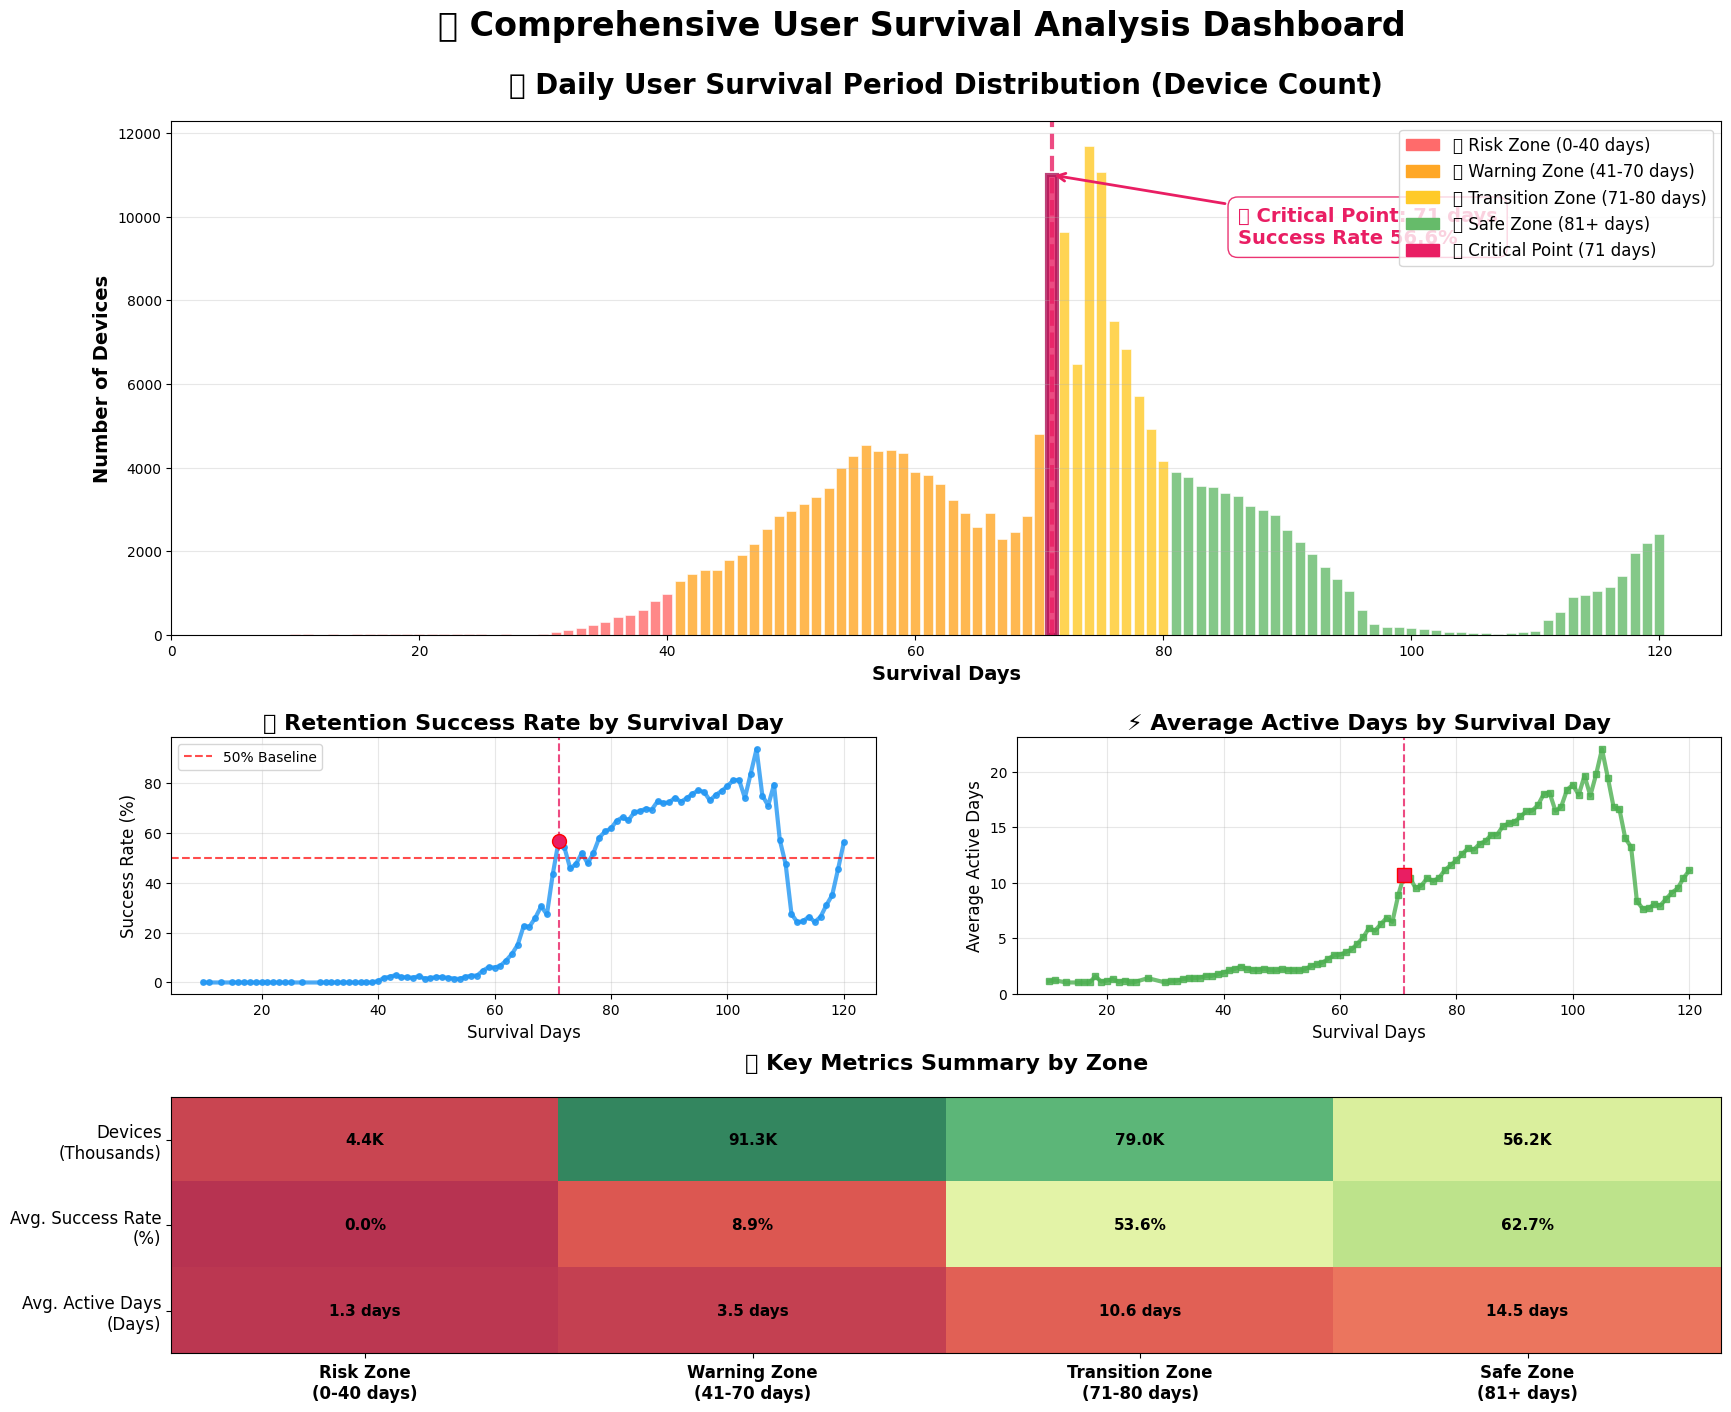


‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å!
üí° **ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏:**
    ‚Ä¢ 71ÏùºÏù¥ Í≥†/Ï†Ä Î¶¨ÌÖêÏÖòÏùò Í≤∞Ï†ïÏ†Å Î∂ÑÍ∏∞Ï†ê
    ‚Ä¢ 40Ïùº Ïù¥Ï†Ñ Ïù¥ÌÉàÎ•†Ïù¥ Îß§Ïö∞ ÎÜíÏùå
    ‚Ä¢ 80Ïùº Ïù¥ÌõÑ ÏïàÏ†ïÏ†ÅÏù∏ Í≥†Î¶¨ÌÖêÏÖò Îã¨ÏÑ±


In [17]:
import duckdb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (ÏãúÍ∞ÅÌôî ÌÖçÏä§Ìä∏Îäî ÏòÅÏñ¥Î°ú Ïú†ÏßÄÎêòÎÇò, ÌïÑÏöî Ïãú ÎåÄÎπÑ)
plt.rcParams['font.family'] = ['DejaVu Sans', 'Malgun Gothic', 'AppleGothic']
plt.rcParams['axes.unicode_minus'] = False

print("üöÄ Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†ÅÏù∏ Ïú†Ï†Ä ÏÉùÏ°¥Í∏∞Í∞Ñ Î∂ÑÏÑù ÏãúÏûë...")

# DuckDB Ïó∞Í≤∞ Î∞è Î©îÎ™®Î¶¨ ÏÑ§Ï†ï
conn = duckdb.connect()
conn.execute("SET memory_limit = '4GB';")
conn.execute("SET threads = 4;")

# ÌïµÏã¨ ÏøºÎ¶¨: ÏùºÎ≥Ñ ÏÉùÏ°¥Í∏∞Í∞Ñ Î∂ÑÌè¨ (Î©îÎ™®Î¶¨ Ìö®Ïú®Ï†Å)
survival_distribution_query = """
WITH device_survival AS (
    SELECT 
        DATE_DIFF('day', signup_date, MAX(event_datetime)) as survival_days,
        COUNT(DISTINCT DATE(event_datetime)) as active_days,
        COUNT(*) as total_events
    FROM 'FINAL_COMPLETE_EVENTS_MAPPED.parquet'
    WHERE signup_date IS NOT NULL
      AND DATE(signup_date) <= '2023-05-31'
      AND event_datetime >= signup_date
    GROUP BY device_id, user_id, signup_date
    HAVING survival_days >= 0 AND survival_days <= 200  -- ÎÖ∏Ïù¥Ï¶à Ï†úÍ±∞
)
SELECT 
    survival_days,
    COUNT(*) as device_count,
    COUNT(CASE WHEN active_days >= 10 THEN 1 END) as high_retention_count,
    COUNT(CASE WHEN active_days >= 10 THEN 1 END) * 100.0 / COUNT(*) as success_rate,
    AVG(active_days) as avg_active_days,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY active_days) as median_active_days
FROM device_survival
WHERE survival_days BETWEEN 1 AND 120  -- ÌïµÏã¨ Íµ¨Í∞ÑÎßå
GROUP BY survival_days
HAVING COUNT(*) >= 10  -- ÏµúÏÜå 10Í∞ú ÏÉòÌîå
ORDER BY survival_days
"""

print("üìä Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú Ï§ë...")
results = conn.execute(survival_distribution_query).fetchall()
conn.close()

# Îç∞Ïù¥ÌÑ∞ ÌååÏã±
days = []
device_counts = []
success_rates = []
avg_activities = []

for row in results:
    survival_day, device_count, high_retention, success_rate, avg_active, median_active = row
    days.append(survival_day)
    device_counts.append(device_count)
    success_rates.append(success_rate)
    avg_activities.append(avg_active)

print(f"‚úÖ {len(days)}ÏùºÍ∞ÑÏùò Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!")

# Íµ¨Í∞ÑÎ≥Ñ ÏÉâÏÉÅ Ï†ïÏùò
def get_zone_color(day):
    if day <= 40: return '#FF6B6B'       # Îπ®Í∞ï - ÏúÑÌóòÍµ¨Í∞Ñ
    elif day <= 70: return '#FFA726'     # Ï£ºÌô© - Í≤ΩÍ≥†Íµ¨Í∞Ñ  
    elif day <= 80: return '#FFCA28'     # ÎÖ∏Îûë - Ï†ÑÌôòÍµ¨Í∞Ñ
    else: return '#66BB6A'               # Ï¥àÎ°ù - ÏïàÏ†ÑÍµ¨Í∞Ñ

# Íµ¨Í∞ÑÎ≥Ñ Ïª¨Îü¨ Îß§Ìïë
colors = [get_zone_color(day) for day in days]

# 71Ïùº ÏûÑÍ≥ÑÏ†ê Ï∞æÍ∏∞
critical_point = 71
critical_idx = None
if critical_point in days:
    critical_idx = days.index(critical_point)

print("üé® ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë...")

# ÎåÄÌòï ÌîºÍ∑úÏñ¥ ÏÉùÏÑ± (4Í∞ú ÏÑúÎ∏åÌîåÎ°Ø)
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.2)

# 1. Î©îÏù∏ Ï∞®Ìä∏: ÏùºÎ≥Ñ ÎîîÎ∞îÏù¥Ïä§ Î∂ÑÌè¨
ax1 = fig.add_subplot(gs[0, :])
bars = ax1.bar(days, device_counts, color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)

# 71Ïùº ÏûÑÍ≥ÑÏ†ê Í∞ïÏ°∞
if critical_idx:
    bars[critical_idx].set_color('#E91E63')
    bars[critical_idx].set_edgecolor('#AD1457') 
    bars[critical_idx].set_linewidth(3)
    ax1.axvline(x=critical_point, color='#E91E63', linestyle='--', linewidth=3, alpha=0.8)
    ax1.annotate(f'üéØ Critical Point: {critical_point} days\nSuccess Rate {success_rates[critical_idx]:.1f}%', 
                 xy=(critical_point, device_counts[critical_idx]), 
                 xytext=(critical_point+15, max(device_counts)*0.8),
                 fontsize=14, fontweight='bold', color='#E91E63',
                 arrowprops=dict(arrowstyle='->', color='#E91E63', lw=2),
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='#E91E63', alpha=0.9))

ax1.set_title('üìä Daily User Survival Period Distribution (Device Count)', fontsize=20, fontweight='bold', pad=20)
ax1.set_xlabel('Survival Days', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Devices', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xlim(0, 125)

# Î≤îÎ°Ä Ï∂îÍ∞Ä
legend_elements = [
    mpatches.Patch(color='#FF6B6B', label='üî¥ Risk Zone (0-40 days)'),
    mpatches.Patch(color='#FFA726', label='üü† Warning Zone (41-70 days)'),
    mpatches.Patch(color='#FFCA28', label='üü° Transition Zone (71-80 days)'),
    mpatches.Patch(color='#66BB6A', label='üü¢ Safe Zone (81+ days)'),
    mpatches.Patch(color='#E91E63', label='üéØ Critical Point (71 days)')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=12)

# 2. ÏÑ±Í≥µÎ•† Ìä∏Î†åÎìú  
ax2 = fig.add_subplot(gs[1, 0])
line = ax2.plot(days, success_rates, color='#2196F3', linewidth=3, marker='o', markersize=4, alpha=0.8)
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Baseline')
if critical_idx:
    ax2.axvline(x=critical_point, color='#E91E63', linestyle='--', alpha=0.8)
    ax2.plot(critical_point, success_rates[critical_idx], 'ro', markersize=10, markerfacecolor='#E91E63')

ax2.set_title('üìà Retention Success Rate by Survival Day', fontsize=16, fontweight='bold')
ax2.set_xlabel('Survival Days', fontsize=12)
ax2.set_ylabel('Success Rate (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. ÌèâÍ∑† ÌôúÎèôÏùº Ìä∏Î†åÎìú    
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(days, avg_activities, color='#4CAF50', linewidth=3, marker='s', markersize=4, alpha=0.8)
if critical_idx:
    ax3.axvline(x=critical_point, color='#E91E63', linestyle='--', alpha=0.8)
    ax3.plot(critical_point, avg_activities[critical_idx], 'rs', markersize=10, markerfacecolor='#E91E63')

ax3.set_title('‚ö° Average Active Days by Survival Day', fontsize=16, fontweight='bold')
ax3.set_xlabel('Survival Days', fontsize=12)
ax3.set_ylabel('Average Active Days', fontsize=12)
ax3.grid(True, alpha=0.3)

# 4. ÌûàÌä∏Îßµ Ïä§ÌÉÄÏùº ÏöîÏïΩ
ax4 = fig.add_subplot(gs[2, :])

# Íµ¨Í∞ÑÎ≥Ñ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
zones = OrderedDict([
    ('Risk Zone\n(0-40 days)', [i for i, d in enumerate(days) if d <= 40]),
    ('Warning Zone\n(41-70 days)', [i for i, d in enumerate(days) if 41 <= d <= 70]),
    ('Transition Zone\n(71-80 days)', [i for i, d in enumerate(days) if 71 <= d <= 80]),
    ('Safe Zone\n(81+ days)', [i for i, d in enumerate(days) if d >= 81])
])

zone_stats = []
zone_colors = ['#FF6B6B', '#FFA726', '#FFCA28', '#66BB6A']

for zone_name, indices in zones.items():
    if indices:
        total_devices = sum(device_counts[i] for i in indices)
        avg_success = np.mean([success_rates[i] for i in indices])
        avg_activity = np.mean([avg_activities[i] for i in indices])
        zone_stats.append([total_devices/1000, avg_success, avg_activity])  # Ï≤ú Îã®ÏúÑÎ°ú Ïä§ÏºÄÏùºÎßÅ
    else:
        zone_stats.append([0, 0, 0])

zone_stats = np.array(zone_stats)

# ÌûàÌä∏Îßµ ÏÉùÏÑ±
im = ax4.imshow(zone_stats.T, cmap='RdYlGn', aspect='auto', alpha=0.8)

# ÎùºÎ≤® ÏÑ§Ï†ï
ax4.set_xticks(range(len(zones)))
ax4.set_xticklabels(zones.keys(), fontsize=12, fontweight='bold')
ax4.set_yticks(range(3))
ax4.set_yticklabels(['Devices\n(Thousands)', 'Avg. Success Rate\n(%)', 'Avg. Active Days\n(Days)'], fontsize=12)

# Í∞í ÌëúÏãú
for i in range(len(zones)):
    for j in range(3):
        if j == 0:  # ÎîîÎ∞îÏù¥Ïä§ Ïàò
            text = f'{zone_stats[i, j]:.1f}K'
        elif j == 1:  # ÏÑ±Í≥µÎ•†
            text = f'{zone_stats[i, j]:.1f}%'
        else:  # ÌôúÎèôÏùº
            text = f'{zone_stats[i, j]:.1f} days'
        ax4.text(i, j, text, ha="center", va="center", fontweight='bold', fontsize=11)

ax4.set_title('üìã Key Metrics Summary by Zone', fontsize=16, fontweight='bold', pad=20)

# Ï†ÑÏ≤¥ Ï†úÎ™©
fig.suptitle('üéØ Comprehensive User Survival Analysis Dashboard', fontsize=24, fontweight='bold', y=0.95)

# Î†àÏù¥ÏïÑÏõÉ ÏµúÏ†ÅÌôî
plt.tight_layout()

# ÌÜµÍ≥Ñ Ï∂úÎ†•
print("\nüìä **ÌïµÏã¨ ÌÜµÍ≥Ñ ÏöîÏïΩ**")
print("-" * 50)
total_users = sum(device_counts)
peak_day = days[device_counts.index(max(device_counts))]
peak_count = max(device_counts)

print(f"üì± Ï†ÑÏ≤¥ Î∂ÑÏÑù ÎîîÎ∞îÏù¥Ïä§: {total_users:,}Í∞ú")
print(f"üî• ÏµúÎåÄ Î∂ÑÌè¨Ïùº: {peak_day}Ïùº ({peak_count:,}Í∞ú)")
if critical_idx:
    print(f"üéØ ÏûÑÍ≥ÑÏ†ê: {critical_point}Ïùº (ÏÑ±Í≥µÎ•† {success_rates[critical_idx]:.1f}%)")

# Íµ¨Í∞ÑÎ≥Ñ ÎπÑÏú®
for i, (zone_name, indices) in enumerate(zones.items()):
    if indices:
        zone_total = sum(device_counts[i] for i in indices)
        zone_pct = zone_total / total_users * 100
        clean_name = zone_name.replace('\n', ' ')
        print(f"{['üî¥', 'üü†', 'üü°', 'üü¢'][i]} {clean_name}: {zone_pct:.1f}% ({zone_total:,}Í∞ú)")

plt.show()

print("\n‚úÖ ÏãúÍ∞ÅÌôî ÏôÑÎ£å!")
print("üí° **ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏:**")
print("    ‚Ä¢ 71ÏùºÏù¥ Í≥†/Ï†Ä Î¶¨ÌÖêÏÖòÏùò Í≤∞Ï†ïÏ†Å Î∂ÑÍ∏∞Ï†ê")
print("    ‚Ä¢ 40Ïùº Ïù¥Ï†Ñ Ïù¥ÌÉàÎ•†Ïù¥ Îß§Ïö∞ ÎÜíÏùå")
print("    ‚Ä¢ 80Ïùº Ïù¥ÌõÑ ÏïàÏ†ïÏ†ÅÏù∏ Í≥†Î¶¨ÌÖêÏÖò Îã¨ÏÑ±")